#### 환경설정

##### 1. Wandb

In [1]:
import wandb

# wandb 로그인
wandb.login(key="2fb604788cd6eed5aafafcc8d13a6aaa7737ac71")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/HyeonSeok/.netrc
wandb: Currently logged in as: vanillahub12 (boaz_woony-boaz) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

##### 2. 라이브러리 로드

In [2]:

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import os
import math
import random
import pickle
import wandb
from tqdm import tqdm
from datetime import datetime
from zoneinfo import ZoneInfo

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torchaudio.transforms as T
import torchvision
import torchvision.models as models
from torch import Tensor
from torchsummary import summary
from torch.hub import load_state_dict_from_url
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import CosineAnnealingLR

from sklearn.metrics import confusion_matrix, f1_score
from sklearn.manifold import TSNE

##### 3. 경로 설정

In [4]:
ROOT = "/home/HyeonSeok/BOAZ-Chungzins/data/raw"
CHECKPOINT_PATH = "/home/HyeonSeok/BOAZ-Chungzins/save_path/checkpoint"
PICKLE_PATH = "/home/HyeonSeok/BOAZ-Chungzins/save_path/pickle"
text = "/home/HyeonSeok/BOAZ-Chungzins/data/metadata/train_test_split.txt"

##### 4. Seed 설정

In [5]:
def seed_everything(seed: int = 42):
    import random, os
    import numpy as np
    import torch

    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # ✅ 모든 GPU에 동일하게
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # 추가: DataLoader에 worker_init_fn 활용 (아래 예시 참고)


## 1. Data Load

#### 1.1 Data Load

In [6]:
# WAV 파일이 있는 디렉토리 경로
data_dir = ROOT
txt_dir = ROOT

df = pd.read_csv(text, sep='\t', header=None)

# 컬럼 이름 변경
df.columns = ['filename', 'set']

# train, test split
train_df = df[df['set'] == 'train']
test_df = df[df['set'] == 'test']

# filename list
train_list = sorted(train_df['filename'].tolist())
test_list = sorted(test_df['filename'].tolist())

print(f'Train :{len(train_list)}, Test: {len(test_list)}, Total: {len(train_list) + len(test_list)}')

Train :539, Test: 381, Total: 920


#### 1.2 Pretext-Finetune Split

In [7]:
# shuffle train data
df_shuffled = train_df.sample(frac=1, random_state=42)

# split ratio
train_size = int(len(df_shuffled))

# pretrain, finetune split
pretrain_df = df_shuffled[:train_size]
finetune_df = pretrain_df

# filename list (pretext_list -> pretrain list)
pretrain_list = sorted(pretrain_df['filename'].tolist())
finetune_list = sorted(finetune_df['filename'].tolist())

# patient id list
pretrain_patient_list = []
for filename in pretrain_list:
    number = int(filename.split('_')[0])
    pretrain_patient_list.append(number)

finetune_patient_list = []
for filename in finetune_list:
    number = int(filename.split('_')[0])
    finetune_patient_list.append(number)

pretrain_patient_counts = pd.Series(pretrain_patient_list).value_counts()
finetune_patient_counts = pd.Series(finetune_patient_list).value_counts()

print(f"[Pretrain] 환자 수: {len(pretrain_patient_counts.index)}, 샘플 수: {pretrain_patient_counts.sum()}")
print(f"[Finetune] 환자 수: {len(finetune_patient_counts.index)}, 샘플 수: {finetune_patient_counts.sum()}")

[Pretrain] 환자 수: 79, 샘플 수: 539
[Finetune] 환자 수: 79, 샘플 수: 539


## 2. Data Preprocessing

#### 2.1 Args

        K: queue size; number of negative keys (default: 65536)
        m: moco momentum of updating key encoder (default: 0.999)
        T: softmax temperature (default: 0.07)

In [8]:
class Args:
    # Audio & Spectrogram
    target_sr = 16000    # 4KHz
    frame_size = 1024
    hop_length = 512    # frame_size 절반
    n_mels = 64
    target_sec = 8

    # Augmentation
    time_mask_param = 0.5
    freq_mask_param = 0.5

    # Train
    lr = 1e-3 # adamw - 0.03
    warm = True                     # warm-up 사용 여부
    warm_epochs = 10                # warm-up 적용할 초기 epoch 수
    warmup_from = lr * 0.1          # warm-up 시작 learning rate (보통 lr의 10%)
    warmup_to = lr

    batch_size = 128
    workers = 2
    epochs = 200
    weight_decay = 0.0

    resume = None
    schedule=[120, 160] # schedule

    # MLS
    K = 512
    momentum = 0.999
    T = 0.07
    dim_prj = 128
    top_k = 20
    lambda_bce = 0.3
    out_dim = 512

    # Linear Evaluation
    # ft_epochs = 3

    # etc
    gpu = 0
    data = "./data_path"
    seed=42
    num_classes = 2

    # update
    ma_update = False
    ma_beta = 0.5
    target_type = 'grad_flow'
    alpha = 0.0


args = Args()

In [9]:
args.alpha

0.0

#### 2.2 Utils (func)

In [10]:
import torch.nn.functional as F
import random

# cycle의 클래스를 추출
def get_class(cr, wh):
    if cr == 1 and wh == 1:
        return 3
    elif cr == 0 and wh == 1:
        return 2
    elif cr == 1 and wh == 0:
        return 1
    elif cr == 0 and wh == 0:
        return 0
    else:
        return -1

# Mel Spectrogram 생성 ( sr=4KHz, frame_size=1024, hop_length=512, n_mels=128 )
# def generate_mel_spectrogram(waveform, sample_rate, frame_size, hop_length, n_mels):
#     if hop_length is None:
#         hop_length = frame_size // 2
#     mel_spec_transform = T.MelSpectrogram(
#         sample_rate=sample_rate,
#         n_fft=frame_size,
#         hop_length=hop_length,
#         n_mels=n_mels,
#         f_min=50,       # 논문 기준 주파수 범위 하한
#         f_max=2000      # 논문 기준 주파수 범위 상한
#     )
#     mel_spectrogram = mel_spec_transform(waveform)
#     mel_db = T.AmplitudeToDB()(mel_spectrogram)
    
#     # dB 스케일에서 매우 낮은 값은 0으로 마스킹
#     mel_db[mel_db <= -100.0] = 0.0
    
#     return mel_db

# 256 맟춰주기
def generate_mel_spectrogram(waveform, sample_rate, frame_size, hop_length, n_mels):
    if hop_length is None:
        hop_length = frame_size // 2

    mel_spec_transform = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=frame_size,
        hop_length=hop_length,
        n_mels=n_mels,
        f_min=50,
        f_max=2000
    )
    mel_spectrogram = mel_spec_transform(waveform)
    mel_db = T.AmplitudeToDB()(mel_spectrogram)

    # dB 스케일에서 매우 낮은 값은 0으로 마스킹
    mel_db[mel_db <= -100.0] = 0.0

    # 🔧 가운데 padding 적용
    target_frames = 256
    current_frames = mel_db.shape[-1]
    if current_frames < target_frames:
        pad_total = target_frames - current_frames
        pad_left = pad_total // 2
        pad_right = pad_total - pad_left
        mel_db = F.pad(mel_db, (pad_left, pad_right))  # center padding
    elif current_frames > target_frames:
        # 가운데 자르기
        start = (current_frames - target_frames) // 2
        mel_db = mel_db[:, :, start:start + target_frames]

    return mel_db

# Cycle Repeat 또는 Crop
def repeat_or_truncate_segment(mel_segment, target_frames):
    current_frames = mel_segment.shape[-1]
    if current_frames >= target_frames:
        return mel_segment[:, :, :target_frames]
    else:
        repeat_ratio = math.ceil(target_frames / current_frames)
        mel_segment = mel_segment.repeat(1, 1, repeat_ratio)
        return mel_segment[:, :, :target_frames]

def preprocess_waveform_segment(waveform, unit_length):

    """unit_length 기준으로 waveform을 repeat + padding 또는 crop하여 길이 정규화"""
    waveform = waveform.squeeze(0)  # (1, L) → (L,) 로 바꿔도 무방
    length_adj = unit_length - len(waveform)

    if length_adj > 0:
        # waveform이 너무 짧은 경우 → repeat + zero-padding
        half_unit = unit_length // 2

        if length_adj < half_unit:
            # 길이 차이가 작으면 단순 padding
            half_adj = length_adj // 2
            waveform = F.pad(waveform, (half_adj, length_adj - half_adj))
        else:
            # 반복 후 부족한 부분 padding
            repeat_factor = unit_length // len(waveform)
            waveform = waveform.repeat(repeat_factor)[:unit_length]
            remaining = unit_length - len(waveform)
            half_pad = remaining // 2
            waveform = F.pad(waveform, (half_pad, remaining - half_pad))
    else:
        # waveform이 너무 길면 앞쪽 1/4 내에서 랜덤 crop
        length_adj = len(waveform) - unit_length
        start = random.randint(0, length_adj // 4)
        waveform = waveform[start:start + unit_length]

    return waveform.unsqueeze(0)  # 다시 (1, L)로

# # 논문 기반: Circular padding 방식 적용
# # - waveform이 짧은 경우: circular padding으로 8초 길이 맞춤
# # - waveform이 긴 경우: 앞쪽 25% 범위 내에서 랜덤 crop
# def preprocess_waveform_segment(waveform, unit_length):
#     """
#     논문 기반: Circular padding 적용
#     - waveform이 짧은 경우: circular padding으로 8초 길이 맞춤
#     - waveform이 긴 경우: 앞쪽 25% 범위 내에서 랜덤 crop
#     """
#     waveform = waveform.squeeze(0)  # (1, L) → (L,)
#     current_len = waveform.size(0)

#     if current_len < unit_length:
#         pad_len = unit_length - current_len
#         # ➤ shape을 (1, L)로 바꾸고 pad 적용 후 다시 (L,)로
#         waveform = waveform.unsqueeze(0)  # (L,) → (1, L)
#         waveform = F.pad(waveform, (0, pad_len), mode='circular')
#         waveform = waveform.squeeze(0)    # (1, L+pad) → (L+pad,)
#     elif current_len > unit_length:
#         max_start = max(0, current_len - unit_length)
#         start = random.randint(0, max_start // 4)
#         waveform = waveform[start:start + unit_length]

#     return waveform.unsqueeze(0)  # (L,) → (1, L)

# 데이터 Spec Augmentation ( 0~80% Random Masking )
def apply_spec_augment(mel_segment):

    M = mel_segment.shape[-1]
    F = mel_segment.shape[-2]

    # torchaudio의 마스킹은 0부터 mask_param까지 균등분포에서 랜덤하게 길이를 선택
    time_masking = T.TimeMasking(time_mask_param=int(M * 0.8))
    freq_masking = T.FrequencyMasking(freq_mask_param=int(F * 0.8) )

    aug1 = freq_masking(mel_segment.clone())
    aug2 = time_masking(mel_segment.clone())
    aug3 = freq_masking(time_masking(mel_segment.clone()))

    return aug1, aug2, aug3

# Waveform resample
def resample_waveform(waveform, orig_sr, target_sr=args.target_sr):
    if orig_sr != target_sr:
        resampler = torchaudio.transforms.Resample(
            orig_freq=orig_sr,
            new_freq=target_sr
        )
        return resampler(waveform), target_sr
    return waveform, orig_sr

# Normalize - Mean/Std
# def get_mean_and_std(dataset):
#     """ 전체 mel-spectrogram에서 mean과 std 계산 """
#     dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4)

#     cnt = 0
#     fst_moment = torch.zeros(1)
#     snd_moment = torch.zeros(1)
#     for inputs, _, _ in tqdm(dataloader, desc="[Calculating Mean/Std]"):
#         b, c, h, w = inputs.shape  # inputs: [1, 1, n_mels, time]
#         nb_pixels = b * h * w

#         fst_moment += torch.sum(inputs, dim=[0, 2, 3])
#         snd_moment += torch.sum(inputs**2, dim=[0, 2, 3])
#         cnt += nb_pixels

#     mean = fst_moment / cnt
#     std = torch.sqrt(snd_moment / cnt - mean**2)
#     return mean.item(), std.item()

def get_mean_and_std(dataset, mask_threshold=-99.0):
    """ 마스킹(-100 등)을 제외하고 mean/std 계산 """
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4)

    cnt = 0
    fst_moment = 0.0
    snd_moment = 0.0

    for inputs, _, _ in tqdm(dataloader, desc="[Calculating Mean/Std]"):
        # mask: 유효한 mel 값만 추출 (e.g. > -99.0)
        valid = inputs[inputs > mask_threshold]  # 1D tensor

        fst_moment += valid.sum().item()
        snd_moment += (valid ** 2).sum().item()
        cnt += valid.numel()

    mean = fst_moment / cnt
    std = np.sqrt(snd_moment / cnt - mean**2)
    return mean, std

In [11]:
# import torch
# import torch.nn.functional as F
# import torchaudio.transforms as T
# import numpy as np
# import random
# import math

# # -------------------- Augmentation functions (Torch 기반) --------------------

# def spec_augment(mel, time_mask_ratio, freq_mask_ratio): # default: 0.8
#     M = mel.shape[-1]  # 시간 축
#     F = mel.shape[-2]  # 주파수 축

#     time_masking = T.TimeMasking(time_mask_param=int(M * time_mask_ratio))
#     freq_masking = T.FrequencyMasking(freq_mask_param=int(F * freq_mask_ratio))

#     mel = freq_masking(mel.clone())
#     mel = time_masking(mel)
#     return mel

# # def random_crop(mel, crop_size):
# #     if mel.shape[-1] <= crop_size:
# #         return mel
# #     start = torch.randint(0, mel.shape[-1] - crop_size + 1, (1,)).item()
# #     return mel[:, :, start:start + crop_size]

# def add_noise(mel, noise_level=0.005):
#     noise = torch.randn_like(mel) * noise_level
#     return mel + noise

# def pitch_shift(mel, n_steps=2):
#     shift = random.randint(-n_steps, n_steps)
#     if shift == 0:
#         return mel
#     if shift > 0:
#         mel = torch.cat([mel[:, shift:, :], mel[:, :shift, :]], dim=1)
#     else:
#         shift = abs(shift)
#         mel = torch.cat([mel[:, -shift:, :], mel[:, :-shift, :]], dim=1)
#     return mel

# def time_stretch(mel, min_rate=0.8, max_rate=1.2):
#     rate = random.uniform(min_rate, max_rate)
#     if rate == 1.0:
#         return mel

#     orig_size = mel.shape[-1]
#     target_size = int(orig_size * rate)
#     mel_stretched = F.interpolate(
#         mel, size=(mel.shape[1], target_size),
#         mode='bilinear', align_corners=False
#     )

#     if target_size > orig_size:
#         return mel_stretched[:, :, :orig_size]
#     else:
#         padding = orig_size - target_size
#         return F.pad(mel_stretched, (0, padding))

# # -------------------- Dispatcher --------------------

# AUGMENTATION_FUNCTIONS_TORCH = {
#     "spec_augment": spec_augment,
#     # "random_crop": random_crop,
#     "add_noise": add_noise,
#     "pitch_shift": pitch_shift,
#     "time_stretch": time_stretch
# }

# def apply_augmentations_torch(x, methods=[], **kwargs):
#     for method in methods:
#         func = AUGMENTATION_FUNCTIONS_TORCH.get(method)
#         if func is None:
#             raise ValueError(f"Unknown augmentation: {method}")
#         x = func(x, **kwargs.get(method, {}))
#     return x


##############################################
import torch
import torch.nn.functional as F
import torchaudio.transforms as T
import numpy as np
import random

# -------------------- Augmentation functions (ICBHI 멜스펙트로그램에 최적화) --------------------

# def spec_augment(mel, time_mask_ratio=0.15, freq_mask_ratio=0.15):
#     """
#     SpecAugment: 시간/주파수 영역 마스킹
#     - 시간축 마스킹: 63 * 0.15 ≈ 9 프레임
#     - 주파수 마스킹: 128 * 0.1 ≈ 12 채널
#     """
#     M = mel.shape[-1]  # 시간 축
#     F = mel.shape[-2]  # 주파수 축

#     time_masking = T.TimeMasking(time_mask_param=max(1, int(M * time_mask_ratio)))
#     freq_masking = T.FrequencyMasking(freq_mask_param=max(1, int(F * freq_mask_ratio)))

#     mel = freq_masking(mel.clone())
#     mel = time_masking(mel)
#     return mel

# multi-label 논문용 spec
def spec_augment(mel, time_mask_param=20, freq_mask_param=40):
    """
    논문 기준:
    - 시간 마스킹: 최대 20 frame
    - 주파수 마스킹: 최대 40 mel bin
    """
    time_masking = T.TimeMasking(time_mask_param=time_mask_param)
    freq_masking = T.FrequencyMasking(freq_mask_param=freq_mask_param)

    mel = freq_masking(mel.clone())
    mel = time_masking(mel)
    return mel

def add_noise(mel, noise_level=0.001):
    """
    노이즈 추가: 적당한 수준의 표준 정규분포 노이즈 (너무 높으면 손실 커짐)
    """
    noise = torch.randn_like(mel) * noise_level
    return mel + noise

def pitch_shift(mel, n_steps=2):
    """
    주파수 축 순환 이동 (mel axis). shape은 그대로 유지됨.
    n_steps=2면 ±2 멜 채널만 이동.
    """
    shift = random.randint(-n_steps, n_steps)
    if shift == 0:
        return mel
    if shift > 0:
        mel = torch.cat([mel[:, :, shift:, :], mel[:, :, :shift, :]], dim=2)
    else:
        shift = abs(shift)
        mel = torch.cat([mel[:, :, -shift:, :], mel[:, :, :-shift, :]], dim=2)
    return mel

def time_stretch(mel, min_rate=0.95, max_rate=1.05):
    """
    시간 축 길이 조절. 너무 심하지 않게 ±5% 범위로만 조정.
    - shape 유지 위해 interpolation 후 crop/pad
    """
    rate = random.uniform(min_rate, max_rate)
    if rate == 1.0:
        return mel

    orig_size = mel.shape[-1]
    target_size = int(orig_size * rate)

    mel_stretched = F.interpolate(
        mel, size=(mel.shape[-2], target_size),  # (mel_bins, time)
        mode='bilinear',
        align_corners=False
    )

    if target_size > orig_size:
        return mel_stretched[..., :orig_size]
    else:
        pad = orig_size - target_size
        return F.pad(mel_stretched, (0, pad))

# -------------------- Dispatcher --------------------

AUGMENTATION_FUNCTIONS_TORCH = {
    "spec_augment": spec_augment,
    "add_noise": add_noise,
    "pitch_shift": pitch_shift,
    "time_stretch": time_stretch
}

def apply_augmentations_torch(x, methods=[], **kwargs):
    for method in methods:
        func = AUGMENTATION_FUNCTIONS_TORCH.get(method)
        if func is None:
            raise ValueError(f"Unknown augmentation: {method}")
        x = func(x, **kwargs.get(method, {}))
    return x


In [12]:
def aug(repeat_mel):
    # 먼저 복사본 준비
    mel1 = repeat_mel.clone()
    mel2 = repeat_mel.clone()

    # 각각 다른 증강 A, B 적용
    # aug1 = apply_augmentations_torch(mel1, methods=["add_noise"], add_noise={"noise_level": 0.005})
    # aug2 = apply_augmentations_torch(mel2, methods=["time_stretch"], time_stretch={"min_rate": 0.8, "max_rate": 1.2})
    # aug3 = apply_augmentations_torch(mel2, methods=["pitch_shift"], pitch_shift={"n_steps": 2})

    # # 각 결과에 spec_augment 추가 적용
    # aug1_spec = spec_augment(aug1)
    # aug2_spec = spec_augment(aug2, time_mask_ratio=0.6, freq_mask_ratio=0.4)
    # aug3_spec = spec_augment(aug3)

    ## 순수 spec_augment만 적용한 경우
    aug_speconly = spec_augment(mel1)

    return aug_speconly, None, None


def get_timestamp():
    """Outputs current time in KST like 2404070830"""
    kst_time = datetime.now(ZoneInfo("Asia/Seoul"))
    return kst_time.strftime('%y%m%d%H%M')

# Origin
# def aug(repeat_mel):
#     aug1, aug2, aug3 = apply_spec_augment(repeat_mel)
#     return aug1, aug2, aug3

#### 2.3 CycleDataset

In [13]:
import os
import torch
import torchaudio
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset
from tqdm import tqdm

class CycleDataset(Dataset):
    def __init__(self, filename_list, wav_dir, txt_dir, target_sec=args.target_sec, target_sr=args.target_sr, frame_size=args.frame_size, hop_length=args.hop_length, n_mels=args.n_mels, mean=None, std=None):
        self.filename_list = filename_list
        self.wav_dir = wav_dir
        self.txt_dir = txt_dir
        self.target_sec = target_sec
        self.target_sr = target_sr
        self.frame_size = frame_size
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.mean = mean
        self.std = std

        self.cycle_list = []

        print("[INFO] Preprocessing cycles...")
        for filename in tqdm(self.filename_list):
            txt_path = os.path.join(self.txt_dir, filename + '.txt')
            wav_path = os.path.join(self.wav_dir, filename + '.wav')

            if not os.path.exists(txt_path):
                print(f"[WARNING] Missing file: {txt_path}")
            if not os.path.exists(wav_path):
                print(f"[WARNING] Missing file: {wav_path}")

            # Load annotation
            cycle_data = np.loadtxt(txt_path, usecols=(0, 1))
            lung_label = np.loadtxt(txt_path, usecols=(2, 3))

            # Load waveform
            waveform, orig_sr = torchaudio.load(wav_path)
            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)  # Stereo to mono
                print(' waveform.shape[0] > 1:')

            # Resample to target sample rate (4kHz)
            waveform, sample_rate = resample_waveform(waveform, orig_sr, self.target_sr)

            for idx in range(len(cycle_data)):
                # 호흡 주기 start, end
                start_sample = int(cycle_data[idx, 0] * sample_rate)
                end_sample = int(cycle_data[idx, 1] * sample_rate)
                lung_duration = cycle_data[idx, 1] - cycle_data[idx, 0]

                if end_sample <= start_sample:
                    print('end_sample <= start_sample:')
                    continue  # 잘못된 구간 스킵

                # Waveform repeat + padding 후 Mel_db
                cycle_wave = waveform[:, start_sample:end_sample]
                seg_wave = preprocess_waveform_segment(cycle_wave, unit_length=int(self.target_sec * self.target_sr))
                mel = generate_mel_spectrogram(seg_wave, sample_rate, frame_size=self.frame_size, hop_length=self.hop_length, n_mels=self.n_mels)

                # 정규화
                if self.mean is not None and self.std is not None:
                    mask_value = -100.0 # mel db 에서 마스킹된 값
                    mask = (mel == mask_value)
                    mel = (mel - mean) / std
                    mel[mask] = 0.0
                    
                # crackle, wheeze -> class
                cr = int(lung_label[idx, 0])
                wh = int(lung_label[idx, 1])
                label = get_class(cr, wh)

                multi_label = torch.tensor([
                    float(label in [1, 3]),
                    float(label in [2, 3])
                ])  # 변환된 multi-label 반환

                # meta_data
                meta_data = (filename, lung_duration)

                self.cycle_list.append((mel, multi_label, meta_data))

        print(f"[INFO] Total cycles collected: {len(self.cycle_list)}")

    def __len__(self):
        return len(self.cycle_list)

    def __getitem__(self, idx):
        mel, label, meta_data = self.cycle_list[idx]
        return mel, label, meta_data

##### Pickle.dump

CycleDataset 객체 생성

In [14]:
len(train_list)

539

In [15]:
# # # import random
# # # import matplotlib.pyplot as plt
# # # import librosa.display

# # # wav_dir = ROOT
# # # txt_dir = ROOT

# # # # 1. Dataset 로드
# # # train_dataset = CycleDataset(train_list, wav_dir, txt_dir)
# # # test_dataset = CycleDataset(test_list, wav_dir, txt_dir)

# # ################################################################

# import random
# import matplotlib.pyplot as plt
# import librosa.display

# wav_dir = ROOT
# txt_dir = ROOT

# # # mean, std 먼저 계산
# # normless_dataset = CycleDataset(train_list, wav_dir, txt_dir)
# # mean, std = get_mean_and_std(normless_dataset)

# # 정규화 적용된 데이터셋 생성
# train_dataset = CycleDataset(train_list, wav_dir, txt_dir)
# test_dataset = CycleDataset(test_list, wav_dir, txt_dir)

# pickle_dict = {
#     'train_dataset': train_dataset,
#     'test_dataset': test_dataset
# }

# save_path = os.path.join(PICKLE_PATH, '0721_MLS_datasets.pkl')
# with open(save_path, 'wb') as f:
#     pickle.dump(pickle_dict, f)



pickle로 train_dataset, test_dataset 외부 저장

In [ ]:
# pickle_name = f'Aug_Moco_MLS_MelSpec_{args.target_sr//1000}kHz_{args.frame_size}win_{args.hop_length}hop_{args.n_mels}mel_{args.target_sec}s'

In [ ]:
# pickle_dict = {
#     'train_dataset': train_dataset,
#     'test_dataset': test_dataset
# }

# save_path = os.path.join(PICKLE_PATH, '3:7_saved_datasets_multilabel.pkl')
# with open(save_path, 'wb') as f:
#     pickle.dump(pickle_dict, f)

# # #####

# # 🔹 mean, std 함께 저장
# pickle_dict = {
#     'train_dataset': train_dataset,
#     'test_dataset': test_dataset,
#     'mean': mean,
#     'std': std
# }
# with open(os.path.join(PICKLE_PATH, 'pad0_norm_saved_datasets_multilabel.pkl'), 'wb') as f:
#     pickle.dump(pickle_dict, f)

# print(f'mean: {mean}, std: {std}')

In [ ]:
# # 2. 간단 통계
# print(f"Total cycles: {len(train_dataset)}")

# label_counter = [0] * 4  # normal, crackle, wheeze, both
# for _, multi_label,_ in train_dataset:
#     if torch.equal(multi_label, torch.tensor([0., 0.])):
#         label_counter[0] += 1
#     elif torch.equal(multi_label, torch.tensor([1., 0.])):
#         label_counter[1] += 1
#     elif torch.equal(multi_label, torch.tensor([0., 1.])):
#         label_counter[2] += 1
#     elif torch.equal(multi_label, torch.tensor([1., 1.])):
#         label_counter[3] += 1

# for idx, count in enumerate(label_counter):
#     print(f"Class {idx}: {count} cycles")

##### Pickle.load
저장된 train_dataset, test_dataset을 로드  
(> Aug 는 Moco 모델에서 사용)

In [17]:
save_path = os.path.join(PICKLE_PATH, 'MLS_0722_16kHz_1024win_512hop_64mel_8s.pkl')
with open(save_path, 'rb') as f:
    pickle_dict = pickle.load(f)

train_dataset = pickle_dict['train_dataset']
test_dataset = pickle_dict['test_dataset']

print(f"[Train] Cycles: {len(train_dataset)}")
print(f"[Test] Cycles: {len(test_dataset)}")

###################

# save_path = os.path.join(PICKLE_PATH, 'pad0_norm_saved_datasets_multilabel.pkl')
# # 🔹 load with normalization values
# with open(save_path, 'rb') as f:
#     pickle_dict = pickle.load(f)

# train_dataset = pickle_dict['train_dataset']
# test_dataset = pickle_dict['test_dataset']
# mean = pickle_dict['mean']
# std = pickle_dict['std']

# print(f"[Train] Cycles: {len(train_dataset)}")
# print(f"[Test] Cycles: {len(test_dataset)}")
# print(f"[INFO] Loaded mean={mean:.4f}, std={std:.4f}")

[Train] Cycles: 4142
[Test] Cycles: 2756


In [18]:
train_dataset[0][0].shape

torch.Size([1, 64, 256])

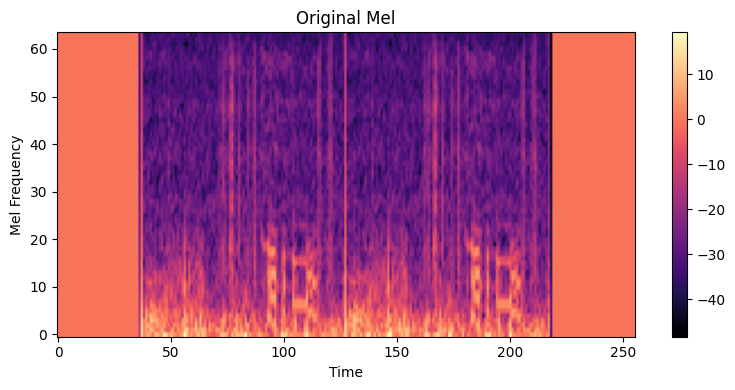

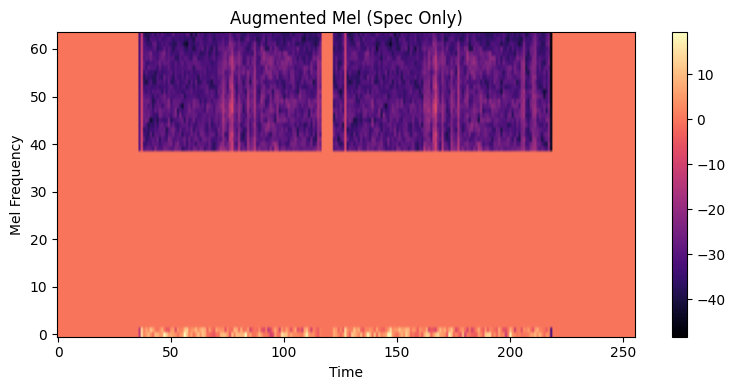

In [19]:
import matplotlib.pyplot as plt

# 데이터 로드
mel = train_dataset[0][0]  # (1, 64, 256)

# 증강 적용
aug_speconly, _ , _ = aug(mel)  # aug1: speconly, aug2: speconly

# 시각화 함수
def show_mel(mel_tensor, title):
    # 텐서 shape이 (1, 64, 256) 또는 (1, 1, 64, 256)일 수 있음
    if mel_tensor.ndim == 4:
        mel_tensor = mel_tensor.squeeze(0)  # (1, 64, 256)
    mel_np = mel_tensor.squeeze(0).cpu().numpy()  # (64, 256)
    
    plt.figure(figsize=(8, 4))
    plt.imshow(mel_np, origin='lower', aspect='auto', cmap='magma')
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Mel Frequency")
    plt.tight_layout()
    plt.show()

# 시각화
show_mel(mel, "Original Mel")
show_mel(aug_speconly, "Augmented Mel (Spec Only)")


#### 2.4 DataLoader

In [20]:
train_dataset[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([0., 1.]),
 ('103_2b2_Ar_mc_LittC2SE', np.float64(2.886)))

In [21]:
train_dataset[9][0].shape

torch.Size([1, 64, 256])

In [22]:
# ---------------- 학습 데이터 구성(seed) ----------------
seed_everything(args.seed)

# train_dataset 내에서 각 파일의 인덱스를 추출
pretrain_idx = []
finetune_idx = []

for i in range(len(train_dataset)):
    filename = train_dataset[i][2][0]

    if filename in pretrain_list:
        pretrain_idx.append(i)
    # elif filename in finetune_list:
    #     finetune_idx.append(i)

    # pretrain = finetune
    if filename in finetune_list:
        finetune_idx.append(i)

# 인덱스 순서 셔플
random.shuffle(pretrain_idx)
random.shuffle(finetune_idx)

print(f"Pretrain set size: {len(pretrain_idx)}, Finetune set size: {len(finetune_idx)}")

Pretrain set size: 4142, Finetune set size: 4142


코드 실행 환경에 따라 num_workers를 적절한 값으로 지정해주세요!

In [23]:
# Dataset 생성 (Subset)
pretrain_dataset = Subset(train_dataset, pretrain_idx)
finetune_dataset = Subset(train_dataset, finetune_idx)

# DataLoader 생성
# DataLoader에서 shuffle=True로 지정하면 매 epoch마다 셔플 순서가 달라짐 => 재현성 문제 발생
# pretrain_dataset, finetune_dataset은 이미 셔플이 완료된 것으로, 이것을 DataLoader에 입력함
pretrain_loader = DataLoader(
    pretrain_dataset,
    batch_size=args.batch_size,
    num_workers=0,
    drop_last=True,
    pin_memory=True,
    shuffle=False
)

finetune_loader = DataLoader(
    finetune_dataset,
    batch_size=args.batch_size,
    num_workers=0,
    drop_last=True,
    pin_memory=True,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=args.batch_size,
    num_workers=0,
    pin_memory=True,
    shuffle=False
)

label 분포 확인 (단순 참고용, 실제 환경에서는 pretrain set의 label 분포가 어떤지 알 수 없음)

In [24]:
from collections import Counter

# label
labels = torch.stack([multi_label for _, multi_label, _ in train_dataset])

# pretext와 finetune 데이터셋의 라벨 분포 출력
pretrain_labels = labels[pretrain_idx]
pretrain_labels_class = (
    pretrain_labels[:, 0].long() * 1 +  # crackle bit → *1
    pretrain_labels[:, 1].long() * 2    # wheeze bit  → *2
)  # [N] shape, values in {0, 1, 2, 3}
finetune_labels = labels[finetune_idx]
finetune_labels_class = (
    finetune_labels[:, 0].long() * 1 +  # crackle bit → *1
    finetune_labels[:, 1].long() * 2    # wheeze bit  → *2
)  # [N] shape, values in {0, 1, 2, 3}

# test 데이터셋의 라벨 분포 출력
test_labels = torch.stack([multi_label for _, multi_label, _ in test_dataset])
test_labels_class = (
    test_labels[:, 0].long() * 1 +  # crackle bit → *1
    test_labels[:, 1].long() * 2    # wheeze bit  → *2
)  # [N] shape, values in {0, 1, 2, 3}

print(f"Pretrain sample: {len(pretrain_labels_class)}")
print("Pretrain label distribution:", Counter(pretrain_labels_class.tolist()))
print(f"\nFinetune sample: {len(finetune_labels_class)}")
print("Finetune label distribution:", Counter(finetune_labels_class.tolist()))
print(f"Test sample: {len(test_labels_class)}")
print("Test label distribution:", Counter(test_labels_class.tolist()))

Pretrain sample: 4142
Pretrain label distribution: Counter({0: 2063, 1: 1215, 2: 501, 3: 363})

Finetune sample: 4142
Finetune label distribution: Counter({0: 2063, 1: 1215, 2: 501, 3: 363})
Test sample: 2756
Test label distribution: Counter({0: 1579, 1: 649, 2: 385, 3: 143})


## 3. Modeling

#### 3.1 Pre-trained ResNet50

In [25]:
# def backbone_resnet():
#     # 1. 기본 ResNet50 생성 (pretrained=False로 시작)
#     resnet = models.resnet50(pretrained=False)

#     # 2. 첫 번째 conv 레이어를 1채널용으로 수정
#     resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

#     # 먼저 fc 제거
#     resnet.fc = nn.Identity()

#     # 3. ImageNet 가중치 로드 (conv1 제외)
#     state_dict = load_state_dict_from_url(
#         'https://download.pytorch.org/models/resnet50-19c8e357.pth',
#         progress=True
#     )
#     if 'conv1.weight' in state_dict:
#         del state_dict['conv1.weight']
#     resnet.load_state_dict(state_dict, strict=False)

#     return resnet

In [26]:
from torchvision.models import resnet50, ResNet50_Weights

class ResNet50(torchvision.models.resnet.ResNet):
    def __init__(self, track_bn=True):
        def norm_layer(*args, **kwargs):
            return nn.BatchNorm2d(*args, **kwargs, track_running_stats=track_bn)
        super().__init__(torchvision.models.resnet.Bottleneck, [3, 4, 6, 3], norm_layer=norm_layer)
        del self.fc
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.final_feat_dim = 2048

    def load_sl_official_weights(self, progress=True):
        weights = ResNet50_Weights.DEFAULT
        state_dict = weights.get_state_dict(progress=progress)

        del state_dict['conv1.weight']
        missing, unexpected = self.load_state_dict(state_dict, strict=False)
        # if len(missing) > 0:
            # raise AssertionError('Model code may be incorrect')

    def load_ssl_official_weights(self, progress=True):
        # only SimCLR is available
        from pl_bolts.models.self_supervised import SimCLR
        
        weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt'
        simclr = SimCLR.load_from_checkpoint(weight_path, strict=False)

        state_dict = {}
        for k, v in simclr.state_dict().items():
            if 'encoder.' in k:
                k = k.replace('encoder.', '')
            if 'fc' not in k or 'project' not in k:
                state_dict[k] = v
        missing, unexpected = self.load_state_dict(state_dict, strict=False)
        # non_linear_evaluator.block_forward is a pretrained MLP classifier for SimCLR
        # refer to https://github.com/Lightning-AI/lightning-bolts/blob/bcbbf6ab6c36430946dd8a416ddc7e697e8507fc/pl_bolts/models/self_supervised/evaluator.py#L7
        if len(missing) > 0:
            raise AssertionError('Model code may be incorrect')

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        # x = self.fc(x)

        return x

In [27]:
def backbone_resnet50_patch():
    """
    MoCo 구조에 사용할 CNN6 백본 정의 함수.
    
    주요 변경 사항:
    - ResNet50 대신 CNN6 클래스 사용
    - 출력 feature dim은 512로 고정됨 (MoCo에서는 dim_enc=2048 → 이 부분만 맞춰서 사용하면 문제 없음)
    - ImageNet pretrained 사용 대신 공식 CNN6 pretrained 로딩 함수 포함 (옵션 사용 가능)
    """
    model = ResNet50()

    # 공식 SL pretrained weight를 사용하고자 할 경우 아래 줄을 주석 해제
    model.load_sl_official_weights()

    return model


#### 3.2 Pre-trained CNN6

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def init_layer(layer):
    """Initialize a Linear or Convolutional layer. """
    nn.init.xavier_uniform_(layer.weight)
    if hasattr(layer, 'bias'):
        if layer.bias is not None:
            layer.bias.data.fill_(0.)
            

def init_bn(bn):
    """Initialize a Batchnorm layer. """
    bn.bias.data.fill_(0.)
    bn.weight.data.fill_(1.)


class ConvBlock5x5(nn.Module): #for CNN6
    def __init__(self, in_channels, out_channels, stride=(1,1)):
        
        super(ConvBlock5x5, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                              out_channels=out_channels,
                              kernel_size=(5, 5), stride=stride,
                              padding=(2, 2), bias=False)
                              
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.init_weight()
        
    def init_weight(self):
        init_layer(self.conv1)
        init_bn(self.bn1)
        
    def forward(self, input, pool_size=(2, 2), pool_type='avg'):        
        x = input
        x = F.relu_(self.bn1(self.conv1(x)))
        if pool_type == 'max':
            x = F.max_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg':
            x = F.avg_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg+max':
            x1 = F.avg_pool2d(x, kernel_size=pool_size)
            x2 = F.max_pool2d(x, kernel_size=pool_size)
            x = x1 + x2
        else:
            raise Exception('Incorrect argument!')
        
        return x


class CNN6(nn.Module):
    def __init__(self):
        super(CNN6, self).__init__()
        self.final_feat_dim = 512

        self.do_dropout = False
        self.conv_block1 = ConvBlock5x5(in_channels=1, out_channels=64, stride=(1,1))
        self.conv_block2 = ConvBlock5x5(in_channels=64, out_channels=128, stride=(1,1))
        self.conv_block3 = ConvBlock5x5(in_channels=128, out_channels=256, stride=(1,1))
        self.conv_block4 = ConvBlock5x5(in_channels=256, out_channels=512, stride=(1,1))
        self.dropout = nn.Dropout(0.2)
        # self.linear = nn.Linear(512, num_classes, bias=True)

    def load_sl_official_weights(self):
        """ download AudioSet pretrained CNN6 in https://zenodo.org/record/3960586#.Y8dz8y_kEiY
        """
        weights = torch.load('/home/HyeonSeok/Cnn6_mAP=0.343.pth')['model']
        state_dict = {k: v for k, v in weights.items() if k in self.state_dict().keys()}
        missing, unexpected = self.load_state_dict(state_dict, strict=False)

    def forward(self, x, return_feature_map=False):
        x = self.conv_block1(x, pool_size=(2, 2), pool_type='avg')
        if self.do_dropout:
            x = self.dropout(x)
        x = self.conv_block2(x, pool_size=(2, 2), pool_type='avg')
        if self.do_dropout:
            x = self.dropout(x)
        x = self.conv_block3(x, pool_size=(2, 2), pool_type='avg')
        if self.do_dropout:
            x = self.dropout(x)
        x = self.conv_block4(x, pool_size=(2, 2), pool_type='avg')
        if self.do_dropout:
            x = self.dropout(x)
        
        if return_feature_map:
            return x  # shape: (B, 512, 4, 16)

        x = torch.mean(x, dim=3) #mean over time dim
        (x1, _) = torch.max(x, dim=2) #max over freq dim
        x2 = torch.mean(x, dim=2) #mean over freq dim (after mean over time)
        x = x1 + x2

        # if self.embed_only:
        #     return x
        # return self.linear(x)
        return x

In [29]:
def backbone_cnn6():
    """
    MoCo 구조에 사용할 CNN6 백본 정의 함수.
    
    주요 변경 사항:
    - ResNet50 대신 CNN6 클래스 사용
    - 출력 feature dim은 512로 고정됨 (MoCo에서는 dim_enc=2048 → 이 부분만 맞춰서 사용하면 문제 없음)
    - ImageNet pretrained 사용 대신 공식 CNN6 pretrained 로딩 함수 포함 (옵션 사용 가능)
    """
    model = CNN6()

    # 공식 SL pretrained weight를 사용하고자 할 경우 아래 줄을 주석 해제
    model.load_sl_official_weights()

    return model


##### 3.3 Multilabel Attention

In [30]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F


# class MultilabelAttention(nn.Module):
#     def __init__(self, backbone, num_classes=2, lambda_attn=0.5, attention_heads=[1, float('inf')]):
#         super(MultilabelAttention, self).__init__()
#         self.backbone = backbone()
#         self.num_classes = num_classes
#         self.lambda_attn = lambda_attn
#         self.attention_heads = attention_heads  # e.g., [1, inf] for H=2

#         self.class_weights = nn.Parameter(torch.randn(len(attention_heads), num_classes, 512))

#         self.output_layer = nn.ModuleList([
#             nn.Linear(512, 1) for _ in range(num_classes)
#         ])

#     def forward(self, x):
#         # CNN6 백본 통과 → shape: (B, 512, 4, 16)
#         feat_map = self.backbone(x, return_feature_map=True)  # (B, 512, 4, 16)

#         B, C, Freq, Time = feat_map.shape
#         flat_feat = feat_map.view(B, C, Freq * Time).permute(0, 2, 1)  # (B, 64, 512)

#         # Class-specific attention a_i 계산
#         attn_outputs = []
#         for h, T in enumerate(self.attention_heads):
#             Ci = self.class_weights[h]  # (num_classes, 512)
#             logits = torch.einsum("bnc, kc -> bnk", flat_feat, Ci)  # (B, 64, num_classes)
#             logits = logits.permute(0, 2, 1)  # (B, num_classes, 64)
#             if T == float('inf'):
#                 attn_scores = F.one_hot(torch.argmax(logits, dim=2), num_classes=logits.shape[2]).float()
#             else:
#                 attn_scores = F.softmax(T * logits, dim=2)  # (B, num_classes, 64)

#             attn_scores = attn_scores.unsqueeze(-1)  # (B, num_classes, 64, 1)
#             flat_feat_exp = flat_feat.unsqueeze(1)  # (B, 1, 64, 512)
#             attn_feat = torch.sum(attn_scores * flat_feat_exp, dim=2)  # (B, num_classes, 512)
#             attn_outputs.append(attn_feat)

#         # Class-specific global feature g_i 계산
#         feat_avg_t = torch.mean(feat_map, dim=3)  # (B, 512, Freq)
#         gmp = torch.max(feat_avg_t, dim=2)[0]     # (B, 512)
#         gap = torch.mean(feat_avg_t, dim=2)       # (B, 512)
#         g = gmp + gap                             # (B, 512)
#         g = g.unsqueeze(1).repeat(1, self.num_classes, 1)  # (B, num_classes, 512)

#         # Combine: f_i = g_i + lambda * a_i
#         combined = g
#         for attn in attn_outputs:
#             combined = combined + self.lambda_attn * attn  # sum over heads

#         # Output layer for each class
#         out = []
#         for i in range(self.num_classes):
#             cls_feat = combined[:, i, :]  # (B, 512)
#             logit = self.output_layer[i](cls_feat).squeeze(-1)  # (B,)
#             out.append(logit)

#         logits = torch.stack(out, dim=1)  # (B, num_classes)
#         probs = torch.sigmoid(logits)    # (B, num_classes)
#         return combined, logits, probs                 # 마지막 dim: (B, 2, 512) 


# def backbone_mlattention():
#     """
#     Multi-label attention 기반 backbone 정의 함수
#     CNN6 기반 특징 추출기 + CSRA 기반 attention 구조 결합
    
#     Returns:
#         nn.Module: Multi-label attention 기반 분류기
#     """
#     return MultilabelAttention(backbone=backbone_cnn6, num_classes=2, lambda_attn=0.5, attention_heads=[1, float('inf')])


In [32]:
# x = torch.randn(10, 1, 64, 256) # B=10
# model = backbone_mlattention()
# out = model(x)  # (B, 2, 512)

# print(f"\ntorch.Size : {out.shape}")  # → torch.Size([B=10, 2, 512])

##### 3.4 Mix-MultiLabel Attention

In [33]:
import torch
import torch.nn.functional as F
import numpy as np

def group_mix(group_spec, labels, beta=1.0):
    """
    Group-wise PatchMix (spatial domain) for group_spec of shape [B, 64, 512]
    """
    B, N, D = group_spec.shape  # B: 배치 크기, N: 그룹 수 (ex. 64), D: 차원 수 (ex. 512)
                                # e.g., group_spec.shape == [B, 64, 512]

    device = group_spec.device  # e.g., 'cuda:0'

    # 🔹 lam: beta 분포에서 샘플링 (mix 비율)
    lam = np.random.beta(beta, beta)  # scalar float (e.g., 0.66)

    # 🔹 num_mask: 총 N 그룹 중에서 몇 개를 섞을지 결정
    num_mask = int(N * (1. - lam))  # scalar int (e.g., 64 * 0.34 = 21)

    # 🔹 mask: 섞을 group index (공통)
    mask = torch.randperm(N)[:num_mask].to(device)  # shape: [num_mask] (e.g., [21])

    # 🔹 index: 다른 sample과 섞기 위해 순서를 섞음
    index = torch.randperm(B).to(device)  # shape: [B] (e.g., [3, 0, 1, 2])

    # 🔹 mix: 같은 위치의 group들을 index 기준으로 섞기
    mixed_group_spec = group_spec.clone()                  # shape: [B, 64, 512]
    mixed_group_spec[:, mask, :] = group_spec[index][:, mask, :]  
    # group_spec[index]: shape [B, 64, 512]
    # group_spec[index][:, mask, :]: shape [B, num_mask, 512]
    # 최종적으로 mixed_group_spec[:, mask, :]: shape [B, num_mask, 512]

    # 🔹 lam_tensor: 각 sample에 대해 lam 값을 broadcasting 하기 위한 텐서
    lam_tensor = torch.full((B,), lam, device=device)  # shape: [B] (e.g., [0.66, 0.66, 0.66, 0.66])

    # 🔹 return: 섞은 group, 원래 라벨, 섞인 라벨, lam 값, 섞인 index
    return mixed_group_spec, labels, labels[index], lam_tensor, index
    # mixed_group_spec: shape [B, 64, 512]
    # labels: shape [B] 또는 [B, C] (멀티클래스인지 멀티라벨인지에 따라 다름)
    # labels[index]: shape [B] 또는 [B, C]
    # lam_tensor: shape [B]
    # index: shape [B]


In [34]:
class GroupMixConLoss(torch.nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature

    def forward(self, proj_orig, proj_mix, labels_a, labels_b, lam, index):
        """
        proj_orig: [B, D]   # 원본 representation (e.g., global pooled feature)
        proj_mix : [B, D]   # group-mix 적용된 representation
        labels_a:  [B, C] or [B]   # 원래 라벨
        labels_b:  [B, C] or [B]   # 섞인 라벨
        lam:       [B]             # 각 샘플마다 lam 값
        index:     [B]             # 섞인 대상 인덱스
        """
        B = proj_orig.size(0)           # 배치 크기
        device = proj_orig.device

        # 🔹 L2 정규화
        proj_orig = F.normalize(proj_orig, dim=1)   # [B, D]
        proj_mix  = F.normalize(proj_mix, dim=1)    # [B, D]
        # print(f"proj_orig.shape: {proj_orig.shape}, proj_mix.shape: {proj_mix.shape}")

        # 🔹 유사도 행렬: mix vs. original 간의 내적
        sim_matrix = torch.matmul(proj_mix, proj_orig.T) / self.temperature  
        # [B, D] x [D, B] -> [B, B]

        # 🔹 마스크 A: 원래 자기 자신이랑만 1인 마스크
        mask_a = torch.eye(B, device=device)  # [B, B]

        # 🔹 마스크 B: 각 mix가 섞인 대상과 1인 마스크
        mask_b = torch.zeros_like(mask_a)     # [B, B]
        mask_b[torch.arange(B), index] = 1    # 예: i-th row에서 index[i] column에 1

        # 🔹 soft positive mask = lam * identity + (1 - lam) * mix_target
        # lam: [B] -> [B, 1], broadcasting 됨
        mask = lam.view(-1, 1) * mask_a + (1 - lam).view(-1, 1) * mask_b  # [B, B]

        # 🔹 softmax log-prob 계산
        log_prob = sim_matrix - torch.logsumexp(sim_matrix, dim=1, keepdim=True)  
        # log_softmax(sim_matrix, dim=1)과 동일
        # sim_matrix: [B, B], log_prob: [B, B]

        # 🔹 positive log-prob만 평균냄
        # 각 row (i)에서 soft positive에 해당하는 위치에 대해서만 log_prob * mask
        mean_log_prob_pos = (mask * log_prob).sum(dim=1) / mask.sum(dim=1)  # [B]

        # 🔹 전체 평균 loss
        loss = -mean_log_prob_pos.mean()  # scalar

        return loss


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MixMLATT(nn.Module):
    def __init__(self, backbone, num_classes=2, lambda_attn=0.5, attention_heads=[1, float('inf')], projector_dim=128):
        super(MixMLATT, self).__init__()
        self.num_classes = num_classes
        self.lambda_attn = lambda_attn
        self.attention_heads = attention_heads

        # CNN6 백본 (e.g., CNN6 → [B, 512, 4, 16])
        self.backbone = backbone()

        # Class-specific Attention weights: 각 head마다 [num_classes, 512]
        self.class_weights = nn.Parameter(torch.randn(len(attention_heads), num_classes, 512))

    def forward(self, x, mix_feature=False, patch_mix=False, y=None, lam=None, index=None):
        """
        Args:
            x: input spectrogram [B, 1, F, T]
            return_mix_feature: whether to return raw mixed [B, 64, 512] for CE/classifier
            patch_mix: whether to perform group-wise patch mix
            y: labels (only used when patch_mix is True)
            lam: lambda for mixup
            index: mix index for patch selection
        Returns:
            attn_feat: [B, num_classes, 512]
            logits: [B, num_classes]
            probs: [B, num_classes]
            raw_feat: [B, 64, 512] (for CE/classifier)
        """
        B = x.size(0)
        origin_feat = None

        # 1. CNN6 Backbone → [B, 512, 4, 16]
        feat_map = self.backbone(x, return_feature_map=True)  # (B, 512, 4, 16)

        # 2. Reshape → [B, 64, 512]
        feat_flat = feat_map.view(B, 512, -1).permute(0, 2, 1)  # (B, 64, 512)

        # 3. Optional: Patch-wise Mixing
        if patch_mix and y is not None:
            # 1. group_mix 수행
            # mixed_group_spec, labels, labels[index], lam_tensor, index
            feat_flat, label_origin, label_mix, lam, index = group_mix(feat_flat, y)

            # 2. origin_feat 저장
            origin_feat = feat_flat.detach() if mix_feature else None

        # 4. CSRA Attention
        attn_outputs = []
        for h, T in enumerate(self.attention_heads):
            class_weight = self.class_weights[h]  # (num_classes, 512)
            logits = torch.einsum("bnc,kc->bnk", feat_flat, class_weight)  # (B, 64, num_classes)
            logits = logits.permute(0, 2, 1)  # (B, num_classes, 64)

            if T == float('inf'):
                attn_scores = F.one_hot(torch.argmax(logits, dim=2), num_classes=logits.shape[2]).float()
            else:
                attn_scores = F.softmax(T * logits, dim=2)

            attn_scores = attn_scores.unsqueeze(-1)           # (B, num_classes, 64, 1)
            feat_exp = feat_flat.unsqueeze(1)                 # (B, 1, 64, 512)
            attn_feat = torch.sum(attn_scores * feat_exp, dim=2)  # (B, num_classes, 512)
            attn_outputs.append(attn_feat)

        # 5. Global Feature Aggregation
        feat_avg_t = torch.mean(feat_map, dim=3)  # (B, 512, Freq)
        gmp = torch.max(feat_avg_t, dim=2)[0]     # (B, 512)
        gap = torch.mean(feat_avg_t, dim=2)       # (B, 512)
        g = gmp + gap                             # (B, 512)
        g = g.unsqueeze(1).repeat(1, self.num_classes, 1)  # (B, num_classes, 512)

        # 6. Combine Global + Attention Feature
        attn_feat = g
        for attn in attn_outputs:
            attn_feat = attn_feat + self.lambda_attn * attn  # (B, num_classes, 512)

        # 8. Return
        if not patch_mix:
            return attn_feat, origin_feat # [B, 2, 512], [B, 64, 512]
        else:
            return attn_feat, origin_feat, label_origin, label_mix, lam, index


In [36]:
def backbone_mixmlatt():
    """
    Multi-label attention 기반 backbone 정의 함수
    CNN6 기반 특징 추출기 + CSRA 기반 attention 구조 결합
    
    Returns:
        nn.Module: Multi-label attention 기반 분류기
    """
    return MixMLATT(backbone=backbone_cnn6, num_classes=2, lambda_attn=0.5, attention_heads=[1, float('inf')])


In [37]:
# summary 함수 사용: (채널, 높이, 너비) 크기를 지정
summary(backbone_mixmlatt().to(device), input_size=(1, 64, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 64, 256]           1,600
       BatchNorm2d-2          [-1, 64, 64, 256]             128
      ConvBlock5x5-3          [-1, 64, 32, 128]               0
            Conv2d-4         [-1, 128, 32, 128]         204,800
       BatchNorm2d-5         [-1, 128, 32, 128]             256
      ConvBlock5x5-6          [-1, 128, 16, 64]               0
            Conv2d-7          [-1, 256, 16, 64]         819,200
       BatchNorm2d-8          [-1, 256, 16, 64]             512
      ConvBlock5x5-9           [-1, 256, 8, 32]               0
           Conv2d-10           [-1, 512, 8, 32]       3,276,800
      BatchNorm2d-11           [-1, 512, 8, 32]           1,024
     ConvBlock5x5-12           [-1, 512, 4, 16]               0
             CNN6-13           [-1, 512, 4, 16]               0
Total params: 4,304,320
Trainable param

## 4. Training

In [38]:
next(iter(pretrain_loader))[0].shape

torch.Size([128, 1, 64, 256])

In [39]:
def validate(model, classifier, projector_0, projector_1, val_loader, criterion, device, args):
    """
    Multi-label + GroupMix Contrastive 평가용 검증 함수
    - args.target_type 에 따라 grad_block, grad_flow, etc. 처리
    - 입력: inputs [B, 1, F, T], labels [B, 2]
    - 출력: 평균 loss, 전체 label, 전체 예측값
    """
    import numpy as np
    model.eval()
    classifier.eval()
    projector_0.eval()
    projector_1.eval()

    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels, _ in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 1. Original forward (patch_mix=False)
            attn_feat, _ = model(inputs, mix_feature=True, patch_mix=False)  # [B, 2, 512]

            # 2. Classification logits
            out = []
            for i in range(attn_feat.shape[1]):
                cls_feat = attn_feat[:, i, :]               # [B, 512]
                logit = classifier[i](cls_feat).squeeze(-1) # [B]
                out.append(logit)
            logits = torch.stack(out, dim=1)  # [B, 2]

            # 3. classification loss
            loss_ce = criterion[0](logits, labels)

            # 4. Projector1 (target type 설정)
            if args.target_type == 'grad_block':
                proj1_0 = projector_0(attn_feat[:, 0, :].detach())
                proj1_1 = projector_1(attn_feat[:, 1, :].detach())
            elif args.target_type == 'grad_flow':
                proj1_0 = projector_0(attn_feat[:, 0, :])
                proj1_1 = projector_1(attn_feat[:, 1, :])
            elif args.target_type == 'project_block':
                proj1_0 = projector_0(attn_feat[:, 0, :]).detach()
                proj1_1 = projector_1(attn_feat[:, 1, :]).detach()
            elif args.target_type == 'project_flow':
                proj1_0 = projector_0(attn_feat[:, 0, :])
                proj1_1 = projector_1(attn_feat[:, 1, :])

            # 5. PatchMix 적용 (mix_feature=True)
            mix_attn_feat, origin_feat, label_origin, label_mix, lam, index = model(inputs, y=labels, patch_mix=True, mix_feature=True)

            # 6. mix는 무조건 projector 통과
            proj2_0 = projector_0(mix_attn_feat[:, 0, :])
            proj2_1 = projector_1(mix_attn_feat[:, 1, :])

            # 7. Contrastive loss
            loss_con0 = criterion[1](proj1_0, proj2_0, label_origin, label_mix, lam, index)
            loss_con1 = criterion[1](proj1_1, proj2_1, label_origin, label_mix, lam, index)

            # 8. Total loss
            loss = loss_ce + args.alpha * (loss_con0 + loss_con1)
            running_loss += loss.item()

            # 9. Prediction
            preds = (torch.sigmoid(logits) > 0.5).int()
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds, dim=0).numpy()   # [N, 2]
    all_labels = torch.cat(all_labels, dim=0).numpy() # [N, 2]

    avg_loss = running_loss / len(val_loader)
    return avg_loss, all_labels, all_preds


In [43]:
import os
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score
from copy import deepcopy
from torch.cuda.amp import GradScaler
import torch.nn as nn
import time
import torch
from torch.cuda.amp import GradScaler


for al in [0.0, 0.3, 0.5, 0.7, 1.0]:
    class Args:
        # Audio & Spectrogram
        target_sr = 16000    # 4KHz
        frame_size = 1024
        hop_length = 512    # frame_size 절반
        n_mels = 64
        target_sec = 8

        # Augmentation
        time_mask_param = 0.5
        freq_mask_param = 0.5

        # Train
        lr = 1e-3 # adamw - 0.03
        warm = True                     # warm-up 사용 여부
        warm_epochs = 10                # warm-up 적용할 초기 epoch 수
        warmup_from = lr * 0.1          # warm-up 시작 learning rate (보통 lr의 10%)
        warmup_to = lr

        batch_size = 128
        workers = 4
        epochs = 200
        weight_decay = 0.0

        resume = None
        schedule=[120, 160] # schedule

        # MLS
        K = 512
        momentum = 0.999
        T = 0.07
        dim_prj = 128
        top_k = 20
        lambda_bce = 0.3
        out_dim = 512

        # Linear Evaluation
        # ft_epochs = 3

        # etc
        gpu = 0
        data = "./data_path"
        seed=42
        num_classes = 2

        # update
        ma_update = False
        ma_beta = 0.5
        target_type = 'grad_flow'
        alpha = al

    args = Args()

    print(args.alpha)
    who_are_you = 'others'

    # from utils.meters import AverageMeter
    ################################
    train_losses = []
    test_losses = []
    train_icbhi_scores = []
    test_icbhi_scores = []
    test_labels_all = []
    test_preds_all = []
    epochs = []

    # 모델 지정하기 전 seed 고정 필요
    seed_everything(args.seed) # Seed 고정

    pretrain_project_name = f'2_0723_{who_are_you}_basefalse_{args.alpha}alpha_MultilabelAtt_T_{args.batch_size}bs_{get_timestamp()}'

    # -------------------------------------------wan
    # wandb 초기화 (프로젝트명, 실험 이름 등 설정)
    wandb.init(
        project="0721_SBW_ICBHI_MLATT_all", # 프로젝트 이름
        name=f"{pretrain_project_name}",  # 실험 이름
        config={
            "epochs": args.epochs,
            "batch_size": args.batch_size,
            "lr": args.lr,
            "momentum": args.momentum,
            "weight_decay": args.weight_decay,
            "alpha": args.alpha,
        }
    )
    # -------------------------------------------wan

    ################################
    # 1. Model / Classifier 
    model = MixMLATT(backbone=backbone_cnn6, 
                    num_classes=2, 
                    lambda_attn=0.5, 
                    attention_heads=[1, float('inf')]
                    ).cuda()

    classifier = nn.ModuleList([nn.Linear(args.out_dim, 1) for _ in range(2)]).cuda()

    # 2. Projector 0/1
    projector_0 = nn.Sequential(nn.Linear(args.out_dim, args.out_dim),nn.ReLU(),nn.Linear(args.out_dim, args.dim_prj)).cuda()
    projector_1 = nn.Sequential(nn.Linear(args.out_dim, args.out_dim),nn.ReLU(),nn.Linear(args.out_dim, args.dim_prj)).cuda()

    # 3. EMA 선언
    ema_model = deepcopy(model)
    ema_projector_0 = deepcopy(projector_0)
    ema_projector_1 = deepcopy(projector_1)
    ema_classifier = deepcopy(classifier)
    for m in [ema_model, ema_projector_0, ema_projector_1, ema_classifier]:
        m.eval()
        for p in m.parameters():
            p.requires_grad_(False)

    # 4. criterion
    criterion = [
        nn.BCEWithLogitsLoss().cuda(),       # criterion[0]: classification
        GroupMixConLoss(temperature=0.07).cuda()  # criterion[1]: contrastive
    ]

    # 5. optimizer  
    optimizer = optim.Adam(
        list(model.parameters()) + list(classifier.parameters()) + 
        list(projector_0.parameters()) + list(projector_1.parameters()),
        lr=args.lr, weight_decay=args.weight_decay
    )


    # 6. EMA (Exponential Moving Average) 설정
    @torch.no_grad()
    def update_ema(student, ema, beta=0.999):
        for param, ema_param in zip(student.parameters(), ema.parameters()):
            ema_param.data = beta * ema_param.data + (1 - beta) * param.data


    # 7. Train
    # Best loss 초기화
    best_loss = float('inf')
    best_epoch = -1

    for epoch in range(args.epochs):
        # ===============================
        # Training
        # ===============================
        model.train()
        projector_0.train()
        projector_1.train()
        classifier.train()

        total_train_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0

        all_preds = []
        all_labels = []
        all_outputs = []

        pbar = tqdm(pretrain_loader, desc='Mix_MLATT Trainig only')
        for idx, (repeat_mel, labels, _) in enumerate(pbar):
            # # (0) EMA 저장
            # if args.ma_update:
            #     with torch.no_grad():
            #         ma_ckpt = [
            #             deepcopy(model.state_dict()),
            #             deepcopy(projector_0.state_dict()),
            #             deepcopy(projector_1.state_dict()),
            #             deepcopy(classifier.state_dict())
            #         ]

            repeat_mel = repeat_mel.cuda(non_blocking=True)
            labels = labels.cuda(non_blocking=True)
            bsz = labels.size(0)


            # (1) Original 이미지 forward
            # attn_feat: [B, 2, 512], origin_feat: [B, 64, 512]
            attn_feat, _ = model(repeat_mel, mix_feature=True, patch_mix=False)
            out = []
            for i in range(args.num_classes):
                cls_feat = attn_feat[:, i, :]  # (B, 512)
                logit = classifier[i](cls_feat).squeeze(-1)  # (B,)
                out.append(logit)
            logits = torch.stack(out, dim=1) # [B, 2]

            # (2) classification loss
            loss_ce = criterion[0](logits, labels)

            # (3) projector1 생성 (class별)
            if args.target_type == 'grad_block':
                proj1_0 = projector_0(attn_feat[:, 0, :].detach())   # [B, 128]
                proj1_1 = projector_1(attn_feat[:, 1, :].detach())
            elif args.target_type == 'grad_flow':
                proj1_0 = attn_feat[:, 0, :]
                proj1_1 = attn_feat[:, 1, :]
            elif args.target_type == 'project_block':
                proj1_0 = deepcopy(projector_0(attn_feat[:, 0, :]).detach())
                proj1_1 = deepcopy(projector_1(attn_feat[:, 1, :]).detach())
            elif args.target_type == 'project_flow':
                proj1_0 = projector_0(attn_feat[:, 0, :])
                proj1_1 = projector_1(attn_feat[:, 1, :])

            # (4) PatchMix 수행 (mix된 이미지 반환)
            mix_attn_feat, origin_feat, label_origin, label_mix, lam, index = model(repeat_mel, y=labels, patch_mix=True, mix_feature=True)

            # (5) mix는 무조건 projector 통과
            proj2_0 = mix_attn_feat[:, 0, :]  # [B, 128]
            proj2_1 = mix_attn_feat[:, 1, :]

            # (6) GroupMixConLoss & Final loss 계산
            loss_con0 = criterion[1](proj1_0, proj2_0, label_origin, label_mix, lam, index)
            loss_con1 = criterion[1](proj1_1, proj2_1, label_origin, label_mix, lam, index)
            loss = loss_ce + args.alpha * (loss_con0 + loss_con1)
            

            # (8) Backpopagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # (9) EMA 업데이트
            if args.ma_update:
                update_ema(model, ema_model, beta=args.ma_beta)
                update_ema(projector_0, ema_projector_0, beta=args.ma_beta)
                update_ema(projector_1, ema_projector_1, beta=args.ma_beta)
                update_ema(classifier, ema_classifier, beta=args.ma_beta)

            # (10) Loss 기록
            total_train_loss += loss.item()
            
            # 예측값과 실제값 저장 ( Ablation(4-1) threshold ?? )
            predicted = (torch.sigmoid(logits) > 0.5).float()
            all_preds.append(predicted.detach().cpu())
            all_labels.append(labels.detach().cpu())
            all_outputs.append(logits.detach().cpu())


        # train loss
        train_loss = total_train_loss / len(pretrain_loader)

        # Concatenate
        all_preds = torch.cat(all_preds, dim=0).numpy()    # shape: [N, 2]
        all_labels = torch.cat(all_labels, dim=0).numpy()  # shape: [N, 2]
        all_output = torch.cat(all_outputs, dim=0).numpy()

        print(f"[Epoch {epoch} | Train Loss: {train_loss:.4f}, attn_feat: {attn_feat.shape}")


        # =====================================
        # 2-Edited. Multi-class 민감도/특이도 계산
        # =====================================
        import numpy as np
        import matplotlib.pyplot as plt
        import seaborn as sns
        import wandb
        from sklearn.metrics import confusion_matrix

        def multilabel_to_multiclass(y):
            # Crackle → 1, Wheeze → 2, Both → 3, None → 0
            y = np.array(y)
            return y[:, 0] + y[:, 1]*2

        def evaluate_multiclass_confusion(y_true, y_pred, class_names=["Normal", "Wheeze", "Crackle", "Both"]):
            y_true_cls = multilabel_to_multiclass(y_true)
            y_pred_cls = multilabel_to_multiclass(y_pred)

            cm = confusion_matrix(y_true_cls, y_pred_cls, labels=[0, 1, 2, 3])

            # N_n: 정상 → 정상
            N_n = cm[0, 0]
            N_total = cm[0].sum()

            # 이상 클래스 정답 수: W, C, B
            W_total = cm[1].sum()
            C_total = cm[2].sum()
            B_total = cm[3].sum()

            # 각각의 정답 → 정확한 예측만 고려
            W_w = cm[1, 1]
            C_c = cm[2, 2]
            B_b = cm[3, 3]

            SP = N_n / (N_total + 1e-6) #spec
            SE = (W_w + C_c + B_b) / (W_total + C_total + B_total + 1e-6) #sense

            AS = (SP + SE) / 2
            HS = 2 * SP * SE / (SP + SE + 1e-6)

            return cm, SE, SP, y_true_cls, y_pred_cls

        def log_multiclass_conf_matrix_wandb(cm, class_names, sens, spec, normalize, tag):
            # Normalize (비율) 옵션
            if normalize:
                cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
                fmt = '.2f'
                title = "Confusion Matrix (Normalized %)"
            else:
                fmt = 'd'
                title = "Confusion Matrix (Raw Count)"

            fig, ax = plt.subplots(figsize=(7, 6))
            sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                        xticklabels=class_names, yticklabels=class_names, ax=ax)

            ax.set_xlabel('Predicted')
            ax.set_ylabel('True')
            ax.set_title(title)

            icbhi_score = (sens + spec) / 2
            # 우하단에 성능 출력
            ax.text(
                0.99, 0.15,
                f"Sensitivity: {sens*100:.2f}%\nSpecificity: {spec*100:.2f}%\nICBHI Score: {icbhi_score*100:.2f}%",
                ha='right', va='bottom',
                transform=plt.gca().transAxes,
                fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
            )

            plt.tight_layout()
            # wandb.log({tag: wandb.Image(fig)})
            # plt.close(fig)
            return fig

        # 1. 4-class Confusion Matrix 평가
        class_names = ["Normal", "Crackle", "Wheeze", "Both"]
        cm_4x4, train_sens, train_spec, y_true_cls, y_pred_cls = evaluate_multiclass_confusion(all_labels, all_preds, class_names)
        icbhi_score = (train_sens + train_spec)/2

        print("4-Class Confusion Matrix:\n", cm_4x4)
        print(f"Sensitivity: {train_sens:.4f}, Specificity: {train_spec:.4f}, ICBHI Score: {icbhi_score:.4f}")


        # ===============================
        # 3. Validation
        # ===============================
        # test_loss, test_labels, test_preds = validate(
        #     model, test_loader, criterion, device
        # )

        test_loss, test_labels, test_preds = validate(
            model=ema_model if args.ma_update else model,
            classifier=ema_classifier if args.ma_update else classifier,
            projector_0=ema_projector_0 if args.ma_update else projector_0,
            projector_1=ema_projector_1 if args.ma_update else projector_1,
            val_loader=test_loader,
            criterion=criterion,
            device=device,
            args=args
        )

        precision = precision_score(test_labels, test_preds, average='macro')
        recall = recall_score(test_labels, test_preds, average='macro')
        f1 = f1_score(test_labels, test_preds, average='macro')

        test_cm_4x4, test_sens, test_spec, test_y_true_cls, test_y_pred_cls = evaluate_multiclass_confusion(test_labels, test_preds)
        test_icbhi_score = (test_sens+test_spec)/2

        print("[Validation] Confusion Matrix:\n", test_cm_4x4)
        print(f"Test Loss: {test_loss:.4f}")
        print(f"[VALIDATION] Sensitivity: {test_sens:.4f}, Specificity: {test_spec:.4f}, Avg ICBHI Score: {(test_sens+test_spec)/2:.4f}")
        print("##################################################")


        # ===============================
        # 4. Confusion Matrix
        # ===============================

        # 2. Finetune Count Confusion Matrix 시각화
        fig_finetune_raw = log_multiclass_conf_matrix_wandb(cm_4x4, class_names, train_sens, train_spec, normalize=False, tag="Training_conf_matrix_raw")
        fig_finetune_norm = log_multiclass_conf_matrix_wandb(cm_4x4, class_names, train_sens, train_spec, normalize=True, tag="Training_conf_matrix_norm")

        # 3. Test Confusion Matrix 시각화
        fig_test_raw = log_multiclass_conf_matrix_wandb(test_cm_4x4, class_names, test_sens, test_spec, normalize=False, tag="test_conf_matrix_raw")
        fig_test_norm = log_multiclass_conf_matrix_wandb(test_cm_4x4, class_names, test_sens, test_spec, normalize=True, tag="test_conf_matrix_norm")

        # 4. log dictionary 생성 -------------------------------------------wan
        wandb_log_dict = {
            "finetune_conf_matrix_raw": wandb.Image(fig_finetune_raw),
            "finetune_conf_matrix_norm": wandb.Image(fig_finetune_norm),
            "test_conf_matrix_raw": wandb.Image(fig_test_raw),
            "test_conf_matrix_norm": wandb.Image(fig_test_norm)
        }
        # -------------------------------------------wan

        # =====================================
        # 5. Checkpoint (Every 100 epochs)
        # =====================================
        if (epoch + 1) % 100 == 0:
            ckpt_path = CHECKPOINT_PATH + f"{pretrain_project_name}_{epoch:03d}.pth.tar"
            torch.save({
                'epoch': epoch + 1,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'classifier': classifier.state_dict(),
                'projector_0': projector_0.state_dict(),
                'projector_1': projector_1.state_dict(),
            }, ckpt_path)
            print(f"💾 Saved checkpoint to {ckpt_path}")

            # =====================================
            # EMA 모델 저장 (조건: EMA 활성화일 때)
            if args.ma_update:
                ema_ckpt_path = CHECKPOINT_PATH + f"{pretrain_project_name}_ema_{epoch:03d}.pth.tar"
                torch.save({
                    'epoch': epoch + 1,
                    'state_dict': ema_model.state_dict(),
                    'classifier': ema_classifier.state_dict(),
                    'projector_0': ema_projector_0.state_dict(),
                    'projector_1': ema_projector_1.state_dict()
                }, ema_ckpt_path)
                print(f"💾 Saved EMA checkpoint to {ema_ckpt_path}")
            # ================================

        # ===============================
        # 6. Save Best Checkpoint
        # ===============================
        if test_loss < best_loss:
            best_loss = test_loss
            best_epoch = epoch
            best_ckpt_path = CHECKPOINT_PATH + f"{pretrain_project_name}_best.pth.tar"
            torch.save({
                'epoch': epoch + 1,
                'model': model.state_dict(),
                'classifier': classifier.state_dict(),
                'projector_0': projector_0.state_dict(),
                'projector_1': projector_1.state_dict(),
                'optimizer': optimizer.state_dict(),
                'loss': best_loss
            }, best_ckpt_path)
            print(f"=> Saved best checkpoint (epoch: {epoch}, loss: {best_loss:.4f})")

            # ================================
            # EMA 모델 저장
            if args.ma_update:
                best_ema_ckpt_path = CHECKPOINT_PATH + f"{pretrain_project_name}_best_ema.pth.tar"
                torch.save({
                    'epoch': epoch + 1,
                    'state_dict': ema_model.state_dict(),
                    'classifier': ema_classifier.state_dict(),
                    'projector_0': ema_projector_0.state_dict(),
                    'projector_1': ema_projector_1.state_dict(),
                    'loss': best_loss
                }, best_ema_ckpt_path)
                print(f"=> Saved best EMA checkpoint (epoch: {epoch}, loss: {best_loss:.4f})")
            # ================================


            # 🔹 Confusion Matrix Logging for Best
            cm_best, sens_best, spec_best,_, _ = evaluate_multiclass_confusion(test_labels, test_preds, class_names)
            fig_best_raw = log_multiclass_conf_matrix_wandb(cm_best, class_names, sens_best, spec_best, normalize=False, tag="best_test_conf_matrix_raw")

            fig_best_norm = log_multiclass_conf_matrix_wandb(cm_best, class_names, sens_best, spec_best, normalize=True, tag="best_test_conf_matrix_norm")

            # -------------------------------------------wan
            wandb_log_dict.update({
                "best_test_conf_matrix_raw": wandb.Image(fig_best_raw),
                "best_test_conf_matrix_norm": wandb.Image(fig_best_norm)
            })
            # -------------------------------------------wan


        if epoch == args.epochs - 1:
            # 🔸 Confusion Matrix Logging for Last Epoch
            cm_last, sens_last, spec_last, _, _  = evaluate_multiclass_confusion(test_labels, test_preds, class_names)
            fig_last_raw = log_multiclass_conf_matrix_wandb(cm_last, class_names, sens_last, spec_last, normalize=False, tag="last_test_conf_matrix_raw")

            fig_last_norm = log_multiclass_conf_matrix_wandb(cm_last, class_names, sens_last, spec_last, normalize=True, tag="last_test_conf_matrix_norm")

            # -------------------------------------------wan
            wandb_log_dict.update({
                "last_test_conf_matrix_raw": wandb.Image(fig_last_raw),
                "last_test_conf_matrix_norm": wandb.Image(fig_last_norm)
            })
            # -------------------------------------------wan

        # =====================================
        # 7. Logging with wandb confusion matrix
        # =====================================

        # -------------------------------------------wan
        # step 1. metrics
        wandb.log({
            # Train metrics
            "Training/epoch": epoch,
            "Training/train_loss": train_loss,
            "Training/test_loss": test_loss,
            "Training/train_sens": train_sens,
            "Training/train_spec": train_spec,
            "Training/icbhi_score": icbhi_score,

            # Test metrics
            "Test/loss": test_loss,
            "Test/sensitivity": test_sens,
            "Test/specificity": test_spec,
            "Test/icbhi_score": test_icbhi_score
        })

        # step 2. Confusion matrix
        wandb.log(wandb_log_dict)

        # -------------------------------------------wan


        plt.close(fig_finetune_raw)
        plt.close(fig_finetune_norm)
        plt.close(fig_test_raw)
        plt.close(fig_test_norm)
        if 'fig_best_raw' in locals(): plt.close(fig_best_raw)
        if 'fig_best_norm' in locals(): plt.close(fig_best_norm)
        if 'fig_last_raw' in locals(): plt.close(fig_last_raw)
        if 'fig_last_norm' in locals(): plt.close(fig_last_norm)

        # # ===============================
        # # 8. Scheduler Step
        # # ===============================
        # scheduler.step()

        # ===============================
        # 9. Save Metrics
        # ===============================
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_icbhi_scores.append(icbhi_score)
        test_icbhi_scores.append(test_icbhi_score)
        epochs.append(epoch)
        # ================================

        # ================================
        # test_labels_all, test_preds_all에 저장
        # ================================
        test_labels_all.append(test_labels)
        test_preds_all.append(test_preds)
        # ================================


    # -------------------------------------------wan
    wandb.finish()
    # -------------------------------------------wan



0.0


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 0 | Train Loss: 0.5580, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1819  176   38   11]
 [ 890  287   20    2]
 [ 421   23   43    6]
 [ 295   43   20    2]]
Sensitivity: 0.1618, Specificity: 0.8899, ICBHI Score: 0.5259
[Validation] Confusion Matrix:
 [[931 393 255   0]
 [295 332  21   1]
 [194  71 120   0]
 [ 70  36  37   0]]
Test Loss: 0.5664
[VALIDATION] Sensitivity: 0.3840, Specificity: 0.5896, Avg ICBHI Score: 0.4868
##################################################
=> Saved best checkpoint (epoch: 0, loss: 0.5664)


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 1 | Train Loss: 0.4139, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1658  337   46    3]
 [ 500  689   10    0]
 [ 158   37  292    6]
 [  91  117  120   32]]
Sensitivity: 0.4937, Specificity: 0.8112, ICBHI Score: 0.6524
[Validation] Confusion Matrix:
 [[950 289 331   9]
 [356 255  35   3]
 [153  72 152   8]
 [ 50  29  55   9]]
Test Loss: 0.6708
[VALIDATION] Sensitivity: 0.3534, Specificity: 0.6016, Avg ICBHI Score: 0.4775
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 2 | Train Loss: 0.3433, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1739  262   39    4]
 [ 429  757    6    7]
 [ 122   28  325   18]
 [  43   95  141   81]]
Sensitivity: 0.5668, Specificity: 0.8508, ICBHI Score: 0.7088
[Validation] Confusion Matrix:
 [[951 296 318  14]
 [328 285  31   5]
 [149  61 139  36]
 [ 52  26  49  16]]
Test Loss: 0.6377
[VALIDATION] Sensitivity: 0.3738, Specificity: 0.6023, Avg ICBHI Score: 0.4881
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 3 | Train Loss: 0.2848, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1794  223   23    4]
 [ 349  837    4    9]
 [  89   13  358   33]
 [  22   78  103  157]]
Sensitivity: 0.6589, Specificity: 0.8777, ICBHI Score: 0.7683
[Validation] Confusion Matrix:
 [[886 343 325  25]
 [314 299  28   8]
 [110  80 151  44]
 [ 46  26  49  22]]
Test Loss: 0.6868
[VALIDATION] Sensitivity: 0.4010, Specificity: 0.5611, Avg ICBHI Score: 0.4811
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.76it/s]


[Epoch 4 | Train Loss: 0.2319, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1836  183   21    4]
 [ 256  932    1   10]
 [  71    8  383   31]
 [  10   68   64  218]]
Sensitivity: 0.7471, Specificity: 0.8982, ICBHI Score: 0.8227
[Validation] Confusion Matrix:
 [[950 317 286  26]
 [317 287  36   9]
 [130  61 151  43]
 [ 51  22  48  22]]
Test Loss: 0.6863
[VALIDATION] Sensitivity: 0.3908, Specificity: 0.6016, Avg ICBHI Score: 0.4962
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 5 | Train Loss: 0.1913, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1889  137   16    2]
 [ 206  982    1   10]
 [  59    3  398   33]
 [   4   63   43  250]]
Sensitivity: 0.7943, Specificity: 0.9242, ICBHI Score: 0.8593
[Validation] Confusion Matrix:
 [[903 345 301  30]
 [269 329  35  16]
 [120  69 151  45]
 [ 42  27  53  21]]
Test Loss: 0.7653
[VALIDATION] Sensitivity: 0.4257, Specificity: 0.5719, Avg ICBHI Score: 0.4988
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.76it/s]


[Epoch 6 | Train Loss: 0.1640, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1925  105   13    1]
 [ 162 1029    1    7]
 [  44    3  418   28]
 [   3   57   35  265]]
Sensitivity: 0.8343, Specificity: 0.9418, ICBHI Score: 0.8880
[Validation] Confusion Matrix:
 [[1114  343   96   26]
 [ 307  323   11    8]
 [ 194   72   85   34]
 [  76   33   22   12]]
Test Loss: 0.7364
[VALIDATION] Sensitivity: 0.3568, Specificity: 0.7055, Avg ICBHI Score: 0.5312
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 7 | Train Loss: 0.1433, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1920  109   14    1]
 [ 126 1061    0   12]
 [  41    3  416   33]
 [   2   52   27  279]]
Sensitivity: 0.8558, Specificity: 0.9393, ICBHI Score: 0.8975
[Validation] Confusion Matrix:
 [[1307  180   86    6]
 [ 382  257    7    3]
 [ 229   59   81   16]
 [  71   27   36    9]]
Test Loss: 0.7621
[VALIDATION] Sensitivity: 0.2948, Specificity: 0.8277, Avg ICBHI Score: 0.5613
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 8 | Train Loss: 0.1170, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1956   75   11    2]
 [ 111 1081    1    6]
 [  33    2  432   26]
 [   3   42   22  293]]
Sensitivity: 0.8801, Specificity: 0.9569, ICBHI Score: 0.9185
[Validation] Confusion Matrix:
 [[1108  292  166   13]
 [ 289  342   13    5]
 [ 169   84  105   27]
 [  60   39   29   15]]
Test Loss: 0.8457
[VALIDATION] Sensitivity: 0.3925, Specificity: 0.7017, Avg ICBHI Score: 0.5471
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 9 | Train Loss: 0.1047, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1962   70   10    2]
 [  92 1103    0    4]
 [  24    1  450   18]
 [   1   36   24  299]]
Sensitivity: 0.9025, Specificity: 0.9599, ICBHI Score: 0.9312
[Validation] Confusion Matrix:
 [[1123  250  196   10]
 [ 354  269   18    8]
 [ 166   91  103   25]
 [  60   25   40   18]]
Test Loss: 0.9124
[VALIDATION] Sensitivity: 0.3314, Specificity: 0.7112, Avg ICBHI Score: 0.5213
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 10 | Train Loss: 0.0768, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1995   43    6    0]
 [  58 1137    0    4]
 [  22    1  459   11]
 [   0   27   10  323]]
Sensitivity: 0.9352, Specificity: 0.9760, ICBHI Score: 0.9556
[Validation] Confusion Matrix:
 [[1075  225  260   19]
 [ 309  303   25   12]
 [ 132   73  134   46]
 [  52   18   48   25]]
Test Loss: 0.9236
[VALIDATION] Sensitivity: 0.3925, Specificity: 0.6808, Avg ICBHI Score: 0.5367
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 11 | Train Loss: 0.0620, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2003   39    2    0]
 [  45 1153    0    1]
 [  13    1  465   14]
 [   1   18   10  331]]
Sensitivity: 0.9498, Specificity: 0.9799, ICBHI Score: 0.9649
[Validation] Confusion Matrix:
 [[1142  126  293   18]
 [ 394  219   22   14]
 [ 157   43  125   60]
 [  57   15   43   28]]
Test Loss: 0.9675
[VALIDATION] Sensitivity: 0.3161, Specificity: 0.7232, Avg ICBHI Score: 0.5197
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.75it/s]


[Epoch 12 | Train Loss: 0.0593, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2003   40    0    1]
 [  56 1140    0    3]
 [  10    1  472   10]
 [   0   12   10  338]]
Sensitivity: 0.9503, Specificity: 0.9799, ICBHI Score: 0.9651
[Validation] Confusion Matrix:
 [[1148  189  218   24]
 [ 374  241   19   15]
 [ 168   46  129   42]
 [  58   14   43   28]]
Test Loss: 0.9165
[VALIDATION] Sensitivity: 0.3381, Specificity: 0.7270, Avg ICBHI Score: 0.5326
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.76it/s]


[Epoch 13 | Train Loss: 0.0608, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2000   36    8    0]
 [  44 1153    0    2]
 [   7    0  472   14]
 [   0   17   16  327]]
Sensitivity: 0.9513, Specificity: 0.9785, ICBHI Score: 0.9649
[Validation] Confusion Matrix:
 [[1283  146  137   13]
 [ 425  195   24    5]
 [ 192   40  139   14]
 [  61   10   55   17]]
Test Loss: 0.9439
[VALIDATION] Sensitivity: 0.2982, Specificity: 0.8125, Avg ICBHI Score: 0.5554
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.76it/s]


[Epoch 14 | Train Loss: 0.0524, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2018   25    1    0]
 [  39 1159    0    1]
 [   8    0  469   16]
 [   0   10   13  337]]
Sensitivity: 0.9576, Specificity: 0.9873, ICBHI Score: 0.9724
[Validation] Confusion Matrix:
 [[1036  228  286   29]
 [ 297  309   26   17]
 [ 119   61  155   50]
 [  43   18   38   44]]
Test Loss: 1.0517
[VALIDATION] Sensitivity: 0.4316, Specificity: 0.6561, Avg ICBHI Score: 0.5439
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 15 | Train Loss: 0.0388, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2022   21    1    0]
 [  34 1163    0    2]
 [   4    0  482    7]
 [   0    6   11  343]]
Sensitivity: 0.9688, Specificity: 0.9892, ICBHI Score: 0.9790
[Validation] Confusion Matrix:
 [[1090  229  254    6]
 [ 329  287   27    6]
 [ 157   54  151   23]
 [  54   17   50   22]]
Test Loss: 1.0873
[VALIDATION] Sensitivity: 0.3908, Specificity: 0.6903, Avg ICBHI Score: 0.5406
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 16 | Train Loss: 0.0302, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2026   17    1    0]
 [  19 1180    0    0]
 [   3    0  488    2]
 [   0    4    5  351]]
Sensitivity: 0.9839, Specificity: 0.9912, ICBHI Score: 0.9876
[Validation] Confusion Matrix:
 [[1126  198  247    8]
 [ 360  259   23    7]
 [ 150   65  149   21]
 [  52   18   54   19]]
Test Loss: 1.1963
[VALIDATION] Sensitivity: 0.3628, Specificity: 0.7131, Avg ICBHI Score: 0.5379
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 17 | Train Loss: 0.0346, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2030   14    0    0]
 [  29 1169    0    1]
 [   2    0  485    6]
 [   0    5    8  347]]
Sensitivity: 0.9751, Specificity: 0.9932, ICBHI Score: 0.9841
[Validation] Confusion Matrix:
 [[868 422 258  31]
 [202 410  21  16]
 [111  99 135  40]
 [ 37  45  35  26]]
Test Loss: 1.2255
[VALIDATION] Sensitivity: 0.4851, Specificity: 0.5497, Avg ICBHI Score: 0.5174
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 18 | Train Loss: 0.0241, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2029   15    0    0]
 [  12 1186    0    1]
 [   2    0  489    2]
 [   0    3    3  354]]
Sensitivity: 0.9888, Specificity: 0.9927, ICBHI Score: 0.9907
[Validation] Confusion Matrix:
 [[968 297 293  21]
 [282 329  25  13]
 [130  73 153  29]
 [ 50  21  46  26]]
Test Loss: 1.2419
[VALIDATION] Sensitivity: 0.4316, Specificity: 0.6130, Avg ICBHI Score: 0.5223
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.76it/s]


[Epoch 19 | Train Loss: 0.0199, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2038    4    2    0]
 [  12 1186    0    1]
 [   0    0  490    3]
 [   0    1    1  358]]
Sensitivity: 0.9912, Specificity: 0.9971, ICBHI Score: 0.9941
[Validation] Confusion Matrix:
 [[1064  261  243   11]
 [ 277  339   22   11]
 [ 145   73  144   23]
 [  52   25   44   22]]
Test Loss: 1.2072
[VALIDATION] Sensitivity: 0.4291, Specificity: 0.6738, Avg ICBHI Score: 0.5515
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.75it/s]


[Epoch 20 | Train Loss: 0.0192, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2036    6    2    0]
 [   4 1192    0    3]
 [  12    0  480    1]
 [   0    3    0  357]]
Sensitivity: 0.9888, Specificity: 0.9961, ICBHI Score: 0.9924
[Validation] Confusion Matrix:
 [[1254  259   57    9]
 [ 321  316    8    4]
 [ 232   69   66   18]
 [  71   31   26   15]]
Test Loss: 1.1458
[VALIDATION] Sensitivity: 0.3373, Specificity: 0.7942, Avg ICBHI Score: 0.5657
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 21 | Train Loss: 0.0189, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2037    1    6    0]
 [   2 1191    0    6]
 [   6    0  487    0]
 [   0    9    1  350]]
Sensitivity: 0.9883, Specificity: 0.9966, ICBHI Score: 0.9924
[Validation] Confusion Matrix:
 [[1058  301  200   20]
 [ 264  355   18   12]
 [ 143   76  126   40]
 [  41   26   53   23]]
Test Loss: 1.2337
[VALIDATION] Sensitivity: 0.4282, Specificity: 0.6700, Avg ICBHI Score: 0.5491
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 22 | Train Loss: 0.0131, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2040    0    4    0]
 [   0 1197    0    2]
 [   5    0  488    0]
 [   0    3    0  357]]
Sensitivity: 0.9951, Specificity: 0.9980, ICBHI Score: 0.9966
[Validation] Confusion Matrix:
 [[1083  299  174   23]
 [ 266  357   12   14]
 [ 160   79  103   43]
 [  53   30   31   29]]
Test Loss: 1.2953
[VALIDATION] Sensitivity: 0.4155, Specificity: 0.6859, Avg ICBHI Score: 0.5507
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 23 | Train Loss: 0.0081, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    1    1    0]
 [   0 1196    0    3]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9981, Specificity: 0.9990, ICBHI Score: 0.9985
[Validation] Confusion Matrix:
 [[1077  274  205   23]
 [ 262  359   14   14]
 [ 150   74  127   34]
 [  52   30   41   20]]
Test Loss: 1.3337
[VALIDATION] Sensitivity: 0.4299, Specificity: 0.6821, Avg ICBHI Score: 0.5560
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 24 | Train Loss: 0.0088, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1193    0    6]
 [   2    0  491    0]
 [   0    5    0  355]]
Sensitivity: 0.9937, Specificity: 1.0000, ICBHI Score: 0.9968
[Validation] Confusion Matrix:
 [[1088  260  214   17]
 [ 273  342   16   18]
 [ 137   74  137   37]
 [  51   30   42   20]]
Test Loss: 1.3245
[VALIDATION] Sensitivity: 0.4240, Specificity: 0.6890, Avg ICBHI Score: 0.5565
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 25 | Train Loss: 0.0066, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1198    0    1]
 [   0    0  493    0]
 [   0    6    0  354]]
Sensitivity: 0.9966, Specificity: 1.0000, ICBHI Score: 0.9983
[Validation] Confusion Matrix:
 [[1048  286  218   27]
 [ 261  354   17   17]
 [ 128   74  143   40]
 [  44   29   43   27]]
Test Loss: 1.3790
[VALIDATION] Sensitivity: 0.4452, Specificity: 0.6637, Avg ICBHI Score: 0.5545
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 26 | Train Loss: 0.0038, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    2    0  358]]
Sensitivity: 0.9985, Specificity: 1.0000, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1053  317  181   28]
 [ 245  373   16   15]
 [ 131   79  141   34]
 [  46   30   40   27]]
Test Loss: 1.3833
[VALIDATION] Sensitivity: 0.4596, Specificity: 0.6669, Avg ICBHI Score: 0.5633
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 27 | Train Loss: 0.0035, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1198    0    1]
 [   0    0  493    0]
 [   0    3    0  357]]
Sensitivity: 0.9981, Specificity: 1.0000, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1109  293  153   24]
 [ 259  366   11   13]
 [ 145   72  129   39]
 [  52   31   37   23]]
Test Loss: 1.4089
[VALIDATION] Sensitivity: 0.4401, Specificity: 0.7023, Avg ICBHI Score: 0.5712
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 28 | Train Loss: 0.0022, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1084  288  179   28]
 [ 266  351   16   16]
 [ 136   73  142   34]
 [  53   26   39   25]]
Test Loss: 1.4219
[VALIDATION] Sensitivity: 0.4401, Specificity: 0.6865, Avg ICBHI Score: 0.5633
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 29 | Train Loss: 0.0018, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1096  288  169   26]
 [ 269  351   15   14]
 [ 141   74  133   37]
 [  54   27   37   25]]
Test Loss: 1.4587
[VALIDATION] Sensitivity: 0.4325, Specificity: 0.6941, Avg ICBHI Score: 0.5633
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.76it/s]


[Epoch 30 | Train Loss: 0.0015, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1094  293  168   24]
 [ 269  353   14   13]
 [ 142   75  133   35]
 [  54   27   36   26]]
Test Loss: 1.4871
[VALIDATION] Sensitivity: 0.4350, Specificity: 0.6928, Avg ICBHI Score: 0.5639
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 31 | Train Loss: 0.0014, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1097  290  168   24]
 [ 263  358   16   12]
 [ 139   78  134   34]
 [  54   27   36   26]]
Test Loss: 1.5178
[VALIDATION] Sensitivity: 0.4401, Specificity: 0.6947, Avg ICBHI Score: 0.5674
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 32 | Train Loss: 0.0012, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1096  293  166   24]
 [ 263  358   16   12]
 [ 143   78  129   35]
 [  55   27   36   25]]
Test Loss: 1.5348
[VALIDATION] Sensitivity: 0.4350, Specificity: 0.6941, Avg ICBHI Score: 0.5646
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 33 | Train Loss: 0.0011, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1101  287  168   23]
 [ 264  357   16   12]
 [ 146   78  128   33]
 [  55   27   36   25]]
Test Loss: 1.5596
[VALIDATION] Sensitivity: 0.4333, Specificity: 0.6973, Avg ICBHI Score: 0.5653
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 34 | Train Loss: 0.0009, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1100  287  170   22]
 [ 264  357   16   12]
 [ 148   77  128   32]
 [  55   27   36   25]]
Test Loss: 1.5792
[VALIDATION] Sensitivity: 0.4333, Specificity: 0.6966, Avg ICBHI Score: 0.5650
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 35 | Train Loss: 0.0010, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1102  283  170   24]
 [ 270  351   15   13]
 [ 150   75  131   29]
 [  56   27   34   26]]
Test Loss: 1.5865
[VALIDATION] Sensitivity: 0.4316, Specificity: 0.6979, Avg ICBHI Score: 0.5648
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 36 | Train Loss: 0.0010, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    0    1    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 0.9995, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1114  295  149   21]
 [ 269  354   12   14]
 [ 152   77  126   30]
 [  55   28   37   23]]
Test Loss: 1.6151
[VALIDATION] Sensitivity: 0.4274, Specificity: 0.7055, Avg ICBHI Score: 0.5664
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 37 | Train Loss: 0.0008, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1092  289  175   23]
 [ 265  355   17   12]
 [ 146   78  132   29]
 [  55   27   36   25]]
Test Loss: 1.6289
[VALIDATION] Sensitivity: 0.4350, Specificity: 0.6916, Avg ICBHI Score: 0.5633
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.76it/s]


[Epoch 38 | Train Loss: 0.0007, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1105  282  170   22]
 [ 272  349   17   11]
 [ 152   74  129   30]
 [  55   28   37   23]]
Test Loss: 1.6430
[VALIDATION] Sensitivity: 0.4257, Specificity: 0.6998, Avg ICBHI Score: 0.5627
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 39 | Train Loss: 0.0033, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    0    3    0]
 [   0 1198    0    1]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 0.9985, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1013  268  273   25]
 [ 285  330   20   14]
 [ 130   68  154   33]
 [  46   26   44   27]]
Test Loss: 1.8235
[VALIDATION] Sensitivity: 0.4342, Specificity: 0.6415, Avg ICBHI Score: 0.5378
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 40 | Train Loss: 0.0072, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2039    3    2    0]
 [   5 1194    0    0]
 [   1    0  492    0]
 [   0    4    1  355]]
Sensitivity: 0.9946, Specificity: 0.9976, ICBHI Score: 0.9961
[Validation] Confusion Matrix:
 [[1082  252  228   17]
 [ 262  350   19   18]
 [ 130   78  137   40]
 [  47   26   46   24]]
Test Loss: 1.4859
[VALIDATION] Sensitivity: 0.4342, Specificity: 0.6852, Avg ICBHI Score: 0.5597
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 41 | Train Loss: 0.0270, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2017   21    6    0]
 [  28 1168    0    3]
 [   1    0  491    1]
 [   0    2    3  355]]
Sensitivity: 0.9815, Specificity: 0.9868, ICBHI Score: 0.9841
[Validation] Confusion Matrix:
 [[1349  140   82    8]
 [ 456  185    7    1]
 [ 243   49   74   19]
 [  78   23   25   17]]
Test Loss: 1.4187
[VALIDATION] Sensitivity: 0.2345, Specificity: 0.8543, Avg ICBHI Score: 0.5444
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 42 | Train Loss: 0.0492, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1996   44    4    0]
 [  51 1146    0    2]
 [   6    0  479    8]
 [   1    5    8  346]]
Sensitivity: 0.9605, Specificity: 0.9765, ICBHI Score: 0.9685
[Validation] Confusion Matrix:
 [[1105  360  100   14]
 [ 258  374    9    8]
 [ 168   84   99   34]
 [  53   36   35   19]]
Test Loss: 1.3299
[VALIDATION] Sensitivity: 0.4180, Specificity: 0.6998, Avg ICBHI Score: 0.5589
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 43 | Train Loss: 0.0405, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2012   31    1    0]
 [  35 1161    0    3]
 [   2    0  481   10]
 [   0    3    9  348]]
Sensitivity: 0.9698, Specificity: 0.9843, ICBHI Score: 0.9771
[Validation] Confusion Matrix:
 [[834 467 220  58]
 [247 358  24  20]
 [109  69 136  71]
 [ 35  27  31  50]]
Test Loss: 1.3357
[VALIDATION] Sensitivity: 0.4622, Specificity: 0.5282, Avg ICBHI Score: 0.4952
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 44 | Train Loss: 0.0203, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2032   10    2    0]
 [  22 1177    0    0]
 [   1    0  490    2]
 [   0    1    1  358]]
Sensitivity: 0.9868, Specificity: 0.9941, ICBHI Score: 0.9905
[Validation] Confusion Matrix:
 [[1217  127  227    8]
 [ 408  211   24    6]
 [ 172   35  157   21]
 [  51   21   51   20]]
Test Loss: 1.4042
[VALIDATION] Sensitivity: 0.3297, Specificity: 0.7707, Avg ICBHI Score: 0.5502
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 45 | Train Loss: 0.0159, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2035    9    0    0]
 [  11 1188    0    0]
 [   2    0  490    1]
 [   1    3    0  356]]
Sensitivity: 0.9912, Specificity: 0.9956, ICBHI Score: 0.9934
[Validation] Confusion Matrix:
 [[1050  339  176   14]
 [ 279  342   15   13]
 [ 135   78  124   48]
 [  43   31   46   23]]
Test Loss: 1.4169
[VALIDATION] Sensitivity: 0.4155, Specificity: 0.6650, Avg ICBHI Score: 0.5402
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.76it/s]


[Epoch 46 | Train Loss: 0.0097, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2033   10    1    0]
 [   8 1190    0    1]
 [   0    0  492    1]
 [   0    1    0  359]]
Sensitivity: 0.9946, Specificity: 0.9946, ICBHI Score: 0.9946
[Validation] Confusion Matrix:
 [[1125  251  195    8]
 [ 287  331   22    9]
 [ 147   59  154   25]
 [  39   31   57   16]]
Test Loss: 1.3323
[VALIDATION] Sensitivity: 0.4257, Specificity: 0.7125, Avg ICBHI Score: 0.5691
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 47 | Train Loss: 0.0057, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   4 1195    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9976, Specificity: 0.9990, ICBHI Score: 0.9983
[Validation] Confusion Matrix:
 [[1034  400  128   17]
 [ 246  384   11    8]
 [ 151   76  114   44]
 [  42   34   40   27]]
Test Loss: 1.4167
[VALIDATION] Sensitivity: 0.4460, Specificity: 0.6548, Avg ICBHI Score: 0.5504
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 48 | Train Loss: 0.0105, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2031   13    0    0]
 [  10 1189    0    0]
 [   1    0  490    2]
 [   0    0    0  360]]
Sensitivity: 0.9937, Specificity: 0.9936, ICBHI Score: 0.9937
[Validation] Confusion Matrix:
 [[1137  248  173   21]
 [ 304  315   20   10]
 [ 147   59  139   40]
 [  48   21   52   22]]
Test Loss: 1.2507
[VALIDATION] Sensitivity: 0.4044, Specificity: 0.7201, Avg ICBHI Score: 0.5622
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 49 | Train Loss: 0.0064, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2039    4    1    0]
 [   2 1197    0    0]
 [   0    0  492    1]
 [   0    0    1  359]]
Sensitivity: 0.9981, Specificity: 0.9976, ICBHI Score: 0.9978
[Validation] Confusion Matrix:
 [[1142  256  174    7]
 [ 294  328   21    6]
 [ 151   68  132   34]
 [  53   26   44   20]]
Test Loss: 1.4086
[VALIDATION] Sensitivity: 0.4078, Specificity: 0.7232, Avg ICBHI Score: 0.5655
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.76it/s]


[Epoch 50 | Train Loss: 0.0039, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   4 1195    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9981, Specificity: 0.9990, ICBHI Score: 0.9985
[Validation] Confusion Matrix:
 [[1105  267  190   17]
 [ 277  336   24   12]
 [ 146   63  135   41]
 [  45   24   49   25]]
Test Loss: 1.4432
[VALIDATION] Sensitivity: 0.4214, Specificity: 0.6998, Avg ICBHI Score: 0.5606
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.76it/s]


[Epoch 51 | Train Loss: 0.0015, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1131  234  198   16]
 [ 299  318   24    8]
 [ 145   60  140   40]
 [  47   22   49   25]]
Test Loss: 1.4589
[VALIDATION] Sensitivity: 0.4104, Specificity: 0.7163, Avg ICBHI Score: 0.5633
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.76it/s]


[Epoch 52 | Train Loss: 0.0011, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1129  245  193   12]
 [ 298  323   20    8]
 [ 144   66  134   41]
 [  45   26   47   25]]
Test Loss: 1.5128
[VALIDATION] Sensitivity: 0.4095, Specificity: 0.7150, Avg ICBHI Score: 0.5623
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 53 | Train Loss: 0.0009, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1145  236  184   14]
 [ 295  325   21    8]
 [ 146   66  133   40]
 [  45   26   48   24]]
Test Loss: 1.5318
[VALIDATION] Sensitivity: 0.4095, Specificity: 0.7251, Avg ICBHI Score: 0.5673
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 54 | Train Loss: 0.0008, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1155  232  180   12]
 [ 305  317   19    8]
 [ 147   67  134   37]
 [  47   25   48   23]]
Test Loss: 1.5522
[VALIDATION] Sensitivity: 0.4027, Specificity: 0.7315, Avg ICBHI Score: 0.5671
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 55 | Train Loss: 0.0007, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1147  243  177   12]
 [ 301  321   19    8]
 [ 149   67  130   39]
 [  46   26   47   24]]
Test Loss: 1.5723
[VALIDATION] Sensitivity: 0.4036, Specificity: 0.7264, Avg ICBHI Score: 0.5650
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 56 | Train Loss: 0.0006, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1143  247  177   12]
 [ 303  321   17    8]
 [ 151   67  129   38]
 [  47   25   47   24]]
Test Loss: 1.5890
[VALIDATION] Sensitivity: 0.4027, Specificity: 0.7239, Avg ICBHI Score: 0.5633
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 57 | Train Loss: 0.0005, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1146  246  175   12]
 [ 302  322   17    8]
 [ 152   67  130   36]
 [  47   25   47   24]]
Test Loss: 1.6030
[VALIDATION] Sensitivity: 0.4044, Specificity: 0.7258, Avg ICBHI Score: 0.5651
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 58 | Train Loss: 0.0005, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1146  247  174   12]
 [ 302  324   16    7]
 [ 151   68  130   36]
 [  47   25   47   24]]
Test Loss: 1.6173
[VALIDATION] Sensitivity: 0.4061, Specificity: 0.7258, Avg ICBHI Score: 0.5659
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.76it/s]


[Epoch 59 | Train Loss: 0.0004, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1145  247  175   12]
 [ 300  327   16    6]
 [ 151   68  129   37]
 [  47   25   47   24]]
Test Loss: 1.6317
[VALIDATION] Sensitivity: 0.4078, Specificity: 0.7251, Avg ICBHI Score: 0.5665
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.76it/s]


[Epoch 60 | Train Loss: 0.0004, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1143  248  175   13]
 [ 303  324   16    6]
 [ 152   69  128   36]
 [  46   25   48   24]]
Test Loss: 1.6461
[VALIDATION] Sensitivity: 0.4044, Specificity: 0.7239, Avg ICBHI Score: 0.5641
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.76it/s]


[Epoch 61 | Train Loss: 0.0004, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1145  248  173   13]
 [ 305  322   16    6]
 [ 155   67  127   36]
 [  46   24   48   25]]
Test Loss: 1.6610
[VALIDATION] Sensitivity: 0.4027, Specificity: 0.7251, Avg ICBHI Score: 0.5639
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.76it/s]


[Epoch 62 | Train Loss: 0.0004, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1144  248  175   12]
 [ 304  324   16    5]
 [ 155   67  127   36]
 [  46   24   48   25]]
Test Loss: 1.6731
[VALIDATION] Sensitivity: 0.4044, Specificity: 0.7245, Avg ICBHI Score: 0.5645
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 63 | Train Loss: 0.0003, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1144  248  175   12]
 [ 304  324   16    5]
 [ 155   67  127   36]
 [  45   24   49   25]]
Test Loss: 1.6845
[VALIDATION] Sensitivity: 0.4044, Specificity: 0.7245, Avg ICBHI Score: 0.5645
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 64 | Train Loss: 0.0003, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1142  250  175   12]
 [ 307  321   16    5]
 [ 155   67  126   37]
 [  45   25   49   24]]
Test Loss: 1.6962
[VALIDATION] Sensitivity: 0.4002, Specificity: 0.7232, Avg ICBHI Score: 0.5617
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 65 | Train Loss: 0.0003, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1141  252  176   10]
 [ 308  320   16    5]
 [ 155   68  126   36]
 [  45   25   49   24]]
Test Loss: 1.7079
[VALIDATION] Sensitivity: 0.3993, Specificity: 0.7226, Avg ICBHI Score: 0.5610
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.76it/s]


[Epoch 66 | Train Loss: 0.0003, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1140  254  175   10]
 [ 308  320   16    5]
 [ 154   68  127   36]
 [  46   25   48   24]]
Test Loss: 1.7196
[VALIDATION] Sensitivity: 0.4002, Specificity: 0.7220, Avg ICBHI Score: 0.5611
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 67 | Train Loss: 0.0003, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1140  254  175   10]
 [ 308  321   15    5]
 [ 153   69  127   36]
 [  47   25   48   23]]
Test Loss: 1.7316
[VALIDATION] Sensitivity: 0.4002, Specificity: 0.7220, Avg ICBHI Score: 0.5611
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 68 | Train Loss: 0.0003, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1139  255  175   10]
 [ 309  320   15    5]
 [ 153   69  128   35]
 [  47   25   48   23]]
Test Loss: 1.7420
[VALIDATION] Sensitivity: 0.4002, Specificity: 0.7213, Avg ICBHI Score: 0.5608
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 69 | Train Loss: 0.0002, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1139  256  175    9]
 [ 310  320   14    5]
 [ 154   69  127   35]
 [  47   25   48   23]]
Test Loss: 1.7533
[VALIDATION] Sensitivity: 0.3993, Specificity: 0.7213, Avg ICBHI Score: 0.5603
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 70 | Train Loss: 0.0002, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1140  255  175    9]
 [ 310  320   14    5]
 [ 154   69  128   34]
 [  47   26   48   22]]
Test Loss: 1.7632
[VALIDATION] Sensitivity: 0.3993, Specificity: 0.7220, Avg ICBHI Score: 0.5606
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 71 | Train Loss: 0.0002, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1140  255  175    9]
 [ 309  321   14    5]
 [ 154   69  128   34]
 [  47   26   48   22]]
Test Loss: 1.7716
[VALIDATION] Sensitivity: 0.4002, Specificity: 0.7220, Avg ICBHI Score: 0.5611
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 72 | Train Loss: 0.0002, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1141  255  173   10]
 [ 309  321   14    5]
 [ 153   69  129   34]
 [  47   26   48   22]]
Test Loss: 1.7804
[VALIDATION] Sensitivity: 0.4010, Specificity: 0.7226, Avg ICBHI Score: 0.5618
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 73 | Train Loss: 0.0002, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1138  258  173   10]
 [ 308  322   14    5]
 [ 153   69  129   34]
 [  48   26   48   21]]
Test Loss: 1.7883
[VALIDATION] Sensitivity: 0.4010, Specificity: 0.7207, Avg ICBHI Score: 0.5609
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 74 | Train Loss: 0.0002, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1141  255  173   10]
 [ 309  322   13    5]
 [ 152   69  129   35]
 [  47   27   48   21]]
Test Loss: 1.7963
[VALIDATION] Sensitivity: 0.4010, Specificity: 0.7226, Avg ICBHI Score: 0.5618
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 75 | Train Loss: 0.0002, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1143  254  172   10]
 [ 311  320   13    5]
 [ 153   68  129   35]
 [  47   27   48   21]]
Test Loss: 1.8019
[VALIDATION] Sensitivity: 0.3993, Specificity: 0.7239, Avg ICBHI Score: 0.5616
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 76 | Train Loss: 0.0002, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1143  255  171   10]
 [ 311  320   13    5]
 [ 151   70  129   35]
 [  47   27   47   22]]
Test Loss: 1.8090
[VALIDATION] Sensitivity: 0.4002, Specificity: 0.7239, Avg ICBHI Score: 0.5620
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 77 | Train Loss: 0.0002, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1143  255  171   10]
 [ 311  320   13    5]
 [ 151   70  129   35]
 [  47   27   47   22]]
Test Loss: 1.8165
[VALIDATION] Sensitivity: 0.4002, Specificity: 0.7239, Avg ICBHI Score: 0.5620
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 78 | Train Loss: 0.0002, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1144  255  170   10]
 [ 312  319   13    5]
 [ 151   70  129   35]
 [  47   28   47   21]]
Test Loss: 1.8236
[VALIDATION] Sensitivity: 0.3985, Specificity: 0.7245, Avg ICBHI Score: 0.5615
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 79 | Train Loss: 0.0002, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1145  255  168   11]
 [ 313  318   13    5]
 [ 151   70  129   35]
 [  47   29   47   20]]
Test Loss: 1.8307
[VALIDATION] Sensitivity: 0.3968, Specificity: 0.7251, Avg ICBHI Score: 0.5610
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 80 | Train Loss: 0.0002, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1144  256  168   11]
 [ 314  317   13    5]
 [ 152   70  128   35]
 [  47   29   47   20]]
Test Loss: 1.8380
[VALIDATION] Sensitivity: 0.3951, Specificity: 0.7245, Avg ICBHI Score: 0.5598
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 81 | Train Loss: 0.0001, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1144  256  168   11]
 [ 314  317   13    5]
 [ 152   70  128   35]
 [  47   29   47   20]]
Test Loss: 1.8450
[VALIDATION] Sensitivity: 0.3951, Specificity: 0.7245, Avg ICBHI Score: 0.5598
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 82 | Train Loss: 0.0001, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1146  256  166   11]
 [ 314  317   13    5]
 [ 152   70  128   35]
 [  47   29   47   20]]
Test Loss: 1.8521
[VALIDATION] Sensitivity: 0.3951, Specificity: 0.7258, Avg ICBHI Score: 0.5604
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.76it/s]


[Epoch 83 | Train Loss: 0.0001, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1144  257  167   11]
 [ 314  317   13    5]
 [ 153   70  127   35]
 [  47   29   47   20]]
Test Loss: 1.8590
[VALIDATION] Sensitivity: 0.3942, Specificity: 0.7245, Avg ICBHI Score: 0.5594
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 84 | Train Loss: 0.0001, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1143  258  167   11]
 [ 314  317   13    5]
 [ 153   70  127   35]
 [  47   30   46   20]]
Test Loss: 1.8668
[VALIDATION] Sensitivity: 0.3942, Specificity: 0.7239, Avg ICBHI Score: 0.5590
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 85 | Train Loss: 0.0001, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1142  258  168   11]
 [ 314  317   13    5]
 [ 153   70  127   35]
 [  47   30   46   20]]
Test Loss: 1.8730
[VALIDATION] Sensitivity: 0.3942, Specificity: 0.7232, Avg ICBHI Score: 0.5587
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 86 | Train Loss: 0.0001, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1143  257  168   11]
 [ 314  317   13    5]
 [ 153   70  127   35]
 [  47   30   46   20]]
Test Loss: 1.8795
[VALIDATION] Sensitivity: 0.3942, Specificity: 0.7239, Avg ICBHI Score: 0.5590
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 87 | Train Loss: 0.0001, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1143  257  168   11]
 [ 313  318   13    5]
 [ 153   70  127   35]
 [  47   30   46   20]]
Test Loss: 1.8863
[VALIDATION] Sensitivity: 0.3951, Specificity: 0.7239, Avg ICBHI Score: 0.5595
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 88 | Train Loss: 0.0001, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1143  257  168   11]
 [ 313  318   13    5]
 [ 153   70  127   35]
 [  47   29   46   21]]
Test Loss: 1.8911
[VALIDATION] Sensitivity: 0.3959, Specificity: 0.7239, Avg ICBHI Score: 0.5599
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 89 | Train Loss: 0.0001, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1143  258  167   11]
 [ 313  318   13    5]
 [ 153   70  127   35]
 [  47   29   46   21]]
Test Loss: 1.8966
[VALIDATION] Sensitivity: 0.3959, Specificity: 0.7239, Avg ICBHI Score: 0.5599
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 90 | Train Loss: 0.0001, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1145  258  165   11]
 [ 314  317   13    5]
 [ 153   71  125   36]
 [  47   29   46   21]]
Test Loss: 1.9007
[VALIDATION] Sensitivity: 0.3934, Specificity: 0.7251, Avg ICBHI Score: 0.5593
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 91 | Train Loss: 0.0001, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1144  259  165   11]
 [ 314  317   12    6]
 [ 153   71  125   36]
 [  47   29   46   21]]
Test Loss: 1.9050
[VALIDATION] Sensitivity: 0.3934, Specificity: 0.7245, Avg ICBHI Score: 0.5589
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 92 | Train Loss: 0.0001, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1143  260  165   11]
 [ 314  317   12    6]
 [ 153   71  125   36]
 [  47   29   47   20]]
Test Loss: 1.9094
[VALIDATION] Sensitivity: 0.3925, Specificity: 0.7239, Avg ICBHI Score: 0.5582
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 93 | Train Loss: 0.0001, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1143  260  165   11]
 [ 313  318   12    6]
 [ 153   71  126   35]
 [  48   28   47   20]]
Test Loss: 1.9161
[VALIDATION] Sensitivity: 0.3942, Specificity: 0.7239, Avg ICBHI Score: 0.5590
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 94 | Train Loss: 0.0001, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1142  259  166   12]
 [ 312  319   12    6]
 [ 153   71  125   36]
 [  49   27   47   20]]
Test Loss: 1.9191
[VALIDATION] Sensitivity: 0.3942, Specificity: 0.7232, Avg ICBHI Score: 0.5587
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 95 | Train Loss: 0.0001, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1146  257  164   12]
 [ 313  318   12    6]
 [ 154   70  125   36]
 [  49   27   47   20]]
Test Loss: 1.9212
[VALIDATION] Sensitivity: 0.3934, Specificity: 0.7258, Avg ICBHI Score: 0.5596
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 96 | Train Loss: 0.0001, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1147  257  163   12]
 [ 313  318   12    6]
 [ 154   70  126   35]
 [  49   27   47   20]]
Test Loss: 1.9271
[VALIDATION] Sensitivity: 0.3942, Specificity: 0.7264, Avg ICBHI Score: 0.5603
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 97 | Train Loss: 0.0001, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1147  258  163   11]
 [ 313  318   12    6]
 [ 154   70  126   35]
 [  49   27   47   20]]
Test Loss: 1.9309
[VALIDATION] Sensitivity: 0.3942, Specificity: 0.7264, Avg ICBHI Score: 0.5603
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 98 | Train Loss: 0.0001, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1147  259  162   11]
 [ 314  317   12    6]
 [ 153   71  126   35]
 [  50   27   46   20]]
Test Loss: 1.9370
[VALIDATION] Sensitivity: 0.3934, Specificity: 0.7264, Avg ICBHI Score: 0.5599
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 99 | Train Loss: 0.0001, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1146  259  161   13]
 [ 314  317   12    6]
 [ 153   71  127   34]
 [  50   28   46   19]]
Test Loss: 1.9436
[VALIDATION] Sensitivity: 0.3934, Specificity: 0.7258, Avg ICBHI Score: 0.5596
##################################################
💾 Saved checkpoint to /home/HyeonSeok/BOAZ-Chungzins/save_path/checkpoint2_0723_others_basefalse_0.0alpha_MultilabelAtt_T_128bs_2507230933_099.pth.tar


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.76it/s]


[Epoch 100 | Train Loss: 0.0001, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1147  258  161   13]
 [ 314  317   12    6]
 [ 153   71  128   33]
 [  50   28   46   19]]
Test Loss: 1.9494
[VALIDATION] Sensitivity: 0.3942, Specificity: 0.7264, Avg ICBHI Score: 0.5603
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 101 | Train Loss: 0.0001, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1146  259  161   13]
 [ 314  317   12    6]
 [ 153   71  129   32]
 [  50   28   46   19]]
Test Loss: 1.9561
[VALIDATION] Sensitivity: 0.3951, Specificity: 0.7258, Avg ICBHI Score: 0.5604
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 102 | Train Loss: 0.0001, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1140  264  162   13]
 [ 313  318   12    6]
 [ 153   71  128   33]
 [  50   28   46   19]]
Test Loss: 1.9631
[VALIDATION] Sensitivity: 0.3951, Specificity: 0.7220, Avg ICBHI Score: 0.5585
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 103 | Train Loss: 0.0001, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1139  264  163   13]
 [ 313  318   12    6]
 [ 153   71  129   32]
 [  50   28   46   19]]
Test Loss: 1.9704
[VALIDATION] Sensitivity: 0.3959, Specificity: 0.7213, Avg ICBHI Score: 0.5586
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 104 | Train Loss: 0.0001, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1139  264  163   13]
 [ 313  318   12    6]
 [ 153   71  129   32]
 [  50   28   46   19]]
Test Loss: 1.9762
[VALIDATION] Sensitivity: 0.3959, Specificity: 0.7213, Avg ICBHI Score: 0.5586
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 105 | Train Loss: 0.0001, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1138  265  163   13]
 [ 313  317   13    6]
 [ 153   71  129   32]
 [  50   28   46   19]]
Test Loss: 1.9820
[VALIDATION] Sensitivity: 0.3951, Specificity: 0.7207, Avg ICBHI Score: 0.5579
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 106 | Train Loss: 0.0001, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1138  264  164   13]
 [ 314  316   13    6]
 [ 153   71  129   32]
 [  50   28   46   19]]
Test Loss: 1.9877
[VALIDATION] Sensitivity: 0.3942, Specificity: 0.7207, Avg ICBHI Score: 0.5575
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 107 | Train Loss: 0.0001, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1139  263  164   13]
 [ 315  315   13    6]
 [ 154   71  128   32]
 [  50   28   46   19]]
Test Loss: 1.9948
[VALIDATION] Sensitivity: 0.3925, Specificity: 0.7213, Avg ICBHI Score: 0.5569
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 108 | Train Loss: 0.0001, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1140  263  163   13]
 [ 316  314   13    6]
 [ 154   71  128   32]
 [  50   28   46   19]]
Test Loss: 2.0002
[VALIDATION] Sensitivity: 0.3917, Specificity: 0.7220, Avg ICBHI Score: 0.5568
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 109 | Train Loss: 0.0001, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1140  263  163   13]
 [ 316  314   13    6]
 [ 154   71  128   32]
 [  50   28   46   19]]
Test Loss: 2.0069
[VALIDATION] Sensitivity: 0.3917, Specificity: 0.7220, Avg ICBHI Score: 0.5568
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 110 | Train Loss: 0.0001, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1140  263  163   13]
 [ 315  315   13    6]
 [ 154   71  129   31]
 [  50   28   46   19]]
Test Loss: 2.0126
[VALIDATION] Sensitivity: 0.3934, Specificity: 0.7220, Avg ICBHI Score: 0.5577
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 111 | Train Loss: 0.0001, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1139  263  164   13]
 [ 315  314   13    7]
 [ 154   71  129   31]
 [  50   28   46   19]]
Test Loss: 2.0174
[VALIDATION] Sensitivity: 0.3925, Specificity: 0.7213, Avg ICBHI Score: 0.5569
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 112 | Train Loss: 0.0001, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1140  262  164   13]
 [ 316  313   13    7]
 [ 154   71  130   30]
 [  50   28   47   18]]
Test Loss: 2.0221
[VALIDATION] Sensitivity: 0.3917, Specificity: 0.7220, Avg ICBHI Score: 0.5568
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 113 | Train Loss: 0.0001, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1141  262  163   13]
 [ 314  315   13    7]
 [ 154   71  130   30]
 [  50   28   47   18]]
Test Loss: 2.0286
[VALIDATION] Sensitivity: 0.3934, Specificity: 0.7226, Avg ICBHI Score: 0.5580
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 114 | Train Loss: 0.0001, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1141  262  163   13]
 [ 313  315   14    7]
 [ 154   71  130   30]
 [  50   28   47   18]]
Test Loss: 2.0337
[VALIDATION] Sensitivity: 0.3934, Specificity: 0.7226, Avg ICBHI Score: 0.5580
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 115 | Train Loss: 0.0001, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1140  262  164   13]
 [ 314  314   14    7]
 [ 154   71  130   30]
 [  50   28   47   18]]
Test Loss: 2.0396
[VALIDATION] Sensitivity: 0.3925, Specificity: 0.7220, Avg ICBHI Score: 0.5572
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 116 | Train Loss: 0.0001, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1143  260  163   13]
 [ 314  314   14    7]
 [ 154   71  130   30]
 [  51   27   47   18]]
Test Loss: 2.0463
[VALIDATION] Sensitivity: 0.3925, Specificity: 0.7239, Avg ICBHI Score: 0.5582
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 117 | Train Loss: 0.0001, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1142  261  163   13]
 [ 314  314   14    7]
 [ 154   71  130   30]
 [  50   28   47   18]]
Test Loss: 2.0518
[VALIDATION] Sensitivity: 0.3925, Specificity: 0.7232, Avg ICBHI Score: 0.5579
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 118 | Train Loss: 0.0001, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1141  261  164   13]
 [ 314  314   14    7]
 [ 154   71  130   30]
 [  50   28   47   18]]
Test Loss: 2.0582
[VALIDATION] Sensitivity: 0.3925, Specificity: 0.7226, Avg ICBHI Score: 0.5576
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 119 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1141  261  164   13]
 [ 313  315   14    7]
 [ 154   71  130   30]
 [  50   28   47   18]]
Test Loss: 2.0626
[VALIDATION] Sensitivity: 0.3934, Specificity: 0.7226, Avg ICBHI Score: 0.5580
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 120 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1140  261  165   13]
 [ 313  315   14    7]
 [ 154   71  130   30]
 [  50   28   47   18]]
Test Loss: 2.0677
[VALIDATION] Sensitivity: 0.3934, Specificity: 0.7220, Avg ICBHI Score: 0.5577
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 121 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1140  261  165   13]
 [ 313  315   14    7]
 [ 154   71  130   30]
 [  50   28   47   18]]
Test Loss: 2.0741
[VALIDATION] Sensitivity: 0.3934, Specificity: 0.7220, Avg ICBHI Score: 0.5577
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 122 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1140  261  165   13]
 [ 313  315   14    7]
 [ 154   71  130   30]
 [  51   28   46   18]]
Test Loss: 2.0793
[VALIDATION] Sensitivity: 0.3934, Specificity: 0.7220, Avg ICBHI Score: 0.5577
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 123 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1139  262  165   13]
 [ 313  315   14    7]
 [ 154   71  130   30]
 [  51   28   46   18]]
Test Loss: 2.0855
[VALIDATION] Sensitivity: 0.3934, Specificity: 0.7213, Avg ICBHI Score: 0.5574
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 124 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1139  263  165   12]
 [ 313  315   14    7]
 [ 154   71  130   30]
 [  51   28   46   18]]
Test Loss: 2.0909
[VALIDATION] Sensitivity: 0.3934, Specificity: 0.7213, Avg ICBHI Score: 0.5574
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 125 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1139  263  165   12]
 [ 313  315   14    7]
 [ 154   71  130   30]
 [  51   28   46   18]]
Test Loss: 2.0957
[VALIDATION] Sensitivity: 0.3934, Specificity: 0.7213, Avg ICBHI Score: 0.5574
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 126 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1138  264  165   12]
 [ 313  315   14    7]
 [ 154   71  130   30]
 [  51   28   46   18]]
Test Loss: 2.1015
[VALIDATION] Sensitivity: 0.3934, Specificity: 0.7207, Avg ICBHI Score: 0.5570
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 127 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1138  264  165   12]
 [ 313  315   14    7]
 [ 154   71  130   30]
 [  51   28   46   18]]
Test Loss: 2.1070
[VALIDATION] Sensitivity: 0.3934, Specificity: 0.7207, Avg ICBHI Score: 0.5570
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 128 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1138  264  165   12]
 [ 312  316   14    7]
 [ 154   71  130   30]
 [  51   28   46   18]]
Test Loss: 2.1120
[VALIDATION] Sensitivity: 0.3942, Specificity: 0.7207, Avg ICBHI Score: 0.5575
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 129 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1138  264  165   12]
 [ 312  316   14    7]
 [ 154   71  130   30]
 [  51   28   46   18]]
Test Loss: 2.1163
[VALIDATION] Sensitivity: 0.3942, Specificity: 0.7207, Avg ICBHI Score: 0.5575
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 130 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1139  263  165   12]
 [ 312  316   14    7]
 [ 154   71  130   30]
 [  51   28   46   18]]
Test Loss: 2.1216
[VALIDATION] Sensitivity: 0.3942, Specificity: 0.7213, Avg ICBHI Score: 0.5578
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.76it/s]


[Epoch 131 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1137  265  165   12]
 [ 312  316   14    7]
 [ 154   71  130   30]
 [  51   28   46   18]]
Test Loss: 2.1268
[VALIDATION] Sensitivity: 0.3942, Specificity: 0.7201, Avg ICBHI Score: 0.5571
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 132 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1135  267  165   12]
 [ 312  316   14    7]
 [ 153   72  130   30]
 [  51   28   46   18]]
Test Loss: 2.1302
[VALIDATION] Sensitivity: 0.3942, Specificity: 0.7188, Avg ICBHI Score: 0.5565
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 133 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1135  267  165   12]
 [ 312  316   14    7]
 [ 153   72  130   30]
 [  51   28   46   18]]
Test Loss: 2.1338
[VALIDATION] Sensitivity: 0.3942, Specificity: 0.7188, Avg ICBHI Score: 0.5565
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 134 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1137  265  165   12]
 [ 312  316   14    7]
 [ 153   72  130   30]
 [  50   28   47   18]]
Test Loss: 2.1398
[VALIDATION] Sensitivity: 0.3942, Specificity: 0.7201, Avg ICBHI Score: 0.5571
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 135 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1136  267  164   12]
 [ 312  316   14    7]
 [ 153   72  130   30]
 [  50   28   47   18]]
Test Loss: 2.1447
[VALIDATION] Sensitivity: 0.3942, Specificity: 0.7194, Avg ICBHI Score: 0.5568
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 136 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1138  266  163   12]
 [ 312  316   14    7]
 [ 153   72  130   30]
 [  50   28   47   18]]
Test Loss: 2.1477
[VALIDATION] Sensitivity: 0.3942, Specificity: 0.7207, Avg ICBHI Score: 0.5575
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 137 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1138  266  163   12]
 [ 312  316   14    7]
 [ 153   72  130   30]
 [  50   28   47   18]]
Test Loss: 2.1526
[VALIDATION] Sensitivity: 0.3942, Specificity: 0.7207, Avg ICBHI Score: 0.5575
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 138 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1138  266  163   12]
 [ 312  316   14    7]
 [ 153   72  131   29]
 [  50   28   47   18]]
Test Loss: 2.1572
[VALIDATION] Sensitivity: 0.3951, Specificity: 0.7207, Avg ICBHI Score: 0.5579
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.76it/s]


[Epoch 139 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1137  267  163   12]
 [ 312  316   14    7]
 [ 153   72  131   29]
 [  50   28   47   18]]
Test Loss: 2.1615
[VALIDATION] Sensitivity: 0.3951, Specificity: 0.7201, Avg ICBHI Score: 0.5576
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 140 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1137  266  164   12]
 [ 312  316   14    7]
 [ 153   72  131   29]
 [  50   28   47   18]]
Test Loss: 2.1668
[VALIDATION] Sensitivity: 0.3951, Specificity: 0.7201, Avg ICBHI Score: 0.5576
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 141 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1136  267  164   12]
 [ 312  316   14    7]
 [ 153   73  131   28]
 [  50   28   47   18]]
Test Loss: 2.1722
[VALIDATION] Sensitivity: 0.3951, Specificity: 0.7194, Avg ICBHI Score: 0.5573
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 142 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1137  266  164   12]
 [ 312  316   14    7]
 [ 153   73  131   28]
 [  50   28   47   18]]
Test Loss: 2.1758
[VALIDATION] Sensitivity: 0.3951, Specificity: 0.7201, Avg ICBHI Score: 0.5576
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 143 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1137  266  164   12]
 [ 312  316   14    7]
 [ 153   73  131   28]
 [  50   29   47   17]]
Test Loss: 2.1801
[VALIDATION] Sensitivity: 0.3942, Specificity: 0.7201, Avg ICBHI Score: 0.5571
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 144 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1138  265  164   12]
 [ 312  316   14    7]
 [ 153   73  131   28]
 [  50   29   47   17]]
Test Loss: 2.1846
[VALIDATION] Sensitivity: 0.3942, Specificity: 0.7207, Avg ICBHI Score: 0.5575
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 145 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1138  265  164   12]
 [ 312  316   14    7]
 [ 152   73  132   28]
 [  50   29   47   17]]
Test Loss: 2.1890
[VALIDATION] Sensitivity: 0.3951, Specificity: 0.7207, Avg ICBHI Score: 0.5579
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 146 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1139  264  164   12]
 [ 313  315   14    7]
 [ 152   74  131   28]
 [  50   29   47   17]]
Test Loss: 2.1928
[VALIDATION] Sensitivity: 0.3934, Specificity: 0.7213, Avg ICBHI Score: 0.5574
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 147 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1139  264  164   12]
 [ 313  315   14    7]
 [ 152   74  131   28]
 [  50   29   47   17]]
Test Loss: 2.1978
[VALIDATION] Sensitivity: 0.3934, Specificity: 0.7213, Avg ICBHI Score: 0.5574
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 148 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1139  264  164   12]
 [ 313  315   14    7]
 [ 153   74  130   28]
 [  50   29   47   17]]
Test Loss: 2.2015
[VALIDATION] Sensitivity: 0.3925, Specificity: 0.7213, Avg ICBHI Score: 0.5569
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 149 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1139  264  164   12]
 [ 313  315   14    7]
 [ 152   74  131   28]
 [  50   29   48   16]]
Test Loss: 2.2062
[VALIDATION] Sensitivity: 0.3925, Specificity: 0.7213, Avg ICBHI Score: 0.5569
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 150 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1139  264  164   12]
 [ 313  315   14    7]
 [ 153   73  131   28]
 [  51   29   47   16]]
Test Loss: 2.2107
[VALIDATION] Sensitivity: 0.3925, Specificity: 0.7213, Avg ICBHI Score: 0.5569
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 151 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1140  263  164   12]
 [ 314  314   14    7]
 [ 153   73  131   28]
 [  51   29   47   16]]
Test Loss: 2.2139
[VALIDATION] Sensitivity: 0.3917, Specificity: 0.7220, Avg ICBHI Score: 0.5568
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 152 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1141  262  164   12]
 [ 314  314   14    7]
 [ 153   73  131   28]
 [  51   29   47   16]]
Test Loss: 2.2179
[VALIDATION] Sensitivity: 0.3917, Specificity: 0.7226, Avg ICBHI Score: 0.5571
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 153 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1141  262  164   12]
 [ 314  314   14    7]
 [ 153   73  131   28]
 [  51   29   47   16]]
Test Loss: 2.2232
[VALIDATION] Sensitivity: 0.3917, Specificity: 0.7226, Avg ICBHI Score: 0.5571
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 154 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1141  262  164   12]
 [ 315  313   14    7]
 [ 153   73  131   28]
 [  51   29   47   16]]
Test Loss: 2.2257
[VALIDATION] Sensitivity: 0.3908, Specificity: 0.7226, Avg ICBHI Score: 0.5567
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.76it/s]


[Epoch 155 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1141  263  163   12]
 [ 315  313   14    7]
 [ 153   73  131   28]
 [  51   29   48   15]]
Test Loss: 2.2305
[VALIDATION] Sensitivity: 0.3900, Specificity: 0.7226, Avg ICBHI Score: 0.5563
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 156 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1140  263  164   12]
 [ 315  313   14    7]
 [ 153   73  131   28]
 [  51   29   48   15]]
Test Loss: 2.2339
[VALIDATION] Sensitivity: 0.3900, Specificity: 0.7220, Avg ICBHI Score: 0.5560
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 157 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1139  264  164   12]
 [ 315  313   14    7]
 [ 153   73  131   28]
 [  51   29   48   15]]
Test Loss: 2.2370
[VALIDATION] Sensitivity: 0.3900, Specificity: 0.7213, Avg ICBHI Score: 0.5557
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 158 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1139  264  164   12]
 [ 316  313   13    7]
 [ 153   73  131   28]
 [  51   29   48   15]]
Test Loss: 2.2394
[VALIDATION] Sensitivity: 0.3900, Specificity: 0.7213, Avg ICBHI Score: 0.5557
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 159 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1139  264  164   12]
 [ 316  313   13    7]
 [ 153   73  131   28]
 [  51   29   48   15]]
Test Loss: 2.2439
[VALIDATION] Sensitivity: 0.3900, Specificity: 0.7213, Avg ICBHI Score: 0.5557
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 160 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1139  264  164   12]
 [ 316  313   13    7]
 [ 153   73  131   28]
 [  51   29   48   15]]
Test Loss: 2.2480
[VALIDATION] Sensitivity: 0.3900, Specificity: 0.7213, Avg ICBHI Score: 0.5557
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 161 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1139  264  164   12]
 [ 316  313   13    7]
 [ 153   73  131   28]
 [  51   29   48   15]]
Test Loss: 2.2501
[VALIDATION] Sensitivity: 0.3900, Specificity: 0.7213, Avg ICBHI Score: 0.5557
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 162 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1138  265  164   12]
 [ 315  314   13    7]
 [ 153   73  131   28]
 [  51   29   48   15]]
Test Loss: 2.2540
[VALIDATION] Sensitivity: 0.3908, Specificity: 0.7207, Avg ICBHI Score: 0.5558
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 163 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1137  266  165   11]
 [ 315  314   13    7]
 [ 153   74  131   27]
 [  51   29   48   15]]
Test Loss: 2.2594
[VALIDATION] Sensitivity: 0.3908, Specificity: 0.7201, Avg ICBHI Score: 0.5555
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 164 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1136  267  165   11]
 [ 315  314   13    7]
 [ 153   74  131   27]
 [  51   29   48   15]]
Test Loss: 2.2628
[VALIDATION] Sensitivity: 0.3908, Specificity: 0.7194, Avg ICBHI Score: 0.5551
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.76it/s]


[Epoch 165 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1137  267  164   11]
 [ 315  314   13    7]
 [ 153   74  131   27]
 [  51   28   48   16]]
Test Loss: 2.2683
[VALIDATION] Sensitivity: 0.3917, Specificity: 0.7201, Avg ICBHI Score: 0.5559
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 166 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1136  267  165   11]
 [ 315  314   13    7]
 [ 153   74  131   27]
 [  51   28   48   16]]
Test Loss: 2.2726
[VALIDATION] Sensitivity: 0.3917, Specificity: 0.7194, Avg ICBHI Score: 0.5556
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 167 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1138  265  165   11]
 [ 314  315   13    7]
 [ 153   74  131   27]
 [  51   28   48   16]]
Test Loss: 2.2765
[VALIDATION] Sensitivity: 0.3925, Specificity: 0.7207, Avg ICBHI Score: 0.5566
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 168 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1137  266  165   11]
 [ 314  315   13    7]
 [ 153   74  131   27]
 [  51   28   48   16]]
Test Loss: 2.2808
[VALIDATION] Sensitivity: 0.3925, Specificity: 0.7201, Avg ICBHI Score: 0.5563
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 169 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1135  267  166   11]
 [ 313  315   14    7]
 [ 153   74  131   27]
 [  51   28   48   16]]
Test Loss: 2.2849
[VALIDATION] Sensitivity: 0.3925, Specificity: 0.7188, Avg ICBHI Score: 0.5557
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 170 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1135  267  166   11]
 [ 313  315   14    7]
 [ 154   74  130   27]
 [  51   28   48   16]]
Test Loss: 2.2892
[VALIDATION] Sensitivity: 0.3917, Specificity: 0.7188, Avg ICBHI Score: 0.5552
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 171 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1135  267  166   11]
 [ 311  316   15    7]
 [ 154   74  129   28]
 [  51   28   48   16]]
Test Loss: 2.2947
[VALIDATION] Sensitivity: 0.3917, Specificity: 0.7188, Avg ICBHI Score: 0.5552
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 172 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1135  267  166   11]
 [ 311  315   15    8]
 [ 154   74  129   28]
 [  51   28   48   16]]
Test Loss: 2.3025
[VALIDATION] Sensitivity: 0.3908, Specificity: 0.7188, Avg ICBHI Score: 0.5548
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.76it/s]


[Epoch 173 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1134  268  166   11]
 [ 311  315   15    8]
 [ 154   74  129   28]
 [  51   28   48   16]]
Test Loss: 2.3074
[VALIDATION] Sensitivity: 0.3908, Specificity: 0.7182, Avg ICBHI Score: 0.5545
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 174 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1134  268  166   11]
 [ 311  315   15    8]
 [ 153   76  129   27]
 [  51   28   48   16]]
Test Loss: 2.3113
[VALIDATION] Sensitivity: 0.3908, Specificity: 0.7182, Avg ICBHI Score: 0.5545
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.76it/s]


[Epoch 175 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1133  268  167   11]
 [ 311  315   15    8]
 [ 153   76  129   27]
 [  51   28   48   16]]
Test Loss: 2.3156
[VALIDATION] Sensitivity: 0.3908, Specificity: 0.7175, Avg ICBHI Score: 0.5542
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 176 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1133  268  166   12]
 [ 311  315   15    8]
 [ 153   76  129   27]
 [  51   28   48   16]]
Test Loss: 2.3197
[VALIDATION] Sensitivity: 0.3908, Specificity: 0.7175, Avg ICBHI Score: 0.5542
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.76it/s]


[Epoch 177 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1131  270  166   12]
 [ 311  315   15    8]
 [ 153   76  129   27]
 [  51   28   48   16]]
Test Loss: 2.3237
[VALIDATION] Sensitivity: 0.3908, Specificity: 0.7163, Avg ICBHI Score: 0.5536
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.75it/s]


[Epoch 178 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1132  269  166   12]
 [ 311  315   15    8]
 [ 153   76  129   27]
 [  51   28   48   16]]
Test Loss: 2.3277
[VALIDATION] Sensitivity: 0.3908, Specificity: 0.7169, Avg ICBHI Score: 0.5539
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.75it/s]


[Epoch 179 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1132  269  166   12]
 [ 311  315   15    8]
 [ 153   76  129   27]
 [  51   28   48   16]]
Test Loss: 2.3322
[VALIDATION] Sensitivity: 0.3908, Specificity: 0.7169, Avg ICBHI Score: 0.5539
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 180 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1134  268  165   12]
 [ 311  315   15    8]
 [ 153   76  129   27]
 [  51   28   48   16]]
Test Loss: 2.3355
[VALIDATION] Sensitivity: 0.3908, Specificity: 0.7182, Avg ICBHI Score: 0.5545
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.76it/s]


[Epoch 181 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1135  267  165   12]
 [ 311  315   15    8]
 [ 153   76  129   27]
 [  51   28   48   16]]
Test Loss: 2.3411
[VALIDATION] Sensitivity: 0.3908, Specificity: 0.7188, Avg ICBHI Score: 0.5548
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.76it/s]


[Epoch 182 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1131  270  166   12]
 [ 311  314   16    8]
 [ 152   77  129   27]
 [  50   29   47   17]]
Test Loss: 2.3494
[VALIDATION] Sensitivity: 0.3908, Specificity: 0.7163, Avg ICBHI Score: 0.5536
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 183 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1134  267  166   12]
 [ 310  315   16    8]
 [ 153   76  129   27]
 [  50   29   47   17]]
Test Loss: 2.3512
[VALIDATION] Sensitivity: 0.3917, Specificity: 0.7182, Avg ICBHI Score: 0.5549
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 184 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1135  267  165   12]
 [ 310  315   16    8]
 [ 153   77  129   26]
 [  51   28   47   17]]
Test Loss: 2.3539
[VALIDATION] Sensitivity: 0.3917, Specificity: 0.7188, Avg ICBHI Score: 0.5552
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 185 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1135  267  165   12]
 [ 311  314   16    8]
 [ 154   76  129   26]
 [  51   28   47   17]]
Test Loss: 2.3574
[VALIDATION] Sensitivity: 0.3908, Specificity: 0.7188, Avg ICBHI Score: 0.5548
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 186 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1138  264  165   12]
 [ 312  314   15    8]
 [ 154   76  129   26]
 [  51   28   48   16]]
Test Loss: 2.3608
[VALIDATION] Sensitivity: 0.3900, Specificity: 0.7207, Avg ICBHI Score: 0.5553
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 187 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1138  264  165   12]
 [ 312  314   15    8]
 [ 154   76  129   26]
 [  51   28   48   16]]
Test Loss: 2.3642
[VALIDATION] Sensitivity: 0.3900, Specificity: 0.7207, Avg ICBHI Score: 0.5553
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 188 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1139  263  165   12]
 [ 311  315   15    8]
 [ 154   76  129   26]
 [  51   28   48   16]]
Test Loss: 2.3687
[VALIDATION] Sensitivity: 0.3908, Specificity: 0.7213, Avg ICBHI Score: 0.5561
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 189 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1140  262  165   12]
 [ 312  314   15    8]
 [ 154   76  129   26]
 [  51   28   48   16]]
Test Loss: 2.3731
[VALIDATION] Sensitivity: 0.3900, Specificity: 0.7220, Avg ICBHI Score: 0.5560
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 190 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1140  262  165   12]
 [ 312  314   15    8]
 [ 154   76  129   26]
 [  51   28   48   16]]
Test Loss: 2.3770
[VALIDATION] Sensitivity: 0.3900, Specificity: 0.7220, Avg ICBHI Score: 0.5560
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 191 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1139  263  165   12]
 [ 312  314   15    8]
 [ 154   76  129   26]
 [  51   28   48   16]]
Test Loss: 2.3815
[VALIDATION] Sensitivity: 0.3900, Specificity: 0.7213, Avg ICBHI Score: 0.5557
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 192 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1139  263  165   12]
 [ 312  314   15    8]
 [ 154   76  129   26]
 [  51   28   48   16]]
Test Loss: 2.3859
[VALIDATION] Sensitivity: 0.3900, Specificity: 0.7213, Avg ICBHI Score: 0.5557
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 193 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1140  262  165   12]
 [ 312  314   15    8]
 [ 154   76  129   26]
 [  51   28   48   16]]
Test Loss: 2.3894
[VALIDATION] Sensitivity: 0.3900, Specificity: 0.7220, Avg ICBHI Score: 0.5560
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 194 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1140  262  165   12]
 [ 311  314   16    8]
 [ 154   77  129   25]
 [  51   28   48   16]]
Test Loss: 2.3940
[VALIDATION] Sensitivity: 0.3900, Specificity: 0.7220, Avg ICBHI Score: 0.5560
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 195 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1141  261  166   11]
 [ 311  314   16    8]
 [ 154   77  129   25]
 [  51   28   48   16]]
Test Loss: 2.3978
[VALIDATION] Sensitivity: 0.3900, Specificity: 0.7226, Avg ICBHI Score: 0.5563
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.75it/s]


[Epoch 196 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1137  265  166   11]
 [ 311  314   16    8]
 [ 154   77  129   25]
 [  51   28   47   17]]
Test Loss: 2.4049
[VALIDATION] Sensitivity: 0.3908, Specificity: 0.7201, Avg ICBHI Score: 0.5555
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 197 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1138  264  165   12]
 [ 311  314   16    8]
 [ 154   77  129   25]
 [  51   28   47   17]]
Test Loss: 2.4077
[VALIDATION] Sensitivity: 0.3908, Specificity: 0.7207, Avg ICBHI Score: 0.5558
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 198 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1140  262  166   11]
 [ 311  314   16    8]
 [ 154   77  129   25]
 [  51   28   47   17]]
Test Loss: 2.4108
[VALIDATION] Sensitivity: 0.3908, Specificity: 0.7220, Avg ICBHI Score: 0.5564
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 199 | Train Loss: 0.0000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1140  262  166   11]
 [ 312  313   16    8]
 [ 154   77  129   25]
 [  51   28   47   17]]
Test Loss: 2.4152
[VALIDATION] Sensitivity: 0.3900, Specificity: 0.7220, Avg ICBHI Score: 0.5560
##################################################
💾 Saved checkpoint to /home/HyeonSeok/BOAZ-Chungzins/save_path/checkpoint2_0723_others_basefalse_0.0alpha_MultilabelAtt_T_128bs_2507230933_199.pth.tar


Test/icbhi_score,▁▂▂▆▇████▆█▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Test/loss,▁▁▁▁▂▃▃▃▄▄▅▄▄▄▃▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████
Test/sensitivity,▃▂▂▁▄█▅▆▂▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▄▄▄▄▅▄▄▄
Test/specificity,▂▁▄▆▅▄█▅▄▅▄▅▆▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
Training/epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇████
Training/icbhi_score,▁▇▇▇████████████████████████████████████
Training/test_loss,▁▂▂▂▂▃▂▂▂▂▃▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇██████
Training/train_loss,█▄▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training/train_sens,▁▂▅▅▇███████████████████████████████████
Training/train_spec,▁███████████████████████████████████████
Test/icbhi_score,0.55598


0.3


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 0 | Train Loss: 2.0274, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1933   34   66   11]
 [1143   11   43    2]
 [ 456   16   16    5]
 [ 343    5   10    2]]
Sensitivity: 0.0141, Specificity: 0.9457, ICBHI Score: 0.4799


/home/HyeonSeok/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1579    0    0    0]
 [ 649    0    0    0]
 [ 385    0    0    0]
 [ 143    0    0    0]]
Test Loss: 2.2983
[VALIDATION] Sensitivity: 0.0000, Specificity: 1.0000, Avg ICBHI Score: 0.5000
##################################################
=> Saved best checkpoint (epoch: 0, loss: 2.2983)


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 1 | Train Loss: 1.6312, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2028   16    0    0]
 [1141   58    0    0]
 [ 492    1    0    0]
 [ 357    3    0    0]]
Sensitivity: 0.0283, Specificity: 0.9922, ICBHI Score: 0.5102


/home/HyeonSeok/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1516   63    0    0]
 [ 535  114    0    0]
 [ 357   28    0    0]
 [ 136    7    0    0]]
Test Loss: 2.3100
[VALIDATION] Sensitivity: 0.0969, Specificity: 0.9601, Avg ICBHI Score: 0.5285
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 2 | Train Loss: 1.6138, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1931  113    0    0]
 [ 926  273    0    0]
 [ 477   16    0    0]
 [ 318   42    0    0]]
Sensitivity: 0.1330, Specificity: 0.9447, ICBHI Score: 0.5389
[Validation] Confusion Matrix:
 [[1401  178    0    0]
 [ 441  208    0    0]
 [ 335   49    1    0]
 [ 127   16    0    0]]
Test Loss: 2.4425
[VALIDATION] Sensitivity: 0.1776, Specificity: 0.8873, Avg ICBHI Score: 0.5324
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 3 | Train Loss: 1.8202, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1900  144    0    0]
 [ 825  373    1    0]
 [ 463   23    7    0]
 [ 278   81    0    1]]
Sensitivity: 0.1857, Specificity: 0.9295, ICBHI Score: 0.5576
[Validation] Confusion Matrix:
 [[1443  134    2    0]
 [ 465  183    1    0]
 [ 348   35    2    0]
 [ 129   14    0    0]]
Test Loss: 2.3235
[VALIDATION] Sensitivity: 0.1572, Specificity: 0.9139, Avg ICBHI Score: 0.5355
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 4 | Train Loss: 1.6404, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1820  218    6    0]
 [ 656  542    1    0]
 [ 385   37   69    2]
 [ 206  119   28    7]]
Sensitivity: 0.3012, Specificity: 0.8904, ICBHI Score: 0.5958
[Validation] Confusion Matrix:
 [[1295  233   51    0]
 [ 386  253    7    3]
 [ 289   69   26    1]
 [ 114   27    2    0]]
Test Loss: 2.2501
[VALIDATION] Sensitivity: 0.2370, Specificity: 0.8201, Avg ICBHI Score: 0.5286
##################################################
=> Saved best checkpoint (epoch: 4, loss: 2.2501)


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 5 | Train Loss: 1.4825, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1759  263   21    1]
 [ 551  637   10    1]
 [ 297   38  149    9]
 [ 135  127   68   30]]
Sensitivity: 0.3977, Specificity: 0.8606, ICBHI Score: 0.6291
[Validation] Confusion Matrix:
 [[1050  314  211    4]
 [ 322  306   15    6]
 [ 220   86   72    7]
 [  79   31   25    8]]
Test Loss: 2.3016
[VALIDATION] Sensitivity: 0.3280, Specificity: 0.6650, Avg ICBHI Score: 0.4965
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 6 | Train Loss: 1.6353, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1761  259   22    2]
 [ 499  694    4    2]
 [ 242   37  193   21]
 [ 102  129   78   51]]
Sensitivity: 0.4571, Specificity: 0.8615, ICBHI Score: 0.6593
[Validation] Confusion Matrix:
 [[1081  247  248    3]
 [ 336  287   20    6]
 [ 202   64  105   14]
 [  76   26   32    9]]
Test Loss: 2.2579
[VALIDATION] Sensitivity: 0.3407, Specificity: 0.6846, Avg ICBHI Score: 0.5127
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 7 | Train Loss: 1.5549, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1773  245   23    3]
 [ 448  745    4    2]
 [ 206   35  235   17]
 [  83  125   90   62]]
Sensitivity: 0.5078, Specificity: 0.8674, ICBHI Score: 0.6876
[Validation] Confusion Matrix:
 [[1041  204  329    5]
 [ 362  248   30    9]
 [ 184   54  133   14]
 [  67   18   45   13]]
Test Loss: 2.3137
[VALIDATION] Sensitivity: 0.3347, Specificity: 0.6593, Avg ICBHI Score: 0.4970
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 8 | Train Loss: 1.5337, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1790  223   27    4]
 [ 431  763    1    4]
 [ 167   29  271   26]
 [  65  114   93   88]]
Sensitivity: 0.5468, Specificity: 0.8757, ICBHI Score: 0.7113
[Validation] Confusion Matrix:
 [[1022  281  270    6]
 [ 304  319   21    5]
 [ 190   78   99   18]
 [  74   36   24    9]]
Test Loss: 2.1441
[VALIDATION] Sensitivity: 0.3628, Specificity: 0.6472, Avg ICBHI Score: 0.5050
##################################################
=> Saved best checkpoint (epoch: 8, loss: 2.1441)


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 9 | Train Loss: 1.5517, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1789  226   27    2]
 [ 388  806    1    4]
 [ 153   19  299   22]
 [  54  107   91  108]]
Sensitivity: 0.5911, Specificity: 0.8752, ICBHI Score: 0.7332
[Validation] Confusion Matrix:
 [[1025  244  302    8]
 [ 303  312   25    9]
 [ 174   74  125   12]
 [  58   32   37   16]]
Test Loss: 2.2346
[VALIDATION] Sensitivity: 0.3849, Specificity: 0.6491, Avg ICBHI Score: 0.5170
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 10 | Train Loss: 1.3961, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1809  208   25    2]
 [ 353  837    4    5]
 [ 128   16  325   24]
 [  34  104   85  137]]
Sensitivity: 0.6330, Specificity: 0.8850, ICBHI Score: 0.7590
[Validation] Confusion Matrix:
 [[971 262 340   6]
 [272 340  24  13]
 [156  67 141  21]
 [ 56  35  39  13]]
Test Loss: 2.1518
[VALIDATION] Sensitivity: 0.4197, Specificity: 0.6149, Avg ICBHI Score: 0.5173
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 11 | Train Loss: 1.2981, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1817  199   26    2]
 [ 323  868    1    7]
 [ 109   16  349   19]
 [  36   76   75  173]]
Sensitivity: 0.6774, Specificity: 0.8889, ICBHI Score: 0.7832
[Validation] Confusion Matrix:
 [[1046  178  346    9]
 [ 358  252   31    8]
 [ 167   40  157   21]
 [  63   16   49   15]]
Test Loss: 2.3167
[VALIDATION] Sensitivity: 0.3602, Specificity: 0.6624, Avg ICBHI Score: 0.5113
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 12 | Train Loss: 1.2697, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1824  193   25    2]
 [ 300  891    3    5]
 [  87   15  358   33]
 [  25   82   63  190]]
Sensitivity: 0.7013, Specificity: 0.8924, ICBHI Score: 0.7968
[Validation] Confusion Matrix:
 [[982 246 340  11]
 [315 291  37   6]
 [168  57 138  22]
 [ 58  24  46  15]]
Test Loss: 2.1440
[VALIDATION] Sensitivity: 0.3772, Specificity: 0.6219, Avg ICBHI Score: 0.4996
##################################################
=> Saved best checkpoint (epoch: 12, loss: 2.1440)


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 13 | Train Loss: 1.1884, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1875  154   15    0]
 [ 261  933    1    4]
 [  77   11  377   28]
 [  25   70   60  205]]
Sensitivity: 0.7383, Specificity: 0.9173, ICBHI Score: 0.8278
[Validation] Confusion Matrix:
 [[1019  211  330   19]
 [ 319  290   28   12]
 [ 168   47  147   23]
 [  49   31   45   18]]
Test Loss: 2.2566
[VALIDATION] Sensitivity: 0.3866, Specificity: 0.6453, Avg ICBHI Score: 0.5160
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 14 | Train Loss: 1.2730, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1885  141   16    2]
 [ 209  986    1    3]
 [  66   11  387   29]
 [  10   73   52  225]]
Sensitivity: 0.7788, Specificity: 0.9222, ICBHI Score: 0.8505
[Validation] Confusion Matrix:
 [[1017  211  343    8]
 [ 337  274   31    7]
 [ 158   52  156   19]
 [  63   27   42   11]]
Test Loss: 2.3361
[VALIDATION] Sensitivity: 0.3747, Specificity: 0.6441, Avg ICBHI Score: 0.5094
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 15 | Train Loss: 1.2167, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1913  119   12    0]
 [ 196  996    0    7]
 [  63    8  396   26]
 [  10   66   48  236]]
Sensitivity: 0.7934, Specificity: 0.9359, ICBHI Score: 0.8646
[Validation] Confusion Matrix:
 [[985 239 338  17]
 [315 292  29  13]
 [146  56 154  29]
 [ 56  27  44  16]]
Test Loss: 2.3051
[VALIDATION] Sensitivity: 0.3925, Specificity: 0.6238, Avg ICBHI Score: 0.5082
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 16 | Train Loss: 1.3179, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1936  100    8    0]
 [ 164 1029    0    6]
 [  49    5  412   27]
 [   5   59   34  262]]
Sensitivity: 0.8299, Specificity: 0.9472, ICBHI Score: 0.8885
[Validation] Confusion Matrix:
 [[1021  220  327   11]
 [ 337  274   27   11]
 [ 158   58  146   23]
 [  48   32   46   17]]
Test Loss: 2.2544
[VALIDATION] Sensitivity: 0.3713, Specificity: 0.6466, Avg ICBHI Score: 0.5089
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 17 | Train Loss: 1.3411, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1941   94    9    0]
 [ 145 1051    1    2]
 [  47    4  427   15]
 [   2   47   32  279]]
Sensitivity: 0.8562, Specificity: 0.9496, ICBHI Score: 0.9029
[Validation] Confusion Matrix:
 [[1043  188  337   11]
 [ 339  270   26   14]
 [ 159   48  160   18]
 [  55   26   46   16]]
Test Loss: 2.2612
[VALIDATION] Sensitivity: 0.3789, Specificity: 0.6605, Avg ICBHI Score: 0.5197
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 18 | Train Loss: 1.2071, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1975   62    6    1]
 [ 122 1076    1    0]
 [  42    2  429   20]
 [   1   39   25  295]]
Sensitivity: 0.8772, Specificity: 0.9662, ICBHI Score: 0.9217
[Validation] Confusion Matrix:
 [[1042  169  347   21]
 [ 370  228   32   19]
 [ 135   53  174   23]
 [  52   24   44   23]]
Test Loss: 2.3298
[VALIDATION] Sensitivity: 0.3611, Specificity: 0.6599, Avg ICBHI Score: 0.5105
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 19 | Train Loss: 1.1340, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1979   57    8    0]
 [  97 1099    1    2]
 [  28    1  453   11]
 [   0   37   23  300]]
Sensitivity: 0.9025, Specificity: 0.9682, ICBHI Score: 0.9354
[Validation] Confusion Matrix:
 [[1103  163  298   15]
 [ 379  232   25   13]
 [ 174   49  142   20]
 [  61   26   39   17]]
Test Loss: 2.3047
[VALIDATION] Sensitivity: 0.3322, Specificity: 0.6985, Avg ICBHI Score: 0.5154
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 20 | Train Loss: 1.3869, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1981   56    6    1]
 [  95 1098    0    6]
 [  37    2  441   13]
 [   0   36   19  305]]
Sensitivity: 0.8986, Specificity: 0.9692, ICBHI Score: 0.9339
[Validation] Confusion Matrix:
 [[1064  155  333   27]
 [ 366  244   20   19]
 [ 161   44  158   22]
 [  53   22   41   27]]
Test Loss: 2.4322
[VALIDATION] Sensitivity: 0.3645, Specificity: 0.6738, Avg ICBHI Score: 0.5192
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 21 | Train Loss: 1.2039, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2014   27    3    0]
 [  63 1133    0    3]
 [  26    1  458    8]
 [   1   25   14  320]]
Sensitivity: 0.9313, Specificity: 0.9853, ICBHI Score: 0.9583
[Validation] Confusion Matrix:
 [[956 288 298  37]
 [298 316  20  15]
 [142  68 143  32]
 [ 43  33  38  29]]
Test Loss: 2.3342
[VALIDATION] Sensitivity: 0.4146, Specificity: 0.6054, Avg ICBHI Score: 0.5100
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 22 | Train Loss: 1.2338, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2020   22    2    0]
 [  49 1149    1    0]
 [  19    2  465    7]
 [   0   22   12  326]]
Sensitivity: 0.9454, Specificity: 0.9883, ICBHI Score: 0.9668
[Validation] Confusion Matrix:
 [[1052  189  319   19]
 [ 347  266   20   16]
 [ 161   52  150   22]
 [  61   29   35   18]]
Test Loss: 2.4618
[VALIDATION] Sensitivity: 0.3687, Specificity: 0.6662, Avg ICBHI Score: 0.5175
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 23 | Train Loss: 1.2392, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2022   19    3    0]
 [  35 1163    0    1]
 [  14    0  468   11]
 [   1   17    9  333]]
Sensitivity: 0.9571, Specificity: 0.9892, ICBHI Score: 0.9732
[Validation] Confusion Matrix:
 [[1029  177  347   26]
 [ 346  258   31   14]
 [ 136   51  175   23]
 [  44   25   50   24]]
Test Loss: 2.3145
[VALIDATION] Sensitivity: 0.3883, Specificity: 0.6517, Avg ICBHI Score: 0.5200
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 24 | Train Loss: 1.1562, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2031   12    1    0]
 [  25 1173    0    1]
 [   5    0  482    6]
 [   0   14    5  341]]
Sensitivity: 0.9727, Specificity: 0.9936, ICBHI Score: 0.9832
[Validation] Confusion Matrix:
 [[1026  221  317   15]
 [ 325  289   29    6]
 [ 172   45  147   21]
 [  54   29   44   16]]
Test Loss: 2.5127
[VALIDATION] Sensitivity: 0.3840, Specificity: 0.6498, Avg ICBHI Score: 0.5169
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 25 | Train Loss: 1.1591, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2034   10    0    0]
 [  31 1168    0    0]
 [   6    0  482    5]
 [   0   12    2  346]]
Sensitivity: 0.9727, Specificity: 0.9951, ICBHI Score: 0.9839
[Validation] Confusion Matrix:
 [[1140  142  283   14]
 [ 377  233   27   12]
 [ 181   40  151   13]
 [  54   22   52   15]]
Test Loss: 2.3602
[VALIDATION] Sensitivity: 0.3390, Specificity: 0.7220, Avg ICBHI Score: 0.5305
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 26 | Train Loss: 1.1750, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2030   12    2    0]
 [  20 1178    0    1]
 [  11    0  475    7]
 [   0    9    3  348]]
Sensitivity: 0.9751, Specificity: 0.9932, ICBHI Score: 0.9841
[Validation] Confusion Matrix:
 [[986 247 313  33]
 [314 276  28  31]
 [135  58 154  38]
 [ 41  25  41  36]]
Test Loss: 2.3825
[VALIDATION] Sensitivity: 0.3959, Specificity: 0.6244, Avg ICBHI Score: 0.5102
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 27 | Train Loss: 1.2042, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2035    8    1    0]
 [  19 1180    0    0]
 [  10    0  480    3]
 [   0    8    2  350]]
Sensitivity: 0.9795, Specificity: 0.9956, ICBHI Score: 0.9876
[Validation] Confusion Matrix:
 [[1001  273  288   17]
 [ 303  317   19   10]
 [ 155   76  126   28]
 [  51   39   32   21]]
Test Loss: 2.2592
[VALIDATION] Sensitivity: 0.3942, Specificity: 0.6339, Avg ICBHI Score: 0.5141
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 28 | Train Loss: 1.2132, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2037    6    1    0]
 [  12 1187    0    0]
 [   7    0  481    5]
 [   0    5    0  355]]
Sensitivity: 0.9859, Specificity: 0.9966, ICBHI Score: 0.9912
[Validation] Confusion Matrix:
 [[992 264 292  31]
 [300 299  34  16]
 [148  60 140  37]
 [ 43  29  41  30]]
Test Loss: 2.4800
[VALIDATION] Sensitivity: 0.3985, Specificity: 0.6282, Avg ICBHI Score: 0.5134
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 29 | Train Loss: 1.1329, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2034    8    2    0]
 [  17 1182    0    0]
 [   7    0  483    3]
 [   0    8    4  348]]
Sensitivity: 0.9810, Specificity: 0.9951, ICBHI Score: 0.9881
[Validation] Confusion Matrix:
 [[1068  188  292   31]
 [ 348  250   31   20]
 [ 151   48  157   29]
 [  51   24   48   20]]
Test Loss: 2.5222
[VALIDATION] Sensitivity: 0.3628, Specificity: 0.6764, Avg ICBHI Score: 0.5196
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 30 | Train Loss: 1.0034, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   4 1195    0    0]
 [   3    0  490    0]
 [   0    8    2  350]]
Sensitivity: 0.9917, Specificity: 0.9995, ICBHI Score: 0.9956
[Validation] Confusion Matrix:
 [[1008  250  297   24]
 [ 331  278   29   11]
 [ 149   54  152   30]
 [  43   20   41   39]]
Test Loss: 2.4322
[VALIDATION] Sensitivity: 0.3985, Specificity: 0.6384, Avg ICBHI Score: 0.5184
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 31 | Train Loss: 1.0638, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   6 1191    0    2]
 [   5    0  488    0]
 [   0    4    0  356]]
Sensitivity: 0.9917, Specificity: 0.9990, ICBHI Score: 0.9954
[Validation] Confusion Matrix:
 [[933 341 257  48]
 [276 346  14  13]
 [146  82 115  42]
 [ 50  44  22  27]]
Test Loss: 2.5896
[VALIDATION] Sensitivity: 0.4146, Specificity: 0.5909, Avg ICBHI Score: 0.5027
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 32 | Train Loss: 1.0569, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    3    0    0]
 [   7 1191    0    1]
 [   8    0  485    0]
 [   0    2    1  357]]
Sensitivity: 0.9907, Specificity: 0.9985, ICBHI Score: 0.9946
[Validation] Confusion Matrix:
 [[881 354 321  23]
 [257 352  23  17]
 [133  76 143  33]
 [ 46  31  38  28]]
Test Loss: 2.6218
[VALIDATION] Sensitivity: 0.4444, Specificity: 0.5579, Avg ICBHI Score: 0.5011
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 33 | Train Loss: 1.0712, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   3 1195    0    1]
 [   2    0  489    2]
 [   0    4    0  356]]
Sensitivity: 0.9942, Specificity: 0.9990, ICBHI Score: 0.9966
[Validation] Confusion Matrix:
 [[965 301 291  22]
 [283 332  19  15]
 [136  79 130  40]
 [ 51  35  36  21]]
Test Loss: 2.5027
[VALIDATION] Sensitivity: 0.4104, Specificity: 0.6111, Avg ICBHI Score: 0.5108
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 34 | Train Loss: 1.1567, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2037    7    0    0]
 [  12 1186    0    1]
 [   5    0  486    2]
 [   0    6    8  346]]
Sensitivity: 0.9834, Specificity: 0.9966, ICBHI Score: 0.9900
[Validation] Confusion Matrix:
 [[1077  172  315   15]
 [ 384  221   27   17]
 [ 158   35  161   31]
 [  50   18   51   24]]
Test Loss: 2.6836
[VALIDATION] Sensitivity: 0.3449, Specificity: 0.6821, Avg ICBHI Score: 0.5135
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 35 | Train Loss: 1.0089, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2040    4    0    0]
 [   7 1192    0    0]
 [   2    0  489    2]
 [   0    0    1  359]]
Sensitivity: 0.9942, Specificity: 0.9980, ICBHI Score: 0.9961
[Validation] Confusion Matrix:
 [[1026  223  294   36]
 [ 334  272   22   21]
 [ 139   62  147   37]
 [  49   29   37   28]]
Test Loss: 2.6614
[VALIDATION] Sensitivity: 0.3798, Specificity: 0.6498, Avg ICBHI Score: 0.5148
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 36 | Train Loss: 0.9669, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    3    0    0]
 [   7 1191    0    1]
 [   4    0  488    1]
 [   0    2    2  356]]
Sensitivity: 0.9917, Specificity: 0.9985, ICBHI Score: 0.9951
[Validation] Confusion Matrix:
 [[972 325 247  35]
 [287 339  11  12]
 [147  95 118  25]
 [ 54  48  20  21]]
Test Loss: 2.5648
[VALIDATION] Sensitivity: 0.4061, Specificity: 0.6156, Avg ICBHI Score: 0.5108
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 37 | Train Loss: 1.1214, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   7 1192    0    0]
 [   7    0  485    1]
 [   0    2    1  357]]
Sensitivity: 0.9912, Specificity: 0.9990, ICBHI Score: 0.9951
[Validation] Confusion Matrix:
 [[960 300 272  47]
 [283 329  16  21]
 [128  86 135  36]
 [ 47  40  29  27]]
Test Loss: 2.7141
[VALIDATION] Sensitivity: 0.4172, Specificity: 0.6080, Avg ICBHI Score: 0.5126
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 38 | Train Loss: 1.1079, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   2 1197    0    0]
 [   5    0  488    0]
 [   0    1    1  358]]
Sensitivity: 0.9956, Specificity: 0.9995, ICBHI Score: 0.9976
[Validation] Confusion Matrix:
 [[984 337 232  26]
 [273 343  15  18]
 [142  85 120  38]
 [ 45  47  32  19]]
Test Loss: 2.3368
[VALIDATION] Sensitivity: 0.4095, Specificity: 0.6232, Avg ICBHI Score: 0.5163
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 39 | Train Loss: 1.0808, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   2    0  491    0]
 [   0    2    0  358]]
Sensitivity: 0.9976, Specificity: 1.0000, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[920 374 251  34]
 [239 376  18  16]
 [140  94 110  41]
 [ 42  48  21  32]]
Test Loss: 2.5256
[VALIDATION] Sensitivity: 0.4401, Specificity: 0.5826, Avg ICBHI Score: 0.5114
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 40 | Train Loss: 1.1516, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    3    0    0]
 [   4 1195    0    0]
 [   0    0  492    1]
 [   0    0    1  359]]
Sensitivity: 0.9971, Specificity: 0.9985, ICBHI Score: 0.9978
[Validation] Confusion Matrix:
 [[1000  323  225   31]
 [ 288  333   13   15]
 [ 147   88  112   38]
 [  41   41   32   29]]
Test Loss: 2.5450
[VALIDATION] Sensitivity: 0.4027, Specificity: 0.6333, Avg ICBHI Score: 0.5180
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 41 | Train Loss: 1.1108, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2037    6    1    0]
 [   1 1198    0    0]
 [   8    0  483    2]
 [   0    6    0  354]]
Sensitivity: 0.9917, Specificity: 0.9966, ICBHI Score: 0.9941
[Validation] Confusion Matrix:
 [[961 317 277  24]
 [289 331  15  14]
 [139  82 135  29]
 [ 49  37  33  24]]
Test Loss: 2.3828
[VALIDATION] Sensitivity: 0.4163, Specificity: 0.6086, Avg ICBHI Score: 0.5125
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 42 | Train Loss: 1.1743, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    3    0    0]
 [   2 1196    0    1]
 [   7    0  485    1]
 [   0    2    0  358]]
Sensitivity: 0.9937, Specificity: 0.9985, ICBHI Score: 0.9961
[Validation] Confusion Matrix:
 [[998 364 208   9]
 [283 346  13   7]
 [184  86  89  26]
 [ 52  47  25  19]]
Test Loss: 2.5641
[VALIDATION] Sensitivity: 0.3857, Specificity: 0.6320, Avg ICBHI Score: 0.5089
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 43 | Train Loss: 1.0190, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   3 1196    0    0]
 [   3    0  490    0]
 [   0    1    0  359]]
Sensitivity: 0.9966, Specificity: 1.0000, ICBHI Score: 0.9983
[Validation] Confusion Matrix:
 [[971 327 261  20]
 [295 319  15  20]
 [154  83 114  34]
 [ 43  34  31  35]]
Test Loss: 2.5228
[VALIDATION] Sensitivity: 0.3976, Specificity: 0.6149, Avg ICBHI Score: 0.5063
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 44 | Train Loss: 1.0980, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1198    0    0]
 [   3    0  490    0]
 [   0    3    1  356]]
Sensitivity: 0.9961, Specificity: 0.9995, ICBHI Score: 0.9978
[Validation] Confusion Matrix:
 [[976 298 272  33]
 [295 317  21  16]
 [157  75 124  29]
 [ 50  35  32  26]]
Test Loss: 2.6260
[VALIDATION] Sensitivity: 0.3968, Specificity: 0.6181, Avg ICBHI Score: 0.5074
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 45 | Train Loss: 1.0878, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   4    0  489    0]
 [   0    0    0  360]]
Sensitivity: 0.9981, Specificity: 0.9995, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[868 391 267  53]
 [236 376  14  23]
 [121 100 122  42]
 [ 38  50  24  31]]
Test Loss: 2.7402
[VALIDATION] Sensitivity: 0.4494, Specificity: 0.5497, Avg ICBHI Score: 0.4996
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 46 | Train Loss: 0.9116, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1197    0    1]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9985, Specificity: 0.9995, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[867 396 293  23]
 [211 399  20  19]
 [116 104 121  44]
 [ 37  54  23  29]]
Test Loss: 2.5880
[VALIDATION] Sensitivity: 0.4664, Specificity: 0.5491, Avg ICBHI Score: 0.5078
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 47 | Train Loss: 0.9037, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1198    0    1]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 0.9995, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[977 292 282  28]
 [290 320  22  17]
 [147  76 130  32]
 [ 45  41  33  24]]
Test Loss: 2.6665
[VALIDATION] Sensitivity: 0.4027, Specificity: 0.6187, Avg ICBHI Score: 0.5107
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 48 | Train Loss: 1.0541, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   2 1197    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9985, Specificity: 1.0000, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[933 319 299  28]
 [280 329  22  18]
 [132  78 142  33]
 [ 42  28  36  37]]
Test Loss: 2.6907
[VALIDATION] Sensitivity: 0.4316, Specificity: 0.5909, Avg ICBHI Score: 0.5112
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 49 | Train Loss: 1.0817, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    0    1    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 0.9995, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[971 331 251  26]
 [283 327  22  17]
 [156  79 117  33]
 [ 51  40  29  23]]
Test Loss: 2.5790
[VALIDATION] Sensitivity: 0.3968, Specificity: 0.6149, Avg ICBHI Score: 0.5059
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 50 | Train Loss: 1.0024, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[947 332 278  22]
 [288 328  19  14]
 [150  79 127  29]
 [ 49  44  27  23]]
Test Loss: 2.5865
[VALIDATION] Sensitivity: 0.4061, Specificity: 0.5997, Avg ICBHI Score: 0.5029
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 51 | Train Loss: 0.9999, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   2 1197    0    0]
 [   1    0  491    1]
 [   0    2    0  358]]
Sensitivity: 0.9971, Specificity: 1.0000, ICBHI Score: 0.9985
[Validation] Confusion Matrix:
 [[993 353 223  10]
 [268 360  13   8]
 [169  97  97  22]
 [ 58  51  23  11]]
Test Loss: 2.4972
[VALIDATION] Sensitivity: 0.3976, Specificity: 0.6289, Avg ICBHI Score: 0.5133
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 52 | Train Loss: 1.0951, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   1 1197    0    1]
 [   3    0  490    0]
 [   0    2    0  358]]
Sensitivity: 0.9966, Specificity: 0.9990, ICBHI Score: 0.9978
[Validation] Confusion Matrix:
 [[886 425 245  23]
 [224 388  17  20]
 [136 108 115  26]
 [ 39  56  24  24]]
Test Loss: 2.4145
[VALIDATION] Sensitivity: 0.4477, Specificity: 0.5611, Avg ICBHI Score: 0.5044
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 53 | Train Loss: 1.0613, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    2    1    0]
 [   0 1199    0    0]
 [   7    0  485    1]
 [   0    4    0  356]]
Sensitivity: 0.9942, Specificity: 0.9985, ICBHI Score: 0.9963
[Validation] Confusion Matrix:
 [[867 423 263  26]
 [222 395  16  16]
 [130 102 106  47]
 [ 42  43  27  31]]
Test Loss: 2.4660
[VALIDATION] Sensitivity: 0.4520, Specificity: 0.5491, Avg ICBHI Score: 0.5005
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 54 | Train Loss: 1.2248, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    2    1    0]
 [   3 1196    0    0]
 [   3    0  490    0]
 [   0    1    1  358]]
Sensitivity: 0.9961, Specificity: 0.9985, ICBHI Score: 0.9973
[Validation] Confusion Matrix:
 [[992 311 244  32]
 [274 337  20  18]
 [153  72 130  30]
 [ 47  29  34  33]]
Test Loss: 2.5320
[VALIDATION] Sensitivity: 0.4248, Specificity: 0.6282, Avg ICBHI Score: 0.5265
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 55 | Train Loss: 1.0085, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   3 1196    0    0]
 [   2    0  490    1]
 [   0    2    2  356]]
Sensitivity: 0.9951, Specificity: 1.0000, ICBHI Score: 0.9976
[Validation] Confusion Matrix:
 [[990 288 275  26]
 [267 337  22  23]
 [146  70 128  41]
 [ 43  34  36  30]]
Test Loss: 2.5231
[VALIDATION] Sensitivity: 0.4206, Specificity: 0.6270, Avg ICBHI Score: 0.5238
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 56 | Train Loss: 1.0987, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   2 1197    0    0]
 [   2    0  491    0]
 [   0    2    0  358]]
Sensitivity: 0.9971, Specificity: 1.0000, ICBHI Score: 0.9985
[Validation] Confusion Matrix:
 [[1062  350  150   17]
 [ 261  368   13    7]
 [ 193   83   90   19]
 [  53   46   23   21]]
Test Loss: 2.5463
[VALIDATION] Sensitivity: 0.4070, Specificity: 0.6726, Avg ICBHI Score: 0.5398
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 57 | Train Loss: 1.1549, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   2 1197    0    0]
 [   3    0  490    0]
 [   0    0    0  360]]
Sensitivity: 0.9976, Specificity: 0.9990, ICBHI Score: 0.9983
[Validation] Confusion Matrix:
 [[1127  219  221   12]
 [ 364  254   21   10]
 [ 212   47  113   13]
 [  62   30   35   16]]
Test Loss: 2.5164
[VALIDATION] Sensitivity: 0.3254, Specificity: 0.7137, Avg ICBHI Score: 0.5196
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 58 | Train Loss: 1.0386, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   0 1199    0    0]
 [   1    0  491    1]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 0.9990, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1031  260  258   30]
 [ 320  294   20   15]
 [ 153   74  128   30]
 [  50   38   29   26]]
Test Loss: 2.6176
[VALIDATION] Sensitivity: 0.3806, Specificity: 0.6529, Avg ICBHI Score: 0.5168
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 59 | Train Loss: 1.0831, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   1    0  491    1]
 [   0    3    1  356]]
Sensitivity: 0.9966, Specificity: 1.0000, ICBHI Score: 0.9983
[Validation] Confusion Matrix:
 [[993 287 280  19]
 [293 315  28  13]
 [139  88 127  31]
 [ 53  36  31  23]]
Test Loss: 2.7145
[VALIDATION] Sensitivity: 0.3951, Specificity: 0.6289, Avg ICBHI Score: 0.5120
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 60 | Train Loss: 1.0556, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   2    0  491    0]
 [   0    1    0  359]]
Sensitivity: 0.9981, Specificity: 1.0000, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1069  209  281   20]
 [ 339  270   26   14]
 [ 161   53  143   28]
 [  55   22   38   28]]
Test Loss: 2.4848
[VALIDATION] Sensitivity: 0.3747, Specificity: 0.6770, Avg ICBHI Score: 0.5258
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 61 | Train Loss: 1.0017, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 0.9990, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[940 335 264  40]
 [244 361  25  19]
 [138  79 129  39]
 [ 47  34  28  34]]
Test Loss: 2.6384
[VALIDATION] Sensitivity: 0.4452, Specificity: 0.5953, Avg ICBHI Score: 0.5203
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 62 | Train Loss: 1.0930, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    2    1    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    1    0  359]]
Sensitivity: 0.9990, Specificity: 0.9985, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[963 319 242  55]
 [271 338  23  17]
 [124  87 129  45]
 [ 49  27  34  33]]
Test Loss: 2.5902
[VALIDATION] Sensitivity: 0.4248, Specificity: 0.6099, Avg ICBHI Score: 0.5173
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 63 | Train Loss: 1.1105, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    1  359]]
Sensitivity: 0.9990, Specificity: 0.9995, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1080  193  292   14]
 [ 359  251   29   10]
 [ 161   57  150   17]
 [  64   22   36   21]]
Test Loss: 2.6122
[VALIDATION] Sensitivity: 0.3585, Specificity: 0.6840, Avg ICBHI Score: 0.5213
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 64 | Train Loss: 1.1102, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   2    0  491    0]
 [   0    2    0  358]]
Sensitivity: 0.9976, Specificity: 1.0000, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[960 366 235  18]
 [269 339  24  17]
 [140  88 121  36]
 [ 46  36  31  30]]
Test Loss: 2.5271
[VALIDATION] Sensitivity: 0.4163, Specificity: 0.6080, Avg ICBHI Score: 0.5121
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 65 | Train Loss: 1.0295, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[980 295 283  21]
 [281 321  27  20]
 [159  72 126  28]
 [ 48  24  38  33]]
Test Loss: 2.5076
[VALIDATION] Sensitivity: 0.4078, Specificity: 0.6206, Avg ICBHI Score: 0.5142
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 66 | Train Loss: 0.9818, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   1    0  491    1]
 [   0    1    0  359]]
Sensitivity: 0.9985, Specificity: 0.9995, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1061  280  212   26]
 [ 302  306   15   26]
 [ 180   69  105   31]
 [  52   37   27   27]]
Test Loss: 2.5385
[VALIDATION] Sensitivity: 0.3721, Specificity: 0.6719, Avg ICBHI Score: 0.5220
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 67 | Train Loss: 0.9513, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    2    0  358]]
Sensitivity: 0.9985, Specificity: 1.0000, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1027  266  249   37]
 [ 303  294   22   30]
 [ 158   69  119   39]
 [  55   24   31   33]]
Test Loss: 2.5396
[VALIDATION] Sensitivity: 0.3789, Specificity: 0.6504, Avg ICBHI Score: 0.5147
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 68 | Train Loss: 1.0804, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   2    0  491    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[946 288 285  60]
 [288 307  25  29]
 [138  70 124  53]
 [ 48  24  27  44]]
Test Loss: 2.5282
[VALIDATION] Sensitivity: 0.4036, Specificity: 0.5991, Avg ICBHI Score: 0.5013
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 69 | Train Loss: 1.1196, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   1 1198    0    0]
 [   2    0  491    0]
 [   0    1    0  359]]
Sensitivity: 0.9981, Specificity: 0.9990, ICBHI Score: 0.9985
[Validation] Confusion Matrix:
 [[943 317 249  70]
 [278 325  24  22]
 [136  83 117  49]
 [ 48  39  25  31]]
Test Loss: 2.7115
[VALIDATION] Sensitivity: 0.4019, Specificity: 0.5972, Avg ICBHI Score: 0.4995
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 70 | Train Loss: 0.8903, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   3 1195    0    1]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9981, Specificity: 1.0000, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[977 325 250  27]
 [282 334  16  17]
 [153  75 123  34]
 [ 52  33  26  32]]
Test Loss: 2.6861
[VALIDATION] Sensitivity: 0.4155, Specificity: 0.6187, Avg ICBHI Score: 0.5171
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 71 | Train Loss: 0.9601, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   3    0  490    0]
 [   0    0    0  360]]
Sensitivity: 0.9985, Specificity: 0.9995, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[931 350 254  44]
 [240 369  20  20]
 [137  88 123  37]
 [ 48  38  27  30]]
Test Loss: 2.4210
[VALIDATION] Sensitivity: 0.4435, Specificity: 0.5896, Avg ICBHI Score: 0.5166
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 72 | Train Loss: 0.9574, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    0    1    0]
 [   0 1198    0    1]
 [   1    0  492    0]
 [   0    1    0  359]]
Sensitivity: 0.9985, Specificity: 0.9995, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1033  272  244   30]
 [ 333  285   19   12]
 [ 165   68  120   32]
 [  49   38   30   26]]
Test Loss: 2.5974
[VALIDATION] Sensitivity: 0.3662, Specificity: 0.6542, Avg ICBHI Score: 0.5102
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 73 | Train Loss: 0.9024, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  491    1]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1006  290  253   30]
 [ 299  311   20   19]
 [ 154   67  127   37]
 [  52   34   29   28]]
Test Loss: 2.5570
[VALIDATION] Sensitivity: 0.3959, Specificity: 0.6371, Avg ICBHI Score: 0.5165
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 74 | Train Loss: 1.0126, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   2    0  491    0]
 [   0    1    0  359]]
Sensitivity: 0.9981, Specificity: 1.0000, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[980 347 220  32]
 [266 335  22  26]
 [146  87 113  39]
 [ 43  46  21  33]]
Test Loss: 2.4613
[VALIDATION] Sensitivity: 0.4087, Specificity: 0.6206, Avg ICBHI Score: 0.5147
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 75 | Train Loss: 1.0513, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1001  313  238   27]
 [ 303  304   23   19]
 [ 147   76  130   32]
 [  46   34   28   35]]
Test Loss: 2.5615
[VALIDATION] Sensitivity: 0.3985, Specificity: 0.6339, Avg ICBHI Score: 0.5162
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 76 | Train Loss: 1.0181, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[936 381 205  57]
 [254 348  19  28]
 [123  97 120  45]
 [ 39  36  26  42]]
Test Loss: 2.5631
[VALIDATION] Sensitivity: 0.4333, Specificity: 0.5928, Avg ICBHI Score: 0.5130
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 77 | Train Loss: 1.0408, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   2    0  491    0]
 [   0    0    0  360]]
Sensitivity: 0.9985, Specificity: 1.0000, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1068  298  190   23]
 [ 291  336   14    8]
 [ 164   85  112   24]
 [  55   49   22   17]]
Test Loss: 2.6334
[VALIDATION] Sensitivity: 0.3951, Specificity: 0.6764, Avg ICBHI Score: 0.5357
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 78 | Train Loss: 0.9282, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   2 1197    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[950 369 190  70]
 [255 356  12  26]
 [130  97 106  52]
 [ 45  39  20  39]]
Test Loss: 2.5667
[VALIDATION] Sensitivity: 0.4257, Specificity: 0.6016, Avg ICBHI Score: 0.5137
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 79 | Train Loss: 0.9427, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 0.9995, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[983 320 243  33]
 [284 329  16  20]
 [139  73 134  39]
 [ 47  40  28  28]]
Test Loss: 2.7126
[VALIDATION] Sensitivity: 0.4172, Specificity: 0.6225, Avg ICBHI Score: 0.5199
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 80 | Train Loss: 1.0539, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    1  359]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1030  289  244   16]
 [ 308  304   20   17]
 [ 159   78  119   29]
 [  48   34   36   25]]
Test Loss: 2.5557
[VALIDATION] Sensitivity: 0.3806, Specificity: 0.6523, Avg ICBHI Score: 0.5165
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 81 | Train Loss: 0.9564, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   2 1197    0    0]
 [   2    0  491    0]
 [   0    0    1  359]]
Sensitivity: 0.9976, Specificity: 0.9995, ICBHI Score: 0.9985
[Validation] Confusion Matrix:
 [[1112  196  244   27]
 [ 357  256   22   14]
 [ 175   51  136   23]
 [  60   32   31   20]]
Test Loss: 2.7764
[VALIDATION] Sensitivity: 0.3500, Specificity: 0.7042, Avg ICBHI Score: 0.5271
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 82 | Train Loss: 0.9185, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   2 1197    0    0]
 [   0    0  492    1]
 [   0    1    0  359]]
Sensitivity: 0.9981, Specificity: 1.0000, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[960 289 286  44]
 [285 317  26  21]
 [135  88 136  26]
 [ 48  36  32  27]]
Test Loss: 2.7478
[VALIDATION] Sensitivity: 0.4078, Specificity: 0.6080, Avg ICBHI Score: 0.5079
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 83 | Train Loss: 0.9857, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   4 1195    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9976, Specificity: 0.9995, ICBHI Score: 0.9985
[Validation] Confusion Matrix:
 [[1056  230  261   32]
 [ 326  281   25   17]
 [ 138   67  138   42]
 [  45   27   41   30]]
Test Loss: 2.5473
[VALIDATION] Sensitivity: 0.3815, Specificity: 0.6688, Avg ICBHI Score: 0.5251
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 84 | Train Loss: 1.0939, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    0    1    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    1  359]]
Sensitivity: 0.9995, Specificity: 0.9995, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[965 304 279  31]
 [274 329  19  27]
 [125  77 136  47]
 [ 44  33  31  35]]
Test Loss: 2.6591
[VALIDATION] Sensitivity: 0.4248, Specificity: 0.6111, Avg ICBHI Score: 0.5180
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 85 | Train Loss: 1.0839, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   2    0  491    0]
 [   0    0    1  359]]
Sensitivity: 0.9985, Specificity: 1.0000, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[957 344 247  31]
 [261 357  17  14]
 [137  90 122  36]
 [ 42  49  25  27]]
Test Loss: 2.7807
[VALIDATION] Sensitivity: 0.4299, Specificity: 0.6061, Avg ICBHI Score: 0.5180
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 86 | Train Loss: 1.2090, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1112  156  297   14]
 [ 377  225   36   11]
 [ 174   30  161   20]
 [  61   17   45   20]]
Test Loss: 2.7267
[VALIDATION] Sensitivity: 0.3449, Specificity: 0.7042, Avg ICBHI Score: 0.5246
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 87 | Train Loss: 0.9396, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1197    0    1]
 [   1    0  492    0]
 [   0    1    1  358]]
Sensitivity: 0.9976, Specificity: 1.0000, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[986 347 223  23]
 [255 353  20  21]
 [148  90 112  35]
 [ 45  45  28  25]]
Test Loss: 2.3350
[VALIDATION] Sensitivity: 0.4163, Specificity: 0.6244, Avg ICBHI Score: 0.5204
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 88 | Train Loss: 1.1183, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   2 1197    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 0.9995, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1074  170  312   23]
 [ 367  218   45   19]
 [ 154   50  154   27]
 [  49   21   48   25]]
Test Loss: 2.6569
[VALIDATION] Sensitivity: 0.3373, Specificity: 0.6802, Avg ICBHI Score: 0.5087
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 89 | Train Loss: 1.0515, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   2    0  491    0]
 [   0    1    0  359]]
Sensitivity: 0.9985, Specificity: 0.9995, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1037  300  221   21]
 [ 289  327   17   16]
 [ 156   89  118   22]
 [  52   40   28   23]]
Test Loss: 2.6105
[VALIDATION] Sensitivity: 0.3976, Specificity: 0.6567, Avg ICBHI Score: 0.5272
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 90 | Train Loss: 1.0215, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    2    0  358]]
Sensitivity: 0.9985, Specificity: 1.0000, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1044  279  231   25]
 [ 327  279   19   24]
 [ 172   57  126   30]
 [  51   27   29   36]]
Test Loss: 2.6048
[VALIDATION] Sensitivity: 0.3747, Specificity: 0.6612, Avg ICBHI Score: 0.5179
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 91 | Train Loss: 1.1007, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   0 1199    0    0]
 [   1    0  491    1]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 0.9990, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[798 477 266  38]
 [211 394  25  19]
 [109 104 131  41]
 [ 35  43  23  42]]
Test Loss: 2.6584
[VALIDATION] Sensitivity: 0.4817, Specificity: 0.5054, Avg ICBHI Score: 0.4936
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 92 | Train Loss: 1.0391, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1056  222  278   23]
 [ 310  287   28   24]
 [ 143   55  153   34]
 [  44   22   42   35]]
Test Loss: 2.4903
[VALIDATION] Sensitivity: 0.4036, Specificity: 0.6688, Avg ICBHI Score: 0.5362
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 93 | Train Loss: 1.0113, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    1    0  359]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1138  202  221   18]
 [ 342  267   23   17]
 [ 180   49  127   29]
 [  58   23   38   24]]
Test Loss: 2.5036
[VALIDATION] Sensitivity: 0.3551, Specificity: 0.7207, Avg ICBHI Score: 0.5379
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 94 | Train Loss: 1.0715, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1016  324  211   28]
 [ 260  362   14   13]
 [ 136   89  128   32]
 [  46   38   24   35]]
Test Loss: 2.4788
[VALIDATION] Sensitivity: 0.4460, Specificity: 0.6434, Avg ICBHI Score: 0.5447
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 95 | Train Loss: 1.0914, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    0    1    0]
 [   0 1199    0    0]
 [   2    0  491    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 0.9995, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1136  172  251   20]
 [ 347  266   25   11]
 [ 188   43  129   25]
 [  56   20   38   29]]
Test Loss: 2.5060
[VALIDATION] Sensitivity: 0.3602, Specificity: 0.7194, Avg ICBHI Score: 0.5398
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 96 | Train Loss: 1.0190, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1034  270  247   28]
 [ 290  318   22   19]
 [ 140   74  142   29]
 [  50   32   33   28]]
Test Loss: 2.6645
[VALIDATION] Sensitivity: 0.4146, Specificity: 0.6548, Avg ICBHI Score: 0.5347
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 97 | Train Loss: 0.8536, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1004  251  275   49]
 [ 318  279   31   21]
 [ 134   69  146   36]
 [  43   27   37   36]]
Test Loss: 2.5805
[VALIDATION] Sensitivity: 0.3917, Specificity: 0.6358, Avg ICBHI Score: 0.5138
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 98 | Train Loss: 1.0507, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   2    0  491    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1006  345  203   25]
 [ 263  348   23   15]
 [ 148   85  116   36]
 [  50   40   24   29]]
Test Loss: 2.5802
[VALIDATION] Sensitivity: 0.4189, Specificity: 0.6371, Avg ICBHI Score: 0.5280
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 99 | Train Loss: 0.8645, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    1    0  359]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[986 298 268  27]
 [290 312  30  17]
 [142  71 137  35]
 [ 47  30  37  29]]
Test Loss: 2.4451
[VALIDATION] Sensitivity: 0.4061, Specificity: 0.6244, Avg ICBHI Score: 0.5153
##################################################
💾 Saved checkpoint to /home/HyeonSeok/BOAZ-Chungzins/save_path/checkpoint2_0723_others_basefalse_0.3alpha_MultilabelAtt_T_128bs_2507230958_099.pth.tar


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 100 | Train Loss: 1.0124, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[886 376 278  39]
 [248 353  22  26]
 [120  82 140  43]
 [ 36  29  29  49]]
Test Loss: 2.6668
[VALIDATION] Sensitivity: 0.4605, Specificity: 0.5611, Avg ICBHI Score: 0.5108
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 101 | Train Loss: 0.9461, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   2    0  491    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[985 333 240  21]
 [287 326  23  13]
 [161  73 122  29]
 [ 46  33  31  33]]
Test Loss: 2.5565
[VALIDATION] Sensitivity: 0.4087, Specificity: 0.6238, Avg ICBHI Score: 0.5162
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 102 | Train Loss: 1.0147, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   1    0  492    0]
 [   0    1    1  358]]
Sensitivity: 0.9981, Specificity: 1.0000, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1108  255  194   22]
 [ 309  300   20   20]
 [ 175   59  120   31]
 [  47   22   41   33]]
Test Loss: 2.4108
[VALIDATION] Sensitivity: 0.3849, Specificity: 0.7017, Avg ICBHI Score: 0.5433
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 103 | Train Loss: 0.9357, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    1  359]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1132  256  179   12]
 [ 317  299   23   10]
 [ 185   66  107   27]
 [  54   37   32   20]]
Test Loss: 2.5334
[VALIDATION] Sensitivity: 0.3619, Specificity: 0.7169, Avg ICBHI Score: 0.5394
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 104 | Train Loss: 1.0829, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1103  251  205   20]
 [ 314  292   28   15]
 [ 183   57  118   27]
 [  52   24   45   22]]
Test Loss: 2.6387
[VALIDATION] Sensitivity: 0.3670, Specificity: 0.6985, Avg ICBHI Score: 0.5328
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 105 | Train Loss: 1.0413, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1085  250  219   25]
 [ 303  310   25   11]
 [ 165   75  124   21]
 [  52   32   34   25]]
Test Loss: 2.5810
[VALIDATION] Sensitivity: 0.3900, Specificity: 0.6871, Avg ICBHI Score: 0.5386
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 106 | Train Loss: 1.0344, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1024  363  172   20]
 [ 248  372   17   12]
 [ 176   88   92   29]
 [  39   48   27   29]]
Test Loss: 2.5472
[VALIDATION] Sensitivity: 0.4189, Specificity: 0.6485, Avg ICBHI Score: 0.5337
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 107 | Train Loss: 1.0141, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1051  318  190   20]
 [ 317  309   16    7]
 [ 163   88  101   33]
 [  52   44   28   19]]
Test Loss: 2.7090
[VALIDATION] Sensitivity: 0.3645, Specificity: 0.6656, Avg ICBHI Score: 0.5150
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 108 | Train Loss: 0.9808, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1091  261  208   19]
 [ 325  300   15    9]
 [ 175   84  104   22]
 [  54   35   30   24]]
Test Loss: 2.6833
[VALIDATION] Sensitivity: 0.3636, Specificity: 0.6909, Avg ICBHI Score: 0.5273
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 109 | Train Loss: 1.1257, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1093  265  198   23]
 [ 308  305   19   17]
 [ 170   74  110   31]
 [  50   34   31   28]]
Test Loss: 2.5948
[VALIDATION] Sensitivity: 0.3764, Specificity: 0.6922, Avg ICBHI Score: 0.5343
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 110 | Train Loss: 1.0579, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   0 1199    0    0]
 [   1    0  491    1]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 0.9990, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1050  291  221   17]
 [ 308  301   23   17]
 [ 163   73  120   29]
 [  54   31   28   30]]
Test Loss: 2.5322
[VALIDATION] Sensitivity: 0.3832, Specificity: 0.6650, Avg ICBHI Score: 0.5241
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 111 | Train Loss: 0.9828, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1045  244  265   25]
 [ 301  298   35   15]
 [ 145   63  139   38]
 [  45   24   44   30]]
Test Loss: 2.5087
[VALIDATION] Sensitivity: 0.3968, Specificity: 0.6618, Avg ICBHI Score: 0.5293
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 112 | Train Loss: 0.9167, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    1    1  358]]
Sensitivity: 0.9985, Specificity: 1.0000, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1126  211  219   23]
 [ 350  264   26    9]
 [ 173   51  127   34]
 [  49   24   36   34]]
Test Loss: 2.4728
[VALIDATION] Sensitivity: 0.3611, Specificity: 0.7131, Avg ICBHI Score: 0.5371
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 113 | Train Loss: 0.9360, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9990, Specificity: 0.9995, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[983 334 242  20]
 [266 347  26  10]
 [141  90 106  48]
 [ 45  42  28  28]]
Test Loss: 2.6826
[VALIDATION] Sensitivity: 0.4087, Specificity: 0.6225, Avg ICBHI Score: 0.5156
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 114 | Train Loss: 0.9619, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   1    0  492    0]
 [   0    2    0  358]]
Sensitivity: 0.9981, Specificity: 1.0000, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1060  253  247   19]
 [ 299  321   20    9]
 [ 148   70  132   35]
 [  56   29   32   26]]
Test Loss: 2.5723
[VALIDATION] Sensitivity: 0.4070, Specificity: 0.6713, Avg ICBHI Score: 0.5391
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 115 | Train Loss: 0.9710, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1075  230  238   36]
 [ 359  255   19   16]
 [ 171   56  133   25]
 [  54   24   33   32]]
Test Loss: 2.6521
[VALIDATION] Sensitivity: 0.3568, Specificity: 0.6808, Avg ICBHI Score: 0.5188
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 116 | Train Loss: 0.9814, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1068  247  246   18]
 [ 348  261   27   13]
 [ 161   59  133   32]
 [  55   26   35   27]]
Test Loss: 2.5738
[VALIDATION] Sensitivity: 0.3577, Specificity: 0.6764, Avg ICBHI Score: 0.5170
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 117 | Train Loss: 1.0678, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1069  251  229   30]
 [ 321  286   27   15]
 [ 162   72  131   20]
 [  54   31   36   22]]
Test Loss: 2.6166
[VALIDATION] Sensitivity: 0.3730, Specificity: 0.6770, Avg ICBHI Score: 0.5250
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 118 | Train Loss: 1.0760, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 0.9995, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1126  228  208   17]
 [ 325  294   22    8]
 [ 181   66  119   19]
 [  64   31   31   17]]
Test Loss: 2.4703
[VALIDATION] Sensitivity: 0.3653, Specificity: 0.7131, Avg ICBHI Score: 0.5392
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 119 | Train Loss: 1.0929, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   2    0  491    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[924 387 223  45]
 [244 351  27  27]
 [137  75 124  49]
 [ 44  31  29  39]]
Test Loss: 2.4949
[VALIDATION] Sensitivity: 0.4367, Specificity: 0.5852, Avg ICBHI Score: 0.5109
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 120 | Train Loss: 1.0123, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   3    0  490    0]
 [   0    0    0  360]]
Sensitivity: 0.9985, Specificity: 1.0000, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1078  219  258   24]
 [ 342  266   25   16]
 [ 162   54  139   30]
 [  61   22   37   23]]
Test Loss: 2.7299
[VALIDATION] Sensitivity: 0.3636, Specificity: 0.6827, Avg ICBHI Score: 0.5232
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 121 | Train Loss: 1.1233, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   2 1197    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1096  257  207   19]
 [ 322  303   19    5]
 [ 175   67  116   27]
 [  54   32   34   23]]
Test Loss: 2.6609
[VALIDATION] Sensitivity: 0.3755, Specificity: 0.6941, Avg ICBHI Score: 0.5348
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 122 | Train Loss: 0.9188, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1120  237  195   27]
 [ 317  283   27   22]
 [ 183   60  119   23]
 [  47   27   36   33]]
Test Loss: 2.5810
[VALIDATION] Sensitivity: 0.3696, Specificity: 0.7093, Avg ICBHI Score: 0.5394
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 123 | Train Loss: 0.8696, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   3 1196    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9985, Specificity: 0.9995, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1043  332  169   35]
 [ 276  337   19   17]
 [ 148   94  109   34]
 [  48   37   24   34]]
Test Loss: 2.6642
[VALIDATION] Sensitivity: 0.4078, Specificity: 0.6605, Avg ICBHI Score: 0.5342
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 124 | Train Loss: 0.8529, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 0.9995, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1038  321  191   29]
 [ 257  362   18   12]
 [ 161   81  108   35]
 [  47   36   24   36]]
Test Loss: 2.6153
[VALIDATION] Sensitivity: 0.4299, Specificity: 0.6574, Avg ICBHI Score: 0.5436
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 125 | Train Loss: 0.8826, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1066  268  211   34]
 [ 293  322   21   13]
 [ 157   80  118   30]
 [  53   36   27   27]]
Test Loss: 2.5531
[VALIDATION] Sensitivity: 0.3968, Specificity: 0.6751, Avg ICBHI Score: 0.5359
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 126 | Train Loss: 0.9711, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1167  172  219   21]
 [ 380  230   28   11]
 [ 172   57  133   23]
 [  58   18   38   29]]
Test Loss: 2.5596
[VALIDATION] Sensitivity: 0.3331, Specificity: 0.7391, Avg ICBHI Score: 0.5361
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 127 | Train Loss: 1.0772, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   2    0  491    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1152  201  202   24]
 [ 374  235   24   16]
 [ 183   55  119   28]
 [  65   23   30   25]]
Test Loss: 2.4876
[VALIDATION] Sensitivity: 0.3220, Specificity: 0.7296, Avg ICBHI Score: 0.5258
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 128 | Train Loss: 0.9674, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 0.9995, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1105  269  187   18]
 [ 316  307   14   12]
 [ 175   69  115   26]
 [  61   28   26   28]]
Test Loss: 2.6031
[VALIDATION] Sensitivity: 0.3823, Specificity: 0.6998, Avg ICBHI Score: 0.5411
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 129 | Train Loss: 0.9981, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    1  359]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[992 300 252  35]
 [284 321  25  19]
 [135  73 127  50]
 [ 52  25  30  36]]
Test Loss: 2.6261
[VALIDATION] Sensitivity: 0.4112, Specificity: 0.6282, Avg ICBHI Score: 0.5197
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 130 | Train Loss: 1.0203, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 0.9995, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1020  289  245   25]
 [ 292  324   23   10]
 [ 146   83  125   31]
 [  53   36   26   28]]
Test Loss: 2.6957
[VALIDATION] Sensitivity: 0.4053, Specificity: 0.6460, Avg ICBHI Score: 0.5256
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 131 | Train Loss: 1.0790, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1129  211  218   21]
 [ 331  287   21   10]
 [ 178   59  123   25]
 [  61   22   35   25]]
Test Loss: 2.7266
[VALIDATION] Sensitivity: 0.3696, Specificity: 0.7150, Avg ICBHI Score: 0.5423
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 132 | Train Loss: 0.8324, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   2    0  491    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1088  243  225   23]
 [ 312  302   21   14]
 [ 149   73  130   33]
 [  56   28   27   32]]
Test Loss: 2.6310
[VALIDATION] Sensitivity: 0.3942, Specificity: 0.6890, Avg ICBHI Score: 0.5416
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 133 | Train Loss: 1.0246, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[985 328 235  31]
 [261 347  25  16]
 [140  81 129  35]
 [ 50  29  29  35]]
Test Loss: 2.5998
[VALIDATION] Sensitivity: 0.4342, Specificity: 0.6238, Avg ICBHI Score: 0.5290
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 134 | Train Loss: 1.0088, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    1  359]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1055  255  249   20]
 [ 350  265   24   10]
 [ 181   50  126   28]
 [  58   31   30   24]]
Test Loss: 2.7086
[VALIDATION] Sensitivity: 0.3526, Specificity: 0.6681, Avg ICBHI Score: 0.5104
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 135 | Train Loss: 0.9111, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9990, Specificity: 0.9990, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1171  195  196   17]
 [ 369  248   19   13]
 [ 191   58  114   22]
 [  69   32   28   14]]
Test Loss: 2.7793
[VALIDATION] Sensitivity: 0.3195, Specificity: 0.7416, Avg ICBHI Score: 0.5305
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 136 | Train Loss: 0.9888, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   4 1195    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9976, Specificity: 0.9995, ICBHI Score: 0.9985
[Validation] Confusion Matrix:
 [[1217  184  166   12]
 [ 386  243   14    6]
 [ 214   58   98   15]
 [  74   26   28   15]]
Test Loss: 2.7758
[VALIDATION] Sensitivity: 0.3025, Specificity: 0.7707, Avg ICBHI Score: 0.5366
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 137 | Train Loss: 0.9744, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   2    0  491    0]
 [   0    1    0  359]]
Sensitivity: 0.9985, Specificity: 1.0000, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1050  294  204   31]
 [ 315  298   18   18]
 [ 164   74  121   26]
 [  56   31   27   29]]
Test Loss: 2.6731
[VALIDATION] Sensitivity: 0.3806, Specificity: 0.6650, Avg ICBHI Score: 0.5228
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 138 | Train Loss: 0.9787, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    0    1    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9995, Specificity: 0.9995, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1028  279  242   30]
 [ 321  302   15   11]
 [ 173   52  131   29]
 [  61   22   36   24]]
Test Loss: 2.6153
[VALIDATION] Sensitivity: 0.3883, Specificity: 0.6510, Avg ICBHI Score: 0.5197
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 139 | Train Loss: 0.9968, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 0.9995, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[951 363 220  45]
 [226 392  15  16]
 [139  95 116  35]
 [ 41  53  19  30]]
Test Loss: 2.7399
[VALIDATION] Sensitivity: 0.4571, Specificity: 0.6023, Avg ICBHI Score: 0.5297
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 140 | Train Loss: 0.9807, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    1    0  359]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1159  169  233   18]
 [ 379  236   21   13]
 [ 194   43  125   23]
 [  69   21   26   27]]
Test Loss: 2.6729
[VALIDATION] Sensitivity: 0.3297, Specificity: 0.7340, Avg ICBHI Score: 0.5318
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 141 | Train Loss: 0.9904, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    3    0  357]]
Sensitivity: 0.9985, Specificity: 1.0000, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1021  299  239   20]
 [ 291  326   20   12]
 [ 172   77  113   23]
 [  61   36   24   22]]
Test Loss: 2.7041
[VALIDATION] Sensitivity: 0.3917, Specificity: 0.6466, Avg ICBHI Score: 0.5191
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 142 | Train Loss: 0.8406, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1040  237  273   29]
 [ 317  290   27   15]
 [ 167   56  133   29]
 [  57   29   29   28]]
Test Loss: 2.6421
[VALIDATION] Sensitivity: 0.3832, Specificity: 0.6586, Avg ICBHI Score: 0.5209
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 143 | Train Loss: 0.9727, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    3    0  357]]
Sensitivity: 0.9981, Specificity: 1.0000, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1079  252  232   16]
 [ 337  280   23    9]
 [ 164   69  123   29]
 [  59   26   26   32]]
Test Loss: 2.5602
[VALIDATION] Sensitivity: 0.3696, Specificity: 0.6833, Avg ICBHI Score: 0.5265
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 144 | Train Loss: 0.9733, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[922 398 213  46]
 [236 370  19  24]
 [127  99 111  48]
 [ 42  53  19  29]]
Test Loss: 2.6801
[VALIDATION] Sensitivity: 0.4333, Specificity: 0.5839, Avg ICBHI Score: 0.5086
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 145 | Train Loss: 0.9248, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1079  254  229   17]
 [ 303  303   31   12]
 [ 161   66  134   24]
 [  56   32   30   25]]
Test Loss: 2.4953
[VALIDATION] Sensitivity: 0.3925, Specificity: 0.6833, Avg ICBHI Score: 0.5379
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 146 | Train Loss: 0.8399, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1057  225  276   21]
 [ 339  269   30   11]
 [ 157   59  145   24]
 [  61   24   34   24]]
Test Loss: 2.6213
[VALIDATION] Sensitivity: 0.3721, Specificity: 0.6694, Avg ICBHI Score: 0.5208
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 147 | Train Loss: 0.9526, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9995, Specificity: 0.9995, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1014  288  253   24]
 [ 303  306   28   12]
 [ 168   67  120   30]
 [  53   29   31   30]]
Test Loss: 2.6349
[VALIDATION] Sensitivity: 0.3874, Specificity: 0.6422, Avg ICBHI Score: 0.5148
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 148 | Train Loss: 0.8908, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    0    1    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9990, Specificity: 0.9995, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1155  217  187   20]
 [ 345  274   20   10]
 [ 182   61  111   31]
 [  69   28   28   18]]
Test Loss: 2.6749
[VALIDATION] Sensitivity: 0.3424, Specificity: 0.7315, Avg ICBHI Score: 0.5369
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 149 | Train Loss: 0.8625, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1041  310  203   25]
 [ 275  335   17   22]
 [ 160   74  113   38]
 [  60   27   24   32]]
Test Loss: 2.5125
[VALIDATION] Sensitivity: 0.4078, Specificity: 0.6593, Avg ICBHI Score: 0.5335
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 150 | Train Loss: 0.8062, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[999 270 280  30]
 [290 308  28  23]
 [148  55 145  37]
 [ 53  22  38  30]]
Test Loss: 2.6264
[VALIDATION] Sensitivity: 0.4104, Specificity: 0.6327, Avg ICBHI Score: 0.5215
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 151 | Train Loss: 0.9855, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1069  260  227   23]
 [ 300  316   21   12]
 [ 168   68  117   32]
 [  62   32   28   21]]
Test Loss: 2.7115
[VALIDATION] Sensitivity: 0.3857, Specificity: 0.6770, Avg ICBHI Score: 0.5314
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 152 | Train Loss: 1.0240, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1057  218  269   35]
 [ 330  271   27   21]
 [ 157   51  148   29]
 [  63   18   37   25]]
Test Loss: 2.7148
[VALIDATION] Sensitivity: 0.3772, Specificity: 0.6694, Avg ICBHI Score: 0.5233
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 153 | Train Loss: 0.7827, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1013  343  202   21]
 [ 279  338   16   16]
 [ 156   85  113   31]
 [  55   30   27   31]]
Test Loss: 2.4913
[VALIDATION] Sensitivity: 0.4095, Specificity: 0.6415, Avg ICBHI Score: 0.5255
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 154 | Train Loss: 0.8943, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1027  293  234   25]
 [ 291  321   22   15]
 [ 162   66  130   27]
 [  67   21   24   31]]
Test Loss: 2.6755
[VALIDATION] Sensitivity: 0.4095, Specificity: 0.6504, Avg ICBHI Score: 0.5300
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 155 | Train Loss: 0.9083, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1056  298  212   13]
 [ 298  319   18   14]
 [ 173   68  115   29]
 [  55   31   28   29]]
Test Loss: 2.6862
[VALIDATION] Sensitivity: 0.3934, Specificity: 0.6688, Avg ICBHI Score: 0.5311
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 156 | Train Loss: 0.8637, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[978 291 281  29]
 [274 332  30  13]
 [144  77 135  29]
 [ 46  34  39  24]]
Test Loss: 2.8164
[VALIDATION] Sensitivity: 0.4172, Specificity: 0.6194, Avg ICBHI Score: 0.5183
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 157 | Train Loss: 0.9369, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1020  282  253   24]
 [ 304  299   26   20]
 [ 158   64  135   28]
 [  50   27   41   25]]
Test Loss: 2.7690
[VALIDATION] Sensitivity: 0.3900, Specificity: 0.6460, Avg ICBHI Score: 0.5180
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 158 | Train Loss: 0.8832, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[957 306 283  33]
 [282 322  22  23]
 [140  70 140  35]
 [ 44  38  31  30]]
Test Loss: 2.7300
[VALIDATION] Sensitivity: 0.4180, Specificity: 0.6061, Avg ICBHI Score: 0.5120
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 159 | Train Loss: 0.8823, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1011  303  241   24]
 [ 281  324   24   20]
 [ 151   73  119   42]
 [  56   32   34   21]]
Test Loss: 2.7959
[VALIDATION] Sensitivity: 0.3942, Specificity: 0.6403, Avg ICBHI Score: 0.5173
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 160 | Train Loss: 0.8629, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1048  250  263   18]
 [ 294  323   20   12]
 [ 173   54  136   22]
 [  66   33   29   15]]
Test Loss: 2.6907
[VALIDATION] Sensitivity: 0.4027, Specificity: 0.6637, Avg ICBHI Score: 0.5332
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 161 | Train Loss: 1.1662, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1198    0    1]
 [   3    0  490    0]
 [   0    3    2  355]]
Sensitivity: 0.9956, Specificity: 1.0000, ICBHI Score: 0.9978
[Validation] Confusion Matrix:
 [[1060  225  271   23]
 [ 320  287   27   15]
 [ 159   56  147   23]
 [  55   23   35   30]]
Test Loss: 2.8132
[VALIDATION] Sensitivity: 0.3942, Specificity: 0.6713, Avg ICBHI Score: 0.5328
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 162 | Train Loss: 0.8786, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1053  226  281   19]
 [ 327  276   29   17]
 [ 139   65  156   25]
 [  53   23   41   26]]
Test Loss: 2.7471
[VALIDATION] Sensitivity: 0.3891, Specificity: 0.6669, Avg ICBHI Score: 0.5280
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 163 | Train Loss: 0.8071, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    2    0  358]]
Sensitivity: 0.9985, Specificity: 1.0000, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[967 274 305  33]
 [290 308  29  22]
 [147  63 142  33]
 [ 48  26  43  26]]
Test Loss: 2.7448
[VALIDATION] Sensitivity: 0.4044, Specificity: 0.6124, Avg ICBHI Score: 0.5084
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 164 | Train Loss: 0.9476, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1120  227  216   16]
 [ 332  284   18   15]
 [ 181   57  125   22]
 [  58   26   40   19]]
Test Loss: 2.7185
[VALIDATION] Sensitivity: 0.3636, Specificity: 0.7093, Avg ICBHI Score: 0.5365
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 165 | Train Loss: 0.9292, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1107  142  311   19]
 [ 399  192   39   19]
 [ 165   35  158   27]
 [  56   16   50   21]]
Test Loss: 2.6272
[VALIDATION] Sensitivity: 0.3152, Specificity: 0.7011, Avg ICBHI Score: 0.5081
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 166 | Train Loss: 0.7815, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1198    0    1]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[994 328 230  27]
 [281 329  23  16]
 [141  85 125  34]
 [ 58  28  32  25]]
Test Loss: 2.7496
[VALIDATION] Sensitivity: 0.4070, Specificity: 0.6295, Avg ICBHI Score: 0.5182
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 167 | Train Loss: 0.9096, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1099  224  241   15]
 [ 345  270   22   12]
 [ 179   49  136   21]
 [  66   21   34   22]]
Test Loss: 2.7845
[VALIDATION] Sensitivity: 0.3636, Specificity: 0.6960, Avg ICBHI Score: 0.5298
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 168 | Train Loss: 1.0117, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1020  266  270   23]
 [ 286  324   26   13]
 [ 147   70  136   32]
 [  48   33   37   25]]
Test Loss: 2.7183
[VALIDATION] Sensitivity: 0.4121, Specificity: 0.6460, Avg ICBHI Score: 0.5290
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 169 | Train Loss: 0.9874, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1127  195  242   15]
 [ 350  262   24   13]
 [ 179   50  138   18]
 [  64   16   44   19]]
Test Loss: 2.6660
[VALIDATION] Sensitivity: 0.3560, Specificity: 0.7137, Avg ICBHI Score: 0.5349
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 170 | Train Loss: 1.0157, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1006  335  215   23]
 [ 268  351   15   15]
 [ 146   97  114   28]
 [  44   42   30   27]]
Test Loss: 2.8423
[VALIDATION] Sensitivity: 0.4180, Specificity: 0.6371, Avg ICBHI Score: 0.5276
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 171 | Train Loss: 0.8150, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[953 305 277  44]
 [285 312  26  26]
 [132  72 146  35]
 [ 45  28  38  32]]
Test Loss: 2.7758
[VALIDATION] Sensitivity: 0.4163, Specificity: 0.6035, Avg ICBHI Score: 0.5099
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 172 | Train Loss: 0.7662, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[947 317 290  25]
 [286 323  27  13]
 [146  67 139  33]
 [ 47  36  37  23]]
Test Loss: 2.7248
[VALIDATION] Sensitivity: 0.4121, Specificity: 0.5997, Avg ICBHI Score: 0.5059
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 173 | Train Loss: 0.7799, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1155  180  226   18]
 [ 360  247   28   14]
 [ 187   54  127   17]
 [  61   27   37   18]]
Test Loss: 2.8506
[VALIDATION] Sensitivity: 0.3331, Specificity: 0.7315, Avg ICBHI Score: 0.5323
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 174 | Train Loss: 0.9365, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  492    1]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[961 341 256  21]
 [278 334  24  13]
 [146  81 127  31]
 [ 52  29  37  25]]
Test Loss: 2.6575
[VALIDATION] Sensitivity: 0.4129, Specificity: 0.6086, Avg ICBHI Score: 0.5108
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 175 | Train Loss: 0.8664, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1003  308  248   20]
 [ 301  310   25   13]
 [ 154   68  136   27]
 [  45   39   33   26]]
Test Loss: 2.6396
[VALIDATION] Sensitivity: 0.4010, Specificity: 0.6352, Avg ICBHI Score: 0.5181
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 176 | Train Loss: 0.9340, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1074  242  238   25]
 [ 330  282   21   16]
 [ 177   60  117   31]
 [  45   28   41   29]]
Test Loss: 2.6713
[VALIDATION] Sensitivity: 0.3636, Specificity: 0.6802, Avg ICBHI Score: 0.5219
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 177 | Train Loss: 0.8933, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1117  262  180   20]
 [ 323  294   18   14]
 [ 188   64  110   23]
 [  57   32   35   19]]
Test Loss: 2.7625
[VALIDATION] Sensitivity: 0.3594, Specificity: 0.7074, Avg ICBHI Score: 0.5334
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 178 | Train Loss: 0.7627, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1048  273  240   18]
 [ 305  316   20    8]
 [ 176   66  122   21]
 [  53   34   36   20]]
Test Loss: 2.6709
[VALIDATION] Sensitivity: 0.3891, Specificity: 0.6637, Avg ICBHI Score: 0.5264
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 179 | Train Loss: 0.8450, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 0.9995, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[884 283 360  52]
 [299 272  43  35]
 [121  50 169  45]
 [ 40  20  49  34]]
Test Loss: 2.9504
[VALIDATION] Sensitivity: 0.4036, Specificity: 0.5598, Avg ICBHI Score: 0.4817
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 180 | Train Loss: 0.8439, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1080  261  220   18]
 [ 321  297   22    9]
 [ 172   67  122   24]
 [  53   36   32   22]]
Test Loss: 2.8171
[VALIDATION] Sensitivity: 0.3747, Specificity: 0.6840, Avg ICBHI Score: 0.5293
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 181 | Train Loss: 0.8230, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1034  285  241   19]
 [ 256  355   21   17]
 [ 136   93  124   32]
 [  49   37   33   24]]
Test Loss: 2.7967
[VALIDATION] Sensitivity: 0.4274, Specificity: 0.6548, Avg ICBHI Score: 0.5411
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 182 | Train Loss: 0.8815, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1018  283  247   31]
 [ 307  303   23   16]
 [ 158   68  129   30]
 [  50   36   31   26]]
Test Loss: 2.6996
[VALIDATION] Sensitivity: 0.3891, Specificity: 0.6447, Avg ICBHI Score: 0.5169
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 183 | Train Loss: 0.8278, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1108  229  232   10]
 [ 344  278   18    9]
 [ 182   56  126   21]
 [  68   24   37   14]]
Test Loss: 2.8236
[VALIDATION] Sensitivity: 0.3551, Specificity: 0.7017, Avg ICBHI Score: 0.5284
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 184 | Train Loss: 0.8912, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1111  234  222   12]
 [ 326  291   22   10]
 [ 190   59  119   17]
 [  62   31   32   18]]
Test Loss: 2.6537
[VALIDATION] Sensitivity: 0.3636, Specificity: 0.7036, Avg ICBHI Score: 0.5336
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 185 | Train Loss: 0.8307, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1021  237  306   15]
 [ 312  295   25   17]
 [ 157   55  145   28]
 [  47   30   40   26]]
Test Loss: 2.7734
[VALIDATION] Sensitivity: 0.3959, Specificity: 0.6466, Avg ICBHI Score: 0.5213
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 186 | Train Loss: 0.8079, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1065  243  259   12]
 [ 307  294   33   15]
 [ 164   52  139   30]
 [  49   29   38   27]]
Test Loss: 2.6165
[VALIDATION] Sensitivity: 0.3908, Specificity: 0.6745, Avg ICBHI Score: 0.5327
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 187 | Train Loss: 1.0162, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1177  141  253    8]
 [ 390  227   22   10]
 [ 192   42  138   13]
 [  66   16   40   21]]
Test Loss: 2.7220
[VALIDATION] Sensitivity: 0.3280, Specificity: 0.7454, Avg ICBHI Score: 0.5367
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 188 | Train Loss: 0.8591, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1092  253  213   21]
 [ 330  283   21   15]
 [ 168   61  126   30]
 [  53   28   38   24]]
Test Loss: 2.8161
[VALIDATION] Sensitivity: 0.3679, Specificity: 0.6916, Avg ICBHI Score: 0.5297
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 189 | Train Loss: 0.8563, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1058  211  294   16]
 [ 361  247   27   14]
 [ 159   54  141   31]
 [  57   20   37   29]]
Test Loss: 2.7859
[VALIDATION] Sensitivity: 0.3543, Specificity: 0.6700, Avg ICBHI Score: 0.5122
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 190 | Train Loss: 0.8241, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1067  268  227   17]
 [ 317  301   20   11]
 [ 186   64  115   20]
 [  52   31   32   28]]
Test Loss: 2.8088
[VALIDATION] Sensitivity: 0.3772, Specificity: 0.6757, Avg ICBHI Score: 0.5265
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.87it/s]


[Epoch 191 | Train Loss: 0.8632, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1153  250  158   18]
 [ 340  286   15    8]
 [ 192   67  103   23]
 [  61   34   28   20]]
Test Loss: 2.7591
[VALIDATION] Sensitivity: 0.3475, Specificity: 0.7302, Avg ICBHI Score: 0.5389
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 192 | Train Loss: 0.7582, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1019  258  284   18]
 [ 318  289   29   13]
 [ 167   49  138   31]
 [  51   27   49   16]]
Test Loss: 2.7644
[VALIDATION] Sensitivity: 0.3764, Specificity: 0.6453, Avg ICBHI Score: 0.5109
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 193 | Train Loss: 0.9382, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1011  288  257   23]
 [ 297  317   21   14]
 [ 149   72  132   32]
 [  45   40   38   20]]
Test Loss: 2.7517
[VALIDATION] Sensitivity: 0.3985, Specificity: 0.6403, Avg ICBHI Score: 0.5194
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 194 | Train Loss: 0.7443, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1080  235  249   15]
 [ 333  282   22   12]
 [ 174   65  126   20]
 [  59   31   38   15]]
Test Loss: 2.8200
[VALIDATION] Sensitivity: 0.3594, Specificity: 0.6840, Avg ICBHI Score: 0.5217
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 195 | Train Loss: 0.8955, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1003  286  258   32]
 [ 305  294   30   20]
 [ 159   60  125   41]
 [  52   25   36   30]]
Test Loss: 2.6834
[VALIDATION] Sensitivity: 0.3815, Specificity: 0.6352, Avg ICBHI Score: 0.5083
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 196 | Train Loss: 0.8564, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1047  251  261   20]
 [ 308  297   34   10]
 [ 165   57  133   30]
 [  53   30   37   23]]
Test Loss: 2.8036
[VALIDATION] Sensitivity: 0.3849, Specificity: 0.6631, Avg ICBHI Score: 0.5240
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 197 | Train Loss: 0.8559, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1071  205  281   22]
 [ 384  220   28   17]
 [ 170   47  138   30]
 [  53   23   44   23]]
Test Loss: 2.8261
[VALIDATION] Sensitivity: 0.3237, Specificity: 0.6783, Avg ICBHI Score: 0.5010
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 198 | Train Loss: 1.0130, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1063  308  187   21]
 [ 298  321   16   14]
 [ 164   85  107   29]
 [  52   41   24   26]]
Test Loss: 2.8530
[VALIDATION] Sensitivity: 0.3857, Specificity: 0.6732, Avg ICBHI Score: 0.5295
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 199 | Train Loss: 0.8874, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1136  263  172    8]
 [ 333  291   13   12]
 [ 202   70   97   16]
 [  63   39   27   14]]
Test Loss: 2.8083
[VALIDATION] Sensitivity: 0.3415, Specificity: 0.7194, Avg ICBHI Score: 0.5305
##################################################
💾 Saved checkpoint to /home/HyeonSeok/BOAZ-Chungzins/save_path/checkpoint2_0723_others_basefalse_0.3alpha_MultilabelAtt_T_128bs_2507230958_199.pth.tar


Test/icbhi_score,▃▄▅▄▅▅▅▄▄▄▅▆▅▅▆▅█▄█▇▇▆▅▇█▆▇▇▅▄▅▅▇▅▇▅▁▅▆▆
Test/loss,▂▁▂▁▄▆▅▅▄▇▆▆▃▅▅▅▇▅▆▂▆▃▇▄▆▇▅▆▇▆██▇▇▇▆█▇▇█
Test/sensitivity,▁▂▆▆▇▇▆▇▇▇███▇▇▆▇▇▇▇▆█▆▇▇▆▆▇▇▇▇▅▇▆▇▆▇▆▇▆
Test/specificity,█▃▄▂▃▂▁▄▂▂▂▃▁▃▃▂▃▂▃▃▃▂▄▃▃▃▅▄▅▃▄▃▂▃▄▄▄▁▄▃
Training/epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
Training/icbhi_score,▁▂▄▆▆███████████████████████████████████
Training/test_loss,▂▁▁▂▂▁▄▅▄▇▄▄▅▅▅▆▇▅▇▆▃▇▅▆▅▅▆▇▇▆▆▄▇▆▆▇▇▆▇█
Training/train_loss,█▇▇▆▅▅▅▄▅▅▄▄▅▅▃▄▄▅▄▄▄▂▂▂▄▃▃▂▃▂▃▃▄▁▃▁▂▃▁▃
Training/train_sens,▁▂▂▆████████████████████████████████████
Training/train_spec,▇▃▁▃▆███████████████████████████████████
Test/icbhi_score,0.53049


0.5


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 0 | Train Loss: 2.9811, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1932   34   67   11]
 [1142   11   44    2]
 [ 456   16   15    6]
 [ 341    6   11    2]]
Sensitivity: 0.0136, Specificity: 0.9452, ICBHI Score: 0.4794


/home/HyeonSeok/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1579    0    0    0]
 [ 649    0    0    0]
 [ 385    0    0    0]
 [ 143    0    0    0]]
Test Loss: 3.5365
[VALIDATION] Sensitivity: 0.0000, Specificity: 1.0000, Avg ICBHI Score: 0.5000
##################################################
=> Saved best checkpoint (epoch: 0, loss: 3.5365)


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 1 | Train Loss: 2.3199, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2033   11    0    0]
 [1159   40    0    0]
 [ 493    0    0    0]
 [ 359    1    0    0]]
Sensitivity: 0.0195, Specificity: 0.9946, ICBHI Score: 0.5071


/home/HyeonSeok/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1542   37    0    0]
 [ 587   62    0    0]
 [ 369   16    0    0]
 [ 138    5    0    0]]
Test Loss: 3.4944
[VALIDATION] Sensitivity: 0.0527, Specificity: 0.9766, Avg ICBHI Score: 0.5146
##################################################
=> Saved best checkpoint (epoch: 1, loss: 3.4944)


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 2 | Train Loss: 2.3499, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1997   47    0    0]
 [1036  163    0    0]
 [ 487    6    0    0]
 [ 340   20    0    0]]
Sensitivity: 0.0794, Specificity: 0.9770, ICBHI Score: 0.5282


/home/HyeonSeok/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1446  133    0    0]
 [ 482  167    0    0]
 [ 348   37    0    0]
 [ 130   13    0    0]]
Test Loss: 3.7428
[VALIDATION] Sensitivity: 0.1419, Specificity: 0.9158, Avg ICBHI Score: 0.5288
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 3 | Train Loss: 2.6613, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1916  128    0    0]
 [ 848  351    0    0]
 [ 472   21    0    0]
 [ 288   72    0    0]]
Sensitivity: 0.1711, Specificity: 0.9374, ICBHI Score: 0.5542
[Validation] Confusion Matrix:
 [[1463  115    1    0]
 [ 485  164    0    0]
 [ 348   37    0    0]
 [ 128   15    0    0]]
Test Loss: 3.6424
[VALIDATION] Sensitivity: 0.1393, Specificity: 0.9265, Avg ICBHI Score: 0.5329
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 4 | Train Loss: 2.4485, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1907  136    1    0]
 [ 787  412    0    0]
 [ 452   23   17    1]
 [ 268   85    6    1]]
Sensitivity: 0.2096, Specificity: 0.9330, ICBHI Score: 0.5713
[Validation] Confusion Matrix:
 [[1459  118    2    0]
 [ 496  152    1    0]
 [ 354   30    1    0]
 [ 127   16    0    0]]
Test Loss: 3.5219
[VALIDATION] Sensitivity: 0.1300, Specificity: 0.9240, Avg ICBHI Score: 0.5270
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 5 | Train Loss: 2.2064, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1835  205    4    0]
 [ 685  513    1    0]
 [ 406   35   48    4]
 [ 233  101   20    6]]
Sensitivity: 0.2763, Specificity: 0.8977, ICBHI Score: 0.5870
[Validation] Confusion Matrix:
 [[1254  276   48    1]
 [ 357  280    9    3]
 [ 288   79   16    2]
 [ 101   33    9    0]]
Test Loss: 3.6316
[VALIDATION] Sensitivity: 0.2515, Specificity: 0.7942, Avg ICBHI Score: 0.5228
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 6 | Train Loss: 2.5056, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1752  282    9    1]
 [ 574  623    2    0]
 [ 331   46  108    8]
 [ 169  131   35   25]]
Sensitivity: 0.3684, Specificity: 0.8571, ICBHI Score: 0.6128
[Validation] Confusion Matrix:
 [[1151  306  120    2]
 [ 309  322   13    5]
 [ 236   83   58    8]
 [  91   42    8    2]]
Test Loss: 3.5953
[VALIDATION] Sensitivity: 0.3246, Specificity: 0.7289, Avg ICBHI Score: 0.5267
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 7 | Train Loss: 2.3669, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1792  241   11    0]
 [ 569  627    2    1]
 [ 271   40  172   10]
 [ 141  130   64   25]]
Sensitivity: 0.4016, Specificity: 0.8767, ICBHI Score: 0.6391
[Validation] Confusion Matrix:
 [[1177  235  167    0]
 [ 385  244   17    3]
 [ 244   56   80    5]
 [  98   25   14    6]]
Test Loss: 3.5203
[VALIDATION] Sensitivity: 0.2804, Specificity: 0.7454, Avg ICBHI Score: 0.5129
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 8 | Train Loss: 2.2480, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1798  228   17    1]
 [ 523  671    3    2]
 [ 248   31  199   15]
 [ 124  131   69   36]]
Sensitivity: 0.4415, Specificity: 0.8796, ICBHI Score: 0.6606
[Validation] Confusion Matrix:
 [[1151  281  146    1]
 [ 328  307   13    1]
 [ 235   77   66    7]
 [  84   39   14    6]]
Test Loss: 3.2886
[VALIDATION] Sensitivity: 0.3220, Specificity: 0.7289, Avg ICBHI Score: 0.5255
##################################################
=> Saved best checkpoint (epoch: 8, loss: 3.2886)


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 9 | Train Loss: 2.3885, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1791  227   23    3]
 [ 476  718    1    4]
 [ 233   33  210   17]
 [ 109  126   68   57]]
Sensitivity: 0.4800, Specificity: 0.8762, ICBHI Score: 0.6781
[Validation] Confusion Matrix:
 [[1160  241  170    8]
 [ 322  302   17    8]
 [ 219   64   86   16]
 [  72   29   33    9]]
Test Loss: 3.3921
[VALIDATION] Sensitivity: 0.3373, Specificity: 0.7346, Avg ICBHI Score: 0.5360
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 10 | Train Loss: 2.1528, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1765  250   26    3]
 [ 448  740    7    4]
 [ 194   26  249   24]
 [  74  124   86   76]]
Sensitivity: 0.5190, Specificity: 0.8635, ICBHI Score: 0.6913
[Validation] Confusion Matrix:
 [[1113  262  201    3]
 [ 313  310   21    5]
 [ 213   71   90   11]
 [  72   34   26   11]]
Test Loss: 3.2134
[VALIDATION] Sensitivity: 0.3492, Specificity: 0.7049, Avg ICBHI Score: 0.5270
##################################################
=> Saved best checkpoint (epoch: 10, loss: 3.2134)


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 11 | Train Loss: 2.0192, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1794  222   24    4]
 [ 424  766    4    5]
 [ 170   27  265   31]
 [  68  110   80  102]]
Sensitivity: 0.5521, Specificity: 0.8777, ICBHI Score: 0.7149
[Validation] Confusion Matrix:
 [[1185  168  224    2]
 [ 388  233   24    4]
 [ 238   41   94   12]
 [  79   24   34    6]]
Test Loss: 3.4646
[VALIDATION] Sensitivity: 0.2829, Specificity: 0.7505, Avg ICBHI Score: 0.5167
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 12 | Train Loss: 2.0055, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1791  222   27    4]
 [ 379  806    5    9]
 [ 158   23  285   27]
 [  61  105   88  106]]
Sensitivity: 0.5833, Specificity: 0.8762, ICBHI Score: 0.7298
[Validation] Confusion Matrix:
 [[1040  221  310    8]
 [ 335  277   31    6]
 [ 174   57  136   18]
 [  58   29   43   13]]
Test Loss: 3.1571
[VALIDATION] Sensitivity: 0.3619, Specificity: 0.6586, Avg ICBHI Score: 0.5103
##################################################
=> Saved best checkpoint (epoch: 12, loss: 3.1571)


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 13 | Train Loss: 1.9063, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1797  215   29    3]
 [ 351  835    5    8]
 [ 120   21  334   18]
 [  53   98   85  124]]
Sensitivity: 0.6301, Specificity: 0.8792, ICBHI Score: 0.7546
[Validation] Confusion Matrix:
 [[1137  171  264    7]
 [ 383  236   25    5]
 [ 210   39  123   13]
 [  72   22   38   11]]
Test Loss: 3.4066
[VALIDATION] Sensitivity: 0.3144, Specificity: 0.7201, Avg ICBHI Score: 0.5172
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 14 | Train Loss: 2.0202, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1824  199   20    1]
 [ 314  876    5    4]
 [ 127   21  324   21]
 [  42   99   74  145]]
Sensitivity: 0.6555, Specificity: 0.8924, ICBHI Score: 0.7739
[Validation] Confusion Matrix:
 [[1068  206  303    2]
 [ 346  273   24    6]
 [ 191   57  124   13]
 [  65   29   36   13]]
Test Loss: 3.4373
[VALIDATION] Sensitivity: 0.3483, Specificity: 0.6764, Avg ICBHI Score: 0.5124
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 15 | Train Loss: 1.9768, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1847  175   22    0]
 [ 316  876    3    4]
 [ 121   17  327   28]
 [  43   96   66  155]]
Sensitivity: 0.6618, Specificity: 0.9036, ICBHI Score: 0.7827
[Validation] Confusion Matrix:
 [[1047  258  267    7]
 [ 311  304   24   10]
 [ 177   61  128   19]
 [  59   34   32   18]]
Test Loss: 3.4131
[VALIDATION] Sensitivity: 0.3823, Specificity: 0.6631, Avg ICBHI Score: 0.5227
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 16 | Train Loss: 2.1907, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1857  171   15    1]
 [ 278  913    1    7]
 [ 114   15  339   25]
 [  29   80   70  181]]
Sensitivity: 0.6983, Specificity: 0.9085, ICBHI Score: 0.8034
[Validation] Confusion Matrix:
 [[951 251 364  13]
 [297 311  25  16]
 [132  69 159  25]
 [ 54  30  38  21]]
Test Loss: 3.3609
[VALIDATION] Sensitivity: 0.4172, Specificity: 0.6023, Avg ICBHI Score: 0.5097
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 17 | Train Loss: 2.1686, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1876  151   16    1]
 [ 259  930    0   10]
 [ 102   17  341   33]
 [  21   90   59  190]]
Sensitivity: 0.7120, Specificity: 0.9178, ICBHI Score: 0.8149
[Validation] Confusion Matrix:
 [[1058  173  337   11]
 [ 332  270   36   11]
 [ 171   51  145   18]
 [  58   24   41   20]]
Test Loss: 3.3299
[VALIDATION] Sensitivity: 0.3696, Specificity: 0.6700, Avg ICBHI Score: 0.5198
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 18 | Train Loss: 1.9873, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1899  131   13    1]
 [ 231  962    2    4]
 [  85   12  368   28]
 [  16   84   54  206]]
Sensitivity: 0.7485, Specificity: 0.9291, ICBHI Score: 0.8388
[Validation] Confusion Matrix:
 [[1014  261  289   15]
 [ 289  323   24   13]
 [ 160   67  134   24]
 [  56   33   36   18]]
Test Loss: 3.3621
[VALIDATION] Sensitivity: 0.4036, Specificity: 0.6422, Avg ICBHI Score: 0.5229
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 19 | Train Loss: 1.9012, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1909  121   13    1]
 [ 215  976    2    6]
 [  76    9  381   27]
 [  16   71   47  226]]
Sensitivity: 0.7714, Specificity: 0.9340, ICBHI Score: 0.8527
[Validation] Confusion Matrix:
 [[1194  199  179    7]
 [ 339  289   11   10]
 [ 204   58  113   10]
 [  67   26   33   17]]
Test Loss: 3.3581
[VALIDATION] Sensitivity: 0.3560, Specificity: 0.7562, Avg ICBHI Score: 0.5561
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 20 | Train Loss: 2.2911, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1916  116    9    3]
 [ 205  988    1    5]
 [  75    9  384   25]
 [   9   72   43  236]]
Sensitivity: 0.7836, Specificity: 0.9374, ICBHI Score: 0.8605
[Validation] Confusion Matrix:
 [[1117  170  275   17]
 [ 354  265   19   11]
 [ 193   46  135   11]
 [  67   19   38   19]]
Test Loss: 3.4226
[VALIDATION] Sensitivity: 0.3560, Specificity: 0.7074, Avg ICBHI Score: 0.5317
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 21 | Train Loss: 2.0032, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1928  102   13    1]
 [ 172 1020    2    5]
 [  63    9  397   24]
 [   7   70   42  241]]
Sensitivity: 0.8080, Specificity: 0.9432, ICBHI Score: 0.8756
[Validation] Confusion Matrix:
 [[1108  208  252   11]
 [ 323  293   22   11]
 [ 180   52  140   13]
 [  58   34   37   14]]
Test Loss: 3.3489
[VALIDATION] Sensitivity: 0.3798, Specificity: 0.7017, Avg ICBHI Score: 0.5407
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 22 | Train Loss: 2.0420, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1948   87    7    2]
 [ 159 1034    1    5]
 [  69    1  404   19]
 [   4   65   29  262]]
Sensitivity: 0.8285, Specificity: 0.9530, ICBHI Score: 0.8907
[Validation] Confusion Matrix:
 [[1110  210  248   11]
 [ 332  283   26    8]
 [ 171   53  147   14]
 [  60   23   41   19]]
Test Loss: 3.4537
[VALIDATION] Sensitivity: 0.3815, Specificity: 0.7030, Avg ICBHI Score: 0.5422
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 23 | Train Loss: 2.0732, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1948   84   12    0]
 [ 156 1037    1    5]
 [  53    2  416   22]
 [   2   53   29  276]]
Sensitivity: 0.8426, Specificity: 0.9530, ICBHI Score: 0.8978
[Validation] Confusion Matrix:
 [[1038  228  298   15]
 [ 313  305   18   13]
 [ 160   61  145   19]
 [  52   30   36   25]]
Test Loss: 3.2420
[VALIDATION] Sensitivity: 0.4036, Specificity: 0.6574, Avg ICBHI Score: 0.5305
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 24 | Train Loss: 1.9362, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1975   60    8    1]
 [ 133 1063    1    2]
 [  46    2  426   19]
 [   5   48   33  274]]
Sensitivity: 0.8592, Specificity: 0.9662, ICBHI Score: 0.9127
[Validation] Confusion Matrix:
 [[1044  229  294   12]
 [ 321  286   32   10]
 [ 146   58  167   14]
 [  53   26   47   17]]
Test Loss: 3.5846
[VALIDATION] Sensitivity: 0.3993, Specificity: 0.6612, Avg ICBHI Score: 0.5302
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 25 | Train Loss: 1.9553, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1970   64    9    1]
 [ 124 1070    1    4]
 [  39    4  434   16]
 [   4   43   29  284]]
Sensitivity: 0.8713, Specificity: 0.9638, ICBHI Score: 0.9176
[Validation] Confusion Matrix:
 [[1109  255  200   15]
 [ 288  338   15    8]
 [ 181   72  109   23]
 [  53   38   38   14]]
Test Loss: 3.2633
[VALIDATION] Sensitivity: 0.3917, Specificity: 0.7023, Avg ICBHI Score: 0.5470
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 26 | Train Loss: 1.9895, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1983   54    5    2]
 [ 133 1064    1    1]
 [  42    4  429   18]
 [   3   51   22  284]]
Sensitivity: 0.8660, Specificity: 0.9702, ICBHI Score: 0.9181
[Validation] Confusion Matrix:
 [[1052  265  248   14]
 [ 313  309   15   12]
 [ 169   67  128   21]
 [  56   30   33   24]]
Test Loss: 3.4082
[VALIDATION] Sensitivity: 0.3917, Specificity: 0.6662, Avg ICBHI Score: 0.5290
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 27 | Train Loss: 1.9784, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1990   50    4    0]
 [ 101 1097    0    1]
 [  30    1  447   15]
 [   2   37   22  299]]
Sensitivity: 0.8981, Specificity: 0.9736, ICBHI Score: 0.9359
[Validation] Confusion Matrix:
 [[1055  243  267   14]
 [ 304  311   25    9]
 [ 165   66  135   19]
 [  50   33   40   20]]
Test Loss: 3.1273
[VALIDATION] Sensitivity: 0.3959, Specificity: 0.6681, Avg ICBHI Score: 0.5320
##################################################
=> Saved best checkpoint (epoch: 27, loss: 3.1273)


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 28 | Train Loss: 2.0303, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2005   36    3    0]
 [  67 1129    1    2]
 [  28    2  456    7]
 [   2   36   12  310]]
Sensitivity: 0.9235, Specificity: 0.9809, ICBHI Score: 0.9522
[Validation] Confusion Matrix:
 [[1128  190  251   10]
 [ 369  245   25   10]
 [ 177   47  147   14]
 [  61   19   42   21]]
Test Loss: 3.4162
[VALIDATION] Sensitivity: 0.3509, Specificity: 0.7144, Avg ICBHI Score: 0.5326
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 29 | Train Loss: 1.8791, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2002   40    2    0]
 [  98 1096    0    5]
 [  27    1  451   14]
 [   0   29   19  312]]
Sensitivity: 0.9059, Specificity: 0.9795, ICBHI Score: 0.9427
[Validation] Confusion Matrix:
 [[1074  208  280   17]
 [ 341  269   25   14]
 [ 147   59  151   28]
 [  52   26   44   21]]
Test Loss: 3.4480
[VALIDATION] Sensitivity: 0.3747, Specificity: 0.6802, Avg ICBHI Score: 0.5274
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 30 | Train Loss: 1.7000, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2016   25    3    0]
 [  58 1139    0    2]
 [  25    2  455   11]
 [   0   28   16  316]]
Sensitivity: 0.9308, Specificity: 0.9863, ICBHI Score: 0.9586
[Validation] Confusion Matrix:
 [[1120  223  221   15]
 [ 342  273   19   15]
 [ 172   58  131   24]
 [  53   26   38   26]]
Test Loss: 3.2882
[VALIDATION] Sensitivity: 0.3653, Specificity: 0.7093, Avg ICBHI Score: 0.5373
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 31 | Train Loss: 1.7797, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2017   22    4    1]
 [  64 1133    0    2]
 [  20    1  465    7]
 [   0   19   11  330]]
Sensitivity: 0.9396, Specificity: 0.9868, ICBHI Score: 0.9632
[Validation] Confusion Matrix:
 [[1112  213  232   22]
 [ 334  281   20   14]
 [ 165   67  129   24]
 [  48   33   43   19]]
Test Loss: 3.4631
[VALIDATION] Sensitivity: 0.3645, Specificity: 0.7042, Avg ICBHI Score: 0.5344
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 32 | Train Loss: 1.7799, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2020   22    2    0]
 [  42 1156    0    1]
 [  22    0  463    8]
 [   0   20    5  335]]
Sensitivity: 0.9522, Specificity: 0.9883, ICBHI Score: 0.9703
[Validation] Confusion Matrix:
 [[1043  256  259   21]
 [ 338  274   21   16]
 [ 166   65  130   24]
 [  56   26   39   22]]
Test Loss: 3.3506
[VALIDATION] Sensitivity: 0.3619, Specificity: 0.6605, Avg ICBHI Score: 0.5112
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 33 | Train Loss: 1.8061, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2022   20    2    0]
 [  33 1166    0    0]
 [  16    0  469    8]
 [   0   16    6  338]]
Sensitivity: 0.9615, Specificity: 0.9892, ICBHI Score: 0.9754
[Validation] Confusion Matrix:
 [[1083  208  275   13]
 [ 313  293   31   12]
 [ 166   55  144   20]
 [  48   25   44   26]]
Test Loss: 3.3357
[VALIDATION] Sensitivity: 0.3934, Specificity: 0.6859, Avg ICBHI Score: 0.5396
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 34 | Train Loss: 1.8962, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2027   15    2    0]
 [  46 1153    0    0]
 [  15    0  473    5]
 [   0   10    4  346]]
Sensitivity: 0.9610, Specificity: 0.9917, ICBHI Score: 0.9763
[Validation] Confusion Matrix:
 [[1082  184  301   12]
 [ 337  266   31   15]
 [ 154   45  154   32]
 [  51   21   43   28]]
Test Loss: 3.7007
[VALIDATION] Sensitivity: 0.3806, Specificity: 0.6852, Avg ICBHI Score: 0.5329
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 35 | Train Loss: 1.6842, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2033   11    0    0]
 [  28 1170    0    1]
 [   9    0  479    5]
 [   0    6    5  349]]
Sensitivity: 0.9737, Specificity: 0.9946, ICBHI Score: 0.9842
[Validation] Confusion Matrix:
 [[1077  207  274   21]
 [ 315  297   24   13]
 [ 153   56  143   33]
 [  50   26   32   35]]
Test Loss: 3.6214
[VALIDATION] Sensitivity: 0.4036, Specificity: 0.6821, Avg ICBHI Score: 0.5428
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 36 | Train Loss: 1.5956, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2039    5    0    0]
 [  22 1176    0    1]
 [  11    0  481    1]
 [   0   12    5  343]]
Sensitivity: 0.9747, Specificity: 0.9976, ICBHI Score: 0.9861
[Validation] Confusion Matrix:
 [[1092  296  173   18]
 [ 272  355   12   10]
 [ 171   81  103   30]
 [  47   42   26   28]]
Test Loss: 3.3429
[VALIDATION] Sensitivity: 0.4129, Specificity: 0.6916, Avg ICBHI Score: 0.5522
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 37 | Train Loss: 1.8715, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2030   12    2    0]
 [  23 1176    0    0]
 [   7    0  484    2]
 [   0   10    1  349]]
Sensitivity: 0.9790, Specificity: 0.9932, ICBHI Score: 0.9861
[Validation] Confusion Matrix:
 [[1092  250  216   21]
 [ 321  296   17   15]
 [ 170   63  124   28]
 [  53   29   33   28]]
Test Loss: 3.5009
[VALIDATION] Sensitivity: 0.3806, Specificity: 0.6916, Avg ICBHI Score: 0.5361
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 38 | Train Loss: 1.8377, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2035    7    2    0]
 [  13 1185    0    1]
 [  10    0  481    2]
 [   0   12    3  345]]
Sensitivity: 0.9800, Specificity: 0.9956, ICBHI Score: 0.9878
[Validation] Confusion Matrix:
 [[1140  180  234   25]
 [ 347  254   27   21]
 [ 175   40  142   28]
 [  49   22   43   29]]
Test Loss: 3.2897
[VALIDATION] Sensitivity: 0.3611, Specificity: 0.7220, Avg ICBHI Score: 0.5415
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 39 | Train Loss: 1.7689, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    3    0    0]
 [   6 1192    0    1]
 [   3    0  490    0]
 [   0    5    0  355]]
Sensitivity: 0.9927, Specificity: 0.9985, ICBHI Score: 0.9956
[Validation] Confusion Matrix:
 [[1056  234  258   31]
 [ 306  304   22   17]
 [ 152   56  146   31]
 [  51   26   40   26]]
Test Loss: 3.4448
[VALIDATION] Sensitivity: 0.4044, Specificity: 0.6688, Avg ICBHI Score: 0.5366
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 40 | Train Loss: 1.9081, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2038    6    0    0]
 [  16 1183    0    0]
 [   9    0  481    3]
 [   0    2    3  355]]
Sensitivity: 0.9839, Specificity: 0.9971, ICBHI Score: 0.9905
[Validation] Confusion Matrix:
 [[1148  263  149   19]
 [ 323  303   11   12]
 [ 202   65   98   20]
 [  59   26   29   29]]
Test Loss: 3.5924
[VALIDATION] Sensitivity: 0.3653, Specificity: 0.7270, Avg ICBHI Score: 0.5462
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 41 | Train Loss: 1.8416, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2032    9    3    0]
 [  17 1182    0    0]
 [  17    0  475    1]
 [   0    9    6  345]]
Sensitivity: 0.9756, Specificity: 0.9941, ICBHI Score: 0.9849
[Validation] Confusion Matrix:
 [[1039  337  183   20]
 [ 279  348   11   11]
 [ 173   76  106   30]
 [  53   37   27   26]]
Test Loss: 3.4121
[VALIDATION] Sensitivity: 0.4078, Specificity: 0.6580, Avg ICBHI Score: 0.5329
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 42 | Train Loss: 1.9302, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2038    6    0    0]
 [  21 1176    0    2]
 [  19    0  474    0]
 [   0    6    3  351]]
Sensitivity: 0.9751, Specificity: 0.9971, ICBHI Score: 0.9861
[Validation] Confusion Matrix:
 [[1026  291  231   31]
 [ 284  332   17   16]
 [ 155   70  124   36]
 [  49   26   32   36]]
Test Loss: 3.7226
[VALIDATION] Sensitivity: 0.4180, Specificity: 0.6498, Avg ICBHI Score: 0.5339
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 43 | Train Loss: 1.7062, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2035    7    2    0]
 [  16 1182    0    1]
 [  11    0  482    0]
 [   1   11    4  344]]
Sensitivity: 0.9786, Specificity: 0.9956, ICBHI Score: 0.9871
[Validation] Confusion Matrix:
 [[958 326 257  38]
 [251 368  13  17]
 [155  72 120  38]
 [ 44  34  31  34]]
Test Loss: 3.5658
[VALIDATION] Sensitivity: 0.4435, Specificity: 0.6067, Avg ICBHI Score: 0.5251
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 44 | Train Loss: 1.7951, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    1    1    0]
 [  10 1189    0    0]
 [   5    0  488    0]
 [   0    9    0  351]]
Sensitivity: 0.9883, Specificity: 0.9990, ICBHI Score: 0.9937
[Validation] Confusion Matrix:
 [[1025  254  269   31]
 [ 310  303   21   15]
 [ 153   54  152   26]
 [  54   24   39   26]]
Test Loss: 3.5912
[VALIDATION] Sensitivity: 0.4087, Specificity: 0.6491, Avg ICBHI Score: 0.5289
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 45 | Train Loss: 1.8023, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   7 1192    0    0]
 [   6    0  487    0]
 [   0    4    0  356]]
Sensitivity: 0.9917, Specificity: 0.9990, ICBHI Score: 0.9954
[Validation] Confusion Matrix:
 [[1031  269  250   29]
 [ 302  314   16   17]
 [ 148   73  133   31]
 [  48   32   37   26]]
Test Loss: 3.6798
[VALIDATION] Sensitivity: 0.4019, Specificity: 0.6529, Avg ICBHI Score: 0.5274
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 46 | Train Loss: 1.5002, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2036    6    2    0]
 [  10 1189    0    0]
 [   2    0  490    1]
 [   0    3    0  357]]
Sensitivity: 0.9922, Specificity: 0.9961, ICBHI Score: 0.9941
[Validation] Confusion Matrix:
 [[1017  262  273   27]
 [ 274  324   28   23]
 [ 143   64  146   32]
 [  41   26   42   34]]
Test Loss: 3.4827
[VALIDATION] Sensitivity: 0.4282, Specificity: 0.6441, Avg ICBHI Score: 0.5361
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 47 | Train Loss: 1.4885, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    3    0    0]
 [   6 1193    0    0]
 [   2    0  491    0]
 [   0    3    0  357]]
Sensitivity: 0.9946, Specificity: 0.9985, ICBHI Score: 0.9966
[Validation] Confusion Matrix:
 [[1244  183  145    7]
 [ 359  271   17    2]
 [ 234   50   87   14]
 [  72   24   32   15]]
Test Loss: 3.6527
[VALIDATION] Sensitivity: 0.3169, Specificity: 0.7878, Avg ICBHI Score: 0.5524
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 48 | Train Loss: 1.7521, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    2    1    0]
 [   4 1194    0    1]
 [   4    0  486    3]
 [   0    4    0  356]]
Sensitivity: 0.9922, Specificity: 0.9985, ICBHI Score: 0.9954
[Validation] Confusion Matrix:
 [[1163  202  193   21]
 [ 324  276   33   16]
 [ 179   45  137   24]
 [  57   16   44   26]]
Test Loss: 3.6066
[VALIDATION] Sensitivity: 0.3730, Specificity: 0.7365, Avg ICBHI Score: 0.5548
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 49 | Train Loss: 1.8022, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    1    1    0]
 [   2 1196    0    1]
 [   4    0  489    0]
 [   0    4    1  355]]
Sensitivity: 0.9942, Specificity: 0.9990, ICBHI Score: 0.9966
[Validation] Confusion Matrix:
 [[1182  181  203   13]
 [ 356  260   23   10]
 [ 181   45  139   20]
 [  52   19   47   25]]
Test Loss: 3.5809
[VALIDATION] Sensitivity: 0.3602, Specificity: 0.7486, Avg ICBHI Score: 0.5544
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 50 | Train Loss: 1.6888, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   4    0  489    0]
 [   0    1    0  359]]
Sensitivity: 0.9971, Specificity: 1.0000, ICBHI Score: 0.9985
[Validation] Confusion Matrix:
 [[1117  242  197   23]
 [ 307  308   21   13]
 [ 169   62  130   24]
 [  52   29   34   28]]
Test Loss: 3.4932
[VALIDATION] Sensitivity: 0.3959, Specificity: 0.7074, Avg ICBHI Score: 0.5517
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 51 | Train Loss: 1.6624, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    2    1    0]
 [   2 1197    0    0]
 [   6    0  487    0]
 [   0    2    0  358]]
Sensitivity: 0.9951, Specificity: 0.9985, ICBHI Score: 0.9968
[Validation] Confusion Matrix:
 [[908 341 305  25]
 [240 352  31  26]
 [114  75 154  42]
 [ 34  26  37  46]]
Test Loss: 3.4886
[VALIDATION] Sensitivity: 0.4690, Specificity: 0.5750, Avg ICBHI Score: 0.5220
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 52 | Train Loss: 1.7797, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    1    1    0]
 [   4 1194    0    1]
 [   9    0  484    0]
 [   0    1    0  359]]
Sensitivity: 0.9927, Specificity: 0.9990, ICBHI Score: 0.9959
[Validation] Confusion Matrix:
 [[899 349 295  36]
 [246 351  31  21]
 [133  73 140  39]
 [ 40  29  35  39]]
Test Loss: 3.4676
[VALIDATION] Sensitivity: 0.4503, Specificity: 0.5693, Avg ICBHI Score: 0.5098
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 53 | Train Loss: 1.7518, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2040    3    1    0]
 [   5 1194    0    0]
 [   4    0  488    1]
 [   0    4    1  355]]
Sensitivity: 0.9927, Specificity: 0.9980, ICBHI Score: 0.9954
[Validation] Confusion Matrix:
 [[1115  239  211   14]
 [ 292  317   22   18]
 [ 160   66  127   32]
 [  49   27   36   31]]
Test Loss: 3.4234
[VALIDATION] Sensitivity: 0.4036, Specificity: 0.7061, Avg ICBHI Score: 0.5549
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 54 | Train Loss: 2.0088, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   7 1190    0    2]
 [   4    0  489    0]
 [   0    5    2  353]]
Sensitivity: 0.9903, Specificity: 0.9990, ICBHI Score: 0.9946
[Validation] Confusion Matrix:
 [[954 322 276  27]
 [263 339  27  20]
 [144  79 127  35]
 [ 40  35  35  33]]
Test Loss: 3.6655
[VALIDATION] Sensitivity: 0.4240, Specificity: 0.6042, Avg ICBHI Score: 0.5141
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 55 | Train Loss: 1.6670, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   4 1195    0    0]
 [   1    0  490    2]
 [   0    0    2  358]]
Sensitivity: 0.9956, Specificity: 0.9990, ICBHI Score: 0.9973
[Validation] Confusion Matrix:
 [[1077  223  254   25]
 [ 321  293   20   15]
 [ 173   54  130   28]
 [  51   24   42   26]]
Test Loss: 3.4270
[VALIDATION] Sensitivity: 0.3815, Specificity: 0.6821, Avg ICBHI Score: 0.5318
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 56 | Train Loss: 1.8105, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   1    0  491    1]
 [   0    1    0  359]]
Sensitivity: 0.9981, Specificity: 1.0000, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1081  242  229   27]
 [ 305  307   23   14]
 [ 178   56  122   29]
 [  47   29   41   26]]
Test Loss: 3.6414
[VALIDATION] Sensitivity: 0.3866, Specificity: 0.6846, Avg ICBHI Score: 0.5356
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 57 | Train Loss: 1.9021, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1197    0    1]
 [   4    0  489    0]
 [   0    5    2  353]]
Sensitivity: 0.9937, Specificity: 0.9995, ICBHI Score: 0.9966
[Validation] Confusion Matrix:
 [[1113  257  179   30]
 [ 309  313   18    9]
 [ 174   64  123   24]
 [  48   29   38   28]]
Test Loss: 3.5928
[VALIDATION] Sensitivity: 0.3942, Specificity: 0.7049, Avg ICBHI Score: 0.5495
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 58 | Train Loss: 1.6861, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   3 1196    0    0]
 [   2    0  491    0]
 [   0    2    0  358]]
Sensitivity: 0.9966, Specificity: 0.9990, ICBHI Score: 0.9978
[Validation] Confusion Matrix:
 [[1150  202  211   16]
 [ 383  235   22    9]
 [ 198   37  127   23]
 [  64   14   43   22]]
Test Loss: 3.6101
[VALIDATION] Sensitivity: 0.3263, Specificity: 0.7283, Avg ICBHI Score: 0.5273
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 59 | Train Loss: 1.8006, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   4 1194    0    1]
 [   5    0  488    0]
 [   0    1    0  359]]
Sensitivity: 0.9946, Specificity: 0.9990, ICBHI Score: 0.9968
[Validation] Confusion Matrix:
 [[1090  254  211   24]
 [ 272  336   22   19]
 [ 161   67  127   30]
 [  50   31   36   26]]
Test Loss: 3.6063
[VALIDATION] Sensitivity: 0.4155, Specificity: 0.6903, Avg ICBHI Score: 0.5529
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 60 | Train Loss: 1.7549, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   2    0  491    0]
 [   0    2    0  358]]
Sensitivity: 0.9976, Specificity: 1.0000, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[1071  271  222   15]
 [ 312  299   24   14]
 [ 180   61  118   26]
 [  56   27   37   23]]
Test Loss: 3.4327
[VALIDATION] Sensitivity: 0.3738, Specificity: 0.6783, Avg ICBHI Score: 0.5261
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 61 | Train Loss: 1.6602, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    0    1    0]
 [   2 1197    0    0]
 [   2    0  490    1]
 [   0    1    0  359]]
Sensitivity: 0.9971, Specificity: 0.9995, ICBHI Score: 0.9983
[Validation] Confusion Matrix:
 [[1006  352  185   36]
 [ 248  369   18   14]
 [ 149   83  110   43]
 [  37   38   34   34]]
Test Loss: 3.6647
[VALIDATION] Sensitivity: 0.4359, Specificity: 0.6371, Avg ICBHI Score: 0.5365
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 62 | Train Loss: 1.8368, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   2 1197    0    0]
 [   0    0  492    1]
 [   0    1    0  359]]
Sensitivity: 0.9981, Specificity: 0.9995, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[1101  279  177   22]
 [ 281  333   19   16]
 [ 168   73  112   32]
 [  49   29   34   31]]
Test Loss: 3.6256
[VALIDATION] Sensitivity: 0.4044, Specificity: 0.6973, Avg ICBHI Score: 0.5508
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 63 | Train Loss: 1.8042, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   3 1195    0    1]
 [   2    0  490    1]
 [   0    0    0  360]]
Sensitivity: 0.9966, Specificity: 1.0000, ICBHI Score: 0.9983
[Validation] Confusion Matrix:
 [[1157  236  171   15]
 [ 328  297   15    9]
 [ 196   62  102   25]
 [  59   32   28   24]]
Test Loss: 3.4090
[VALIDATION] Sensitivity: 0.3594, Specificity: 0.7327, Avg ICBHI Score: 0.5461
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 64 | Train Loss: 1.8245, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    0    1    0]
 [   0 1199    0    0]
 [   1    0  491    1]
 [   0    2    1  357]]
Sensitivity: 0.9976, Specificity: 0.9995, ICBHI Score: 0.9985
[Validation] Confusion Matrix:
 [[1028  314  207   30]
 [ 294  321   21   13]
 [ 162   74  113   36]
 [  45   37   31   30]]
Test Loss: 3.5267
[VALIDATION] Sensitivity: 0.3942, Specificity: 0.6510, Avg ICBHI Score: 0.5226
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 65 | Train Loss: 1.7121, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    2    1    0]
 [   2 1196    0    1]
 [   2    0  490    1]
 [   0    2    0  358]]
Sensitivity: 0.9961, Specificity: 0.9985, ICBHI Score: 0.9973
[Validation] Confusion Matrix:
 [[895 382 252  50]
 [230 384  18  17]
 [135  86 128  36]
 [ 41  43  32  27]]
Test Loss: 3.6466
[VALIDATION] Sensitivity: 0.4579, Specificity: 0.5668, Avg ICBHI Score: 0.5124
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 66 | Train Loss: 1.6176, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1198    0    0]
 [   3    0  490    0]
 [   0    4    2  354]]
Sensitivity: 0.9951, Specificity: 0.9995, ICBHI Score: 0.9973
[Validation] Confusion Matrix:
 [[1150  216  197   16]
 [ 373  238   24   14]
 [ 187   48  121   29]
 [  63   26   31   23]]
Test Loss: 3.5983
[VALIDATION] Sensitivity: 0.3246, Specificity: 0.7283, Avg ICBHI Score: 0.5264
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 67 | Train Loss: 1.5449, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   3 1196    0    0]
 [   3    0  490    0]
 [   0    2    0  358]]
Sensitivity: 0.9961, Specificity: 0.9995, ICBHI Score: 0.9978
[Validation] Confusion Matrix:
 [[1084  311  152   32]
 [ 292  319   20   18]
 [ 165   68  115   37]
 [  52   28   28   35]]
Test Loss: 3.5530
[VALIDATION] Sensitivity: 0.3985, Specificity: 0.6865, Avg ICBHI Score: 0.5425
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 68 | Train Loss: 1.7880, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   1 1198    0    0]
 [   1    0  491    1]
 [   0    2    0  358]]
Sensitivity: 0.9976, Specificity: 0.9990, ICBHI Score: 0.9983
[Validation] Confusion Matrix:
 [[1020  253  275   31]
 [ 289  316   29   15]
 [ 151   59  138   37]
 [  47   21   35   40]]
Test Loss: 3.4421
[VALIDATION] Sensitivity: 0.4197, Specificity: 0.6460, Avg ICBHI Score: 0.5328
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 69 | Train Loss: 1.8392, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   3    0  489    1]
 [   0    3    1  356]]
Sensitivity: 0.9961, Specificity: 1.0000, ICBHI Score: 0.9981
[Validation] Confusion Matrix:
 [[1095  246  210   28]
 [ 313  296   19   21]
 [ 173   68  117   27]
 [  49   32   39   23]]
Test Loss: 3.6401
[VALIDATION] Sensitivity: 0.3704, Specificity: 0.6935, Avg ICBHI Score: 0.5320
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 70 | Train Loss: 1.4647, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    3    0    0]
 [   4 1195    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9976, Specificity: 0.9985, ICBHI Score: 0.9980
[Validation] Confusion Matrix:
 [[1082  282  187   28]
 [ 284  326   23   16]
 [ 160   70  121   34]
 [  47   38   30   28]]
Test Loss: 3.6392
[VALIDATION] Sensitivity: 0.4036, Specificity: 0.6852, Avg ICBHI Score: 0.5444
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 71 | Train Loss: 1.5674, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   3 1196    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9981, Specificity: 0.9995, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[1082  217  244   36]
 [ 314  280   33   22]
 [ 169   54  127   35]
 [  49   22   39   33]]
Test Loss: 3.3036
[VALIDATION] Sensitivity: 0.3738, Specificity: 0.6852, Avg ICBHI Score: 0.5295
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 72 | Train Loss: 1.5734, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   3 1196    0    0]
 [   1    0  492    0]
 [   0    0    1  359]]
Sensitivity: 0.9976, Specificity: 1.0000, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[1111  322  130   16]
 [ 281  345   13   10]
 [ 192   72   91   30]
 [  57   34   26   26]]
Test Loss: 3.6068
[VALIDATION] Sensitivity: 0.3925, Specificity: 0.7036, Avg ICBHI Score: 0.5481
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 73 | Train Loss: 1.4864, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   1    0  492    0]
 [   0    1    0  359]]
Sensitivity: 0.9985, Specificity: 1.0000, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1149  278  140   12]
 [ 318  308   14    9]
 [ 200   66   88   31]
 [  66   30   23   24]]
Test Loss: 3.6802
[VALIDATION] Sensitivity: 0.3568, Specificity: 0.7277, Avg ICBHI Score: 0.5423
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 74 | Train Loss: 1.7006, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1070  347  144   18]
 [ 279  343   10   17]
 [ 168   80   99   38]
 [  47   32   29   35]]
Test Loss: 3.4219
[VALIDATION] Sensitivity: 0.4053, Specificity: 0.6776, Avg ICBHI Score: 0.5415
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 75 | Train Loss: 1.7282, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1052  321  183   23]
 [ 275  337   20   17]
 [ 169   73  110   33]
 [  44   40   26   33]]
Test Loss: 3.5576
[VALIDATION] Sensitivity: 0.4078, Specificity: 0.6662, Avg ICBHI Score: 0.5370
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 76 | Train Loss: 1.6378, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1198    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 0.9995, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1043  368  142   26]
 [ 246  377   13   13]
 [ 157   87  102   39]
 [  50   40   15   38]]
Test Loss: 3.6129
[VALIDATION] Sensitivity: 0.4393, Specificity: 0.6605, Avg ICBHI Score: 0.5499
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 77 | Train Loss: 1.6937, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   3 1196    0    0]
 [   2    0  490    1]
 [   0    1    1  358]]
Sensitivity: 0.9961, Specificity: 1.0000, ICBHI Score: 0.9981
[Validation] Confusion Matrix:
 [[1097  228  235   19]
 [ 300  314   20   15]
 [ 183   51  123   28]
 [  58   29   29   27]]
Test Loss: 3.6389
[VALIDATION] Sensitivity: 0.3942, Specificity: 0.6947, Avg ICBHI Score: 0.5445
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 78 | Train Loss: 1.5228, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   2 1197    0    0]
 [   3    0  490    0]
 [   0    2    1  357]]
Sensitivity: 0.9961, Specificity: 0.9995, ICBHI Score: 0.9978
[Validation] Confusion Matrix:
 [[1020  232  289   38]
 [ 309  286   27   27]
 [ 152   51  139   43]
 [  50   21   35   37]]
Test Loss: 3.5837
[VALIDATION] Sensitivity: 0.3925, Specificity: 0.6460, Avg ICBHI Score: 0.5193
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 79 | Train Loss: 1.5273, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    3    0    0]
 [   5 1194    0    0]
 [   0    0  492    1]
 [   0    1    0  359]]
Sensitivity: 0.9966, Specificity: 0.9985, ICBHI Score: 0.9976
[Validation] Confusion Matrix:
 [[968 322 250  39]
 [254 351  21  23]
 [145  71 133  36]
 [ 49  34  26  34]]
Test Loss: 3.7709
[VALIDATION] Sensitivity: 0.4401, Specificity: 0.6130, Avg ICBHI Score: 0.5266
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 80 | Train Loss: 1.7239, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   1 1198    0    0]
 [   1    0  492    0]
 [   0    2    0  358]]
Sensitivity: 0.9981, Specificity: 0.9990, ICBHI Score: 0.9985
[Validation] Confusion Matrix:
 [[1033  320  214   12]
 [ 269  350   21    9]
 [ 166   75  109   35]
 [  57   33   23   30]]
Test Loss: 3.6137
[VALIDATION] Sensitivity: 0.4155, Specificity: 0.6542, Avg ICBHI Score: 0.5348
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 81 | Train Loss: 1.5713, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2040    2    2    0]
 [   3 1195    0    1]
 [   4    0  488    1]
 [   0    0    0  360]]
Sensitivity: 0.9956, Specificity: 0.9980, ICBHI Score: 0.9968
[Validation] Confusion Matrix:
 [[1116  235  208   20]
 [ 315  307   17   10]
 [ 200   50  120   15]
 [  72   32   20   19]]
Test Loss: 3.8581
[VALIDATION] Sensitivity: 0.3789, Specificity: 0.7068, Avg ICBHI Score: 0.5429
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 82 | Train Loss: 1.5516, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   3 1196    0    0]
 [   0    0  493    0]
 [   0    2    1  357]]
Sensitivity: 0.9971, Specificity: 0.9990, ICBHI Score: 0.9980
[Validation] Confusion Matrix:
 [[1019  299  228   33]
 [ 285  325   20   19]
 [ 152   74  131   28]
 [  47   38   27   31]]
Test Loss: 3.5670
[VALIDATION] Sensitivity: 0.4138, Specificity: 0.6453, Avg ICBHI Score: 0.5296
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 83 | Train Loss: 1.6026, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    3    0    0]
 [   3 1195    0    1]
 [   2    0  489    2]
 [   0    2    0  358]]
Sensitivity: 0.9951, Specificity: 0.9985, ICBHI Score: 0.9968
[Validation] Confusion Matrix:
 [[1047  320  188   24]
 [ 278  339   18   14]
 [ 153   85  109   38]
 [  49   43   27   24]]
Test Loss: 3.4776
[VALIDATION] Sensitivity: 0.4010, Specificity: 0.6631, Avg ICBHI Score: 0.5320
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 84 | Train Loss: 1.7846, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1198    0    0]
 [   1    0  492    0]
 [   0    2    0  358]]
Sensitivity: 0.9981, Specificity: 0.9995, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[922 390 215  52]
 [221 377  25  26]
 [138  80 116  51]
 [ 40  33  26  44]]
Test Loss: 3.7253
[VALIDATION] Sensitivity: 0.4562, Specificity: 0.5839, Avg ICBHI Score: 0.5201
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 85 | Train Loss: 1.7760, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    0    1    0]
 [   1 1197    0    1]
 [   2    0  491    0]
 [   0    1    0  359]]
Sensitivity: 0.9976, Specificity: 0.9995, ICBHI Score: 0.9985
[Validation] Confusion Matrix:
 [[1044  323  182   30]
 [ 272  350   14   13]
 [ 174   81  100   30]
 [  51   42   21   29]]
Test Loss: 3.7845
[VALIDATION] Sensitivity: 0.4070, Specificity: 0.6612, Avg ICBHI Score: 0.5341
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 86 | Train Loss: 1.9922, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   2    0  491    0]
 [   0    1    0  359]]
Sensitivity: 0.9981, Specificity: 1.0000, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1024  274  238   43]
 [ 296  323   14   16]
 [ 154   64  127   40]
 [  49   38   22   34]]
Test Loss: 3.6336
[VALIDATION] Sensitivity: 0.4112, Specificity: 0.6485, Avg ICBHI Score: 0.5299
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 87 | Train Loss: 1.5052, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 0.9990, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[975 321 252  31]
 [249 361  22  17]
 [151  68 125  41]
 [ 50  31  27  35]]
Test Loss: 3.3747
[VALIDATION] Sensitivity: 0.4427, Specificity: 0.6175, Avg ICBHI Score: 0.5301
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 88 | Train Loss: 1.8079, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   2 1197    0    0]
 [   0    0  493    0]
 [   0    1    1  358]]
Sensitivity: 0.9981, Specificity: 0.9995, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[1048  286  230   15]
 [ 262  353   25    9]
 [ 174   65  119   27]
 [  57   33   32   21]]
Test Loss: 3.6372
[VALIDATION] Sensitivity: 0.4189, Specificity: 0.6637, Avg ICBHI Score: 0.5413
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 89 | Train Loss: 1.7139, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9995, Specificity: 0.9995, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1025  308  211   35]
 [ 267  352   17   13]
 [ 167   74  113   31]
 [  48   44   19   32]]
Test Loss: 3.6881
[VALIDATION] Sensitivity: 0.4223, Specificity: 0.6491, Avg ICBHI Score: 0.5357
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 90 | Train Loss: 1.6590, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1197    0    1]
 [   2    0  491    0]
 [   0    3    0  357]]
Sensitivity: 0.9966, Specificity: 1.0000, ICBHI Score: 0.9983
[Validation] Confusion Matrix:
 [[943 380 222  34]
 [224 396  11  18]
 [144  86 117  38]
 [ 41  51  24  27]]
Test Loss: 3.7570
[VALIDATION] Sensitivity: 0.4588, Specificity: 0.5972, Avg ICBHI Score: 0.5280
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 91 | Train Loss: 1.7856, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1198    0    0]
 [   1    0  492    0]
 [   0    2    0  358]]
Sensitivity: 0.9981, Specificity: 0.9995, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[947 347 237  48]
 [247 366  13  23]
 [138  87 121  39]
 [ 48  37  27  31]]
Test Loss: 3.6614
[VALIDATION] Sensitivity: 0.4401, Specificity: 0.5997, Avg ICBHI Score: 0.5199
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 92 | Train Loss: 1.6873, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    2    1    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 0.9985, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1131  238  194   16]
 [ 315  300   20   14]
 [ 177   64  113   31]
 [  61   30   30   22]]
Test Loss: 3.6374
[VALIDATION] Sensitivity: 0.3696, Specificity: 0.7163, Avg ICBHI Score: 0.5429
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 93 | Train Loss: 1.6345, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 0.9995, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1192  190  184   13]
 [ 316  294   25   14]
 [ 187   51  126   21]
 [  60   29   32   22]]
Test Loss: 3.6031
[VALIDATION] Sensitivity: 0.3755, Specificity: 0.7549, Avg ICBHI Score: 0.5652
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 94 | Train Loss: 1.7403, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1198    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 0.9995, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1123  249  191   16]
 [ 301  316   14   18]
 [ 181   69  110   25]
 [  63   37   21   22]]
Test Loss: 3.6433
[VALIDATION] Sensitivity: 0.3806, Specificity: 0.7112, Avg ICBHI Score: 0.5459
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 95 | Train Loss: 1.7492, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   2 1197    0    0]
 [   2    0  491    0]
 [   0    0    0  360]]
Sensitivity: 0.9981, Specificity: 0.9995, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[1098  267  192   22]
 [ 306  311   16   16]
 [ 170   81  105   29]
 [  58   34   30   21]]
Test Loss: 3.6931
[VALIDATION] Sensitivity: 0.3713, Specificity: 0.6954, Avg ICBHI Score: 0.5333
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 96 | Train Loss: 1.6266, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    1    1    0]
 [   2 1197    0    0]
 [   3    0  490    0]
 [   0    0    0  360]]
Sensitivity: 0.9976, Specificity: 0.9990, ICBHI Score: 0.9983
[Validation] Confusion Matrix:
 [[1006  334  213   26]
 [ 260  359   16   14]
 [ 151   83  121   30]
 [  46   45   25   27]]
Test Loss: 3.8182
[VALIDATION] Sensitivity: 0.4308, Specificity: 0.6371, Avg ICBHI Score: 0.5339
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 97 | Train Loss: 1.3842, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    1    1    0]
 [   0 1198    0    1]
 [   3    0  490    0]
 [   0    2    0  358]]
Sensitivity: 0.9971, Specificity: 0.9990, ICBHI Score: 0.9980
[Validation] Confusion Matrix:
 [[1126  281  152   20]
 [ 278  340   18   13]
 [ 186   76   98   25]
 [  53   45   23   22]]
Test Loss: 3.5096
[VALIDATION] Sensitivity: 0.3908, Specificity: 0.7131, Avg ICBHI Score: 0.5520
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 98 | Train Loss: 1.7174, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   2 1197    0    0]
 [   2    0  491    0]
 [   0    1    0  359]]
Sensitivity: 0.9976, Specificity: 1.0000, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[1137  212  221    9]
 [ 332  280   26   11]
 [ 160   61  143   21]
 [  50   33   41   19]]
Test Loss: 3.6635
[VALIDATION] Sensitivity: 0.3755, Specificity: 0.7201, Avg ICBHI Score: 0.5478
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 99 | Train Loss: 1.4048, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   2    0  491    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1027  311  220   21]
 [ 263  354   22   10]
 [ 161   79  112   33]
 [  49   38   33   23]]
Test Loss: 3.3856
[VALIDATION] Sensitivity: 0.4155, Specificity: 0.6504, Avg ICBHI Score: 0.5329
##################################################
💾 Saved checkpoint to /home/HyeonSeok/BOAZ-Chungzins/save_path/checkpoint2_0723_others_basefalse_0.5alpha_MultilabelAtt_T_128bs_2507231023_099.pth.tar


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 100 | Train Loss: 1.6293, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   2 1197    0    0]
 [   1    0  492    0]
 [   0    0    1  359]]
Sensitivity: 0.9981, Specificity: 0.9995, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[1110  214  235   20]
 [ 320  289   23   17]
 [ 182   59  115   29]
 [  57   25   36   25]]
Test Loss: 3.7268
[VALIDATION] Sensitivity: 0.3645, Specificity: 0.7030, Avg ICBHI Score: 0.5337
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 101 | Train Loss: 1.4944, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   2    0  491    0]
 [   0    1    1  358]]
Sensitivity: 0.9976, Specificity: 1.0000, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[963 321 270  25]
 [284 331  22  12]
 [151  73 129  32]
 [ 47  34  29  33]]
Test Loss: 3.7432
[VALIDATION] Sensitivity: 0.4189, Specificity: 0.6099, Avg ICBHI Score: 0.5144
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 102 | Train Loss: 1.6650, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   3 1196    0    0]
 [   1    0  492    0]
 [   0    1    0  359]]
Sensitivity: 0.9976, Specificity: 0.9995, ICBHI Score: 0.9985
[Validation] Confusion Matrix:
 [[1117  245  201   16]
 [ 321  296   22   10]
 [ 173   76  113   23]
 [  60   38   25   20]]
Test Loss: 3.6131
[VALIDATION] Sensitivity: 0.3645, Specificity: 0.7074, Avg ICBHI Score: 0.5359
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 103 | Train Loss: 1.5011, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   2    0  491    0]
 [   0    1    0  359]]
Sensitivity: 0.9985, Specificity: 1.0000, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1061  336  165   17]
 [ 294  336   13    6]
 [ 189   76   94   26]
 [  62   42   15   24]]
Test Loss: 3.7181
[VALIDATION] Sensitivity: 0.3857, Specificity: 0.6719, Avg ICBHI Score: 0.5288
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 104 | Train Loss: 1.7453, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   2 1197    0    0]
 [   7    0  485    1]
 [   0    0    0  360]]
Sensitivity: 0.9951, Specificity: 1.0000, ICBHI Score: 0.9976
[Validation] Confusion Matrix:
 [[1115  216  232   16]
 [ 351  264   24   10]
 [ 172   59  129   25]
 [  57   28   33   25]]
Test Loss: 3.7315
[VALIDATION] Sensitivity: 0.3551, Specificity: 0.7061, Avg ICBHI Score: 0.5306
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 105 | Train Loss: 1.6717, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1198    0    0]
 [   1    0  492    0]
 [   0    2    0  358]]
Sensitivity: 0.9981, Specificity: 0.9995, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[1201  115  254    9]
 [ 436  172   32    9]
 [ 180   34  158   13]
 [  66   17   46   14]]
Test Loss: 3.7485
[VALIDATION] Sensitivity: 0.2923, Specificity: 0.7606, Avg ICBHI Score: 0.5264
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 106 | Train Loss: 1.6440, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   1    0  492    0]
 [   0    1    0  359]]
Sensitivity: 0.9985, Specificity: 1.0000, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1123  157  289   10]
 [ 396  212   35    6]
 [ 174   41  152   18]
 [  65   14   44   20]]
Test Loss: 3.8129
[VALIDATION] Sensitivity: 0.3263, Specificity: 0.7112, Avg ICBHI Score: 0.5187
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 107 | Train Loss: 1.6041, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   2 1197    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9985, Specificity: 1.0000, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1124  248  192   15]
 [ 343  278   19    9]
 [ 179   66  114   26]
 [  58   33   28   24]]
Test Loss: 3.7818
[VALIDATION] Sensitivity: 0.3534, Specificity: 0.7118, Avg ICBHI Score: 0.5326
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 108 | Train Loss: 1.5516, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1080  245  238   16]
 [ 301  321   19    8]
 [ 169   70  119   27]
 [  50   35   33   25]]
Test Loss: 3.8173
[VALIDATION] Sensitivity: 0.3951, Specificity: 0.6840, Avg ICBHI Score: 0.5395
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 109 | Train Loss: 1.7768, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    1    0  359]]
Sensitivity: 0.9990, Specificity: 0.9995, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1088  221  248   22]
 [ 321  284   28   16]
 [ 162   69  126   28]
 [  50   28   39   26]]
Test Loss: 3.8380
[VALIDATION] Sensitivity: 0.3704, Specificity: 0.6890, Avg ICBHI Score: 0.5297
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 110 | Train Loss: 1.6180, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1049  271  236   23]
 [ 292  323   21   13]
 [ 153   68  133   31]
 [  49   31   32   31]]
Test Loss: 3.7291
[VALIDATION] Sensitivity: 0.4138, Specificity: 0.6643, Avg ICBHI Score: 0.5391
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 111 | Train Loss: 1.5753, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   2    0  491    0]
 [   0    1    0  359]]
Sensitivity: 0.9985, Specificity: 0.9995, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1070  252  232   25]
 [ 314  300   22   13]
 [ 156   68  123   38]
 [  50   29   30   34]]
Test Loss: 3.5976
[VALIDATION] Sensitivity: 0.3883, Specificity: 0.6776, Avg ICBHI Score: 0.5330
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 112 | Train Loss: 1.4302, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  492    1]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1172  171  228    8]
 [ 401  216   26    6]
 [ 187   48  132   18]
 [  62   21   40   20]]
Test Loss: 3.8061
[VALIDATION] Sensitivity: 0.3127, Specificity: 0.7422, Avg ICBHI Score: 0.5275
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 113 | Train Loss: 1.4512, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   2 1197    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9985, Specificity: 1.0000, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1011  287  253   28]
 [ 290  319   22   18]
 [ 131   78  136   40]
 [  41   32   35   35]]
Test Loss: 3.7814
[VALIDATION] Sensitivity: 0.4163, Specificity: 0.6403, Avg ICBHI Score: 0.5283
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 114 | Train Loss: 1.5025, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1011  297  234   37]
 [ 288  325   20   16]
 [ 153   73  121   38]
 [  45   33   32   33]]
Test Loss: 3.7074
[VALIDATION] Sensitivity: 0.4070, Specificity: 0.6403, Avg ICBHI Score: 0.5236
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 115 | Train Loss: 1.5190, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 0.9990, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1106  218  238   17]
 [ 363  253   26    7]
 [ 169   57  136   23]
 [  60   20   41   22]]
Test Loss: 3.8778
[VALIDATION] Sensitivity: 0.3492, Specificity: 0.7004, Avg ICBHI Score: 0.5248
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 116 | Train Loss: 1.4764, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    1    0  359]]
Sensitivity: 0.9990, Specificity: 0.9995, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1203  178  188   10]
 [ 390  236   20    3]
 [ 211   46  109   19]
 [  66   31   32   14]]
Test Loss: 3.7179
[VALIDATION] Sensitivity: 0.3050, Specificity: 0.7619, Avg ICBHI Score: 0.5334
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 117 | Train Loss: 1.6139, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    2    0  358]]
Sensitivity: 0.9985, Specificity: 0.9995, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1182  205  183    9]
 [ 374  255   16    4]
 [ 201   56  112   16]
 [  66   31   27   19]]
Test Loss: 3.9103
[VALIDATION] Sensitivity: 0.3280, Specificity: 0.7486, Avg ICBHI Score: 0.5383
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 118 | Train Loss: 1.6530, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1198    0    0]
 [   2    0  490    1]
 [   0    4    0  356]]
Sensitivity: 0.9961, Specificity: 0.9995, ICBHI Score: 0.9978
[Validation] Confusion Matrix:
 [[1066  294  206   13]
 [ 272  350   12   15]
 [ 158   82  123   22]
 [  49   41   27   26]]
Test Loss: 3.5791
[VALIDATION] Sensitivity: 0.4240, Specificity: 0.6751, Avg ICBHI Score: 0.5495
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 119 | Train Loss: 1.6811, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1198    0    0]
 [   2    0  491    0]
 [   0    3    0  357]]
Sensitivity: 0.9971, Specificity: 0.9995, ICBHI Score: 0.9983
[Validation] Confusion Matrix:
 [[993 332 224  30]
 [269 341  22  17]
 [147  84 112  42]
 [ 40  31  33  39]]
Test Loss: 3.7273
[VALIDATION] Sensitivity: 0.4180, Specificity: 0.6289, Avg ICBHI Score: 0.5234
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 120 | Train Loss: 1.5421, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    3    0    0]
 [   2 1197    0    0]
 [   2    0  491    0]
 [   0    1    0  359]]
Sensitivity: 0.9976, Specificity: 0.9985, ICBHI Score: 0.9980
[Validation] Confusion Matrix:
 [[1082  250  237   10]
 [ 324  295   22    8]
 [ 168   70  124   23]
 [  52   33   35   23]]
Test Loss: 3.8603
[VALIDATION] Sensitivity: 0.3755, Specificity: 0.6852, Avg ICBHI Score: 0.5304
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 121 | Train Loss: 1.7624, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   4    0  489    0]
 [   0    0    0  360]]
Sensitivity: 0.9981, Specificity: 1.0000, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1163  207  192   17]
 [ 344  269   26   10]
 [ 174   68  125   18]
 [  57   25   35   26]]
Test Loss: 3.7741
[VALIDATION] Sensitivity: 0.3568, Specificity: 0.7365, Avg ICBHI Score: 0.5467
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 122 | Train Loss: 1.4571, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1197    0    1]
 [   1    0  492    0]
 [   0    2    0  358]]
Sensitivity: 0.9976, Specificity: 1.0000, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[1125  202  233   19]
 [ 362  253   23   11]
 [ 174   47  136   28]
 [  58   20   36   29]]
Test Loss: 3.8367
[VALIDATION] Sensitivity: 0.3551, Specificity: 0.7125, Avg ICBHI Score: 0.5338
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 123 | Train Loss: 1.3697, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   1 1198    0    0]
 [   0    0  492    1]
 [   0    1    0  359]]
Sensitivity: 0.9985, Specificity: 0.9990, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[1112  222  229   16]
 [ 347  272   18   12]
 [ 172   69  122   22]
 [  58   28   33   24]]
Test Loss: 3.9372
[VALIDATION] Sensitivity: 0.3551, Specificity: 0.7042, Avg ICBHI Score: 0.5297
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 124 | Train Loss: 1.3033, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1096  261  204   18]
 [ 311  305   20   13]
 [ 172   70  118   25]
 [  53   32   30   28]]
Test Loss: 3.8148
[VALIDATION] Sensitivity: 0.3832, Specificity: 0.6941, Avg ICBHI Score: 0.5386
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 125 | Train Loss: 1.4044, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1021  349  193   16]
 [ 249  377   16    7]
 [ 147  102  110   26]
 [  47   43   26   27]]
Test Loss: 3.8953
[VALIDATION] Sensitivity: 0.4367, Specificity: 0.6466, Avg ICBHI Score: 0.5417
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 126 | Train Loss: 1.5300, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   2 1197    0    0]
 [   0    0  493    0]
 [   0    3    0  357]]
Sensitivity: 0.9976, Specificity: 1.0000, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[1190  185  192   12]
 [ 361  257   24    7]
 [ 194   56  125   10]
 [  60   25   41   17]]
Test Loss: 3.8169
[VALIDATION] Sensitivity: 0.3390, Specificity: 0.7536, Avg ICBHI Score: 0.5463
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 127 | Train Loss: 1.6472, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   2    0  491    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1035  288  240   16]
 [ 287  323   22   17]
 [ 152   81  128   24]
 [  51   35   29   28]]
Test Loss: 3.7932
[VALIDATION] Sensitivity: 0.4070, Specificity: 0.6555, Avg ICBHI Score: 0.5312
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 128 | Train Loss: 1.4884, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   3    0  490    0]
 [   0    0    0  360]]
Sensitivity: 0.9985, Specificity: 1.0000, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1175  270  123   11]
 [ 300  330   14    5]
 [ 205   74   82   24]
 [  68   33   18   24]]
Test Loss: 3.9464
[VALIDATION] Sensitivity: 0.3704, Specificity: 0.7441, Avg ICBHI Score: 0.5573
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 129 | Train Loss: 1.5422, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    1    1    0]
 [   1 1196    0    2]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9981, Specificity: 0.9990, ICBHI Score: 0.9985
[Validation] Confusion Matrix:
 [[1205  174  183   17]
 [ 373  238   27   11]
 [ 196   49  125   15]
 [  69   15   38   21]]
Test Loss: 3.8270
[VALIDATION] Sensitivity: 0.3263, Specificity: 0.7631, Avg ICBHI Score: 0.5447
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 130 | Train Loss: 1.5917, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1089  269  205   16]
 [ 310  311   21    7]
 [ 159   83  118   25]
 [  47   34   33   29]]
Test Loss: 3.8972
[VALIDATION] Sensitivity: 0.3891, Specificity: 0.6897, Avg ICBHI Score: 0.5394
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 131 | Train Loss: 1.6737, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1198  176  189   16]
 [ 373  240   29    7]
 [ 185   57  125   18]
 [  63   17   36   27]]
Test Loss: 4.0274
[VALIDATION] Sensitivity: 0.3331, Specificity: 0.7587, Avg ICBHI Score: 0.5459
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 132 | Train Loss: 1.2746, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1097  258  206   18]
 [ 293  326   22    8]
 [ 167   77  113   28]
 [  54   33   28   28]]
Test Loss: 3.9113
[VALIDATION] Sensitivity: 0.3968, Specificity: 0.6947, Avg ICBHI Score: 0.5458
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 133 | Train Loss: 1.6054, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    1  359]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1140  234  195   10]
 [ 332  291   18    8]
 [ 180   67  122   16]
 [  61   24   35   23]]
Test Loss: 3.8676
[VALIDATION] Sensitivity: 0.3704, Specificity: 0.7220, Avg ICBHI Score: 0.5462
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 134 | Train Loss: 1.5242, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 0.9990, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1092  237  232   18]
 [ 327  291   21   10]
 [ 171   66  125   23]
 [  57   32   31   23]]
Test Loss: 3.9617
[VALIDATION] Sensitivity: 0.3730, Specificity: 0.6916, Avg ICBHI Score: 0.5323
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 135 | Train Loss: 1.4136, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1156  194  213   16]
 [ 346  261   28   14]
 [ 177   56  134   18]
 [  63   20   36   24]]
Test Loss: 4.0407
[VALIDATION] Sensitivity: 0.3560, Specificity: 0.7321, Avg ICBHI Score: 0.5440
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 136 | Train Loss: 1.5138, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   1    0  492    0]
 [   0    3    0  357]]
Sensitivity: 0.9976, Specificity: 1.0000, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[1036  286  230   27]
 [ 303  312   21   13]
 [ 157   69  120   39]
 [  53   31   28   31]]
Test Loss: 3.9573
[VALIDATION] Sensitivity: 0.3934, Specificity: 0.6561, Avg ICBHI Score: 0.5247
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 137 | Train Loss: 1.4989, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   2    0  491    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1049  266  246   18]
 [ 317  302   19   11]
 [ 156   66  136   27]
 [  56   31   31   25]]
Test Loss: 3.9088
[VALIDATION] Sensitivity: 0.3934, Specificity: 0.6643, Avg ICBHI Score: 0.5289
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 138 | Train Loss: 1.4823, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9995, Specificity: 0.9995, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1085  254  213   27]
 [ 318  300   21   10]
 [ 164   72  130   19]
 [  61   25   33   24]]
Test Loss: 3.8683
[VALIDATION] Sensitivity: 0.3857, Specificity: 0.6871, Avg ICBHI Score: 0.5364
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 139 | Train Loss: 1.5715, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[977 362 211  29]
 [225 396  16  12]
 [140  93 125  27]
 [ 44  44  29  26]]
Test Loss: 3.9763
[VALIDATION] Sensitivity: 0.4647, Specificity: 0.6187, Avg ICBHI Score: 0.5417
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 140 | Train Loss: 1.5154, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   1    0  492    0]
 [   0    2    0  358]]
Sensitivity: 0.9981, Specificity: 1.0000, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1133  233  191   22]
 [ 363  257   16   13]
 [ 180   60  122   23]
 [  57   35   32   19]]
Test Loss: 3.8125
[VALIDATION] Sensitivity: 0.3381, Specificity: 0.7175, Avg ICBHI Score: 0.5278
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 141 | Train Loss: 1.5406, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1091  315  162   11]
 [ 281  344   16    8]
 [ 178   79  108   20]
 [  53   46   24   20]]
Test Loss: 3.8987
[VALIDATION] Sensitivity: 0.4010, Specificity: 0.6909, Avg ICBHI Score: 0.5460
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 142 | Train Loss: 1.2968, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1045  313  197   24]
 [ 305  314   19   11]
 [ 160   75  123   27]
 [  49   39   30   25]]
Test Loss: 3.8420
[VALIDATION] Sensitivity: 0.3925, Specificity: 0.6618, Avg ICBHI Score: 0.5272
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 143 | Train Loss: 1.5012, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1225  155  184   15]
 [ 413  210   15   11]
 [ 196   50  128   11]
 [  72   17   33   21]]
Test Loss: 3.7472
[VALIDATION] Sensitivity: 0.3050, Specificity: 0.7758, Avg ICBHI Score: 0.5404
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 144 | Train Loss: 1.5198, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1034  312  196   37]
 [ 287  326   20   16]
 [ 160   81  115   29]
 [  48   37   29   29]]
Test Loss: 3.9222
[VALIDATION] Sensitivity: 0.3993, Specificity: 0.6548, Avg ICBHI Score: 0.5271
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 145 | Train Loss: 1.4249, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1194  203  161   21]
 [ 350  268   21   10]
 [ 196   55  114   20]
 [  70   21   29   23]]
Test Loss: 3.6198
[VALIDATION] Sensitivity: 0.3441, Specificity: 0.7562, Avg ICBHI Score: 0.5501
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 146 | Train Loss: 1.2863, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  492    1]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1155  249  156   19]
 [ 331  290   20    8]
 [ 186   69  109   21]
 [  61   36   29   17]]
Test Loss: 3.8588
[VALIDATION] Sensitivity: 0.3534, Specificity: 0.7315, Avg ICBHI Score: 0.5425
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 147 | Train Loss: 1.4038, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1044  316  176   43]
 [ 319  296   18   16]
 [ 160   69  110   46]
 [  52   31   28   32]]
Test Loss: 3.8160
[VALIDATION] Sensitivity: 0.3721, Specificity: 0.6612, Avg ICBHI Score: 0.5167
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 148 | Train Loss: 1.3866, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  492    1]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1129  190  246   14]
 [ 363  255   22    9]
 [ 180   55  131   19]
 [  58   27   40   18]]
Test Loss: 3.9287
[VALIDATION] Sensitivity: 0.3432, Specificity: 0.7150, Avg ICBHI Score: 0.5291
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 149 | Train Loss: 1.3341, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1021  295  231   32]
 [ 280  330   25   14]
 [ 148   80  128   29]
 [  42   41   38   22]]
Test Loss: 3.7127
[VALIDATION] Sensitivity: 0.4078, Specificity: 0.6466, Avg ICBHI Score: 0.5272
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 150 | Train Loss: 1.2705, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1034  301  222   22]
 [ 289  322   27   11]
 [ 148   81  130   26]
 [  48   35   36   24]]
Test Loss: 3.8137
[VALIDATION] Sensitivity: 0.4044, Specificity: 0.6548, Avg ICBHI Score: 0.5296
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 151 | Train Loss: 1.5347, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1279   95  195   10]
 [ 476  145   28    0]
 [ 210   34  137    4]
 [  82   14   33   14]]
Test Loss: 4.0839
[VALIDATION] Sensitivity: 0.2515, Specificity: 0.8100, Avg ICBHI Score: 0.5307
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 152 | Train Loss: 1.6378, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[990 338 225  26]
 [296 317  20  16]
 [136  93 133  23]
 [ 43  41  36  23]]
Test Loss: 3.8882
[VALIDATION] Sensitivity: 0.4019, Specificity: 0.6270, Avg ICBHI Score: 0.5144
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 153 | Train Loss: 1.2303, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  492    1]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1106  264  196   13]
 [ 321  306   19    3]
 [ 176   78  115   16]
 [  66   32   26   19]]
Test Loss: 3.6417
[VALIDATION] Sensitivity: 0.3738, Specificity: 0.7004, Avg ICBHI Score: 0.5371
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 154 | Train Loss: 1.3908, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  492    1]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1176  195  194   14]
 [ 365  246   25   13]
 [ 187   54  130   14]
 [  59   28   39   17]]
Test Loss: 3.8376
[VALIDATION] Sensitivity: 0.3339, Specificity: 0.7448, Avg ICBHI Score: 0.5393
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 155 | Train Loss: 1.4273, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 0.9995, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1073  230  250   26]
 [ 332  275   31   11]
 [ 157   58  151   19]
 [  50   28   43   22]]
Test Loss: 3.9047
[VALIDATION] Sensitivity: 0.3806, Specificity: 0.6795, Avg ICBHI Score: 0.5301
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 156 | Train Loss: 1.3177, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1131  206  223   19]
 [ 350  266   23   10]
 [ 169   65  126   25]
 [  63   26   31   23]]
Test Loss: 4.0113
[VALIDATION] Sensitivity: 0.3526, Specificity: 0.7163, Avg ICBHI Score: 0.5344
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 157 | Train Loss: 1.4629, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1198    0    1]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1107  273  177   22]
 [ 311  309   16   13]
 [ 175   74  114   22]
 [  63   28   25   27]]
Test Loss: 4.0910
[VALIDATION] Sensitivity: 0.3823, Specificity: 0.7011, Avg ICBHI Score: 0.5417
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 158 | Train Loss: 1.4045, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1094  259  198   28]
 [ 324  298   20    7]
 [ 164   66  137   18]
 [  53   31   36   23]]
Test Loss: 3.9051
[VALIDATION] Sensitivity: 0.3891, Specificity: 0.6928, Avg ICBHI Score: 0.5410
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 159 | Train Loss: 1.4004, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 0.9995, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1143  284  137   15]
 [ 304  315   19   11]
 [ 185   77  104   19]
 [  57   34   28   24]]
Test Loss: 4.0341
[VALIDATION] Sensitivity: 0.3764, Specificity: 0.7239, Avg ICBHI Score: 0.5501
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 160 | Train Loss: 1.3800, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 0.9995, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1114  230  218   17]
 [ 341  276   23    9]
 [ 175   67  127   16]
 [  63   29   35   16]]
Test Loss: 3.8133
[VALIDATION] Sensitivity: 0.3560, Specificity: 0.7055, Avg ICBHI Score: 0.5307
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 161 | Train Loss: 1.8084, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    0    1    0]
 [   5 1194    0    0]
 [   1    0  492    0]
 [   0    1    0  359]]
Sensitivity: 0.9966, Specificity: 0.9995, ICBHI Score: 0.9980
[Validation] Confusion Matrix:
 [[1060  280  212   27]
 [ 307  303   26   13]
 [ 163   71  127   24]
 [  59   30   26   28]]
Test Loss: 3.9835
[VALIDATION] Sensitivity: 0.3891, Specificity: 0.6713, Avg ICBHI Score: 0.5302
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 162 | Train Loss: 1.3896, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 0.9995, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1166  192  199   22]
 [ 349  276   20    4]
 [ 178   69  122   16]
 [  65   29   30   19]]
Test Loss: 3.9878
[VALIDATION] Sensitivity: 0.3543, Specificity: 0.7384, Avg ICBHI Score: 0.5464
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 163 | Train Loss: 1.2761, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   2 1197    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[978 326 250  25]
 [282 334  19  14]
 [148  82 131  24]
 [ 49  41  29  24]]
Test Loss: 3.8958
[VALIDATION] Sensitivity: 0.4155, Specificity: 0.6194, Avg ICBHI Score: 0.5174
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 164 | Train Loss: 1.5050, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   3    0  490    0]
 [   0    0    0  360]]
Sensitivity: 0.9985, Specificity: 1.0000, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1138  200  220   21]
 [ 351  270   18   10]
 [ 180   60  128   17]
 [  67   21   31   24]]
Test Loss: 3.9459
[VALIDATION] Sensitivity: 0.3585, Specificity: 0.7207, Avg ICBHI Score: 0.5396
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 165 | Train Loss: 1.4750, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1168  178  214   19]
 [ 376  238   23   12]
 [ 188   50  125   22]
 [  72   19   30   22]]
Test Loss: 3.7447
[VALIDATION] Sensitivity: 0.3271, Specificity: 0.7397, Avg ICBHI Score: 0.5334
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 166 | Train Loss: 1.2689, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1105  275  184   15]
 [ 312  310   17   10]
 [ 164   80  115   26]
 [  57   34   24   28]]
Test Loss: 3.8643
[VALIDATION] Sensitivity: 0.3849, Specificity: 0.6998, Avg ICBHI Score: 0.5423
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 167 | Train Loss: 1.4917, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1175  186  200   18]
 [ 350  275   18    6]
 [ 193   56  117   19]
 [  60   29   32   22]]
Test Loss: 4.0136
[VALIDATION] Sensitivity: 0.3517, Specificity: 0.7441, Avg ICBHI Score: 0.5479
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 168 | Train Loss: 1.6158, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1211  127  229   12]
 [ 432  189   23    5]
 [ 199   35  137   14]
 [  72   18   35   18]]
Test Loss: 3.9345
[VALIDATION] Sensitivity: 0.2923, Specificity: 0.7669, Avg ICBHI Score: 0.5296
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 169 | Train Loss: 1.5765, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 0.9995, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1205  119  244   11]
 [ 410  207   27    5]
 [ 189   41  145   10]
 [  72   16   38   17]]
Test Loss: 3.8665
[VALIDATION] Sensitivity: 0.3135, Specificity: 0.7631, Avg ICBHI Score: 0.5383
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 170 | Train Loss: 1.6250, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    1  359]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1181  158  228   12]
 [ 403  216   25    5]
 [ 187   53  137    8]
 [  72   17   35   19]]
Test Loss: 4.1468
[VALIDATION] Sensitivity: 0.3161, Specificity: 0.7479, Avg ICBHI Score: 0.5320
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 171 | Train Loss: 1.2977, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    1  359]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1149  187  222   21]
 [ 345  269   23   12]
 [ 167   59  140   19]
 [  63   20   38   22]]
Test Loss: 3.9906
[VALIDATION] Sensitivity: 0.3662, Specificity: 0.7277, Avg ICBHI Score: 0.5469
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 172 | Train Loss: 1.2488, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  492    1]
 [   0    1    0  359]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1024  322  212   21]
 [ 292  329   19    9]
 [ 148   93  122   22]
 [  47   40   33   23]]
Test Loss: 3.8659
[VALIDATION] Sensitivity: 0.4027, Specificity: 0.6485, Avg ICBHI Score: 0.5256
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 173 | Train Loss: 1.2546, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   2    0  491    0]
 [   0    1    0  359]]
Sensitivity: 0.9985, Specificity: 1.0000, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1194  198  169   18]
 [ 372  255   17    5]
 [ 209   58  104   14]
 [  75   25   21   22]]
Test Loss: 4.1088
[VALIDATION] Sensitivity: 0.3237, Specificity: 0.7562, Avg ICBHI Score: 0.5399
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 174 | Train Loss: 1.4883, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1099  228  229   23]
 [ 340  279   22    8]
 [ 173   63  128   21]
 [  65   22   32   24]]
Test Loss: 3.7310
[VALIDATION] Sensitivity: 0.3662, Specificity: 0.6960, Avg ICBHI Score: 0.5311
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 175 | Train Loss: 1.4023, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1204  203  160   12]
 [ 352  277   16    4]
 [ 207   65   96   17]
 [  71   27   25   20]]
Test Loss: 3.7989
[VALIDATION] Sensitivity: 0.3339, Specificity: 0.7625, Avg ICBHI Score: 0.5482
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 176 | Train Loss: 1.5119, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1179  219  165   16]
 [ 382  239   15   13]
 [ 203   67   96   19]
 [  72   21   25   25]]
Test Loss: 3.8931
[VALIDATION] Sensitivity: 0.3059, Specificity: 0.7467, Avg ICBHI Score: 0.5263
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 177 | Train Loss: 1.4395, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1143  160  254   22]
 [ 403  207   29   10]
 [ 191   45  132   17]
 [  67   16   41   19]]
Test Loss: 4.0348
[VALIDATION] Sensitivity: 0.3042, Specificity: 0.7239, Avg ICBHI Score: 0.5140
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 178 | Train Loss: 1.2365, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1015  290  249   25]
 [ 300  319   17   13]
 [ 148   80  124   33]
 [  49   36   33   25]]
Test Loss: 3.7994
[VALIDATION] Sensitivity: 0.3976, Specificity: 0.6428, Avg ICBHI Score: 0.5202
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 179 | Train Loss: 1.3809, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 0.9995, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1184  188  180   27]
 [ 411  211   15   12]
 [ 206   41  117   21]
 [  74   21   28   20]]
Test Loss: 4.1505
[VALIDATION] Sensitivity: 0.2957, Specificity: 0.7498, Avg ICBHI Score: 0.5228
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 180 | Train Loss: 1.3851, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1136  246  181   16]
 [ 324  299   17    9]
 [ 182   73  113   17]
 [  70   28   25   20]]
Test Loss: 4.0027
[VALIDATION] Sensitivity: 0.3670, Specificity: 0.7194, Avg ICBHI Score: 0.5432
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 181 | Train Loss: 1.3491, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1103  288  165   23]
 [ 310  313   15   11]
 [ 170   92  100   23]
 [  66   32   21   24]]
Test Loss: 3.9697
[VALIDATION] Sensitivity: 0.3713, Specificity: 0.6985, Avg ICBHI Score: 0.5349
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 182 | Train Loss: 1.4463, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1186  194  186   13]
 [ 370  251   20    8]
 [ 206   48  107   24]
 [  81   21   19   22]]
Test Loss: 3.8790
[VALIDATION] Sensitivity: 0.3229, Specificity: 0.7511, Avg ICBHI Score: 0.5370
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 183 | Train Loss: 1.3427, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 0.9995, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1152  211  197   19]
 [ 340  283   18    8]
 [ 186   62  116   21]
 [  69   24   24   26]]
Test Loss: 3.9469
[VALIDATION] Sensitivity: 0.3611, Specificity: 0.7296, Avg ICBHI Score: 0.5453
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 184 | Train Loss: 1.4394, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1169  219  177   14]
 [ 340  278   19   12]
 [ 194   66  112   13]
 [  71   29   22   21]]
Test Loss: 3.8360
[VALIDATION] Sensitivity: 0.3492, Specificity: 0.7403, Avg ICBHI Score: 0.5448
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 185 | Train Loss: 1.3648, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1204  175  179   21]
 [ 373  243   22   11]
 [ 197   58  112   18]
 [  71   22   30   20]]
Test Loss: 3.9118
[VALIDATION] Sensitivity: 0.3186, Specificity: 0.7625, Avg ICBHI Score: 0.5406
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 186 | Train Loss: 1.2842, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1124  223  209   23]
 [ 343  275   17   14]
 [ 189   66  112   18]
 [  64   28   27   24]]
Test Loss: 3.7690
[VALIDATION] Sensitivity: 0.3492, Specificity: 0.7118, Avg ICBHI Score: 0.5305
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 187 | Train Loss: 1.6508, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1147  197  209   26]
 [ 370  247   19   13]
 [ 191   56  122   16]
 [  69   25   27   22]]
Test Loss: 3.8576
[VALIDATION] Sensitivity: 0.3322, Specificity: 0.7264, Avg ICBHI Score: 0.5293
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 188 | Train Loss: 1.4181, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1191  215  156   17]
 [ 367  251   21   10]
 [ 211   58   97   19]
 [  69   26   27   21]]
Test Loss: 4.0690
[VALIDATION] Sensitivity: 0.3135, Specificity: 0.7543, Avg ICBHI Score: 0.5339
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 189 | Train Loss: 1.4125, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1137  223  196   23]
 [ 372  246   20   11]
 [ 191   64  113   17]
 [  66   27   26   24]]
Test Loss: 3.9230
[VALIDATION] Sensitivity: 0.3254, Specificity: 0.7201, Avg ICBHI Score: 0.5227
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 190 | Train Loss: 1.3430, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1213  170  180   16]
 [ 370  248   22    9]
 [ 204   55  115   11]
 [  74   19   31   19]]
Test Loss: 3.9971
[VALIDATION] Sensitivity: 0.3246, Specificity: 0.7682, Avg ICBHI Score: 0.5464
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 191 | Train Loss: 1.3840, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1149  192  207   31]
 [ 365  245   26   13]
 [ 193   52  122   18]
 [  72   22   26   23]]
Test Loss: 3.9796
[VALIDATION] Sensitivity: 0.3314, Specificity: 0.7277, Avg ICBHI Score: 0.5295
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 192 | Train Loss: 1.2210, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1128  210  221   20]
 [ 360  253   26   10]
 [ 189   54  119   23]
 [  64   28   30   21]]
Test Loss: 3.8778
[VALIDATION] Sensitivity: 0.3339, Specificity: 0.7144, Avg ICBHI Score: 0.5241
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 193 | Train Loss: 1.5320, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1101  199  253   26]
 [ 382  236   25    6]
 [ 180   64  116   25]
 [  60   26   36   21]]
Test Loss: 3.8766
[VALIDATION] Sensitivity: 0.3169, Specificity: 0.6973, Avg ICBHI Score: 0.5071
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 194 | Train Loss: 1.2165, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1050  243  260   26]
 [ 315  290   29   15]
 [ 153   74  132   26]
 [  53   30   37   23]]
Test Loss: 3.9882
[VALIDATION] Sensitivity: 0.3781, Specificity: 0.6650, Avg ICBHI Score: 0.5215
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 195 | Train Loss: 1.4545, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1123  246  182   28]
 [ 319  298   20   12]
 [ 173   75  117   20]
 [  60   29   33   21]]
Test Loss: 3.7565
[VALIDATION] Sensitivity: 0.3704, Specificity: 0.7112, Avg ICBHI Score: 0.5408
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 196 | Train Loss: 1.4041, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1109  254  199   17]
 [ 301  321   21    6]
 [ 178   68  118   21]
 [  58   31   29   25]]
Test Loss: 3.9859
[VALIDATION] Sensitivity: 0.3942, Specificity: 0.7023, Avg ICBHI Score: 0.5483
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 197 | Train Loss: 1.4145, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1209  226  121   23]
 [ 369  253   18    9]
 [ 205   58   96   26]
 [  69   32   20   22]]
Test Loss: 3.9211
[VALIDATION] Sensitivity: 0.3152, Specificity: 0.7657, Avg ICBHI Score: 0.5404
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 198 | Train Loss: 1.6408, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9990, Specificity: 0.9995, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1143  259  162   15]
 [ 327  295   19    8]
 [ 192   71  107   15]
 [  64   36   28   15]]
Test Loss: 4.1380
[VALIDATION] Sensitivity: 0.3543, Specificity: 0.7239, Avg ICBHI Score: 0.5391
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 199 | Train Loss: 1.4845, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1167  241  152   19]
 [ 339  287   16    7]
 [ 196   70  100   19]
 [  69   27   26   21]]
Test Loss: 4.0058
[VALIDATION] Sensitivity: 0.3466, Specificity: 0.7391, Avg ICBHI Score: 0.5429
##################################################
💾 Saved checkpoint to /home/HyeonSeok/BOAZ-Chungzins/save_path/checkpoint2_0723_others_basefalse_0.5alpha_MultilabelAtt_T_128bs_2507231023_199.pth.tar


Test/icbhi_score,▁▃▅▅▄▃▄▄▄▅▅▆▅▄▇▄▄▅▆▅▅█▆▃▄▄▆▅▆▄▄▃▅▄▅▆▆▃▆▄
Test/loss,▅▃▄▄▂▁▂▁▂▄▃▂▂▄▄▂▃▄▅▄▅▅▆▄▅▇▆▆▆▄▇█▇▇▆▆▇▇▇▇
Test/sensitivity,▁▆▆▇▆▆▆▇▇▆▇▆▇█▇▇▇██▇▇▇▇▇▅▆▆▇▆▇▇▇▇▆▇▆▅▇▇▇
Test/specificity,█▇▅▄▃▄▃▃▃▃▃▂▅▁▄▃▁▃▂▃▂▃▃▄▃▂▄▄▂▅▄▂▃▄▄▄▄▄▃▃
Training/epoch,▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
Training/icbhi_score,▁▂▄▅▅▇▇█████████████████████████████████
Training/test_loss,▄▄▃▁▃▄▂▃▂▄▃▃▃▅▃▄▃▄▅▃▃▅▄▅▄▆▆▅▆▆▆▆▇▇▆▆▆▆▅█
Training/train_loss,█▇▆▅▆▇▅▅▅▄▄▄▂▃▄▄▃▃▃▄▃▃▃▃▃▃▄▂▂▁▃▂▂▂▂▂▂▁▂▂
Training/train_sens,▁▁▂▇▇███████████████████████████████████
Training/train_spec,▁▂▅▆▆▇██████████████████████████████████
Test/icbhi_score,0.54286


0.7


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 0 | Train Loss: 3.9322, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1931   34   68   11]
 [1142   11   44    2]
 [ 456   16   15    6]
 [ 341    6   11    2]]
Sensitivity: 0.0136, Specificity: 0.9447, ICBHI Score: 0.4792


/home/HyeonSeok/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1579    0    0    0]
 [ 649    0    0    0]
 [ 385    0    0    0]
 [ 143    0    0    0]]
Test Loss: 4.7662
[VALIDATION] Sensitivity: 0.0000, Specificity: 1.0000, Avg ICBHI Score: 0.5000
##################################################
=> Saved best checkpoint (epoch: 0, loss: 4.7662)


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 1 | Train Loss: 3.0562, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2036    8    0    0]
 [1173   26    0    0]
 [ 493    0    0    0]
 [ 360    0    0    0]]
Sensitivity: 0.0127, Specificity: 0.9961, ICBHI Score: 0.5044


/home/HyeonSeok/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1555   24    0    0]
 [ 605   44    0    0]
 [ 377    8    0    0]
 [ 140    3    0    0]]
Test Loss: 4.7331
[VALIDATION] Sensitivity: 0.0374, Specificity: 0.9848, Avg ICBHI Score: 0.5111
##################################################
=> Saved best checkpoint (epoch: 1, loss: 4.7331)


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 2 | Train Loss: 3.0808, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2005   39    0    0]
 [1070  129    0    0]
 [ 489    4    0    0]
 [ 345   15    0    0]]
Sensitivity: 0.0629, Specificity: 0.9809, ICBHI Score: 0.5219


/home/HyeonSeok/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1446  133    0    0]
 [ 467  182    0    0]
 [ 351   34    0    0]
 [ 133   10    0    0]]
Test Loss: 5.1146
[VALIDATION] Sensitivity: 0.1546, Specificity: 0.9158, Avg ICBHI Score: 0.5352
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 3 | Train Loss: 3.5186, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1942  102    0    0]
 [ 923  276    0    0]
 [ 482   11    0    0]
 [ 310   50    0    0]]
Sensitivity: 0.1345, Specificity: 0.9501, ICBHI Score: 0.5423


/home/HyeonSeok/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1543   36    0    0]
 [ 570   79    0    0]
 [ 376    9    0    0]
 [ 139    4    0    0]]
Test Loss: 5.0456
[VALIDATION] Sensitivity: 0.0671, Specificity: 0.9772, Avg ICBHI Score: 0.5222
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 4 | Train Loss: 3.2121, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1958   86    0    0]
 [ 897  302    0    0]
 [ 473   20    0    0]
 [ 295   65    0    0]]
Sensitivity: 0.1472, Specificity: 0.9579, ICBHI Score: 0.5525


/home/HyeonSeok/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1516   63    0    0]
 [ 551   98    0    0]
 [ 367   18    0    0]
 [ 135    8    0    0]]
Test Loss: 4.8137
[VALIDATION] Sensitivity: 0.0833, Specificity: 0.9601, Avg ICBHI Score: 0.5217
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 5 | Train Loss: 2.8777, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1885  159    0    0]
 [ 784  415    0    0]
 [ 454   32    6    1]
 [ 257  103    0    0]]
Sensitivity: 0.2052, Specificity: 0.9222, ICBHI Score: 0.5637


/home/HyeonSeok/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1371  208    0    0]
 [ 415  234    0    0]
 [ 318   67    0    0]
 [ 113   30    0    0]]
Test Loss: 4.8103
[VALIDATION] Sensitivity: 0.1988, Specificity: 0.8683, Avg ICBHI Score: 0.5335
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 6 | Train Loss: 3.3827, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1801  243    0    0]
 [ 656  543    0    0]
 [ 431   46   11    5]
 [ 216  133    2    9]]
Sensitivity: 0.2744, Specificity: 0.8811, ICBHI Score: 0.5777
[Validation] Confusion Matrix:
 [[1306  263    9    1]
 [ 367  277    3    2]
 [ 295   78   10    2]
 [ 111   29    2    1]]
Test Loss: 4.9054
[VALIDATION] Sensitivity: 0.2447, Specificity: 0.8271, Avg ICBHI Score: 0.5359
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 7 | Train Loss: 3.2115, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1795  245    4    0]
 [ 639  557    3    0]
 [ 386   40   62    5]
 [ 202  120   22   16]]
Sensitivity: 0.3095, Specificity: 0.8782, ICBHI Score: 0.5938
[Validation] Confusion Matrix:
 [[1243  287   49    0]
 [ 345  298    6    0]
 [ 275   75   31    4]
 [ 107   32    3    1]]
Test Loss: 4.9073
[VALIDATION] Sensitivity: 0.2804, Specificity: 0.7872, Avg ICBHI Score: 0.5338
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 8 | Train Loss: 2.9942, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1787  248    9    0]
 [ 574  624    1    0]
 [ 336   36  112    9]
 [ 155  140   46   19]]
Sensitivity: 0.3679, Specificity: 0.8743, ICBHI Score: 0.6211
[Validation] Confusion Matrix:
 [[1320  189   69    1]
 [ 410  231    7    1]
 [ 295   58   30    2]
 [ 113   22    6    2]]
Test Loss: 4.5732
[VALIDATION] Sensitivity: 0.2234, Specificity: 0.8360, Avg ICBHI Score: 0.5297
##################################################
=> Saved best checkpoint (epoch: 8, loss: 4.5732)


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 9 | Train Loss: 3.2608, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1810  218   15    1]
 [ 588  609    2    0]
 [ 314   29  145    5]
 [ 160  120   54   26]]
Sensitivity: 0.3801, Specificity: 0.8855, ICBHI Score: 0.6328
[Validation] Confusion Matrix:
 [[1154  285  135    5]
 [ 325  306   13    5]
 [ 230   70   70   15]
 [  88   32   18    5]]
Test Loss: 4.7729
[VALIDATION] Sensitivity: 0.3237, Specificity: 0.7308, Avg ICBHI Score: 0.5273
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 10 | Train Loss: 2.8829, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1773  248   22    1]
 [ 531  662    3    3]
 [ 271   29  182   11]
 [ 125  130   69   36]]
Sensitivity: 0.4288, Specificity: 0.8674, ICBHI Score: 0.6481
[Validation] Confusion Matrix:
 [[1155  250  174    0]
 [ 342  287   18    2]
 [ 234   67   72   12]
 [  93   32   15    3]]
Test Loss: 4.3722
[VALIDATION] Sensitivity: 0.3076, Specificity: 0.7315, Avg ICBHI Score: 0.5195
##################################################
=> Saved best checkpoint (epoch: 10, loss: 4.3722)


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 11 | Train Loss: 2.6847, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1788  224   29    3]
 [ 506  683    6    4]
 [ 227   26  225   15]
 [ 107  111   77   65]]
Sensitivity: 0.4742, Specificity: 0.8748, ICBHI Score: 0.6745
[Validation] Confusion Matrix:
 [[1093  249  233    4]
 [ 325  292   25    7]
 [ 204   71   93   17]
 [  73   39   21   10]]
Test Loss: 4.6902
[VALIDATION] Sensitivity: 0.3356, Specificity: 0.6922, Avg ICBHI Score: 0.5139
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 12 | Train Loss: 2.7249, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1771  236   34    3]
 [ 462  723    9    5]
 [ 205   23  245   20]
 [  80  112   95   73]]
Sensitivity: 0.5073, Specificity: 0.8664, ICBHI Score: 0.6869
[Validation] Confusion Matrix:
 [[985 263 324   7]
 [303 311  29   6]
 [164  72 129  20]
 [ 56  33  43  11]]
Test Loss: 4.3027
[VALIDATION] Sensitivity: 0.3832, Specificity: 0.6238, Avg ICBHI Score: 0.5035
##################################################
=> Saved best checkpoint (epoch: 12, loss: 4.3027)


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 13 | Train Loss: 2.6048, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1762  242   37    3]
 [ 414  774    6    5]
 [ 178   26  266   23]
 [  71  106   98   85]]
Sensitivity: 0.5482, Specificity: 0.8620, ICBHI Score: 0.7051
[Validation] Confusion Matrix:
 [[1110  218  246    5]
 [ 339  280   27    3]
 [ 204   63  106   12]
 [  76   25   34    8]]
Test Loss: 4.5041
[VALIDATION] Sensitivity: 0.3347, Specificity: 0.7030, Avg ICBHI Score: 0.5189
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 14 | Train Loss: 2.7949, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1769  240   30    5]
 [ 392  800    4    3]
 [ 164   25  285   19]
 [  62  117   75  106]]
Sensitivity: 0.5804, Specificity: 0.8655, ICBHI Score: 0.7229
[Validation] Confusion Matrix:
 [[914 321 327  17]
 [275 334  27  13]
 [152  64 140  29]
 [ 59  26  40  18]]
Test Loss: 4.6078
[VALIDATION] Sensitivity: 0.4180, Specificity: 0.5788, Avg ICBHI Score: 0.4984
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 15 | Train Loss: 2.6693, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1798  218   24    4]
 [ 397  796    5    1]
 [ 146   20  301   26]
 [  61   98   92  109]]
Sensitivity: 0.5877, Specificity: 0.8796, ICBHI Score: 0.7337
[Validation] Confusion Matrix:
 [[987 285 296  11]
 [305 309  29   6]
 [172  67 120  26]
 [ 56  36  38  13]]
Test Loss: 4.6629
[VALIDATION] Sensitivity: 0.3755, Specificity: 0.6251, Avg ICBHI Score: 0.5003
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 16 | Train Loss: 2.9656, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1816  206   18    4]
 [ 359  835    1    4]
 [ 155   14  286   38]
 [  53   97   72  138]]
Sensitivity: 0.6135, Specificity: 0.8885, ICBHI Score: 0.7510
[Validation] Confusion Matrix:
 [[1021  185  363   10]
 [ 348  259   34    8]
 [ 163   53  147   22]
 [  59   24   44   16]]
Test Loss: 4.4442
[VALIDATION] Sensitivity: 0.3585, Specificity: 0.6466, Avg ICBHI Score: 0.5026
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 17 | Train Loss: 2.9932, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1816  197   26    5]
 [ 341  852    3    3]
 [ 134   21  310   28]
 [  41  104   69  146]]
Sensitivity: 0.6374, Specificity: 0.8885, ICBHI Score: 0.7629
[Validation] Confusion Matrix:
 [[881 341 339  18]
 [249 357  31  12]
 [129  83 143  30]
 [ 45  40  36  22]]
Test Loss: 4.4700
[VALIDATION] Sensitivity: 0.4435, Specificity: 0.5579, Avg ICBHI Score: 0.5007
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 18 | Train Loss: 2.7401, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1842  183   15    4]
 [ 319  878    1    1]
 [ 111   18  327   37]
 [  35   89   71  165]]
Sensitivity: 0.6676, Specificity: 0.9012, ICBHI Score: 0.7844
[Validation] Confusion Matrix:
 [[1123  214  232   10]
 [ 348  265   29    7]
 [ 210   53  107   15]
 [  70   20   39   14]]
Test Loss: 4.5503
[VALIDATION] Sensitivity: 0.3280, Specificity: 0.7112, Avg ICBHI Score: 0.5196
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 19 | Train Loss: 2.6193, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1848  172   19    5]
 [ 307  887    1    4]
 [ 110   13  340   30]
 [  27   89   66  178]]
Sensitivity: 0.6847, Specificity: 0.9041, ICBHI Score: 0.7944
[Validation] Confusion Matrix:
 [[1087  224  263    5]
 [ 327  290   25    7]
 [ 197   49  117   22]
 [  65   30   35   13]]
Test Loss: 4.5788
[VALIDATION] Sensitivity: 0.3568, Specificity: 0.6884, Avg ICBHI Score: 0.5226
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 20 | Train Loss: 3.1453, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1848  173   18    5]
 [ 301  891    1    6]
 [ 108   12  342   31]
 [  26   91   71  172]]
Sensitivity: 0.6847, Specificity: 0.9041, ICBHI Score: 0.7944
[Validation] Confusion Matrix:
 [[910 286 367  16]
 [299 303  35  12]
 [134  71 152  28]
 [ 53  25  48  17]]
Test Loss: 4.6445
[VALIDATION] Sensitivity: 0.4010, Specificity: 0.5763, Avg ICBHI Score: 0.4887
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 21 | Train Loss: 2.7928, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1844  179   18    3]
 [ 272  920    2    5]
 [  90   11  361   31]
 [  15   96   50  199]]
Sensitivity: 0.7212, Specificity: 0.9022, ICBHI Score: 0.8117
[Validation] Confusion Matrix:
 [[924 319 318  18]
 [279 334  27   9]
 [149  72 139  25]
 [ 46  35  38  24]]
Test Loss: 4.6494
[VALIDATION] Sensitivity: 0.4223, Specificity: 0.5852, Avg ICBHI Score: 0.5037
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 22 | Train Loss: 2.8581, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1888  144    9    3]
 [ 266  927    1    5]
 [  81    9  377   26]
 [  17   88   49  206]]
Sensitivity: 0.7359, Specificity: 0.9237, ICBHI Score: 0.8298
[Validation] Confusion Matrix:
 [[978 305 289   7]
 [275 343  26   5]
 [157  78 124  26]
 [ 47  43  36  17]]
Test Loss: 4.7629
[VALIDATION] Sensitivity: 0.4112, Specificity: 0.6194, Avg ICBHI Score: 0.5153
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 23 | Train Loss: 2.8847, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1881  152   10    1]
 [ 240  955    1    3]
 [  71   10  390   22]
 [  11   73   48  228]]
Sensitivity: 0.7666, Specificity: 0.9203, ICBHI Score: 0.8434
[Validation] Confusion Matrix:
 [[973 290 308   8]
 [309 312  25   3]
 [160  68 138  19]
 [ 59  33  38  13]]
Test Loss: 4.4266
[VALIDATION] Sensitivity: 0.3934, Specificity: 0.6162, Avg ICBHI Score: 0.5048
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 24 | Train Loss: 2.7007, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1910  122   12    0]
 [ 230  964    2    3]
 [  69    7  394   23]
 [  15   68   42  235]]
Sensitivity: 0.7763, Specificity: 0.9344, ICBHI Score: 0.8554
[Validation] Confusion Matrix:
 [[916 304 346  13]
 [284 328  31   6]
 [129  75 150  31]
 [ 40  40  43  20]]
Test Loss: 4.9204
[VALIDATION] Sensitivity: 0.4231, Specificity: 0.5801, Avg ICBHI Score: 0.5016
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 25 | Train Loss: 2.7265, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1921  112    9    2]
 [ 216  979    2    2]
 [  74    9  385   25]
 [   9   72   44  235]]
Sensitivity: 0.7792, Specificity: 0.9398, ICBHI Score: 0.8595
[Validation] Confusion Matrix:
 [[1038  229  293   19]
 [ 310  301   25   13]
 [ 155   66  133   31]
 [  47   34   43   19]]
Test Loss: 4.4225
[VALIDATION] Sensitivity: 0.3849, Specificity: 0.6574, Avg ICBHI Score: 0.5211
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 26 | Train Loss: 2.8117, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1928  102   13    1]
 [ 199  994    1    5]
 [  61    7  397   28]
 [  13   70   37  240]]
Sensitivity: 0.7948, Specificity: 0.9432, ICBHI Score: 0.8690
[Validation] Confusion Matrix:
 [[926 343 290  20]
 [260 351  24  14]
 [141  80 124  40]
 [ 46  29  41  27]]
Test Loss: 4.6926
[VALIDATION] Sensitivity: 0.4265, Specificity: 0.5864, Avg ICBHI Score: 0.5065
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 27 | Train Loss: 2.7935, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1951   85    7    1]
 [ 179 1015    1    4]
 [  58    6  407   22]
 [   8   59   30  263]]
Sensitivity: 0.8212, Specificity: 0.9545, ICBHI Score: 0.8878
[Validation] Confusion Matrix:
 [[981 282 302  14]
 [303 311  23  12]
 [166  64 127  28]
 [ 55  31  38  19]]
Test Loss: 4.2867
[VALIDATION] Sensitivity: 0.3883, Specificity: 0.6213, Avg ICBHI Score: 0.5048
##################################################
=> Saved best checkpoint (epoch: 27, loss: 4.2867)


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 28 | Train Loss: 2.8385, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1949   89    6    0]
 [ 169 1027    0    3]
 [  57    4  414   18]
 [  10   56   36  258]]
Sensitivity: 0.8280, Specificity: 0.9535, ICBHI Score: 0.8907
[Validation] Confusion Matrix:
 [[982 247 333  17]
 [294 314  28  13]
 [144  68 144  29]
 [ 52  37  36  18]]
Test Loss: 4.6288
[VALIDATION] Sensitivity: 0.4044, Specificity: 0.6219, Avg ICBHI Score: 0.5132
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 29 | Train Loss: 2.6508, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1933   99   12    0]
 [ 169 1027    1    2]
 [  60    7  409   17]
 [   5   67   30  258]]
Sensitivity: 0.8255, Specificity: 0.9457, ICBHI Score: 0.8856
[Validation] Confusion Matrix:
 [[1049  171  357    2]
 [ 363  256   28    2]
 [ 175   51  148   11]
 [  67   24   43    9]]
Test Loss: 4.6866
[VALIDATION] Sensitivity: 0.3509, Specificity: 0.6643, Avg ICBHI Score: 0.5076
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 30 | Train Loss: 2.4158, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1953   84    7    0]
 [ 129 1063    3    4]
 [  58    5  413   17]
 [   2   57   25  276]]
Sensitivity: 0.8538, Specificity: 0.9555, ICBHI Score: 0.9046
[Validation] Confusion Matrix:
 [[966 307 294  12]
 [282 340  21   6]
 [149  84 125  27]
 [ 54  33  39  17]]
Test Loss: 4.4268
[VALIDATION] Sensitivity: 0.4095, Specificity: 0.6118, Avg ICBHI Score: 0.5106
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 31 | Train Loss: 2.5198, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1972   62   10    0]
 [ 123 1069    0    7]
 [  55    7  419   12]
 [   5   53   19  283]]
Sensitivity: 0.8631, Specificity: 0.9648, ICBHI Score: 0.9139
[Validation] Confusion Matrix:
 [[971 263 335  10]
 [299 315  26   9]
 [145  73 136  31]
 [ 61  33  41   8]]
Test Loss: 4.6827
[VALIDATION] Sensitivity: 0.3900, Specificity: 0.6149, Avg ICBHI Score: 0.5025
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 32 | Train Loss: 2.4792, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1977   61    6    0]
 [ 104 1089    1    5]
 [  42    6  430   15]
 [   1   45   21  293]]
Sensitivity: 0.8830, Specificity: 0.9672, ICBHI Score: 0.9251
[Validation] Confusion Matrix:
 [[996 256 309  18]
 [297 318  27   7]
 [157  72 131  25]
 [ 59  32  36  16]]
Test Loss: 4.4073
[VALIDATION] Sensitivity: 0.3951, Specificity: 0.6308, Avg ICBHI Score: 0.5129
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 33 | Train Loss: 2.5027, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1996   43    5    0]
 [  86 1108    0    5]
 [  38    3  440   12]
 [   3   41   13  303]]
Sensitivity: 0.9020, Specificity: 0.9765, ICBHI Score: 0.9393
[Validation] Confusion Matrix:
 [[1032  201  334   12]
 [ 335  282   22   10]
 [ 158   58  150   19]
 [  60   28   45   10]]
Test Loss: 4.4239
[VALIDATION] Sensitivity: 0.3755, Specificity: 0.6536, Avg ICBHI Score: 0.5146
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 34 | Train Loss: 2.7125, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2000   40    4    0]
 [ 101 1091    0    7]
 [  42    6  431   14]
 [   1   39   19  301]]
Sensitivity: 0.8884, Specificity: 0.9785, ICBHI Score: 0.9334
[Validation] Confusion Matrix:
 [[1049  221  288   21]
 [ 308  306   22   13]
 [ 152   60  141   32]
 [  49   31   46   17]]
Test Loss: 4.7904
[VALIDATION] Sensitivity: 0.3942, Specificity: 0.6643, Avg ICBHI Score: 0.5293
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 35 | Train Loss: 2.3958, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1996   41    6    1]
 [  82 1114    0    3]
 [  33    1  446   13]
 [   0   25   11  324]]
Sensitivity: 0.9181, Specificity: 0.9765, ICBHI Score: 0.9473
[Validation] Confusion Matrix:
 [[902 297 361  19]
 [278 331  27  13]
 [128  75 148  34]
 [ 39  35  52  17]]
Test Loss: 4.8677
[VALIDATION] Sensitivity: 0.4214, Specificity: 0.5712, Avg ICBHI Score: 0.4963
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 36 | Train Loss: 2.2434, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1998   43    3    0]
 [  66 1128    0    5]
 [  28    2  458    5]
 [   0   31   10  319]]
Sensitivity: 0.9284, Specificity: 0.9775, ICBHI Score: 0.9529
[Validation] Confusion Matrix:
 [[1003  259  299   18]
 [ 292  323   21   13]
 [ 156   68  131   30]
 [  60   32   37   14]]
Test Loss: 4.4507
[VALIDATION] Sensitivity: 0.3976, Specificity: 0.6352, Avg ICBHI Score: 0.5164
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 37 | Train Loss: 2.6029, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2006   35    3    0]
 [  60 1137    0    2]
 [  35    0  449    9]
 [   0   22    7  331]]
Sensitivity: 0.9342, Specificity: 0.9814, ICBHI Score: 0.9578
[Validation] Confusion Matrix:
 [[1041  221  308    9]
 [ 335  275   25   14]
 [ 161   57  141   26]
 [  59   25   50    9]]
Test Loss: 4.6367
[VALIDATION] Sensitivity: 0.3611, Specificity: 0.6593, Avg ICBHI Score: 0.5102
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 38 | Train Loss: 2.5676, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2021   22    1    0]
 [  35 1162    0    2]
 [  23    1  464    5]
 [   0   24    8  328]]
Sensitivity: 0.9522, Specificity: 0.9887, ICBHI Score: 0.9705
[Validation] Confusion Matrix:
 [[1139  181  250    9]
 [ 380  238   22    9]
 [ 186   50  130   19]
 [  74   20   42    7]]
Test Loss: 4.2888
[VALIDATION] Sensitivity: 0.3186, Specificity: 0.7213, Avg ICBHI Score: 0.5200
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 39 | Train Loss: 2.4829, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2033   10    1    0]
 [  38 1160    0    1]
 [  22    0  466    5]
 [   1   12    5  342]]
Sensitivity: 0.9591, Specificity: 0.9946, ICBHI Score: 0.9768
[Validation] Confusion Matrix:
 [[1013  246  312    8]
 [ 310  306   23   10]
 [ 157   63  136   29]
 [  55   35   41   12]]
Test Loss: 4.5489
[VALIDATION] Sensitivity: 0.3857, Specificity: 0.6415, Avg ICBHI Score: 0.5136
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 40 | Train Loss: 2.6344, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2034   10    0    0]
 [  37 1162    0    0]
 [  18    1  470    4]
 [   0   16    5  339]]
Sensitivity: 0.9605, Specificity: 0.9951, ICBHI Score: 0.9778
[Validation] Confusion Matrix:
 [[1100  202  268    9]
 [ 344  270   25   10]
 [ 183   44  130   28]
 [  61   24   45   13]]
Test Loss: 4.7946
[VALIDATION] Sensitivity: 0.3509, Specificity: 0.6966, Avg ICBHI Score: 0.5238
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 41 | Train Loss: 2.5519, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2024   19    1    0]
 [  33 1161    0    5]
 [  30    1  454    8]
 [   0   18    4  338]]
Sensitivity: 0.9518, Specificity: 0.9902, ICBHI Score: 0.9710
[Validation] Confusion Matrix:
 [[1001  277  293    8]
 [ 297  313   28   11]
 [ 160   71  120   34]
 [  54   34   37   18]]
Test Loss: 4.4618
[VALIDATION] Sensitivity: 0.3832, Specificity: 0.6339, Avg ICBHI Score: 0.5086
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 42 | Train Loss: 2.6969, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2031   12    1    0]
 [  35 1164    0    0]
 [  34    2  451    6]
 [   1   25    3  331]]
Sensitivity: 0.9483, Specificity: 0.9936, ICBHI Score: 0.9710
[Validation] Confusion Matrix:
 [[1073  219  270   17]
 [ 336  282   17   14]
 [ 168   54  128   35]
 [  51   29   45   18]]
Test Loss: 4.8242
[VALIDATION] Sensitivity: 0.3636, Specificity: 0.6795, Avg ICBHI Score: 0.5216
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 43 | Train Loss: 2.3812, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2021   22    1    0]
 [  34 1164    0    1]
 [  22    0  465    6]
 [   0   18    6  336]]
Sensitivity: 0.9576, Specificity: 0.9887, ICBHI Score: 0.9732
[Validation] Confusion Matrix:
 [[1052  238  276   13]
 [ 326  284   32    7]
 [ 183   48  121   33]
 [  53   25   48   17]]
Test Loss: 4.6526
[VALIDATION] Sensitivity: 0.3585, Specificity: 0.6662, Avg ICBHI Score: 0.5124
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 44 | Train Loss: 2.5372, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2032   11    1    0]
 [  22 1176    0    1]
 [  19    1  468    5]
 [   0   13    4  343]]
Sensitivity: 0.9683, Specificity: 0.9941, ICBHI Score: 0.9812
[Validation] Confusion Matrix:
 [[960 242 360  17]
 [315 284  39  11]
 [146  56 153  30]
 [ 45  25  54  19]]
Test Loss: 4.7613
[VALIDATION] Sensitivity: 0.3874, Specificity: 0.6080, Avg ICBHI Score: 0.4977
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 45 | Train Loss: 2.5031, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2036    8    0    0]
 [  19 1176    0    4]
 [   9    1  480    3]
 [   0    8    5  347]]
Sensitivity: 0.9761, Specificity: 0.9961, ICBHI Score: 0.9861
[Validation] Confusion Matrix:
 [[919 315 332  13]
 [250 362  23  14]
 [133  84 138  30]
 [ 50  26  45  22]]
Test Loss: 4.9030
[VALIDATION] Sensitivity: 0.4435, Specificity: 0.5820, Avg ICBHI Score: 0.5128
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 46 | Train Loss: 2.0746, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2038    6    0    0]
 [  21 1177    0    1]
 [  15    0  474    4]
 [   0   10    6  344]]
Sensitivity: 0.9722, Specificity: 0.9971, ICBHI Score: 0.9846
[Validation] Confusion Matrix:
 [[932 296 339  12]
 [262 344  29  14]
 [131  83 143  28]
 [ 46  32  44  21]]
Test Loss: 4.6185
[VALIDATION] Sensitivity: 0.4316, Specificity: 0.5902, Avg ICBHI Score: 0.5109
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 47 | Train Loss: 2.0427, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2040    4    0    0]
 [  13 1185    0    1]
 [   9    0  479    5]
 [   0    9    4  347]]
Sensitivity: 0.9800, Specificity: 0.9980, ICBHI Score: 0.9890
[Validation] Confusion Matrix:
 [[986 291 291  11]
 [270 342  25  12]
 [146  74 140  25]
 [ 51  38  42  12]]
Test Loss: 4.7653
[VALIDATION] Sensitivity: 0.4197, Specificity: 0.6244, Avg ICBHI Score: 0.5221
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 48 | Train Loss: 2.4347, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2036    8    0    0]
 [  10 1189    0    0]
 [  17    0  474    2]
 [   0    3    4  353]]
Sensitivity: 0.9825, Specificity: 0.9961, ICBHI Score: 0.9893
[Validation] Confusion Matrix:
 [[1030  197  325   27]
 [ 346  249   37   17]
 [ 152   52  156   25]
 [  58   20   53   12]]
Test Loss: 4.8471
[VALIDATION] Sensitivity: 0.3543, Specificity: 0.6523, Avg ICBHI Score: 0.5033
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 49 | Train Loss: 2.4776, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2039    4    1    0]
 [   9 1190    0    0]
 [   9    0  482    2]
 [   0    5    1  354]]
Sensitivity: 0.9873, Specificity: 0.9976, ICBHI Score: 0.9924
[Validation] Confusion Matrix:
 [[1066  278  216   19]
 [ 305  314   17   13]
 [ 168   65  123   29]
 [  58   32   37   16]]
Test Loss: 4.7535
[VALIDATION] Sensitivity: 0.3849, Specificity: 0.6751, Avg ICBHI Score: 0.5300
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 50 | Train Loss: 2.3397, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2037    6    1    0]
 [  18 1179    0    2]
 [   7    0  482    4]
 [   0    6    1  353]]
Sensitivity: 0.9815, Specificity: 0.9966, ICBHI Score: 0.9890
[Validation] Confusion Matrix:
 [[1021  260  271   27]
 [ 295  312   32   10]
 [ 156   61  132   36]
 [  46   32   45   20]]
Test Loss: 4.7293
[VALIDATION] Sensitivity: 0.3942, Specificity: 0.6466, Avg ICBHI Score: 0.5204
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 51 | Train Loss: 2.3529, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [  12 1187    0    0]
 [   7    0  483    3]
 [   0    7    3  350]]
Sensitivity: 0.9844, Specificity: 0.9990, ICBHI Score: 0.9917
[Validation] Confusion Matrix:
 [[965 268 325  21]
 [307 301  29  12]
 [148  71 138  28]
 [ 49  30  44  20]]
Test Loss: 4.5287
[VALIDATION] Sensitivity: 0.3900, Specificity: 0.6111, Avg ICBHI Score: 0.5006
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 52 | Train Loss: 2.4469, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2038    6    0    0]
 [  13 1184    0    2]
 [   8    0  482    3]
 [   0    9    1  350]]
Sensitivity: 0.9825, Specificity: 0.9971, ICBHI Score: 0.9898
[Validation] Confusion Matrix:
 [[1041  250  276   12]
 [ 328  292   22    7]
 [ 154   74  133   24]
 [  58   31   39   15]]
Test Loss: 4.3260
[VALIDATION] Sensitivity: 0.3738, Specificity: 0.6593, Avg ICBHI Score: 0.5166
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 53 | Train Loss: 2.4173, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2034    7    3    0]
 [  15 1182    0    2]
 [  10    0  483    0]
 [   0   10    0  350]]
Sensitivity: 0.9820, Specificity: 0.9951, ICBHI Score: 0.9885
[Validation] Confusion Matrix:
 [[899 292 361  27]
 [253 332  33  31]
 [120  75 152  38]
 [ 41  31  53  18]]
Test Loss: 4.6277
[VALIDATION] Sensitivity: 0.4265, Specificity: 0.5693, Avg ICBHI Score: 0.4979
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 54 | Train Loss: 2.7804, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2035    7    2    0]
 [  10 1189    0    0]
 [  10    0  480    3]
 [   0   15    1  344]]
Sensitivity: 0.9810, Specificity: 0.9956, ICBHI Score: 0.9883
[Validation] Confusion Matrix:
 [[991 244 325  19]
 [300 288  37  24]
 [149  65 134  37]
 [ 41  26  52  24]]
Test Loss: 4.9078
[VALIDATION] Sensitivity: 0.3789, Specificity: 0.6276, Avg ICBHI Score: 0.5033
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 55 | Train Loss: 2.3388, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2037    7    0    0]
 [  15 1184    0    0]
 [  12    0  475    6]
 [   0   11    2  347]]
Sensitivity: 0.9776, Specificity: 0.9966, ICBHI Score: 0.9871
[Validation] Confusion Matrix:
 [[997 248 303  31]
 [324 279  27  19]
 [152  58 133  42]
 [ 52  25  41  25]]
Test Loss: 4.5552
[VALIDATION] Sensitivity: 0.3713, Specificity: 0.6314, Avg ICBHI Score: 0.5013
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 56 | Train Loss: 2.5144, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2037    6    1    0]
 [  10 1188    0    1]
 [   2    0  491    0]
 [   0    4    0  356]]
Sensitivity: 0.9917, Specificity: 0.9966, ICBHI Score: 0.9941
[Validation] Confusion Matrix:
 [[1033  234  293   19]
 [ 343  270   22   14]
 [ 174   56  123   32]
 [  55   29   37   22]]
Test Loss: 4.8583
[VALIDATION] Sensitivity: 0.3526, Specificity: 0.6542, Avg ICBHI Score: 0.5034
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 57 | Train Loss: 2.6393, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2040    4    0    0]
 [   8 1191    0    0]
 [   3    0  488    2]
 [   0    5    0  355]]
Sensitivity: 0.9912, Specificity: 0.9980, ICBHI Score: 0.9946
[Validation] Confusion Matrix:
 [[958 284 299  38]
 [306 299  23  21]
 [132  71 139  43]
 [ 49  28  41  25]]
Test Loss: 4.8320
[VALIDATION] Sensitivity: 0.3934, Specificity: 0.6067, Avg ICBHI Score: 0.5000
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 58 | Train Loss: 2.3203, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2040    4    0    0]
 [   5 1194    0    0]
 [   1    0  491    1]
 [   0    2    0  358]]
Sensitivity: 0.9956, Specificity: 0.9980, ICBHI Score: 0.9968
[Validation] Confusion Matrix:
 [[979 270 306  24]
 [311 295  29  14]
 [147  63 135  40]
 [ 47  27  45  24]]
Test Loss: 4.8503
[VALIDATION] Sensitivity: 0.3857, Specificity: 0.6200, Avg ICBHI Score: 0.5029
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 59 | Train Loss: 2.4833, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [  10 1189    0    0]
 [   3    0  489    1]
 [   0    2    0  358]]
Sensitivity: 0.9922, Specificity: 0.9995, ICBHI Score: 0.9959
[Validation] Confusion Matrix:
 [[1025  247  293   14]
 [ 307  301   30   11]
 [ 160   63  139   23]
 [  61   23   40   19]]
Test Loss: 4.8316
[VALIDATION] Sensitivity: 0.3900, Specificity: 0.6491, Avg ICBHI Score: 0.5196
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 60 | Train Loss: 2.4175, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   7 1192    0    0]
 [   2    0  491    0]
 [   0    0    1  359]]
Sensitivity: 0.9951, Specificity: 1.0000, ICBHI Score: 0.9976
[Validation] Confusion Matrix:
 [[1030  232  305   12]
 [ 312  295   25   17]
 [ 156   66  139   24]
 [  56   29   39   19]]
Test Loss: 4.5901
[VALIDATION] Sensitivity: 0.3849, Specificity: 0.6523, Avg ICBHI Score: 0.5186
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 61 | Train Loss: 2.2842, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   6 1192    0    1]
 [   3    0  490    0]
 [   0    4    0  356]]
Sensitivity: 0.9932, Specificity: 0.9995, ICBHI Score: 0.9963
[Validation] Confusion Matrix:
 [[957 328 265  29]
 [260 345  22  22]
 [144  82 124  35]
 [ 53  32  33  25]]
Test Loss: 4.8447
[VALIDATION] Sensitivity: 0.4197, Specificity: 0.6061, Avg ICBHI Score: 0.5129
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 62 | Train Loss: 2.5067, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2040    3    1    0]
 [   7 1192    0    0]
 [   4    0  488    1]
 [   0    4    1  355]]
Sensitivity: 0.9917, Specificity: 0.9980, ICBHI Score: 0.9949
[Validation] Confusion Matrix:
 [[978 285 294  22]
 [301 315  20  13]
 [161  67 126  31]
 [ 58  30  38  17]]
Test Loss: 4.8469
[VALIDATION] Sensitivity: 0.3891, Specificity: 0.6194, Avg ICBHI Score: 0.5043
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 63 | Train Loss: 2.4879, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2039    5    0    0]
 [   7 1192    0    0]
 [   5    0  487    1]
 [   0    8    0  352]]
Sensitivity: 0.9898, Specificity: 0.9976, ICBHI Score: 0.9937
[Validation] Confusion Matrix:
 [[1018  265  275   21]
 [ 283  332   22   12]
 [ 158   77  120   30]
 [  64   23   40   16]]
Test Loss: 4.5631
[VALIDATION] Sensitivity: 0.3976, Specificity: 0.6447, Avg ICBHI Score: 0.5212
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 64 | Train Loss: 2.5233, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    2    1    0]
 [   8 1190    0    1]
 [   5    0  488    0]
 [   0    7    0  353]]
Sensitivity: 0.9898, Specificity: 0.9985, ICBHI Score: 0.9941
[Validation] Confusion Matrix:
 [[988 281 279  31]
 [296 301  33  19]
 [138  69 140  38]
 [ 54  22  39  28]]
Test Loss: 4.6246
[VALIDATION] Sensitivity: 0.3985, Specificity: 0.6257, Avg ICBHI Score: 0.5121
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 65 | Train Loss: 2.3030, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2039    4    1    0]
 [  10 1189    0    0]
 [   5    0  488    0]
 [   0    2    1  357]]
Sensitivity: 0.9912, Specificity: 0.9976, ICBHI Score: 0.9944
[Validation] Confusion Matrix:
 [[1032  210  313   24]
 [ 316  283   33   17]
 [ 155   54  145   31]
 [  50   22   52   19]]
Test Loss: 4.7464
[VALIDATION] Sensitivity: 0.3798, Specificity: 0.6536, Avg ICBHI Score: 0.5167
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 66 | Train Loss: 2.2305, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2037    7    0    0]
 [   8 1191    0    0]
 [   5    0  487    1]
 [   0   10    2  348]]
Sensitivity: 0.9873, Specificity: 0.9966, ICBHI Score: 0.9920
[Validation] Confusion Matrix:
 [[1101  196  269   13]
 [ 363  247   28   11]
 [ 173   49  133   30]
 [  60   17   47   19]]
Test Loss: 4.8387
[VALIDATION] Sensitivity: 0.3390, Specificity: 0.6973, Avg ICBHI Score: 0.5181
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 67 | Train Loss: 2.1180, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2040    4    0    0]
 [   7 1191    0    1]
 [   9    0  484    0]
 [   0    6    1  353]]
Sensitivity: 0.9883, Specificity: 0.9980, ICBHI Score: 0.9932
[Validation] Confusion Matrix:
 [[995 333 226  25]
 [270 354  16   9]
 [145  95 109  36]
 [ 57  35  28  23]]
Test Loss: 4.8008
[VALIDATION] Sensitivity: 0.4129, Specificity: 0.6301, Avg ICBHI Score: 0.5215
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 68 | Train Loss: 2.4561, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2040    4    0    0]
 [  10 1189    0    0]
 [   8    0  485    0]
 [   0    3    0  357]]
Sensitivity: 0.9898, Specificity: 0.9980, ICBHI Score: 0.9939
[Validation] Confusion Matrix:
 [[999 224 341  15]
 [315 299  29   6]
 [162  56 139  28]
 [ 62  23  39  19]]
Test Loss: 4.6315
[VALIDATION] Sensitivity: 0.3883, Specificity: 0.6327, Avg ICBHI Score: 0.5105
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 69 | Train Loss: 2.5055, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   2 1197    0    0]
 [   7    0  485    1]
 [   0    4    3  353]]
Sensitivity: 0.9917, Specificity: 0.9995, ICBHI Score: 0.9956
[Validation] Confusion Matrix:
 [[1027  248  288   16]
 [ 294  314   29   12]
 [ 165   60  137   23]
 [  53   28   42   20]]
Test Loss: 4.7852
[VALIDATION] Sensitivity: 0.4002, Specificity: 0.6504, Avg ICBHI Score: 0.5253
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 70 | Train Loss: 2.0170, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2039    5    0    0]
 [   9 1190    0    0]
 [   3    0  489    1]
 [   0    6    1  353]]
Sensitivity: 0.9903, Specificity: 0.9976, ICBHI Score: 0.9939
[Validation] Confusion Matrix:
 [[981 324 259  15]
 [248 370  22   9]
 [151  75 123  36]
 [ 58  33  32  20]]
Test Loss: 4.9111
[VALIDATION] Sensitivity: 0.4359, Specificity: 0.6213, Avg ICBHI Score: 0.5286
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 71 | Train Loss: 2.1642, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   3 1194    0    2]
 [   1    0  492    0]
 [   0    5    0  355]]
Sensitivity: 0.9946, Specificity: 0.9995, ICBHI Score: 0.9971
[Validation] Confusion Matrix:
 [[925 313 318  23]
 [255 347  33  14]
 [142  73 139  31]
 [ 53  28  42  20]]
Test Loss: 4.4610
[VALIDATION] Sensitivity: 0.4299, Specificity: 0.5858, Avg ICBHI Score: 0.5079
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 72 | Train Loss: 2.1716, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   2 1197    0    0]
 [   1    0  492    0]
 [   0    1    0  359]]
Sensitivity: 0.9981, Specificity: 0.9990, ICBHI Score: 0.9985
[Validation] Confusion Matrix:
 [[962 363 215  39]
 [259 354  20  16]
 [150  87 110  38]
 [ 53  33  28  29]]
Test Loss: 4.8549
[VALIDATION] Sensitivity: 0.4189, Specificity: 0.6092, Avg ICBHI Score: 0.5141
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 73 | Train Loss: 2.0922, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    2    1    0]
 [  10 1189    0    0]
 [   7    0  485    1]
 [   0    6    0  354]]
Sensitivity: 0.9883, Specificity: 0.9985, ICBHI Score: 0.9934
[Validation] Confusion Matrix:
 [[968 290 296  25]
 [312 302  23  12]
 [153  68 135  29]
 [ 65  28  31  19]]
Test Loss: 4.8918
[VALIDATION] Sensitivity: 0.3874, Specificity: 0.6130, Avg ICBHI Score: 0.5002
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 74 | Train Loss: 2.3587, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   6 1192    0    1]
 [   2    0  491    0]
 [   0    2    1  357]]
Sensitivity: 0.9942, Specificity: 0.9990, ICBHI Score: 0.9966
[Validation] Confusion Matrix:
 [[1097  153  311   18]
 [ 385  222   29   13]
 [ 174   44  145   22]
 [  67   19   42   15]]
Test Loss: 4.5577
[VALIDATION] Sensitivity: 0.3246, Specificity: 0.6947, Avg ICBHI Score: 0.5096
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 75 | Train Loss: 2.4059, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2040    4    0    0]
 [   4 1195    0    0]
 [   5    0  488    0]
 [   0    3    0  357]]
Sensitivity: 0.9942, Specificity: 0.9980, ICBHI Score: 0.9961
[Validation] Confusion Matrix:
 [[974 259 319  27]
 [307 299  28  15]
 [136  63 149  37]
 [ 59  28  36  20]]
Test Loss: 4.9912
[VALIDATION] Sensitivity: 0.3976, Specificity: 0.6168, Avg ICBHI Score: 0.5072
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 76 | Train Loss: 2.2557, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    1    1    0]
 [   3 1196    0    0]
 [   2    0  491    0]
 [   0    2    0  358]]
Sensitivity: 0.9966, Specificity: 0.9990, ICBHI Score: 0.9978
[Validation] Confusion Matrix:
 [[985 285 279  30]
 [267 337  29  16]
 [140  70 131  44]
 [ 53  24  36  30]]
Test Loss: 4.7978
[VALIDATION] Sensitivity: 0.4231, Specificity: 0.6238, Avg ICBHI Score: 0.5235
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 77 | Train Loss: 2.2814, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2040    4    0    0]
 [   6 1192    0    1]
 [   5    0  487    1]
 [   0    3    3  354]]
Sensitivity: 0.9907, Specificity: 0.9980, ICBHI Score: 0.9944
[Validation] Confusion Matrix:
 [[994 231 328  26]
 [333 278  30   8]
 [144  59 151  31]
 [ 68  18  40  17]]
Test Loss: 4.8615
[VALIDATION] Sensitivity: 0.3789, Specificity: 0.6295, Avg ICBHI Score: 0.5042
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 78 | Train Loss: 2.0689, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    1    1    0]
 [   4 1195    0    0]
 [   2    0  490    1]
 [   0    2    0  358]]
Sensitivity: 0.9956, Specificity: 0.9990, ICBHI Score: 0.9973
[Validation] Confusion Matrix:
 [[963 281 314  21]
 [300 315  25   9]
 [143  66 144  32]
 [ 58  31  31  23]]
Test Loss: 4.8627
[VALIDATION] Sensitivity: 0.4095, Specificity: 0.6099, Avg ICBHI Score: 0.5097
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 79 | Train Loss: 2.0961, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  491    1]
 [   0    5    1  354]]
Sensitivity: 0.9961, Specificity: 1.0000, ICBHI Score: 0.9981
[Validation] Confusion Matrix:
 [[1076  178  306   19]
 [ 378  225   32   14]
 [ 162   54  141   28]
 [  71   16   35   21]]
Test Loss: 5.0900
[VALIDATION] Sensitivity: 0.3288, Specificity: 0.6814, Avg ICBHI Score: 0.5051
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 80 | Train Loss: 2.3596, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   3 1196    0    0]
 [   2    0  490    1]
 [   0    1    0  359]]
Sensitivity: 0.9966, Specificity: 0.9990, ICBHI Score: 0.9978
[Validation] Confusion Matrix:
 [[1072  237  253   17]
 [ 328  290   22    9]
 [ 176   58  127   24]
 [  67   26   33   17]]
Test Loss: 4.9103
[VALIDATION] Sensitivity: 0.3687, Specificity: 0.6789, Avg ICBHI Score: 0.5238
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 81 | Train Loss: 2.1233, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2038    3    3    0]
 [   8 1191    0    0]
 [   7    0  484    2]
 [   0    4    2  354]]
Sensitivity: 0.9888, Specificity: 0.9971, ICBHI Score: 0.9929
[Validation] Confusion Matrix:
 [[1139  200  218   22]
 [ 374  251   17    7]
 [ 189   51  118   27]
 [  78   29   23   13]]
Test Loss: 5.1723
[VALIDATION] Sensitivity: 0.3246, Specificity: 0.7213, Avg ICBHI Score: 0.5229
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 82 | Train Loss: 2.0955, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2039    4    1    0]
 [   4 1195    0    0]
 [   0    0  492    1]
 [   0    3    2  355]]
Sensitivity: 0.9951, Specificity: 0.9976, ICBHI Score: 0.9963
[Validation] Confusion Matrix:
 [[925 304 323  27]
 [297 319  24   9]
 [132  72 139  42]
 [ 54  34  34  21]]
Test Loss: 4.8123
[VALIDATION] Sensitivity: 0.4070, Specificity: 0.5858, Avg ICBHI Score: 0.4964
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 83 | Train Loss: 2.1946, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2040    4    0    0]
 [   3 1196    0    0]
 [   2    0  490    1]
 [   0    3    3  354]]
Sensitivity: 0.9942, Specificity: 0.9980, ICBHI Score: 0.9961
[Validation] Confusion Matrix:
 [[1039  233  284   23]
 [ 306  304   26   13]
 [ 150   63  144   28]
 [  57   24   40   22]]
Test Loss: 4.6651
[VALIDATION] Sensitivity: 0.3993, Specificity: 0.6580, Avg ICBHI Score: 0.5287
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 84 | Train Loss: 2.4090, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    3    0    0]
 [   3 1195    0    1]
 [   0    0  492    1]
 [   0    4    0  356]]
Sensitivity: 0.9956, Specificity: 0.9985, ICBHI Score: 0.9971
[Validation] Confusion Matrix:
 [[827 378 333  41]
 [189 401  34  25]
 [ 99  95 146  45]
 [ 40  34  38  31]]
Test Loss: 5.0049
[VALIDATION] Sensitivity: 0.4911, Specificity: 0.5237, Avg ICBHI Score: 0.5074
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 85 | Train Loss: 2.4147, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    3    0    0]
 [   5 1194    0    0]
 [   3    0  490    0]
 [   0    6    1  353]]
Sensitivity: 0.9927, Specificity: 0.9985, ICBHI Score: 0.9956
[Validation] Confusion Matrix:
 [[1004  253  300   22]
 [ 293  316   27   13]
 [ 134   63  155   33]
 [  60   26   38   19]]
Test Loss: 5.1462
[VALIDATION] Sensitivity: 0.4163, Specificity: 0.6358, Avg ICBHI Score: 0.5261
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 86 | Train Loss: 2.7309, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    3    0    0]
 [   1 1198    0    0]
 [   3    0  490    0]
 [   0    1    3  356]]
Sensitivity: 0.9961, Specificity: 0.9985, ICBHI Score: 0.9973
[Validation] Confusion Matrix:
 [[1169  239  157   14]
 [ 323  304   17    5]
 [ 196   65  103   21]
 [  71   32   28   12]]
Test Loss: 4.8941
[VALIDATION] Sensitivity: 0.3560, Specificity: 0.7403, Avg ICBHI Score: 0.5482
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 87 | Train Loss: 2.0478, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2040    4    0    0]
 [   4 1194    0    1]
 [   5    0  486    2]
 [   0    4    0  356]]
Sensitivity: 0.9922, Specificity: 0.9980, ICBHI Score: 0.9951
[Validation] Confusion Matrix:
 [[946 315 300  18]
 [252 354  30  13]
 [143  75 137  30]
 [ 60  24  32  27]]
Test Loss: 4.5376
[VALIDATION] Sensitivity: 0.4401, Specificity: 0.5991, Avg ICBHI Score: 0.5196
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 88 | Train Loss: 2.4421, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2040    4    0    0]
 [   4 1195    0    0]
 [   6    0  487    0]
 [   0    4    2  354]]
Sensitivity: 0.9922, Specificity: 0.9980, ICBHI Score: 0.9951
[Validation] Confusion Matrix:
 [[1000  245  317   17]
 [ 293  310   34   12]
 [ 147   63  146   29]
 [  55   24   42   22]]
Test Loss: 4.9593
[VALIDATION] Sensitivity: 0.4061, Specificity: 0.6333, Avg ICBHI Score: 0.5197
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 89 | Train Loss: 2.3476, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2038    5    1    0]
 [   7 1192    0    0]
 [   3    0  488    2]
 [   0    1    1  358]]
Sensitivity: 0.9932, Specificity: 0.9971, ICBHI Score: 0.9951
[Validation] Confusion Matrix:
 [[1075  244  243   17]
 [ 288  324   26   11]
 [ 167   70  120   28]
 [  54   28   36   25]]
Test Loss: 5.0438
[VALIDATION] Sensitivity: 0.3985, Specificity: 0.6808, Avg ICBHI Score: 0.5396
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 90 | Train Loss: 2.2585, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   7 1192    0    0]
 [   2    0  491    0]
 [   0    1    1  358]]
Sensitivity: 0.9946, Specificity: 0.9990, ICBHI Score: 0.9968
[Validation] Confusion Matrix:
 [[1047  288  218   26]
 [ 302  314   16   17]
 [ 154   82  108   41]
 [  62   33   26   22]]
Test Loss: 5.0359
[VALIDATION] Sensitivity: 0.3772, Specificity: 0.6631, Avg ICBHI Score: 0.5202
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 91 | Train Loss: 2.4133, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   8 1191    0    0]
 [   5    0  486    2]
 [   0    4    0  356]]
Sensitivity: 0.9907, Specificity: 0.9990, ICBHI Score: 0.9949
[Validation] Confusion Matrix:
 [[894 357 297  31]
 [237 379  22  11]
 [125  89 132  39]
 [ 54  30  36  23]]
Test Loss: 4.9560
[VALIDATION] Sensitivity: 0.4537, Specificity: 0.5662, Avg ICBHI Score: 0.5099
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 92 | Train Loss: 2.2903, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    3    0    0]
 [   3 1195    0    1]
 [   5    0  486    2]
 [   0    4    3  353]]
Sensitivity: 0.9912, Specificity: 0.9985, ICBHI Score: 0.9949
[Validation] Confusion Matrix:
 [[1132  141  290   16]
 [ 418  194   24   13]
 [ 175   42  144   24]
 [  70   17   38   18]]
Test Loss: 5.0436
[VALIDATION] Sensitivity: 0.3025, Specificity: 0.7169, Avg ICBHI Score: 0.5097
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 93 | Train Loss: 2.2136, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   1    0  492    0]
 [   0    4    0  356]]
Sensitivity: 0.9971, Specificity: 1.0000, ICBHI Score: 0.9985
[Validation] Confusion Matrix:
 [[1040  213  309   17]
 [ 351  260   25   13]
 [ 159   59  139   28]
 [  60   23   39   21]]
Test Loss: 5.0143
[VALIDATION] Sensitivity: 0.3568, Specificity: 0.6586, Avg ICBHI Score: 0.5077
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 94 | Train Loss: 2.2791, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   3 1196    0    0]
 [   1    0  492    0]
 [   0    2    0  358]]
Sensitivity: 0.9971, Specificity: 0.9995, ICBHI Score: 0.9983
[Validation] Confusion Matrix:
 [[1048  251  246   34]
 [ 356  253   24   16]
 [ 152   72  127   34]
 [  56   27   39   21]]
Test Loss: 4.9496
[VALIDATION] Sensitivity: 0.3407, Specificity: 0.6637, Avg ICBHI Score: 0.5022
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 95 | Train Loss: 2.3802, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   4 1193    0    2]
 [   3    0  488    2]
 [   0    6    2  352]]
Sensitivity: 0.9907, Specificity: 0.9995, ICBHI Score: 0.9951
[Validation] Confusion Matrix:
 [[985 329 225  40]
 [268 353  16  12]
 [154  82 104  45]
 [ 54  36  23  30]]
Test Loss: 5.0382
[VALIDATION] Sensitivity: 0.4138, Specificity: 0.6238, Avg ICBHI Score: 0.5188
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 96 | Train Loss: 2.1829, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   3 1196    0    0]
 [   2    0  491    0]
 [   0    3    1  356]]
Sensitivity: 0.9956, Specificity: 1.0000, ICBHI Score: 0.9978
[Validation] Confusion Matrix:
 [[1055  245  257   22]
 [ 317  304   15   13]
 [ 156   66  132   31]
 [  57   35   32   19]]
Test Loss: 5.1688
[VALIDATION] Sensitivity: 0.3866, Specificity: 0.6681, Avg ICBHI Score: 0.5274
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 97 | Train Loss: 1.8706, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    3    0  357]]
Sensitivity: 0.9985, Specificity: 0.9995, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[870 380 288  41]
 [244 376  16  13]
 [131  94 113  47]
 [ 46  43  29  25]]
Test Loss: 4.8933
[VALIDATION] Sensitivity: 0.4367, Specificity: 0.5510, Avg ICBHI Score: 0.4938
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 98 | Train Loss: 2.2852, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   4 1195    0    0]
 [   5    0  488    0]
 [   0    2    1  357]]
Sensitivity: 0.9942, Specificity: 0.9995, ICBHI Score: 0.9968
[Validation] Confusion Matrix:
 [[929 313 309  28]
 [274 341  21  13]
 [140  77 132  36]
 [ 60  26  33  24]]
Test Loss: 4.9846
[VALIDATION] Sensitivity: 0.4223, Specificity: 0.5883, Avg ICBHI Score: 0.5053
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 99 | Train Loss: 1.9216, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   3 1196    0    0]
 [   0    0  492    1]
 [   0    2    0  358]]
Sensitivity: 0.9971, Specificity: 0.9990, ICBHI Score: 0.9980
[Validation] Confusion Matrix:
 [[990 255 318  16]
 [306 306  24  13]
 [139  66 137  43]
 [ 58  24  35  26]]
Test Loss: 4.6065
[VALIDATION] Sensitivity: 0.3985, Specificity: 0.6270, Avg ICBHI Score: 0.5127
##################################################
💾 Saved checkpoint to /home/HyeonSeok/BOAZ-Chungzins/save_path/checkpoint2_0723_others_basefalse_0.7alpha_MultilabelAtt_T_128bs_2507231048_099.pth.tar


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 100 | Train Loss: 2.1851, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2040    3    1    0]
 [   4 1195    0    0]
 [   3    0  489    1]
 [   0    1    0  359]]
Sensitivity: 0.9956, Specificity: 0.9980, ICBHI Score: 0.9968
[Validation] Confusion Matrix:
 [[944 359 233  43]
 [223 389  18  19]
 [131 100 109  45]
 [ 45  38  26  34]]
Test Loss: 5.1159
[VALIDATION] Sensitivity: 0.4520, Specificity: 0.5978, Avg ICBHI Score: 0.5249
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 101 | Train Loss: 2.0097, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   3 1196    0    0]
 [   2    0  490    1]
 [   0    0    0  360]]
Sensitivity: 0.9971, Specificity: 0.9990, ICBHI Score: 0.9980
[Validation] Confusion Matrix:
 [[929 314 310  26]
 [298 321  20  10]
 [140  87 126  32]
 [ 55  32  27  29]]
Test Loss: 5.0638
[VALIDATION] Sensitivity: 0.4044, Specificity: 0.5883, Avg ICBHI Score: 0.4964
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 102 | Train Loss: 2.2335, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2039    4    1    0]
 [   5 1194    0    0]
 [   1    0  491    1]
 [   0    1    3  356]]
Sensitivity: 0.9946, Specificity: 0.9976, ICBHI Score: 0.9961
[Validation] Confusion Matrix:
 [[1058  244  253   24]
 [ 310  307   25    7]
 [ 150   71  127   37]
 [  61   29   30   23]]
Test Loss: 4.9217
[VALIDATION] Sensitivity: 0.3883, Specificity: 0.6700, Avg ICBHI Score: 0.5292
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 103 | Train Loss: 2.0291, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   4 1195    0    0]
 [   2    0  491    0]
 [   0    5    0  355]]
Sensitivity: 0.9946, Specificity: 1.0000, ICBHI Score: 0.9973
[Validation] Confusion Matrix:
 [[1131  136  297   15]
 [ 389  226   28    6]
 [ 189   35  144   17]
 [  73   22   36   12]]
Test Loss: 5.0179
[VALIDATION] Sensitivity: 0.3246, Specificity: 0.7163, Avg ICBHI Score: 0.5204
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 104 | Train Loss: 2.3593, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   5 1194    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9976, Specificity: 0.9995, ICBHI Score: 0.9985
[Validation] Confusion Matrix:
 [[959 250 328  42]
 [282 316  28  23]
 [129  61 154  41]
 [ 44  27  39  33]]
Test Loss: 5.0481
[VALIDATION] Sensitivity: 0.4274, Specificity: 0.6073, Avg ICBHI Score: 0.5174
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 105 | Train Loss: 2.2416, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1198    0    0]
 [   3    0  490    0]
 [   0    5    1  354]]
Sensitivity: 0.9951, Specificity: 0.9995, ICBHI Score: 0.9973
[Validation] Confusion Matrix:
 [[1041  245  267   26]
 [ 323  299   19    8]
 [ 154   78  125   28]
 [  54   32   36   21]]
Test Loss: 5.0400
[VALIDATION] Sensitivity: 0.3781, Specificity: 0.6593, Avg ICBHI Score: 0.5187
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 106 | Train Loss: 2.2213, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    0    1    0]
 [   4 1194    0    1]
 [   2    0  491    0]
 [   0    2    0  358]]
Sensitivity: 0.9956, Specificity: 0.9995, ICBHI Score: 0.9976
[Validation] Confusion Matrix:
 [[1033  216  309   21]
 [ 321  295   25    8]
 [ 142   73  143   27]
 [  65   28   29   21]]
Test Loss: 5.0163
[VALIDATION] Sensitivity: 0.3900, Specificity: 0.6542, Avg ICBHI Score: 0.5221
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 107 | Train Loss: 2.1894, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   4 1195    0    0]
 [   1    0  491    1]
 [   0    1    0  359]]
Sensitivity: 0.9966, Specificity: 1.0000, ICBHI Score: 0.9983
[Validation] Confusion Matrix:
 [[953 362 231  33]
 [251 374  16   8]
 [134 106 104  41]
 [ 51  41  21  30]]
Test Loss: 5.1468
[VALIDATION] Sensitivity: 0.4316, Specificity: 0.6035, Avg ICBHI Score: 0.5176
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 108 | Train Loss: 2.0542, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   4 1195    0    0]
 [   0    0  492    1]
 [   0    1    0  359]]
Sensitivity: 0.9971, Specificity: 0.9995, ICBHI Score: 0.9983
[Validation] Confusion Matrix:
 [[1101  171  290   17]
 [ 393  224   25    7]
 [ 172   49  142   22]
 [  60   20   43   20]]
Test Loss: 5.1893
[VALIDATION] Sensitivity: 0.3280, Specificity: 0.6973, Avg ICBHI Score: 0.5126
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 109 | Train Loss: 2.3675, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    3    0    0]
 [   2 1197    0    0]
 [   2    0  491    0]
 [   0    4    0  356]]
Sensitivity: 0.9961, Specificity: 0.9985, ICBHI Score: 0.9973
[Validation] Confusion Matrix:
 [[994 252 303  30]
 [314 296  25  14]
 [133  85 134  33]
 [ 53  31  37  22]]
Test Loss: 5.1898
[VALIDATION] Sensitivity: 0.3840, Specificity: 0.6295, Avg ICBHI Score: 0.5068
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 110 | Train Loss: 2.1462, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   6 1193    0    0]
 [   2    0  491    0]
 [   0    2    1  357]]
Sensitivity: 0.9946, Specificity: 1.0000, ICBHI Score: 0.9973
[Validation] Confusion Matrix:
 [[937 305 308  29]
 [253 366  21   9]
 [139  90 121  35]
 [ 47  45  26  25]]
Test Loss: 5.0654
[VALIDATION] Sensitivity: 0.4350, Specificity: 0.5934, Avg ICBHI Score: 0.5142
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 111 | Train Loss: 2.1637, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   3 1196    0    0]
 [   3    0  489    1]
 [   0    2    0  358]]
Sensitivity: 0.9956, Specificity: 1.0000, ICBHI Score: 0.9978
[Validation] Confusion Matrix:
 [[1047  237  265   30]
 [ 326  293   22    8]
 [ 155   77  129   24]
 [  65   31   24   23]]
Test Loss: 4.9291
[VALIDATION] Sensitivity: 0.3781, Specificity: 0.6631, Avg ICBHI Score: 0.5206
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 112 | Train Loss: 1.9575, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   4 1195    0    0]
 [   2    0  489    2]
 [   0    0    0  360]]
Sensitivity: 0.9961, Specificity: 0.9990, ICBHI Score: 0.9976
[Validation] Confusion Matrix:
 [[1090  212  255   22]
 [ 378  239   27    5]
 [ 167   67  128   23]
 [  57   25   39   22]]
Test Loss: 5.0696
[VALIDATION] Sensitivity: 0.3305, Specificity: 0.6903, Avg ICBHI Score: 0.5104
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 113 | Train Loss: 2.0163, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   3 1195    0    1]
 [   1    0  491    1]
 [   0    2    2  356]]
Sensitivity: 0.9951, Specificity: 1.0000, ICBHI Score: 0.9976
[Validation] Confusion Matrix:
 [[967 312 270  30]
 [251 362  26  10]
 [146  83 119  37]
 [ 45  35  35  28]]
Test Loss: 5.1324
[VALIDATION] Sensitivity: 0.4325, Specificity: 0.6124, Avg ICBHI Score: 0.5224
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 114 | Train Loss: 2.0476, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1053  232  267   27]
 [ 314  300   26    9]
 [ 157   66  130   32]
 [  59   24   38   22]]
Test Loss: 4.9622
[VALIDATION] Sensitivity: 0.3840, Specificity: 0.6669, Avg ICBHI Score: 0.5255
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 115 | Train Loss: 2.0873, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    1  359]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[956 301 298  24]
 [285 320  29  15]
 [142  80 130  33]
 [ 53  31  29  30]]
Test Loss: 5.2302
[VALIDATION] Sensitivity: 0.4078, Specificity: 0.6054, Avg ICBHI Score: 0.5066
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 116 | Train Loss: 1.9786, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    3    0    0]
 [   0 1199    0    0]
 [   2    0  491    0]
 [   0    1    0  359]]
Sensitivity: 0.9985, Specificity: 0.9985, ICBHI Score: 0.9985
[Validation] Confusion Matrix:
 [[994 254 311  20]
 [320 290  29  10]
 [170  63 132  20]
 [ 62  33  32  16]]
Test Loss: 4.9540
[VALIDATION] Sensitivity: 0.3721, Specificity: 0.6295, Avg ICBHI Score: 0.5008
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 117 | Train Loss: 2.1582, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   2 1197    0    0]
 [   1    0  492    0]
 [   0    2    1  357]]
Sensitivity: 0.9971, Specificity: 0.9995, ICBHI Score: 0.9983
[Validation] Confusion Matrix:
 [[1046  313  196   24]
 [ 253  371   13   12]
 [ 158   97   97   33]
 [  51   47   23   22]]
Test Loss: 5.2639
[VALIDATION] Sensitivity: 0.4163, Specificity: 0.6624, Avg ICBHI Score: 0.5394
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 118 | Train Loss: 2.2493, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   2 1197    0    0]
 [   0    0  493    0]
 [   0    3    2  355]]
Sensitivity: 0.9966, Specificity: 0.9995, ICBHI Score: 0.9980
[Validation] Confusion Matrix:
 [[960 345 250  24]
 [244 377  21   7]
 [146  97 114  28]
 [ 50  43  26  24]]
Test Loss: 4.8591
[VALIDATION] Sensitivity: 0.4376, Specificity: 0.6080, Avg ICBHI Score: 0.5228
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 119 | Train Loss: 2.3029, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   3 1195    0    1]
 [   4    0  489    0]
 [   0    2    1  357]]
Sensitivity: 0.9946, Specificity: 0.9995, ICBHI Score: 0.9971
[Validation] Confusion Matrix:
 [[1084  244  232   19]
 [ 313  308   18   10]
 [ 168   68  122   27]
 [  53   35   27   28]]
Test Loss: 4.9615
[VALIDATION] Sensitivity: 0.3891, Specificity: 0.6865, Avg ICBHI Score: 0.5378
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 120 | Train Loss: 2.0845, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   4 1195    0    0]
 [   2    0  491    0]
 [   0    3    0  357]]
Sensitivity: 0.9956, Specificity: 1.0000, ICBHI Score: 0.9978
[Validation] Confusion Matrix:
 [[1071  223  274   11]
 [ 363  260   25    1]
 [ 186   55  120   24]
 [  70   30   27   16]]
Test Loss: 5.2426
[VALIDATION] Sensitivity: 0.3364, Specificity: 0.6783, Avg ICBHI Score: 0.5074
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 121 | Train Loss: 2.4014, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   4 1195    0    0]
 [   2    0  491    0]
 [   0    0    0  360]]
Sensitivity: 0.9971, Specificity: 1.0000, ICBHI Score: 0.9985
[Validation] Confusion Matrix:
 [[1084  202  276   17]
 [ 371  247   25    6]
 [ 175   59  126   25]
 [  57   28   38   20]]
Test Loss: 5.0631
[VALIDATION] Sensitivity: 0.3339, Specificity: 0.6865, Avg ICBHI Score: 0.5102
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 122 | Train Loss: 1.9928, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    3    0    0]
 [   2 1197    0    0]
 [   2    0  490    1]
 [   0    1    1  358]]
Sensitivity: 0.9966, Specificity: 0.9985, ICBHI Score: 0.9976
[Validation] Confusion Matrix:
 [[1109  255  198   17]
 [ 330  285   17   17]
 [ 173   72  107   33]
 [  61   34   25   23]]
Test Loss: 5.1670
[VALIDATION] Sensitivity: 0.3526, Specificity: 0.7023, Avg ICBHI Score: 0.5275
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 123 | Train Loss: 1.8753, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    1    1    0]
 [   6 1192    0    1]
 [   4    0  489    0]
 [   0    1    0  359]]
Sensitivity: 0.9942, Specificity: 0.9990, ICBHI Score: 0.9966
[Validation] Confusion Matrix:
 [[1041  286  230   22]
 [ 302  314   16   17]
 [ 162   71  120   32]
 [  58   33   29   23]]
Test Loss: 5.2352
[VALIDATION] Sensitivity: 0.3883, Specificity: 0.6593, Avg ICBHI Score: 0.5238
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 124 | Train Loss: 1.7767, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    2  358]]
Sensitivity: 0.9985, Specificity: 0.9995, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1106  229  223   21]
 [ 331  291   22    5]
 [ 174   63  117   31]
 [  61   31   26   25]]
Test Loss: 5.1321
[VALIDATION] Sensitivity: 0.3679, Specificity: 0.7004, Avg ICBHI Score: 0.5342
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 125 | Train Loss: 1.9216, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[940 327 281  31]
 [255 366  22   6]
 [137  92 130  26]
 [ 52  45  30  16]]
Test Loss: 5.1820
[VALIDATION] Sensitivity: 0.4350, Specificity: 0.5953, Avg ICBHI Score: 0.5152
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 126 | Train Loss: 2.0799, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   2 1196    0    1]
 [   2    0  491    0]
 [   0    1    0  359]]
Sensitivity: 0.9971, Specificity: 1.0000, ICBHI Score: 0.9985
[Validation] Confusion Matrix:
 [[1134  228  203   14]
 [ 322  298   20    9]
 [ 174   69  125   17]
 [  61   28   34   20]]
Test Loss: 5.1697
[VALIDATION] Sensitivity: 0.3764, Specificity: 0.7182, Avg ICBHI Score: 0.5473
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 127 | Train Loss: 2.2526, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   2 1197    0    0]
 [   1    0  492    0]
 [   0    1    1  358]]
Sensitivity: 0.9976, Specificity: 1.0000, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[1077  224  251   27]
 [ 328  289   21   11]
 [ 173   62  119   31]
 [  60   24   32   27]]
Test Loss: 4.9867
[VALIDATION] Sensitivity: 0.3696, Specificity: 0.6821, Avg ICBHI Score: 0.5258
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 128 | Train Loss: 1.9964, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   2 1197    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 0.9995, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1051  295  213   20]
 [ 275  342   21   11]
 [ 178   82  105   20]
 [  53   33   32   25]]
Test Loss: 5.3263
[VALIDATION] Sensitivity: 0.4010, Specificity: 0.6656, Avg ICBHI Score: 0.5333
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 129 | Train Loss: 2.0907, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9995, Specificity: 0.9995, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1208  201  160   10]
 [ 373  257   14    5]
 [ 215   60   86   24]
 [  69   32   24   18]]
Test Loss: 5.1169
[VALIDATION] Sensitivity: 0.3067, Specificity: 0.7650, Avg ICBHI Score: 0.5359
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 130 | Train Loss: 2.2139, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1198    0    0]
 [   1    0  492    0]
 [   0    1    0  359]]
Sensitivity: 0.9985, Specificity: 0.9995, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1035  285  219   40]
 [ 299  322   15   13]
 [ 151   95  101   38]
 [  51   43   26   23]]
Test Loss: 5.2132
[VALIDATION] Sensitivity: 0.3789, Specificity: 0.6555, Avg ICBHI Score: 0.5172
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 131 | Train Loss: 2.2937, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   2 1197    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1042  267  252   18]
 [ 305  317   18    9]
 [ 172   72  109   32]
 [  61   29   27   26]]
Test Loss: 5.3924
[VALIDATION] Sensitivity: 0.3840, Specificity: 0.6599, Avg ICBHI Score: 0.5220
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 132 | Train Loss: 1.7607, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1038  273  246   22]
 [ 295  326   19    9]
 [ 170   73  108   34]
 [  55   39   26   23]]
Test Loss: 5.2519
[VALIDATION] Sensitivity: 0.3883, Specificity: 0.6574, Avg ICBHI Score: 0.5228
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 133 | Train Loss: 2.1836, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   2 1197    0    0]
 [   0    0  493    0]
 [   0    1    1  358]]
Sensitivity: 0.9981, Specificity: 0.9995, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[1027  278  251   23]
 [ 306  310   20   13]
 [ 155   77  119   34]
 [  55   29   31   28]]
Test Loss: 5.2388
[VALIDATION] Sensitivity: 0.3883, Specificity: 0.6504, Avg ICBHI Score: 0.5193
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 134 | Train Loss: 2.1030, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   2 1197    0    0]
 [   0    0  492    1]
 [   0    0    1  359]]
Sensitivity: 0.9981, Specificity: 1.0000, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1065  271  228   15]
 [ 336  282   23    8]
 [ 172   72  111   30]
 [  60   29   25   29]]
Test Loss: 5.2851
[VALIDATION] Sensitivity: 0.3585, Specificity: 0.6745, Avg ICBHI Score: 0.5165
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 135 | Train Loss: 1.9418, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1084  198  279   18]
 [ 377  239   24    9]
 [ 170   51  139   25]
 [  61   26   38   18]]
Test Loss: 5.5004
[VALIDATION] Sensitivity: 0.3364, Specificity: 0.6865, Avg ICBHI Score: 0.5115
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 136 | Train Loss: 2.0502, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    0    1    0]
 [   3 1194    0    2]
 [   3    0  490    0]
 [   0    3    0  357]]
Sensitivity: 0.9946, Specificity: 0.9995, ICBHI Score: 0.9971
[Validation] Confusion Matrix:
 [[1014  301  219   45]
 [ 314  306   18   11]
 [ 158   80   94   53]
 [  55   36   23   29]]
Test Loss: 5.3382
[VALIDATION] Sensitivity: 0.3645, Specificity: 0.6422, Avg ICBHI Score: 0.5033
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 137 | Train Loss: 2.0477, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   2 1197    0    0]
 [   1    0  492    0]
 [   0    1    1  358]]
Sensitivity: 0.9976, Specificity: 1.0000, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[1079  290  189   21]
 [ 307  318   18    6]
 [ 174   84   94   33]
 [  63   39   23   18]]
Test Loss: 5.1912
[VALIDATION] Sensitivity: 0.3653, Specificity: 0.6833, Avg ICBHI Score: 0.5243
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 138 | Train Loss: 2.0421, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   2 1197    0    0]
 [   2    0  491    0]
 [   0    0    1  359]]
Sensitivity: 0.9976, Specificity: 0.9990, ICBHI Score: 0.9983
[Validation] Confusion Matrix:
 [[1071  273  218   17]
 [ 329  299   17    4]
 [ 171   76  115   23]
 [  61   30   28   24]]
Test Loss: 5.1852
[VALIDATION] Sensitivity: 0.3721, Specificity: 0.6783, Avg ICBHI Score: 0.5252
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 139 | Train Loss: 2.1371, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  491    2]
 [   0    1    0  359]]
Sensitivity: 0.9985, Specificity: 1.0000, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[940 394 215  30]
 [247 379  16   7]
 [143 102 103  37]
 [ 48  43  23  29]]
Test Loss: 5.3024
[VALIDATION] Sensitivity: 0.4342, Specificity: 0.5953, Avg ICBHI Score: 0.5147
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 140 | Train Loss: 2.0390, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   2    0  491    0]
 [   0    2    0  358]]
Sensitivity: 0.9976, Specificity: 1.0000, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[1102  197  260   20]
 [ 398  218   25    8]
 [ 177   60  122   26]
 [  63   21   38   21]]
Test Loss: 5.1311
[VALIDATION] Sensitivity: 0.3067, Specificity: 0.6979, Avg ICBHI Score: 0.5023
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 141 | Train Loss: 2.1189, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   2 1197    0    0]
 [   2    0  491    0]
 [   0    1    0  359]]
Sensitivity: 0.9976, Specificity: 1.0000, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[1156  223  183   17]
 [ 360  262   18    9]
 [ 174   71  111   29]
 [  61   28   31   23]]
Test Loss: 5.1900
[VALIDATION] Sensitivity: 0.3364, Specificity: 0.7321, Avg ICBHI Score: 0.5343
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 142 | Train Loss: 1.7871, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1024  235  282   38]
 [ 341  273   23   12]
 [ 152   64  131   38]
 [  53   24   39   27]]
Test Loss: 5.2452
[VALIDATION] Sensitivity: 0.3662, Specificity: 0.6485, Avg ICBHI Score: 0.5073
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 143 | Train Loss: 2.0918, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  491    1]
 [   0    2    0  358]]
Sensitivity: 0.9981, Specificity: 1.0000, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1059  231  260   29]
 [ 346  271   19   13]
 [ 163   66  125   31]
 [  54   30   34   25]]
Test Loss: 5.0724
[VALIDATION] Sensitivity: 0.3577, Specificity: 0.6707, Avg ICBHI Score: 0.5142
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 144 | Train Loss: 2.0635, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[951 339 239  50]
 [254 342  25  28]
 [134  86 114  51]
 [ 47  33  27  36]]
Test Loss: 5.2821
[VALIDATION] Sensitivity: 0.4180, Specificity: 0.6023, Avg ICBHI Score: 0.5101
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 145 | Train Loss: 1.9972, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1139  236  181   23]
 [ 345  272   24    8]
 [ 187   67   99   32]
 [  65   32   25   21]]
Test Loss: 4.9140
[VALIDATION] Sensitivity: 0.3331, Specificity: 0.7213, Avg ICBHI Score: 0.5272
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 146 | Train Loss: 1.7857, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   1    0  492    0]
 [   0    1    0  359]]
Sensitivity: 0.9985, Specificity: 1.0000, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1079  263  218   19]
 [ 320  300   23    6]
 [ 176   73  114   22]
 [  55   34   31   23]]
Test Loss: 5.1392
[VALIDATION] Sensitivity: 0.3713, Specificity: 0.6833, Avg ICBHI Score: 0.5273
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 147 | Train Loss: 1.9533, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    3    0    0]
 [   1 1198    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 0.9985, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[1099  188  268   24]
 [ 401  211   27   10]
 [ 173   50  136   26]
 [  56   20   41   26]]
Test Loss: 5.1199
[VALIDATION] Sensitivity: 0.3169, Specificity: 0.6960, Avg ICBHI Score: 0.5065
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 148 | Train Loss: 1.9146, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1197    0    1]
 [   1    0  491    1]
 [   0    0    0  360]]
Sensitivity: 0.9981, Specificity: 1.0000, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[978 258 307  36]
 [300 297  31  21]
 [125  77 149  34]
 [ 38  30  43  32]]
Test Loss: 5.2098
[VALIDATION] Sensitivity: 0.4061, Specificity: 0.6194, Avg ICBHI Score: 0.5127
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 149 | Train Loss: 1.8326, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    1  359]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1007  272  277   23]
 [ 296  314   23   16]
 [ 143   82  131   29]
 [  53   32   34   24]]
Test Loss: 4.9551
[VALIDATION] Sensitivity: 0.3985, Specificity: 0.6377, Avg ICBHI Score: 0.5181
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 150 | Train Loss: 1.7337, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1198    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 0.9995, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1120  209  223   27]
 [ 378  236   23   12]
 [ 168   58  126   33]
 [  56   23   39   25]]
Test Loss: 5.1103
[VALIDATION] Sensitivity: 0.3288, Specificity: 0.7093, Avg ICBHI Score: 0.5191
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 151 | Train Loss: 2.1059, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1091  266  203   19]
 [ 313  316   16    4]
 [ 181   81   99   24]
 [  55   38   31   19]]
Test Loss: 5.3853
[VALIDATION] Sensitivity: 0.3687, Specificity: 0.6909, Avg ICBHI Score: 0.5298
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 152 | Train Loss: 2.2961, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   2 1197    0    0]
 [   1    0  491    1]
 [   0    0    0  360]]
Sensitivity: 0.9981, Specificity: 1.0000, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1072  268  217   22]
 [ 330  293   22    4]
 [ 170   77  110   28]
 [  60   26   30   27]]
Test Loss: 5.1794
[VALIDATION] Sensitivity: 0.3653, Specificity: 0.6789, Avg ICBHI Score: 0.5221
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 153 | Train Loss: 1.7209, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   1    0  492    0]
 [   0    1    0  359]]
Sensitivity: 0.9985, Specificity: 1.0000, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1076  263  224   16]
 [ 321  304   20    4]
 [ 183   77  103   22]
 [  60   31   30   22]]
Test Loss: 4.9667
[VALIDATION] Sensitivity: 0.3645, Specificity: 0.6814, Avg ICBHI Score: 0.5230
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 154 | Train Loss: 1.9244, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    1    0  359]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1152  205  208   14]
 [ 361  261   19    8]
 [ 191   55  117   22]
 [  62   26   34   21]]
Test Loss: 5.1418
[VALIDATION] Sensitivity: 0.3390, Specificity: 0.7296, Avg ICBHI Score: 0.5343
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 155 | Train Loss: 1.9997, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1193  176  194   16]
 [ 358  262   19   10]
 [ 184   59  114   28]
 [  59   32   32   20]]
Test Loss: 5.2581
[VALIDATION] Sensitivity: 0.3364, Specificity: 0.7555, Avg ICBHI Score: 0.5460
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 156 | Train Loss: 1.8271, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 0.9995, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1099  280  177   23]
 [ 312  316    9   12]
 [ 175   86   86   38]
 [  55   37   29   22]]
Test Loss: 5.3791
[VALIDATION] Sensitivity: 0.3602, Specificity: 0.6960, Avg ICBHI Score: 0.5281
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 157 | Train Loss: 2.0316, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9995, Specificity: 0.9995, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1073  253  227   26]
 [ 339  279   20   11]
 [ 167   63  118   37]
 [  51   28   33   31]]
Test Loss: 5.4736
[VALIDATION] Sensitivity: 0.3636, Specificity: 0.6795, Avg ICBHI Score: 0.5216
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 158 | Train Loss: 1.9523, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 0.9995, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1042  216  284   37]
 [ 361  246   30   12]
 [ 149   64  141   31]
 [  56   24   38   25]]
Test Loss: 5.3810
[VALIDATION] Sensitivity: 0.3500, Specificity: 0.6599, Avg ICBHI Score: 0.5050
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 159 | Train Loss: 1.9609, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[985 347 207  40]
 [252 369  18  10]
 [142  91 113  39]
 [ 51  39  21  32]]
Test Loss: 5.3847
[VALIDATION] Sensitivity: 0.4367, Specificity: 0.6238, Avg ICBHI Score: 0.5303
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 160 | Train Loss: 1.8949, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    1  359]]
Sensitivity: 0.9990, Specificity: 0.9995, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1057  194  294   34]
 [ 361  236   33   19]
 [ 163   56  138   28]
 [  51   26   43   23]]
Test Loss: 5.1037
[VALIDATION] Sensitivity: 0.3373, Specificity: 0.6694, Avg ICBHI Score: 0.5034
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 161 | Train Loss: 2.5424, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   0 1199    0    0]
 [   3    0  488    2]
 [   0    0    1  359]]
Sensitivity: 0.9971, Specificity: 0.9990, ICBHI Score: 0.9980
[Validation] Confusion Matrix:
 [[1101  263  204   11]
 [ 340  280   22    7]
 [ 185   68  102   30]
 [  56   32   36   19]]
Test Loss: 5.3423
[VALIDATION] Sensitivity: 0.3407, Specificity: 0.6973, Avg ICBHI Score: 0.5190
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 162 | Train Loss: 1.9348, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  492    1]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1156  247  160   16]
 [ 332  302   10    5]
 [ 221   72   74   18]
 [  68   38   22   15]]
Test Loss: 5.2416
[VALIDATION] Sensitivity: 0.3322, Specificity: 0.7321, Avg ICBHI Score: 0.5322
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 163 | Train Loss: 1.7621, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1104  189  259   27]
 [ 366  253   21    9]
 [ 183   54  128   20]
 [  61   24   35   23]]
Test Loss: 5.1571
[VALIDATION] Sensitivity: 0.3432, Specificity: 0.6992, Avg ICBHI Score: 0.5212
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 164 | Train Loss: 2.1101, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   2    0  491    0]
 [   0    0    0  360]]
Sensitivity: 0.9985, Specificity: 1.0000, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1104  261  190   24]
 [ 344  280   12   13]
 [ 172   79  108   26]
 [  53   38   33   19]]
Test Loss: 5.2455
[VALIDATION] Sensitivity: 0.3458, Specificity: 0.6992, Avg ICBHI Score: 0.5225
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 165 | Train Loss: 2.0340, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1141  259  154   25]
 [ 318  311   10   10]
 [ 193   79   91   22]
 [  65   41   22   15]]
Test Loss: 4.9771
[VALIDATION] Sensitivity: 0.3543, Specificity: 0.7226, Avg ICBHI Score: 0.5384
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.86it/s]


[Epoch 166 | Train Loss: 1.7612, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1079  267  217   16]
 [ 331  288   15   15]
 [ 176   72  109   28]
 [  63   35   23   22]]
Test Loss: 5.1545
[VALIDATION] Sensitivity: 0.3560, Specificity: 0.6833, Avg ICBHI Score: 0.5197
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 167 | Train Loss: 2.0608, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1058  218  276   27]
 [ 357  258   21   13]
 [ 161   64  133   27]
 [  53   25   39   26]]
Test Loss: 5.4131
[VALIDATION] Sensitivity: 0.3543, Specificity: 0.6700, Avg ICBHI Score: 0.5122
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 168 | Train Loss: 2.2558, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1097  239  225   18]
 [ 356  272   16    5]
 [ 181   69  108   27]
 [  57   36   32   18]]
Test Loss: 5.2635
[VALIDATION] Sensitivity: 0.3381, Specificity: 0.6947, Avg ICBHI Score: 0.5164
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 169 | Train Loss: 2.1728, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1114  179  265   21]
 [ 412  201   26   10]
 [ 168   54  142   21]
 [  59   25   37   22]]
Test Loss: 5.1500
[VALIDATION] Sensitivity: 0.3101, Specificity: 0.7055, Avg ICBHI Score: 0.5078
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 170 | Train Loss: 2.2376, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1125  260  179   15]
 [ 348  276   16    9]
 [ 180   77  107   21]
 [  62   29   29   23]]
Test Loss: 5.4673
[VALIDATION] Sensitivity: 0.3449, Specificity: 0.7125, Avg ICBHI Score: 0.5287
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 171 | Train Loss: 1.8473, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1088  223  237   31]
 [ 349  270   20   10]
 [ 165   66  134   20]
 [  60   30   28   25]]
Test Loss: 5.3519
[VALIDATION] Sensitivity: 0.3645, Specificity: 0.6890, Avg ICBHI Score: 0.5268
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 172 | Train Loss: 1.7355, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 0.9995, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1100  215  241   23]
 [ 372  245   21   11]
 [ 183   59  124   19]
 [  60   27   33   23]]
Test Loss: 5.1718
[VALIDATION] Sensitivity: 0.3331, Specificity: 0.6966, Avg ICBHI Score: 0.5148
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 173 | Train Loss: 1.7383, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 0.9995, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1136  209  214   20]
 [ 389  234   16   10]
 [ 189   59  113   24]
 [  66   24   35   18]]
Test Loss: 5.5227
[VALIDATION] Sensitivity: 0.3101, Specificity: 0.7194, Avg ICBHI Score: 0.5148
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 174 | Train Loss: 2.0552, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 0.9995, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1048  257  238   36]
 [ 357  263   16   13]
 [ 166   73  116   30]
 [  54   29   30   30]]
Test Loss: 4.9939
[VALIDATION] Sensitivity: 0.3475, Specificity: 0.6637, Avg ICBHI Score: 0.5056
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 175 | Train Loss: 1.9642, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 0.9995, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1043  273  238   25]
 [ 339  280   21    9]
 [ 165   76  116   28]
 [  54   30   36   23]]
Test Loss: 5.0873
[VALIDATION] Sensitivity: 0.3560, Specificity: 0.6605, Avg ICBHI Score: 0.5083
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 176 | Train Loss: 2.1123, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1093  270  187   29]
 [ 338  281   21    9]
 [ 170   75  111   29]
 [  52   32   32   27]]
Test Loss: 5.1451
[VALIDATION] Sensitivity: 0.3560, Specificity: 0.6922, Avg ICBHI Score: 0.5241
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 177 | Train Loss: 2.0247, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1088  215  249   27]
 [ 370  246   22   11]
 [ 169   60  134   22]
 [  58   22   38   25]]
Test Loss: 5.3460
[VALIDATION] Sensitivity: 0.3441, Specificity: 0.6890, Avg ICBHI Score: 0.5166
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 178 | Train Loss: 1.7489, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[990 295 266  28]
 [311 307  19  12]
 [143  84 123  35]
 [ 50  28  33  32]]
Test Loss: 5.0662
[VALIDATION] Sensitivity: 0.3925, Specificity: 0.6270, Avg ICBHI Score: 0.5098
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 179 | Train Loss: 1.8997, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1061  219  274   25]
 [ 382  227   25   15]
 [ 160   58  137   30]
 [  55   25   35   28]]
Test Loss: 5.5538
[VALIDATION] Sensitivity: 0.3331, Specificity: 0.6719, Avg ICBHI Score: 0.5025
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 180 | Train Loss: 1.9285, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    2    1  357]]
Sensitivity: 0.9981, Specificity: 1.0000, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1011  293  243   32]
 [ 302  320   15   12]
 [ 150   80  119   36]
 [  55   27   28   33]]
Test Loss: 5.3217
[VALIDATION] Sensitivity: 0.4010, Specificity: 0.6403, Avg ICBHI Score: 0.5206
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 181 | Train Loss: 1.8381, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1020  286  243   30]
 [ 276  339   19   15]
 [ 143   82  121   39]
 [  54   30   29   30]]
Test Loss: 5.2652
[VALIDATION] Sensitivity: 0.4163, Specificity: 0.6460, Avg ICBHI Score: 0.5311
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 182 | Train Loss: 1.9948, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1198    0    0]
 [   2    0  491    0]
 [   0    0    0  360]]
Sensitivity: 0.9985, Specificity: 0.9995, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1117  193  242   27]
 [ 368  254   18    9]
 [ 180   57  120   28]
 [  65   23   31   24]]
Test Loss: 5.1271
[VALIDATION] Sensitivity: 0.3381, Specificity: 0.7074, Avg ICBHI Score: 0.5228
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 183 | Train Loss: 1.8758, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1167  217  169   26]
 [ 381  248   12    8]
 [ 203   50  108   24]
 [  64   24   36   19]]
Test Loss: 5.3426
[VALIDATION] Sensitivity: 0.3186, Specificity: 0.7391, Avg ICBHI Score: 0.5288
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 184 | Train Loss: 1.9882, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1127  237  192   23]
 [ 335  290   17    7]
 [ 186   67  105   27]
 [  60   26   34   23]]
Test Loss: 5.0570
[VALIDATION] Sensitivity: 0.3551, Specificity: 0.7137, Avg ICBHI Score: 0.5344
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 185 | Train Loss: 1.8967, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9990, Specificity: 0.9995, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1151  193  206   29]
 [ 388  233   18   10]
 [ 189   58  116   22]
 [  61   22   35   25]]
Test Loss: 5.3064
[VALIDATION] Sensitivity: 0.3178, Specificity: 0.7289, Avg ICBHI Score: 0.5233
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 186 | Train Loss: 1.8214, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    1  359]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1083  268  205   23]
 [ 328  296   16    9]
 [ 171   90  104   20]
 [  58   39   28   18]]
Test Loss: 5.0686
[VALIDATION] Sensitivity: 0.3551, Specificity: 0.6859, Avg ICBHI Score: 0.5205
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 187 | Train Loss: 2.2648, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1224  159  180   16]
 [ 420  203   19    7]
 [ 214   50  101   20]
 [  68   18   37   20]]
Test Loss: 5.2074
[VALIDATION] Sensitivity: 0.2753, Specificity: 0.7752, Avg ICBHI Score: 0.5252
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 188 | Train Loss: 1.9828, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1098  232  219   30]
 [ 370  249   21    9]
 [ 189   60  108   28]
 [  58   27   31   27]]
Test Loss: 5.4700
[VALIDATION] Sensitivity: 0.3263, Specificity: 0.6954, Avg ICBHI Score: 0.5108
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 189 | Train Loss: 1.9402, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1159  190  205   25]
 [ 418  203   16   12]
 [ 183   54  123   25]
 [  63   24   35   21]]
Test Loss: 5.2619
[VALIDATION] Sensitivity: 0.2948, Specificity: 0.7340, Avg ICBHI Score: 0.5144
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 190 | Train Loss: 1.8557, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1051  269  235   24]
 [ 321  297   19   12]
 [ 152   79  119   35]
 [  53   29   35   26]]
Test Loss: 5.3322
[VALIDATION] Sensitivity: 0.3755, Specificity: 0.6656, Avg ICBHI Score: 0.5206
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 191 | Train Loss: 1.9361, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1091  280  175   33]
 [ 327  294   17   11]
 [ 172   78  108   27]
 [  55   34   28   26]]
Test Loss: 5.4239
[VALIDATION] Sensitivity: 0.3636, Specificity: 0.6909, Avg ICBHI Score: 0.5273
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.86it/s]


[Epoch 192 | Train Loss: 1.6920, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   2 1197    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1141  202  216   20]
 [ 383  239   18    9]
 [ 200   58  105   22]
 [  64   28   31   20]]
Test Loss: 5.1699
[VALIDATION] Sensitivity: 0.3093, Specificity: 0.7226, Avg ICBHI Score: 0.5159
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 193 | Train Loss: 2.1780, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1061  348  142   28]
 [ 309  322   11    7]
 [ 195   90   73   27]
 [  49   46   25   23]]
Test Loss: 5.1310
[VALIDATION] Sensitivity: 0.3551, Specificity: 0.6719, Avg ICBHI Score: 0.5135
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 194 | Train Loss: 1.6892, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1133  203  218   25]
 [ 391  233   16    9]
 [ 199   61  105   20]
 [  69   22   29   23]]
Test Loss: 5.3363
[VALIDATION] Sensitivity: 0.3067, Specificity: 0.7175, Avg ICBHI Score: 0.5121
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 195 | Train Loss: 2.0219, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1091  234  227   27]
 [ 335  281   22   11]
 [ 172   76  106   31]
 [  57   30   30   26]]
Test Loss: 5.0363
[VALIDATION] Sensitivity: 0.3509, Specificity: 0.6909, Avg ICBHI Score: 0.5209
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 196 | Train Loss: 1.9615, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   2 1197    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1044  262  242   31]
 [ 316  301   18   14]
 [ 169   77  108   31]
 [  55   34   28   26]]
Test Loss: 5.4197
[VALIDATION] Sensitivity: 0.3696, Specificity: 0.6612, Avg ICBHI Score: 0.5154
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 197 | Train Loss: 1.9571, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1072  250  226   31]
 [ 342  272   24   11]
 [ 190   64  101   30]
 [  58   32   32   21]]
Test Loss: 5.3764
[VALIDATION] Sensitivity: 0.3347, Specificity: 0.6789, Avg ICBHI Score: 0.5068
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 198 | Train Loss: 2.2350, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   2    0  491    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 0.9995, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1067  302  181   29]
 [ 306  319   13   11]
 [ 179   83   87   36]
 [  51   43   24   25]]
Test Loss: 5.5464
[VALIDATION] Sensitivity: 0.3662, Specificity: 0.6757, Avg ICBHI Score: 0.5210
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 199 | Train Loss: 2.0477, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1070  282  188   39]
 [ 350  273   17    9]
 [ 194   68   94   29]
 [  61   30   28   24]]
Test Loss: 5.3789
[VALIDATION] Sensitivity: 0.3322, Specificity: 0.6776, Avg ICBHI Score: 0.5049
##################################################
💾 Saved checkpoint to /home/HyeonSeok/BOAZ-Chungzins/save_path/checkpoint2_0723_others_basefalse_0.7alpha_MultilabelAtt_T_128bs_2507231048_199.pth.tar


Test/icbhi_score,▁▄▁▁▁▃▁▅▂▁▄▃▄▃▃▂▂▅▁▃▄▁▇▃▆█▅▆▅▅▁▃▅▄▅▂▄▅▃▂
Test/loss,▄▆▄▁▃▃▄▂▄▄▁▄▄▃▅▄▂▄▃▂▄▅▅▆▄▅▅▆▅▆▆▆█▆▇▆▆▇▇▅
Test/sensitivity,▁▃▅▅▇█▇▇▇▇▇▇█▇▆▆▇██▇█▇▇▇▆▆▇▅▆▅▆█▆▆▆▆▆▇▆▇
Test/specificity,█▅▄▂▁▃▂▃▄▂▃▃▁▂▂▂▃▃▄▂▂▂▂▃▄▃▃▂▃▂▃▃▃▄▃▃▂▃▃▃
Training/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
Training/icbhi_score,▁▃▄▅▆▆▆▇▇███████████████████████████████
Training/test_loss,▂▃▁▂▂▃▂▁▄▄▃▄▄▆▂▄▅▄▅▅▄▆▅▆▆▇█▇▇▆▇▆▄▆▆▇▅▇▅▅
Training/train_loss,███▆▆▅▆▄▄▆▄▄▃▃▄▄▃▄▁▄▄▂▂▂▂▁▂▃▃▂▂▁▂▁▃▃▁▁▁▂
Training/train_sens,▁▂▄▅▅▆▇▇████████████████████████████████
Training/train_spec,▅█▁▁▄▅▇▇████████████████████████████████
Test/icbhi_score,0.50492


1.0


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 0 | Train Loss: 5.3459, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1929   35   69   11]
 [1142   11   44    2]
 [ 456   16   15    6]
 [ 341    6   11    2]]
Sensitivity: 0.0136, Specificity: 0.9437, ICBHI Score: 0.4787


/home/HyeonSeok/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1579    0    0    0]
 [ 649    0    0    0]
 [ 385    0    0    0]
 [ 143    0    0    0]]
Test Loss: 6.6152
[VALIDATION] Sensitivity: 0.0000, Specificity: 1.0000, Avg ICBHI Score: 0.5000
##################################################
=> Saved best checkpoint (epoch: 0, loss: 6.6152)


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 1 | Train Loss: 4.1261, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [1184   15    0    0]
 [ 493    0    0    0]
 [ 360    0    0    0]]
Sensitivity: 0.0073, Specificity: 0.9995, ICBHI Score: 0.5034


/home/HyeonSeok/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1572    7    0    0]
 [ 634   15    0    0]
 [ 384    1    0    0]
 [ 143    0    0    0]]
Test Loss: 6.6305
[VALIDATION] Sensitivity: 0.0127, Specificity: 0.9956, Avg ICBHI Score: 0.5042
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 2 | Train Loss: 4.1673, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2030   14    0    0]
 [1163   36    0    0]
 [ 491    2    0    0]
 [ 359    1    0    0]]
Sensitivity: 0.0175, Specificity: 0.9932, ICBHI Score: 0.5053


/home/HyeonSeok/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1543   36    0    0]
 [ 577   72    0    0]
 [ 377    8    0    0]
 [ 141    2    0    0]]
Test Loss: 7.3974
[VALIDATION] Sensitivity: 0.0612, Specificity: 0.9772, Avg ICBHI Score: 0.5192
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 3 | Train Loss: 4.8013, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1985   59    0    0]
 [1054  145    0    0]
 [ 487    6    0    0]
 [ 327   33    0    0]]
Sensitivity: 0.0707, Specificity: 0.9711, ICBHI Score: 0.5209


/home/HyeonSeok/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1574    5    0    0]
 [ 626   23    0    0]
 [ 384    1    0    0]
 [ 143    0    0    0]]
Test Loss: 7.2689
[VALIDATION] Sensitivity: 0.0195, Specificity: 0.9968, Avg ICBHI Score: 0.5082
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 4 | Train Loss: 4.4408, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1967   77    0    0]
 [1018  181    0    0]
 [ 482   11    0    0]
 [ 325   35    0    0]]
Sensitivity: 0.0882, Specificity: 0.9623, ICBHI Score: 0.5253


/home/HyeonSeok/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1492   87    0    0]
 [ 527  122    0    0]
 [ 358   27    0    0]
 [ 130   13    0    0]]
Test Loss: 6.7044
[VALIDATION] Sensitivity: 0.1037, Specificity: 0.9449, Avg ICBHI Score: 0.5243
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 5 | Train Loss: 3.9088, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1902  142    0    0]
 [ 869  330    0    0]
 [ 468   22    3    0]
 [ 286   74    0    0]]
Sensitivity: 0.1623, Specificity: 0.9305, ICBHI Score: 0.5464


/home/HyeonSeok/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1402  177    0    0]
 [ 453  196    0    0]
 [ 326   59    0    0]
 [ 121   22    0    0]]
Test Loss: 6.8358
[VALIDATION] Sensitivity: 0.1665, Specificity: 0.8879, Avg ICBHI Score: 0.5272
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 6 | Train Loss: 4.5956, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1856  187    1    0]
 [ 820  379    0    0]
 [ 458   33    2    0]
 [ 257  101    2    0]]
Sensitivity: 0.1857, Specificity: 0.9080, ICBHI Score: 0.5468


/home/HyeonSeok/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1400  179    0    0]
 [ 418  231    0    0]
 [ 322   63    0    0]
 [ 123   20    0    0]]
Test Loss: 7.0836
[VALIDATION] Sensitivity: 0.1963, Specificity: 0.8866, Avg ICBHI Score: 0.5414
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 7 | Train Loss: 4.3797, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1846  198    0    0]
 [ 766  433    0    0]
 [ 448   38    6    1]
 [ 244  113    3    0]]
Sensitivity: 0.2139, Specificity: 0.9031, ICBHI Score: 0.5585
[Validation] Confusion Matrix:
 [[1381  193    5    0]
 [ 429  220    0    0]
 [ 320   61    3    1]
 [ 120   23    0    0]]
Test Loss: 7.0594
[VALIDATION] Sensitivity: 0.1895, Specificity: 0.8746, Avg ICBHI Score: 0.5320
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 8 | Train Loss: 4.0222, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1799  242    3    0]
 [ 643  555    1    0]
 [ 400   46   43    4]
 [ 207  130   16    7]]
Sensitivity: 0.2948, Specificity: 0.8801, ICBHI Score: 0.5875
[Validation] Confusion Matrix:
 [[1330  240    9    0]
 [ 377  271    1    0]
 [ 303   75    6    1]
 [ 114   29    0    0]]
Test Loss: 6.4748
[VALIDATION] Sensitivity: 0.2353, Specificity: 0.8423, Avg ICBHI Score: 0.5388
##################################################
=> Saved best checkpoint (epoch: 8, loss: 6.4748)


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 9 | Train Loss: 4.4717, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1857  181    5    1]
 [ 708  491    0    0]
 [ 374   35   80    4]
 [ 207  108   33   12]]
Sensitivity: 0.2841, Specificity: 0.9085, ICBHI Score: 0.5963
[Validation] Confusion Matrix:
 [[1366  190   23    0]
 [ 433  212    4    0]
 [ 311   53   19    2]
 [ 122   20    1    0]]
Test Loss: 6.8539
[VALIDATION] Sensitivity: 0.1963, Specificity: 0.8651, Avg ICBHI Score: 0.5307
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 10 | Train Loss: 3.9425, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1804  232    7    1]
 [ 628  570    1    0]
 [ 352   32  105    4]
 [ 184  125   37   14]]
Sensitivity: 0.3358, Specificity: 0.8826, ICBHI Score: 0.6092
[Validation] Confusion Matrix:
 [[1235  308   36    0]
 [ 345  298    6    0]
 [ 268   88   25    4]
 [ 101   34    8    0]]
Test Loss: 6.3465
[VALIDATION] Sensitivity: 0.2744, Specificity: 0.7821, Avg ICBHI Score: 0.5283
##################################################
=> Saved best checkpoint (epoch: 10, loss: 6.3465)


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 11 | Train Loss: 3.7710, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1801  226   16    1]
 [ 610  587    2    0]
 [ 304   31  150    8]
 [ 156  118   63   23]]
Sensitivity: 0.3704, Specificity: 0.8811, ICBHI Score: 0.6257
[Validation] Confusion Matrix:
 [[1279  202   97    1]
 [ 378  253   16    2]
 [ 278   46   51   10]
 [ 104   21   15    3]]
Test Loss: 6.5756
[VALIDATION] Sensitivity: 0.2608, Specificity: 0.8100, Avg ICBHI Score: 0.5354
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 12 | Train Loss: 3.7560, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1779  237   24    4]
 [ 554  639    3    3]
 [ 259   42  183    9]
 [ 130  114   76   40]]
Sensitivity: 0.4201, Specificity: 0.8704, ICBHI Score: 0.6452
[Validation] Confusion Matrix:
 [[1108  232  236    3]
 [ 355  261   25    8]
 [ 209   51  110   15]
 [  88   21   28    6]]
Test Loss: 5.9607
[VALIDATION] Sensitivity: 0.3203, Specificity: 0.7017, Avg ICBHI Score: 0.5110
##################################################
=> Saved best checkpoint (epoch: 12, loss: 5.9607)


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 13 | Train Loss: 3.5747, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1774  247   20    3]
 [ 511  682    3    3]
 [ 242   38  196   17]
 [ 119  121   72   48]]
Sensitivity: 0.4513, Specificity: 0.8679, ICBHI Score: 0.6596
[Validation] Confusion Matrix:
 [[1187  231  157    4]
 [ 366  263   17    3]
 [ 253   54   65   13]
 [  97   26   16    4]]
Test Loss: 6.3885
[VALIDATION] Sensitivity: 0.2821, Specificity: 0.7517, Avg ICBHI Score: 0.5169
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 14 | Train Loss: 3.7855, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1737  276   28    3]
 [ 448  744    1    6]
 [ 226   36  210   21]
 [  90  128   81   61]]
Sensitivity: 0.4946, Specificity: 0.8498, ICBHI Score: 0.6722
[Validation] Confusion Matrix:
 [[1178  250  149    2]
 [ 340  287   21    1]
 [ 231   67   76   11]
 [  83   35   19    6]]
Test Loss: 6.6683
[VALIDATION] Sensitivity: 0.3135, Specificity: 0.7460, Avg ICBHI Score: 0.5298
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 15 | Train Loss: 3.7183, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1770  251   22    1]
 [ 458  736    0    5]
 [ 230   32  210   21]
 [  92  114   95   59]]
Sensitivity: 0.4898, Specificity: 0.8659, ICBHI Score: 0.6779
[Validation] Confusion Matrix:
 [[1194  219  162    4]
 [ 394  229   25    1]
 [ 250   49   72   14]
 [  94   23   25    1]]
Test Loss: 6.4345
[VALIDATION] Sensitivity: 0.2566, Specificity: 0.7562, Avg ICBHI Score: 0.5064
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 16 | Train Loss: 4.2761, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1770  252   21    1]
 [ 480  712    1    6]
 [ 195   33  247   18]
 [  85  105  102   68]]
Sensitivity: 0.5005, Specificity: 0.8659, ICBHI Score: 0.6832
[Validation] Confusion Matrix:
 [[1058  264  248    9]
 [ 323  284   31   11]
 [ 205   57  100   23]
 [  65   36   30   12]]
Test Loss: 6.2795
[VALIDATION] Sensitivity: 0.3364, Specificity: 0.6700, Avg ICBHI Score: 0.5032
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 17 | Train Loss: 4.0859, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1804  213   24    3]
 [ 448  746    3    2]
 [ 207   16  242   28]
 [  80   96   92   92]]
Sensitivity: 0.5263, Specificity: 0.8826, ICBHI Score: 0.7044
[Validation] Confusion Matrix:
 [[1207  241  128    3]
 [ 356  273   17    3]
 [ 244   61   66   14]
 [  81   31   26    5]]
Test Loss: 6.4146
[VALIDATION] Sensitivity: 0.2923, Specificity: 0.7644, Avg ICBHI Score: 0.5283
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 18 | Train Loss: 3.8310, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1813  208   23    0]
 [ 435  756    5    3]
 [ 183   22  265   23]
 [  73  102  100   85]]
Sensitivity: 0.5390, Specificity: 0.8870, ICBHI Score: 0.7130
[Validation] Confusion Matrix:
 [[1275  164  138    2]
 [ 418  217   14    0]
 [ 269   40   67    9]
 [  97   22   21    3]]
Test Loss: 6.3277
[VALIDATION] Sensitivity: 0.2438, Specificity: 0.8075, Avg ICBHI Score: 0.5257
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 19 | Train Loss: 3.7726, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1787  228   28    1]
 [ 382  808    6    3]
 [ 159   21  280   33]
 [  67  102   84  107]]
Sensitivity: 0.5824, Specificity: 0.8743, ICBHI Score: 0.7283
[Validation] Confusion Matrix:
 [[1122  222  231    4]
 [ 349  272   23    5]
 [ 212   52  100   21]
 [  75   32   27    9]]
Test Loss: 6.5736
[VALIDATION] Sensitivity: 0.3237, Specificity: 0.7106, Avg ICBHI Score: 0.5171
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 20 | Train Loss: 4.4668, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1828  193   23    0]
 [ 412  783    2    2]
 [ 158   19  290   26]
 [  61   89   98  112]]
Sensitivity: 0.5775, Specificity: 0.8943, ICBHI Score: 0.7359
[Validation] Confusion Matrix:
 [[1104  232  232   11]
 [ 323  297   22    7]
 [ 191   59  106   29]
 [  67   33   27   16]]
Test Loss: 6.5408
[VALIDATION] Sensitivity: 0.3560, Specificity: 0.6992, Avg ICBHI Score: 0.5276
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 21 | Train Loss: 3.9453, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1807  216   20    1]
 [ 354  838    1    6]
 [ 154   15  292   32]
 [  52   97   86  125]]
Sensitivity: 0.6116, Specificity: 0.8841, ICBHI Score: 0.7478
[Validation] Confusion Matrix:
 [[1011  284  275    9]
 [ 294  319   28    8]
 [ 184   62  114   25]
 [  59   33   39   12]]
Test Loss: 6.5028
[VALIDATION] Sensitivity: 0.3781, Specificity: 0.6403, Avg ICBHI Score: 0.5092
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 22 | Train Loss: 3.9910, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1816  202   26    0]
 [ 355  835    3    6]
 [ 151   17  294   31]
 [  54  103   80  123]]
Sensitivity: 0.6101, Specificity: 0.8885, ICBHI Score: 0.7493
[Validation] Confusion Matrix:
 [[986 298 282  13]
 [288 321  33   7]
 [170  67 116  32]
 [ 55  35  37  16]]
Test Loss: 6.6703
[VALIDATION] Sensitivity: 0.3849, Specificity: 0.6244, Avg ICBHI Score: 0.5047
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 23 | Train Loss: 4.0334, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1819  203   21    1]
 [ 333  860    1    5]
 [ 120   16  320   37]
 [  44   94   85  137]]
Sensitivity: 0.6418, Specificity: 0.8899, ICBHI Score: 0.7659
[Validation] Confusion Matrix:
 [[1158  195  217    9]
 [ 361  261   25    2]
 [ 219   46   97   23]
 [  72   27   35    9]]
Test Loss: 6.3173
[VALIDATION] Sensitivity: 0.3118, Specificity: 0.7334, Avg ICBHI Score: 0.5226
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 24 | Train Loss: 3.8611, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1838  187   18    1]
 [ 352  844    0    3]
 [ 119   18  327   29]
 [  41   92   77  150]]
Sensitivity: 0.6438, Specificity: 0.8992, ICBHI Score: 0.7715
[Validation] Confusion Matrix:
 [[1028  249  284   18]
 [ 313  293   36    7]
 [ 188   52  116   29]
 [  52   27   43   21]]
Test Loss: 6.8465
[VALIDATION] Sensitivity: 0.3653, Specificity: 0.6510, Avg ICBHI Score: 0.5082
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 25 | Train Loss: 3.8796, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1837  190   16    1]
 [ 327  866    3    3]
 [ 113   20  323   37]
 [  24  105   73  158]]
Sensitivity: 0.6564, Specificity: 0.8987, ICBHI Score: 0.7776
[Validation] Confusion Matrix:
 [[960 234 372  13]
 [311 286  40  12]
 [148  54 158  25]
 [ 49  25  49  20]]
Test Loss: 6.1788
[VALIDATION] Sensitivity: 0.3942, Specificity: 0.6080, Avg ICBHI Score: 0.5011
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 26 | Train Loss: 3.9450, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1842  176   26    0]
 [ 300  892    2    5]
 [ 106   15  334   38]
 [  34   93   81  152]]
Sensitivity: 0.6715, Specificity: 0.9012, ICBHI Score: 0.7864
[Validation] Confusion Matrix:
 [[982 332 253  12]
 [300 318  24   7]
 [183  70 107  25]
 [ 63  39  26  15]]
Test Loss: 6.5473
[VALIDATION] Sensitivity: 0.3738, Specificity: 0.6219, Avg ICBHI Score: 0.4979
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 27 | Train Loss: 3.9123, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1854  173   15    2]
 [ 285  906    1    7]
 [ 114   15  332   32]
 [  28   97   77  158]]
Sensitivity: 0.6803, Specificity: 0.9070, ICBHI Score: 0.7937
[Validation] Confusion Matrix:
 [[1113  209  244   13]
 [ 359  254   32    4]
 [ 181   52  126   26]
 [  61   33   36   13]]
Test Loss: 6.1737
[VALIDATION] Sensitivity: 0.3339, Specificity: 0.7049, Avg ICBHI Score: 0.5194
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 28 | Train Loss: 4.1081, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1861  168   13    2]
 [ 285  910    1    3]
 [  99   13  356   25]
 [  22   91   73  174]]
Sensitivity: 0.7018, Specificity: 0.9105, ICBHI Score: 0.8061
[Validation] Confusion Matrix:
 [[1023  269  273   14]
 [ 317  297   24   11]
 [ 190   53  117   25]
 [  57   29   39   18]]
Test Loss: 6.7030
[VALIDATION] Sensitivity: 0.3670, Specificity: 0.6479, Avg ICBHI Score: 0.5075
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 29 | Train Loss: 3.8453, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1876  155   12    1]
 [ 306  887    2    4]
 [  93   12  356   32]
 [  28   82   65  185]]
Sensitivity: 0.6959, Specificity: 0.9178, ICBHI Score: 0.8069
[Validation] Confusion Matrix:
 [[1151  158  263    7]
 [ 361  258   26    4]
 [ 204   49  117   15]
 [  72   25   35   11]]
Test Loss: 6.4125
[VALIDATION] Sensitivity: 0.3280, Specificity: 0.7289, Avg ICBHI Score: 0.5284
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 30 | Train Loss: 3.4521, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1877  159    8    0]
 [ 271  922    2    4]
 [ 100   17  339   37]
 [  26   89   60  185]]
Sensitivity: 0.7047, Specificity: 0.9183, ICBHI Score: 0.8115
[Validation] Confusion Matrix:
 [[1072  278  219   10]
 [ 306  311   28    4]
 [ 196   66  104   19]
 [  60   33   38   12]]
Test Loss: 6.3060
[VALIDATION] Sensitivity: 0.3628, Specificity: 0.6789, Avg ICBHI Score: 0.5208
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 31 | Train Loss: 3.6187, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1901  126   15    2]
 [ 275  916    2    6]
 [  75    9  382   27]
 [  16   72   59  213]]
Sensitivity: 0.7364, Specificity: 0.9300, ICBHI Score: 0.8332
[Validation] Confusion Matrix:
 [[1031  232  303   13]
 [ 319  291   28   11]
 [ 172   55  136   22]
 [  64   28   38   13]]
Test Loss: 6.6035
[VALIDATION] Sensitivity: 0.3738, Specificity: 0.6529, Avg ICBHI Score: 0.5134
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 32 | Train Loss: 3.5638, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1917  117   10    0]
 [ 251  939    3    6]
 [  72   12  382   27]
 [  14   66   58  222]]
Sensitivity: 0.7519, Specificity: 0.9379, ICBHI Score: 0.8449
[Validation] Confusion Matrix:
 [[1127  253  189   10]
 [ 306  315   19    9]
 [ 221   59   81   24]
 [  75   26   22   20]]
Test Loss: 6.3029
[VALIDATION] Sensitivity: 0.3534, Specificity: 0.7137, Avg ICBHI Score: 0.5336
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 33 | Train Loss: 3.6711, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1899  135   10    0]
 [ 203  992    0    4]
 [  77    7  379   30]
 [   9   67   50  234]]
Sensitivity: 0.7822, Specificity: 0.9291, ICBHI Score: 0.8556
[Validation] Confusion Matrix:
 [[1050  208  312    9]
 [ 320  285   35    9]
 [ 164   57  141   23]
 [  63   21   40   19]]
Test Loss: 6.1790
[VALIDATION] Sensitivity: 0.3781, Specificity: 0.6650, Avg ICBHI Score: 0.5215
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 34 | Train Loss: 3.9197, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1915  116   13    0]
 [ 218  977    2    2]
 [  75    9  386   23]
 [  17   67   43  233]]
Sensitivity: 0.7778, Specificity: 0.9369, ICBHI Score: 0.8573
[Validation] Confusion Matrix:
 [[1141  219  205   14]
 [ 322  302   18    7]
 [ 217   58   85   25]
 [  68   30   29   16]]
Test Loss: 6.7079
[VALIDATION] Sensitivity: 0.3424, Specificity: 0.7226, Avg ICBHI Score: 0.5325
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 35 | Train Loss: 3.3816, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1940   95    9    0]
 [ 189  999    2    9]
 [  69    4  389   31]
 [   6   57   39  258]]
Sensitivity: 0.8021, Specificity: 0.9491, ICBHI Score: 0.8756
[Validation] Confusion Matrix:
 [[1084  224  256   15]
 [ 310  304   28    7]
 [ 173   63  129   20]
 [  61   31   34   17]]
Test Loss: 6.6279
[VALIDATION] Sensitivity: 0.3823, Specificity: 0.6865, Avg ICBHI Score: 0.5344
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 36 | Train Loss: 3.1981, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1937   95   12    0]
 [ 181 1013    2    3]
 [  65    6  391   31]
 [   3   63   38  256]]
Sensitivity: 0.8090, Specificity: 0.9477, ICBHI Score: 0.8783
[Validation] Confusion Matrix:
 [[980 304 276  19]
 [282 329  28  10]
 [159  76 122  28]
 [ 60  35  31  17]]
Test Loss: 6.4289
[VALIDATION] Sensitivity: 0.3976, Specificity: 0.6206, Avg ICBHI Score: 0.5091
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 37 | Train Loss: 3.7688, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1946   88   10    0]
 [ 174 1020    2    3]
 [  49    7  416   21]
 [   3   47   44  266]]
Sensitivity: 0.8294, Specificity: 0.9521, ICBHI Score: 0.8907
[Validation] Confusion Matrix:
 [[985 267 315  12]
 [270 333  34  12]
 [143  71 140  31]
 [ 52  26  42  23]]
Test Loss: 6.5999
[VALIDATION] Sensitivity: 0.4214, Specificity: 0.6238, Avg ICBHI Score: 0.5226
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 38 | Train Loss: 3.6866, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1968   69    7    0]
 [ 165 1032    0    2]
 [  40    5  429   19]
 [   5   50   30  275]]
Sensitivity: 0.8460, Specificity: 0.9628, ICBHI Score: 0.9044
[Validation] Confusion Matrix:
 [[1119  191  259   10]
 [ 340  266   33   10]
 [ 173   64  121   27]
 [  61   21   40   21]]
Test Loss: 6.0752
[VALIDATION] Sensitivity: 0.3466, Specificity: 0.7087, Avg ICBHI Score: 0.5277
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 39 | Train Loss: 3.5929, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1983   54    7    0]
 [ 139 1058    0    2]
 [  53    3  413   24]
 [   3   54   28  275]]
Sensitivity: 0.8509, Specificity: 0.9702, ICBHI Score: 0.9105
[Validation] Confusion Matrix:
 [[1166  208  198    7]
 [ 317  304   22    6]
 [ 205   61   96   23]
 [  70   32   27   14]]
Test Loss: 6.3821
[VALIDATION] Sensitivity: 0.3517, Specificity: 0.7384, Avg ICBHI Score: 0.5451
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 40 | Train Loss: 3.7922, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1973   67    4    0]
 [ 134 1064    0    1]
 [  45    6  427   15]
 [   3   49   28  280]]
Sensitivity: 0.8631, Specificity: 0.9653, ICBHI Score: 0.9142
[Validation] Confusion Matrix:
 [[1027  282  246   24]
 [ 280  332   27   10]
 [ 166   72  116   31]
 [  48   40   34   21]]
Test Loss: 6.6828
[VALIDATION] Sensitivity: 0.3985, Specificity: 0.6504, Avg ICBHI Score: 0.5244
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 41 | Train Loss: 3.6402, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1970   65    9    0]
 [ 134 1062    1    2]
 [  57    4  414   18]
 [   1   44   28  287]]
Sensitivity: 0.8592, Specificity: 0.9638, ICBHI Score: 0.9115
[Validation] Confusion Matrix:
 [[1037  194  330   18]
 [ 318  282   41    8]
 [ 151   63  146   25]
 [  57   22   43   21]]
Test Loss: 6.3335
[VALIDATION] Sensitivity: 0.3815, Specificity: 0.6567, Avg ICBHI Score: 0.5191
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 42 | Train Loss: 3.8150, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1979   61    4    0]
 [ 138 1058    0    3]
 [  56    5  417   15]
 [   3   45   26  286]]
Sensitivity: 0.8582, Specificity: 0.9682, ICBHI Score: 0.9132
[Validation] Confusion Matrix:
 [[1006  262  298   13]
 [ 292  320   32    5]
 [ 152   78  131   24]
 [  56   30   40   17]]
Test Loss: 6.8456
[VALIDATION] Sensitivity: 0.3976, Specificity: 0.6371, Avg ICBHI Score: 0.5174
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 43 | Train Loss: 3.3753, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1981   58    4    1]
 [ 116 1079    2    2]
 [  48    4  426   15]
 [   5   48   20  287]]
Sensitivity: 0.8733, Specificity: 0.9692, ICBHI Score: 0.9212
[Validation] Confusion Matrix:
 [[1049  284  233   13]
 [ 305  311   24    9]
 [ 170   77  115   23]
 [  64   34   24   21]]
Test Loss: 6.5881
[VALIDATION] Sensitivity: 0.3798, Specificity: 0.6643, Avg ICBHI Score: 0.5221
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 44 | Train Loss: 3.6673, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1986   55    3    0]
 [ 125 1073    0    1]
 [  46    6  424   17]
 [   3   40   23  294]]
Sensitivity: 0.8728, Specificity: 0.9716, ICBHI Score: 0.9222
[Validation] Confusion Matrix:
 [[1071  200  286   22]
 [ 337  266   36   10]
 [ 166   52  138   29]
 [  53   24   43   23]]
Test Loss: 6.6475
[VALIDATION] Sensitivity: 0.3628, Specificity: 0.6783, Avg ICBHI Score: 0.5205
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 45 | Train Loss: 3.5955, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2000   39    5    0]
 [ 107 1089    0    3]
 [  34    1  442   16]
 [   2   31   14  313]]
Sensitivity: 0.8986, Specificity: 0.9785, ICBHI Score: 0.9386
[Validation] Confusion Matrix:
 [[1009  321  236   13]
 [ 263  353   25    8]
 [ 142   82  127   34]
 [  57   37   25   24]]
Test Loss: 6.8074
[VALIDATION] Sensitivity: 0.4282, Specificity: 0.6390, Avg ICBHI Score: 0.5336
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 46 | Train Loss: 2.9406, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2001   39    3    1]
 [  96 1103    0    0]
 [  38    1  440   14]
 [   2   40   14  304]]
Sensitivity: 0.9001, Specificity: 0.9790, ICBHI Score: 0.9395
[Validation] Confusion Matrix:
 [[1034  251  281   13]
 [ 293  310   39    7]
 [ 151   72  127   35]
 [  57   26   38   22]]
Test Loss: 6.4426
[VALIDATION] Sensitivity: 0.3900, Specificity: 0.6548, Avg ICBHI Score: 0.5224
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 47 | Train Loss: 2.8911, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1994   44    6    0]
 [  94 1104    0    1]
 [  36    1  446   10]
 [   0   31   12  317]]
Sensitivity: 0.9098, Specificity: 0.9755, ICBHI Score: 0.9427
[Validation] Confusion Matrix:
 [[1070  229  261   19]
 [ 303  310   26   10]
 [ 164   71  119   31]
 [  59   28   35   21]]
Test Loss: 6.7538
[VALIDATION] Sensitivity: 0.3823, Specificity: 0.6776, Avg ICBHI Score: 0.5300
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 48 | Train Loss: 3.4981, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2006   33    5    0]
 [  93 1106    0    0]
 [  33    2  443   15]
 [   0   27   16  317]]
Sensitivity: 0.9094, Specificity: 0.9814, ICBHI Score: 0.9454
[Validation] Confusion Matrix:
 [[1100  207  255   17]
 [ 322  288   27   12]
 [ 169   62  125   29]
 [  59   25   39   20]]
Test Loss: 6.6776
[VALIDATION] Sensitivity: 0.3679, Specificity: 0.6966, Avg ICBHI Score: 0.5323
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 49 | Train Loss: 3.4796, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2014   30    0    0]
 [  70 1129    0    0]
 [  25    0  454   14]
 [   1   26   13  320]]
Sensitivity: 0.9274, Specificity: 0.9853, ICBHI Score: 0.9564
[Validation] Confusion Matrix:
 [[1084  253  225   17]
 [ 287  324   26   12]
 [ 171   66  110   38]
 [  57   27   36   23]]
Test Loss: 6.7422
[VALIDATION] Sensitivity: 0.3883, Specificity: 0.6865, Avg ICBHI Score: 0.5374
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 50 | Train Loss: 3.3315, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2013   27    4    0]
 [  66 1132    0    1]
 [  29    2  450   12]
 [   0   26   16  318]]
Sensitivity: 0.9259, Specificity: 0.9848, ICBHI Score: 0.9554
[Validation] Confusion Matrix:
 [[989 320 244  26]
 [289 330  16  14]
 [167  68 117  33]
 [ 57  35  26  25]]
Test Loss: 6.7534
[VALIDATION] Sensitivity: 0.4010, Specificity: 0.6263, Avg ICBHI Score: 0.5137
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 51 | Train Loss: 3.2964, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2023   16    5    0]
 [  63 1134    0    2]
 [  29    0  458    6]
 [   1   26    9  324]]
Sensitivity: 0.9337, Specificity: 0.9897, ICBHI Score: 0.9617
[Validation] Confusion Matrix:
 [[1083  253  226   17]
 [ 296  316   25   12]
 [ 174   63  111   37]
 [  61   34   30   18]]
Test Loss: 6.4197
[VALIDATION] Sensitivity: 0.3781, Specificity: 0.6859, Avg ICBHI Score: 0.5320
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 52 | Train Loss: 3.4609, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2014   26    4    0]
 [  72 1126    1    0]
 [  41    0  444    8]
 [   0   27   14  319]]
Sensitivity: 0.9206, Specificity: 0.9853, ICBHI Score: 0.9529
[Validation] Confusion Matrix:
 [[1074  248  242   15]
 [ 278  329   34    8]
 [ 172   71  117   25]
 [  59   30   33   21]]
Test Loss: 6.3697
[VALIDATION] Sensitivity: 0.3968, Specificity: 0.6802, Avg ICBHI Score: 0.5385
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 53 | Train Loss: 3.4962, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2000   40    4    0]
 [  86 1112    0    1]
 [  37    1  443   12]
 [   1   30   14  315]]
Sensitivity: 0.9113, Specificity: 0.9785, ICBHI Score: 0.9449
[Validation] Confusion Matrix:
 [[1167  192  206   14]
 [ 341  267   31   10]
 [ 191   47  121   26]
 [  61   25   41   16]]
Test Loss: 6.4650
[VALIDATION] Sensitivity: 0.3432, Specificity: 0.7391, Avg ICBHI Score: 0.5412
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 54 | Train Loss: 3.9579, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2010   30    4    0]
 [  72 1125    0    2]
 [  25    1  461    6]
 [   0   37   17  306]]
Sensitivity: 0.9220, Specificity: 0.9834, ICBHI Score: 0.9527
[Validation] Confusion Matrix:
 [[1018  234  297   30]
 [ 297  281   49   22]
 [ 147   55  143   40]
 [  47   21   44   31]]
Test Loss: 7.0235
[VALIDATION] Sensitivity: 0.3866, Specificity: 0.6447, Avg ICBHI Score: 0.5156
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 55 | Train Loss: 3.2953, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2020   23    1    0]
 [  69 1124    0    6]
 [  23    1  456   13]
 [   0   29   19  312]]
Sensitivity: 0.9220, Specificity: 0.9883, ICBHI Score: 0.9551
[Validation] Confusion Matrix:
 [[985 321 238  35]
 [250 351  28  20]
 [148  75 120  42]
 [ 52  31  32  28]]
Test Loss: 6.4642
[VALIDATION] Sensitivity: 0.4240, Specificity: 0.6238, Avg ICBHI Score: 0.5239
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 56 | Train Loss: 3.5800, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2020   24    0    0]
 [  46 1150    0    3]
 [  25    0  460    8]
 [   0   30   12  318]]
Sensitivity: 0.9396, Specificity: 0.9883, ICBHI Score: 0.9639
[Validation] Confusion Matrix:
 [[1138  235  191   15]
 [ 316  305   19    9]
 [ 191   59  111   24]
 [  70   36   21   16]]
Test Loss: 6.7624
[VALIDATION] Sensitivity: 0.3670, Specificity: 0.7207, Avg ICBHI Score: 0.5439
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 57 | Train Loss: 3.7102, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2017   23    4    0]
 [  48 1149    0    2]
 [  29    2  454    8]
 [   0   23    7  330]]
Sensitivity: 0.9420, Specificity: 0.9868, ICBHI Score: 0.9644
[Validation] Confusion Matrix:
 [[1099  328  119   33]
 [ 266  347   22   14]
 [ 180   77   81   47]
 [  50   38   23   32]]
Test Loss: 6.8776
[VALIDATION] Sensitivity: 0.3908, Specificity: 0.6960, Avg ICBHI Score: 0.5434
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 58 | Train Loss: 3.3401, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2016   26    2    0]
 [  55 1140    1    3]
 [  28    1  453   11]
 [   0   14   13  333]]
Sensitivity: 0.9386, Specificity: 0.9863, ICBHI Score: 0.9624
[Validation] Confusion Matrix:
 [[1050  278  225   26]
 [ 312  300   24   13]
 [ 165   64  117   39]
 [  55   31   31   26]]
Test Loss: 6.9313
[VALIDATION] Sensitivity: 0.3764, Specificity: 0.6650, Avg ICBHI Score: 0.5207
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 59 | Train Loss: 3.5088, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2025   18    1    0]
 [  52 1147    0    0]
 [  15    0  472    6]
 [   0   25   13  322]]
Sensitivity: 0.9459, Specificity: 0.9907, ICBHI Score: 0.9683
[Validation] Confusion Matrix:
 [[1150  267  136   26]
 [ 304  318   17   10]
 [ 206   68   82   29]
 [  59   41   24   19]]
Test Loss: 6.7966
[VALIDATION] Sensitivity: 0.3560, Specificity: 0.7283, Avg ICBHI Score: 0.5421
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 60 | Train Loss: 3.3683, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2017   25    2    0]
 [  34 1163    1    1]
 [  24    0  461    8]
 [   0   17    8  335]]
Sensitivity: 0.9547, Specificity: 0.9868, ICBHI Score: 0.9707
[Validation] Confusion Matrix:
 [[1161  235  162   21]
 [ 339  275   20   15]
 [ 195   52  110   28]
 [  64   27   29   23]]
Test Loss: 6.4465
[VALIDATION] Sensitivity: 0.3466, Specificity: 0.7353, Avg ICBHI Score: 0.5410
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 61 | Train Loss: 3.2280, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2019   24    1    0]
 [  44 1153    0    2]
 [  23    0  462    8]
 [   0   20    6  334]]
Sensitivity: 0.9498, Specificity: 0.9878, ICBHI Score: 0.9688
[Validation] Confusion Matrix:
 [[1070  345  139   25]
 [ 250  371   18   10]
 [ 182   80   84   39]
 [  56   37   27   23]]
Test Loss: 6.9478
[VALIDATION] Sensitivity: 0.4061, Specificity: 0.6776, Avg ICBHI Score: 0.5419
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 62 | Train Loss: 3.5051, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2033    8    3    0]
 [  38 1161    0    0]
 [   9    0  477    7]
 [   0   12    9  339]]
Sensitivity: 0.9635, Specificity: 0.9946, ICBHI Score: 0.9790
[Validation] Confusion Matrix:
 [[986 309 251  33]
 [248 350  31  20]
 [141  74 131  39]
 [ 50  36  33  24]]
Test Loss: 6.9353
[VALIDATION] Sensitivity: 0.4291, Specificity: 0.6244, Avg ICBHI Score: 0.5268
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 63 | Train Loss: 3.4863, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2025   19    0    0]
 [  33 1165    0    1]
 [  21    1  470    1]
 [   0   23    6  331]]
Sensitivity: 0.9581, Specificity: 0.9907, ICBHI Score: 0.9744
[Validation] Confusion Matrix:
 [[1153  241  170   15]
 [ 322  301   23    3]
 [ 183   67  108   27]
 [  60   40   28   15]]
Test Loss: 6.5950
[VALIDATION] Sensitivity: 0.3602, Specificity: 0.7302, Avg ICBHI Score: 0.5452
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 64 | Train Loss: 3.5633, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2025   18    1    0]
 [  41 1151    0    7]
 [  23    0  462    8]
 [   0   22    4  334]]
Sensitivity: 0.9488, Specificity: 0.9907, ICBHI Score: 0.9698
[Validation] Confusion Matrix:
 [[1051  274  238   16]
 [ 296  319   23   11]
 [ 163   69  115   38]
 [  57   34   37   15]]
Test Loss: 6.7424
[VALIDATION] Sensitivity: 0.3815, Specificity: 0.6656, Avg ICBHI Score: 0.5235
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 65 | Train Loss: 3.2048, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2028   15    1    0]
 [  34 1165    0    0]
 [  10    0  477    6]
 [   0   18    3  339]]
Sensitivity: 0.9654, Specificity: 0.9922, ICBHI Score: 0.9788
[Validation] Confusion Matrix:
 [[1140  272  148   19]
 [ 302  323   17    7]
 [ 184   72  104   25]
 [  64   37   25   17]]
Test Loss: 6.8661
[VALIDATION] Sensitivity: 0.3772, Specificity: 0.7220, Avg ICBHI Score: 0.5496
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 66 | Train Loss: 3.0639, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2025   16    3    0]
 [  21 1178    0    0]
 [  13    0  473    7]
 [   0   16    6  338]]
Sensitivity: 0.9693, Specificity: 0.9907, ICBHI Score: 0.9800
[Validation] Confusion Matrix:
 [[1068  271  218   22]
 [ 311  302   27    9]
 [ 164   67  123   31]
 [  57   27   32   27]]
Test Loss: 6.8538
[VALIDATION] Sensitivity: 0.3840, Specificity: 0.6764, Avg ICBHI Score: 0.5302
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 67 | Train Loss: 2.8930, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2024   19    1    0]
 [  36 1163    0    0]
 [  17    1  469    6]
 [   0   20    7  333]]
Sensitivity: 0.9576, Specificity: 0.9902, ICBHI Score: 0.9739
[Validation] Confusion Matrix:
 [[1029  296  220   34]
 [ 289  318   26   16]
 [ 158   74  121   32]
 [  62   26   36   19]]
Test Loss: 7.0028
[VALIDATION] Sensitivity: 0.3891, Specificity: 0.6517, Avg ICBHI Score: 0.5204
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 68 | Train Loss: 3.4171, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2034   10    0    0]
 [  39 1159    0    1]
 [  19    0  467    7]
 [   0   19   12  329]]
Sensitivity: 0.9527, Specificity: 0.9951, ICBHI Score: 0.9739
[Validation] Confusion Matrix:
 [[1034  284  238   23]
 [ 296  307   29   17]
 [ 159   69  127   30]
 [  52   32   38   21]]
Test Loss: 6.7645
[VALIDATION] Sensitivity: 0.3866, Specificity: 0.6548, Avg ICBHI Score: 0.5207
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 69 | Train Loss: 3.4316, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2031   13    0    0]
 [  44 1155    0    0]
 [  14    0  473    6]
 [   0   19    4  337]]
Sensitivity: 0.9576, Specificity: 0.9936, ICBHI Score: 0.9756
[Validation] Confusion Matrix:
 [[1164  195  207   13]
 [ 339  271   28   11]
 [ 176   56  132   21]
 [  72   24   30   17]]
Test Loss: 7.0656
[VALIDATION] Sensitivity: 0.3568, Specificity: 0.7372, Avg ICBHI Score: 0.5470
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 70 | Train Loss: 2.7944, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2030   13    1    0]
 [  34 1163    0    2]
 [  17    3  469    4]
 [   0   17   12  331]]
Sensitivity: 0.9566, Specificity: 0.9932, ICBHI Score: 0.9749
[Validation] Confusion Matrix:
 [[1085  251  213   30]
 [ 315  300   26    8]
 [ 180   58  123   24]
 [  57   32   33   21]]
Test Loss: 7.2338
[VALIDATION] Sensitivity: 0.3772, Specificity: 0.6871, Avg ICBHI Score: 0.5322
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 71 | Train Loss: 2.9873, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2028   15    1    0]
 [  30 1167    0    2]
 [  20    0  467    6]
 [   0   18    8  334]]
Sensitivity: 0.9591, Specificity: 0.9922, ICBHI Score: 0.9756
[Validation] Confusion Matrix:
 [[1009  285  261   24]
 [ 281  324   30   14]
 [ 153   78  120   34]
 [  62   31   27   23]]
Test Loss: 6.6752
[VALIDATION] Sensitivity: 0.3968, Specificity: 0.6390, Avg ICBHI Score: 0.5179
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 72 | Train Loss: 2.9601, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2027   13    4    0]
 [  26 1173    0    0]
 [  14    0  474    5]
 [   0   22    2  336]]
Sensitivity: 0.9664, Specificity: 0.9917, ICBHI Score: 0.9790
[Validation] Confusion Matrix:
 [[1098  217  242   22]
 [ 340  267   32   10]
 [ 182   47  131   25]
 [  64   22   39   18]]
Test Loss: 7.3296
[VALIDATION] Sensitivity: 0.3534, Specificity: 0.6954, Avg ICBHI Score: 0.5244
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 73 | Train Loss: 2.8518, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2030   13    1    0]
 [  27 1171    0    1]
 [  17    0  470    6]
 [   0   18   11  331]]
Sensitivity: 0.9610, Specificity: 0.9932, ICBHI Score: 0.9771
[Validation] Confusion Matrix:
 [[1051  309  201   18]
 [ 277  341   24    7]
 [ 170   76  111   28]
 [  60   35   29   19]]
Test Loss: 7.1271
[VALIDATION] Sensitivity: 0.4002, Specificity: 0.6656, Avg ICBHI Score: 0.5329
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 74 | Train Loss: 3.1871, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2036    8    0    0]
 [  16 1181    0    2]
 [   8    1  478    6]
 [   0   15    2  343]]
Sensitivity: 0.9756, Specificity: 0.9961, ICBHI Score: 0.9859
[Validation] Confusion Matrix:
 [[1137  219  196   27]
 [ 334  279   24   12]
 [ 184   58  122   21]
 [  57   26   37   23]]
Test Loss: 6.7217
[VALIDATION] Sensitivity: 0.3602, Specificity: 0.7201, Avg ICBHI Score: 0.5402
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 75 | Train Loss: 3.3299, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2032   11    1    0]
 [  24 1175    0    0]
 [  11    0  476    6]
 [   0   17    4  339]]
Sensitivity: 0.9698, Specificity: 0.9941, ICBHI Score: 0.9820
[Validation] Confusion Matrix:
 [[1062  287  219   11]
 [ 269  350   19   11]
 [ 163   74  118   30]
 [  62   37   23   21]]
Test Loss: 7.1586
[VALIDATION] Sensitivity: 0.4155, Specificity: 0.6726, Avg ICBHI Score: 0.5440
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 76 | Train Loss: 3.0766, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2035    8    1    0]
 [  17 1182    0    0]
 [  12    0  479    2]
 [   0   17    3  340]]
Sensitivity: 0.9751, Specificity: 0.9956, ICBHI Score: 0.9854
[Validation] Confusion Matrix:
 [[1167  293  104   15]
 [ 299  334   14    2]
 [ 209   72   75   29]
 [  61   43   19   20]]
Test Loss: 7.1192
[VALIDATION] Sensitivity: 0.3645, Specificity: 0.7391, Avg ICBHI Score: 0.5518
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 77 | Train Loss: 3.1682, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2023   20    1    0]
 [  27 1170    0    2]
 [  19    0  468    6]
 [   0   24    6  330]]
Sensitivity: 0.9591, Specificity: 0.9897, ICBHI Score: 0.9744
[Validation] Confusion Matrix:
 [[1101  282  178   18]
 [ 295  327   19    8]
 [ 185   72  105   23]
 [  66   32   23   22]]
Test Loss: 7.0195
[VALIDATION] Sensitivity: 0.3857, Specificity: 0.6973, Avg ICBHI Score: 0.5415
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 78 | Train Loss: 2.8585, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2036    7    1    0]
 [  20 1179    0    0]
 [  17    0  474    2]
 [   0   16    3  341]]
Sensitivity: 0.9717, Specificity: 0.9961, ICBHI Score: 0.9839
[Validation] Confusion Matrix:
 [[1076  292  181   30]
 [ 283  328   22   16]
 [ 165   72  121   27]
 [  53   32   31   27]]
Test Loss: 6.9261
[VALIDATION] Sensitivity: 0.4044, Specificity: 0.6814, Avg ICBHI Score: 0.5429
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 79 | Train Loss: 2.9276, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2039    5    0    0]
 [  15 1182    0    2]
 [   2    0  491    0]
 [   0    6    5  349]]
Sensitivity: 0.9854, Specificity: 0.9976, ICBHI Score: 0.9915
[Validation] Confusion Matrix:
 [[1113  269  175   22]
 [ 294  328   19    8]
 [ 175   69  106   35]
 [  54   40   29   20]]
Test Loss: 7.2803
[VALIDATION] Sensitivity: 0.3857, Specificity: 0.7049, Avg ICBHI Score: 0.5453
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 80 | Train Loss: 3.1791, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2035    8    1    0]
 [  24 1174    0    1]
 [  19    0  470    4]
 [   0   14    5  341]]
Sensitivity: 0.9673, Specificity: 0.9956, ICBHI Score: 0.9815
[Validation] Confusion Matrix:
 [[902 419 222  36]
 [220 406  12  11]
 [136 109 106  34]
 [ 42  49  25  27]]
Test Loss: 7.1237
[VALIDATION] Sensitivity: 0.4579, Specificity: 0.5712, Avg ICBHI Score: 0.5146
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 81 | Train Loss: 2.8234, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2026   18    0    0]
 [  21 1178    0    0]
 [  13    0  478    2]
 [   0   12    4  344]]
Sensitivity: 0.9747, Specificity: 0.9912, ICBHI Score: 0.9829
[Validation] Confusion Matrix:
 [[1158  187  226    8]
 [ 344  275   25    5]
 [ 196   53  114   22]
 [  63   32   34   14]]
Test Loss: 7.3904
[VALIDATION] Sensitivity: 0.3424, Specificity: 0.7334, Avg ICBHI Score: 0.5379
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 82 | Train Loss: 2.8914, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2029   13    2    0]
 [  20 1179    0    0]
 [  16    1  470    6]
 [   0   14    4  342]]
Sensitivity: 0.9703, Specificity: 0.9927, ICBHI Score: 0.9815
[Validation] Confusion Matrix:
 [[1079  278  202   20]
 [ 291  325   19   14]
 [ 180   69  107   29]
 [  62   38   21   22]]
Test Loss: 6.9202
[VALIDATION] Sensitivity: 0.3857, Specificity: 0.6833, Avg ICBHI Score: 0.5345
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 83 | Train Loss: 2.9990, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2036    8    0    0]
 [  11 1186    0    2]
 [   8    0  484    1]
 [   0   12    3  345]]
Sensitivity: 0.9820, Specificity: 0.9961, ICBHI Score: 0.9890
[Validation] Confusion Matrix:
 [[1067  271  222   19]
 [ 295  320   24   10]
 [ 164   71  122   28]
 [  59   29   33   22]]
Test Loss: 6.8772
[VALIDATION] Sensitivity: 0.3942, Specificity: 0.6757, Avg ICBHI Score: 0.5350
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 84 | Train Loss: 3.2182, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2036    8    0    0]
 [  13 1184    0    2]
 [  10    0  480    3]
 [   0    6    1  353]]
Sensitivity: 0.9829, Specificity: 0.9961, ICBHI Score: 0.9895
[Validation] Confusion Matrix:
 [[1063  219  270   27]
 [ 331  277   26   15]
 [ 162   64  132   27]
 [  60   27   33   23]]
Test Loss: 7.2560
[VALIDATION] Sensitivity: 0.3670, Specificity: 0.6732, Avg ICBHI Score: 0.5201
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 85 | Train Loss: 3.2491, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    2    1    0]
 [  14 1185    0    0]
 [   8    0  482    3]
 [   0   11    1  348]]
Sensitivity: 0.9820, Specificity: 0.9985, ICBHI Score: 0.9903
[Validation] Confusion Matrix:
 [[1136  229  194   20]
 [ 334  283   19   13]
 [ 193   60  110   22]
 [  65   30   25   23]]
Test Loss: 7.3061
[VALIDATION] Sensitivity: 0.3534, Specificity: 0.7194, Avg ICBHI Score: 0.5364
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 86 | Train Loss: 3.6378, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2039    5    0    0]
 [   9 1190    0    0]
 [   8    0  485    0]
 [   0   14    3  343]]
Sensitivity: 0.9834, Specificity: 0.9976, ICBHI Score: 0.9905
[Validation] Confusion Matrix:
 [[1045  258  260   16]
 [ 306  309   27    7]
 [ 175   67  118   25]
 [  60   33   23   27]]
Test Loss: 7.3212
[VALIDATION] Sensitivity: 0.3857, Specificity: 0.6618, Avg ICBHI Score: 0.5238
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 87 | Train Loss: 2.7317, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2038    6    0    0]
 [  13 1185    0    1]
 [  14    0  477    2]
 [   0    5    5  350]]
Sensitivity: 0.9805, Specificity: 0.9971, ICBHI Score: 0.9888
[Validation] Confusion Matrix:
 [[1028  283  243   25]
 [ 292  322   23   12]
 [ 165   72  121   27]
 [  55   34   32   22]]
Test Loss: 6.7512
[VALIDATION] Sensitivity: 0.3951, Specificity: 0.6510, Avg ICBHI Score: 0.5231
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 88 | Train Loss: 3.2304, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2040    3    1    0]
 [   5 1194    0    0]
 [  10    0  482    1]
 [   0    7    2  351]]
Sensitivity: 0.9878, Specificity: 0.9980, ICBHI Score: 0.9929
[Validation] Confusion Matrix:
 [[1025  287  237   30]
 [ 264  342   29   14]
 [ 155   71  124   35]
 [  53   29   29   32]]
Test Loss: 7.0921
[VALIDATION] Sensitivity: 0.4231, Specificity: 0.6491, Avg ICBHI Score: 0.5361
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 89 | Train Loss: 3.0507, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2036    8    0    0]
 [  15 1184    0    0]
 [  11    1  478    3]
 [   0    9    2  349]]
Sensitivity: 0.9800, Specificity: 0.9961, ICBHI Score: 0.9881
[Validation] Confusion Matrix:
 [[1146  247  176   10]
 [ 330  292   23    4]
 [ 189   70  113   13]
 [  66   34   27   16]]
Test Loss: 7.4207
[VALIDATION] Sensitivity: 0.3577, Specificity: 0.7258, Avg ICBHI Score: 0.5417
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 90 | Train Loss: 3.0098, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2034   10    0    0]
 [  15 1183    0    1]
 [  10    0  479    4]
 [   0   10    5  345]]
Sensitivity: 0.9781, Specificity: 0.9951, ICBHI Score: 0.9866
[Validation] Confusion Matrix:
 [[1131  220  204   24]
 [ 337  280   23    9]
 [ 185   65  104   31]
 [  71   22   31   19]]
Test Loss: 7.3255
[VALIDATION] Sensitivity: 0.3424, Specificity: 0.7163, Avg ICBHI Score: 0.5293
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 91 | Train Loss: 3.2719, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2038    5    1    0]
 [  19 1180    0    0]
 [  14    0  474    5]
 [   0   13    3  344]]
Sensitivity: 0.9737, Specificity: 0.9971, ICBHI Score: 0.9854
[Validation] Confusion Matrix:
 [[1137  235  190   17]
 [ 323  300   21    5]
 [ 191   64  107   23]
 [  62   29   25   27]]
Test Loss: 6.9847
[VALIDATION] Sensitivity: 0.3687, Specificity: 0.7201, Avg ICBHI Score: 0.5444
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 92 | Train Loss: 3.1252, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2040    4    0    0]
 [   8 1191    0    0]
 [   6    1  484    2]
 [   0    6    2  352]]
Sensitivity: 0.9878, Specificity: 0.9980, ICBHI Score: 0.9929
[Validation] Confusion Matrix:
 [[1120  234  203   22]
 [ 303  315   23    8]
 [ 178   59  117   31]
 [  65   26   25   27]]
Test Loss: 7.0582
[VALIDATION] Sensitivity: 0.3900, Specificity: 0.7093, Avg ICBHI Score: 0.5496
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 93 | Train Loss: 3.0429, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    3    0    0]
 [   4 1194    0    1]
 [   3    0  488    2]
 [   0    6    1  353]]
Sensitivity: 0.9917, Specificity: 0.9985, ICBHI Score: 0.9951
[Validation] Confusion Matrix:
 [[1136  258  167   18]
 [ 311  313   18    7]
 [ 204   67   90   24]
 [  67   31   27   18]]
Test Loss: 7.0336
[VALIDATION] Sensitivity: 0.3577, Specificity: 0.7194, Avg ICBHI Score: 0.5386
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 94 | Train Loss: 3.1008, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    3    0    0]
 [  11 1188    0    0]
 [   3    0  490    0]
 [   0    7    2  351]]
Sensitivity: 0.9888, Specificity: 0.9985, ICBHI Score: 0.9937
[Validation] Confusion Matrix:
 [[1087  275  197   20]
 [ 287  326   24   12]
 [ 170   75  111   29]
 [  57   36   26   24]]
Test Loss: 6.9717
[VALIDATION] Sensitivity: 0.3917, Specificity: 0.6884, Avg ICBHI Score: 0.5400
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 95 | Train Loss: 3.2251, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2035    9    0    0]
 [  14 1185    0    0]
 [   3    0  487    3]
 [   0   11    1  348]]
Sensitivity: 0.9844, Specificity: 0.9956, ICBHI Score: 0.9900
[Validation] Confusion Matrix:
 [[1103  257  194   25]
 [ 299  321   21    8]
 [ 179   66  112   28]
 [  56   30   29   28]]
Test Loss: 7.1583
[VALIDATION] Sensitivity: 0.3917, Specificity: 0.6985, Avg ICBHI Score: 0.5451
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 96 | Train Loss: 2.9669, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2040    3    1    0]
 [  14 1185    0    0]
 [   7    0  484    2]
 [   0    7    2  351]]
Sensitivity: 0.9844, Specificity: 0.9980, ICBHI Score: 0.9912
[Validation] Confusion Matrix:
 [[1137  240  192   10]
 [ 299  323   21    6]
 [ 199   65  100   21]
 [  67   36   28   12]]
Test Loss: 7.2623
[VALIDATION] Sensitivity: 0.3696, Specificity: 0.7201, Avg ICBHI Score: 0.5448
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 97 | Train Loss: 2.5250, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    3    0    0]
 [   6 1193    0    0]
 [   4    0  487    2]
 [   0    7    2  351]]
Sensitivity: 0.9898, Specificity: 0.9985, ICBHI Score: 0.9941
[Validation] Confusion Matrix:
 [[1157  235  167   20]
 [ 299  322   18   10]
 [ 206   60  100   19]
 [  62   37   22   22]]
Test Loss: 6.7005
[VALIDATION] Sensitivity: 0.3772, Specificity: 0.7327, Avg ICBHI Score: 0.5550
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 98 | Train Loss: 3.0463, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2037    7    0    0]
 [   7 1191    0    1]
 [   5    0  487    1]
 [   0    8    1  351]]
Sensitivity: 0.9888, Specificity: 0.9966, ICBHI Score: 0.9927
[Validation] Confusion Matrix:
 [[1086  337  136   20]
 [ 257  366   17    9]
 [ 184   81   84   36]
 [  57   34   23   29]]
Test Loss: 6.9346
[VALIDATION] Sensitivity: 0.4070, Specificity: 0.6878, Avg ICBHI Score: 0.5474
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 99 | Train Loss: 2.6257, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    3    0    0]
 [   6 1192    0    1]
 [   4    0  487    2]
 [   0    3    1  356]]
Sensitivity: 0.9917, Specificity: 0.9985, ICBHI Score: 0.9951
[Validation] Confusion Matrix:
 [[1141  209  217   12]
 [ 328  287   25    9]
 [ 195   54  117   19]
 [  60   29   34   20]]
Test Loss: 6.3991
[VALIDATION] Sensitivity: 0.3602, Specificity: 0.7226, Avg ICBHI Score: 0.5414
##################################################
💾 Saved checkpoint to /home/HyeonSeok/BOAZ-Chungzins/save_path/checkpoint2_0723_others_basefalse_1.0alpha_MultilabelAtt_T_128bs_2507231113_099.pth.tar


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 100 | Train Loss: 2.9208, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2039    5    0    0]
 [   7 1192    0    0]
 [   1    0  492    0]
 [   0    4    0  356]]
Sensitivity: 0.9942, Specificity: 0.9976, ICBHI Score: 0.9959
[Validation] Confusion Matrix:
 [[1150  249  157   23]
 [ 307  318   15    9]
 [ 192   64  100   29]
 [  61   26   30   26]]
Test Loss: 7.1474
[VALIDATION] Sensitivity: 0.3772, Specificity: 0.7283, Avg ICBHI Score: 0.5528
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 101 | Train Loss: 2.6943, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2040    3    1    0]
 [   3 1196    0    0]
 [   8    0  484    1]
 [   0    6    0  354]]
Sensitivity: 0.9912, Specificity: 0.9980, ICBHI Score: 0.9946
[Validation] Confusion Matrix:
 [[1148  191  218   22]
 [ 338  276   26    9]
 [ 192   50  118   25]
 [  67   22   28   26]]
Test Loss: 7.0831
[VALIDATION] Sensitivity: 0.3568, Specificity: 0.7270, Avg ICBHI Score: 0.5419
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 102 | Train Loss: 2.9939, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    3    0    0]
 [   3 1194    0    2]
 [   2    0  491    0]
 [   0    5    3  352]]
Sensitivity: 0.9927, Specificity: 0.9985, ICBHI Score: 0.9956
[Validation] Confusion Matrix:
 [[981 329 242  27]
 [247 364  22  16]
 [161  75 118  31]
 [ 52  37  25  29]]
Test Loss: 6.9032
[VALIDATION] Sensitivity: 0.4342, Specificity: 0.6213, Avg ICBHI Score: 0.5277
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 103 | Train Loss: 2.8649, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2040    4    0    0]
 [   6 1191    0    2]
 [   2    0  489    2]
 [   0    3    1  356]]
Sensitivity: 0.9922, Specificity: 0.9980, ICBHI Score: 0.9951
[Validation] Confusion Matrix:
 [[1193  178  191   17]
 [ 361  267   14    7]
 [ 222   46   97   20]
 [  73   31   24   15]]
Test Loss: 7.0920
[VALIDATION] Sensitivity: 0.3220, Specificity: 0.7555, Avg ICBHI Score: 0.5388
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 104 | Train Loss: 3.2509, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   6 1192    0    1]
 [   7    0  486    0]
 [   0    4    0  356]]
Sensitivity: 0.9912, Specificity: 0.9995, ICBHI Score: 0.9954
[Validation] Confusion Matrix:
 [[1003  345  204   27]
 [ 241  380   19    9]
 [ 169   85   98   33]
 [  54   47   24   18]]
Test Loss: 6.9657
[VALIDATION] Sensitivity: 0.4214, Specificity: 0.6352, Avg ICBHI Score: 0.5283
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 105 | Train Loss: 3.0524, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2040    4    0    0]
 [   4 1195    0    0]
 [   3    0  490    0]
 [   0    3    0  357]]
Sensitivity: 0.9951, Specificity: 0.9980, ICBHI Score: 0.9966
[Validation] Confusion Matrix:
 [[1147  151  271   10]
 [ 360  256   28    5]
 [ 185   40  144   16]
 [  75   19   34   15]]
Test Loss: 7.0217
[VALIDATION] Sensitivity: 0.3526, Specificity: 0.7264, Avg ICBHI Score: 0.5395
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 106 | Train Loss: 3.0956, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2040    4    0    0]
 [   6 1193    0    0]
 [   4    0  488    1]
 [   0    4    1  355]]
Sensitivity: 0.9922, Specificity: 0.9980, ICBHI Score: 0.9951
[Validation] Confusion Matrix:
 [[1105  257  199   18]
 [ 313  308   20    8]
 [ 191   65   97   32]
 [  63   27   28   25]]
Test Loss: 7.1336
[VALIDATION] Sensitivity: 0.3653, Specificity: 0.6998, Avg ICBHI Score: 0.5326
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 107 | Train Loss: 3.0057, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   3 1196    0    0]
 [   3    0  488    2]
 [   0    5    0  355]]
Sensitivity: 0.9937, Specificity: 0.9990, ICBHI Score: 0.9963
[Validation] Confusion Matrix:
 [[1136  203  222   18]
 [ 335  282   24    8]
 [ 187   47  125   26]
 [  67   28   29   19]]
Test Loss: 7.0663
[VALIDATION] Sensitivity: 0.3619, Specificity: 0.7194, Avg ICBHI Score: 0.5407
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 108 | Train Loss: 2.7798, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   2 1197    0    0]
 [   4    0  489    0]
 [   0    4    1  355]]
Sensitivity: 0.9946, Specificity: 0.9995, ICBHI Score: 0.9971
[Validation] Confusion Matrix:
 [[1116  209  234   20]
 [ 325  286   26   12]
 [ 165   60  124   36]
 [  60   25   27   31]]
Test Loss: 7.1717
[VALIDATION] Sensitivity: 0.3747, Specificity: 0.7068, Avg ICBHI Score: 0.5407
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 109 | Train Loss: 3.2299, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    1    1    0]
 [   0 1199    0    0]
 [   2    0  491    0]
 [   0    5    0  355]]
Sensitivity: 0.9966, Specificity: 0.9990, ICBHI Score: 0.9978
[Validation] Confusion Matrix:
 [[1066  287  194   32]
 [ 278  336   20   15]
 [ 158   83  106   38]
 [  56   33   25   29]]
Test Loss: 7.0269
[VALIDATION] Sensitivity: 0.4002, Specificity: 0.6751, Avg ICBHI Score: 0.5376
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 110 | Train Loss: 2.9187, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    3    0    0]
 [  11 1187    0    1]
 [   3    0  489    1]
 [   0    7    1  352]]
Sensitivity: 0.9883, Specificity: 0.9985, ICBHI Score: 0.9934
[Validation] Confusion Matrix:
 [[1184  199  181   15]
 [ 330  292   20    7]
 [ 195   53  113   24]
 [  68   29   27   19]]
Test Loss: 7.0533
[VALIDATION] Sensitivity: 0.3602, Specificity: 0.7498, Avg ICBHI Score: 0.5550
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 111 | Train Loss: 3.0038, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   5 1194    0    0]
 [   3    1  489    0]
 [   0    2    1  357]]
Sensitivity: 0.9942, Specificity: 0.9990, ICBHI Score: 0.9966
[Validation] Confusion Matrix:
 [[1127  200  229   23]
 [ 331  286   21   11]
 [ 172   59  125   29]
 [  58   25   34   26]]
Test Loss: 6.8881
[VALIDATION] Sensitivity: 0.3713, Specificity: 0.7137, Avg ICBHI Score: 0.5425
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 112 | Train Loss: 2.6846, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2040    4    0    0]
 [   1 1198    0    0]
 [   3    0  490    0]
 [   0    4    0  356]]
Sensitivity: 0.9961, Specificity: 0.9980, ICBHI Score: 0.9971
[Validation] Confusion Matrix:
 [[1045  255  248   31]
 [ 287  322   26   14]
 [ 151   65  131   38]
 [  54   26   30   33]]
Test Loss: 7.0043
[VALIDATION] Sensitivity: 0.4129, Specificity: 0.6618, Avg ICBHI Score: 0.5374
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 113 | Train Loss: 2.7235, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   5 1194    0    0]
 [   1    0  491    1]
 [   0    3    2  355]]
Sensitivity: 0.9942, Specificity: 0.9995, ICBHI Score: 0.9968
[Validation] Confusion Matrix:
 [[1034  278  240   27]
 [ 306  312   21   10]
 [ 173   64  116   32]
 [  56   32   28   27]]
Test Loss: 7.0473
[VALIDATION] Sensitivity: 0.3866, Specificity: 0.6548, Avg ICBHI Score: 0.5207
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 114 | Train Loss: 2.8590, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   0 1198    0    1]
 [   2    0  491    0]
 [   0    1    0  359]]
Sensitivity: 0.9981, Specificity: 0.9990, ICBHI Score: 0.9985
[Validation] Confusion Matrix:
 [[1104  233  224   18]
 [ 323  293   23   10]
 [ 198   58  103   26]
 [  59   34   30   20]]
Test Loss: 6.8117
[VALIDATION] Sensitivity: 0.3534, Specificity: 0.6992, Avg ICBHI Score: 0.5263
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 115 | Train Loss: 2.8487, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1198    0    1]
 [   2    0  491    0]
 [   0    1    0  359]]
Sensitivity: 0.9981, Specificity: 0.9995, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[1098  181  271   29]
 [ 339  271   25   14]
 [ 174   57  126   28]
 [  62   28   31   22]]
Test Loss: 7.1630
[VALIDATION] Sensitivity: 0.3560, Specificity: 0.6954, Avg ICBHI Score: 0.5257
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 116 | Train Loss: 2.7434, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   4 1195    0    0]
 [   2    0  491    0]
 [   0    3    0  357]]
Sensitivity: 0.9956, Specificity: 1.0000, ICBHI Score: 0.9978
[Validation] Confusion Matrix:
 [[1108  184  261   26]
 [ 348  261   30   10]
 [ 190   47  124   24]
 [  71   27   31   14]]
Test Loss: 6.8874
[VALIDATION] Sensitivity: 0.3390, Specificity: 0.7017, Avg ICBHI Score: 0.5204
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 117 | Train Loss: 2.9509, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    0    1    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    3    0  357]]
Sensitivity: 0.9981, Specificity: 0.9995, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[1177  224  161   17]
 [ 328  296   17    8]
 [ 196   68   95   26]
 [  65   34   27   17]]
Test Loss: 7.4211
[VALIDATION] Sensitivity: 0.3466, Specificity: 0.7454, Avg ICBHI Score: 0.5460
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 118 | Train Loss: 3.0925, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   1 1198    0    0]
 [   2    0  491    0]
 [   0    7    1  352]]
Sensitivity: 0.9946, Specificity: 0.9990, ICBHI Score: 0.9968
[Validation] Confusion Matrix:
 [[1192  189  185   13]
 [ 344  277   22    6]
 [ 221   54   94   16]
 [  76   27   26   14]]
Test Loss: 6.8099
[VALIDATION] Sensitivity: 0.3271, Specificity: 0.7549, Avg ICBHI Score: 0.5410
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 119 | Train Loss: 3.1126, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [  10 1189    0    0]
 [   2    0  491    0]
 [   0    0    1  359]]
Sensitivity: 0.9937, Specificity: 0.9990, ICBHI Score: 0.9963
[Validation] Confusion Matrix:
 [[1152  219  191   17]
 [ 340  283   20    6]
 [ 198   55  112   20]
 [  64   31   27   21]]
Test Loss: 6.9994
[VALIDATION] Sensitivity: 0.3534, Specificity: 0.7296, Avg ICBHI Score: 0.5415
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 120 | Train Loss: 2.8350, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   6 1193    0    0]
 [   4    0  487    2]
 [   0    3    1  356]]
Sensitivity: 0.9922, Specificity: 0.9990, ICBHI Score: 0.9956
[Validation] Confusion Matrix:
 [[1114  206  232   27]
 [ 345  259   29   16]
 [ 176   55  128   26]
 [  57   25   35   26]]
Test Loss: 7.2214
[VALIDATION] Sensitivity: 0.3509, Specificity: 0.7055, Avg ICBHI Score: 0.5282
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 121 | Train Loss: 3.2416, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   6 1191    0    2]
 [   2    0  491    0]
 [   0    5    0  355]]
Sensitivity: 0.9927, Specificity: 0.9995, ICBHI Score: 0.9961
[Validation] Confusion Matrix:
 [[1184  211  163   21]
 [ 344  275   21    9]
 [ 207   54   97   27]
 [  66   33   22   22]]
Test Loss: 6.9173
[VALIDATION] Sensitivity: 0.3347, Specificity: 0.7498, Avg ICBHI Score: 0.5423
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 122 | Train Loss: 2.7260, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    3    0    0]
 [   7 1191    0    1]
 [   3    0  490    0]
 [   0    2    2  356]]
Sensitivity: 0.9927, Specificity: 0.9985, ICBHI Score: 0.9956
[Validation] Confusion Matrix:
 [[1063  264  218   34]
 [ 315  283   28   23]
 [ 171   59  116   39]
 [  52   26   27   38]]
Test Loss: 7.1834
[VALIDATION] Sensitivity: 0.3713, Specificity: 0.6732, Avg ICBHI Score: 0.5222
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 123 | Train Loss: 2.6063, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2039    5    0    0]
 [   6 1193    0    0]
 [   7    0  485    1]
 [   0    2    1  357]]
Sensitivity: 0.9917, Specificity: 0.9976, ICBHI Score: 0.9946
[Validation] Confusion Matrix:
 [[1128  229  187   35]
 [ 343  265   27   14]
 [ 189   53  114   29]
 [  56   27   33   27]]
Test Loss: 7.4180
[VALIDATION] Sensitivity: 0.3449, Specificity: 0.7144, Avg ICBHI Score: 0.5297
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 124 | Train Loss: 2.4473, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   4 1195    0    0]
 [   3    0  490    0]
 [   0    2    0  358]]
Sensitivity: 0.9956, Specificity: 1.0000, ICBHI Score: 0.9978
[Validation] Confusion Matrix:
 [[1157  229  172   21]
 [ 320  300   20    9]
 [ 191   71  101   22]
 [  66   34   17   26]]
Test Loss: 7.2166
[VALIDATION] Sensitivity: 0.3628, Specificity: 0.7327, Avg ICBHI Score: 0.5478
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 125 | Train Loss: 2.6517, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   2    0  491    0]
 [   0    1    0  359]]
Sensitivity: 0.9985, Specificity: 0.9995, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1112  260  186   21]
 [ 303  319   20    7]
 [ 189   69  106   21]
 [  66   33   27   17]]
Test Loss: 7.2792
[VALIDATION] Sensitivity: 0.3755, Specificity: 0.7042, Avg ICBHI Score: 0.5399
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 126 | Train Loss: 2.8963, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   3 1196    0    0]
 [   3    0  490    0]
 [   0    0    0  360]]
Sensitivity: 0.9971, Specificity: 0.9995, ICBHI Score: 0.9983
[Validation] Confusion Matrix:
 [[1164  196  193   26]
 [ 327  281   31   10]
 [ 183   56  123   23]
 [  65   29   21   28]]
Test Loss: 7.1509
[VALIDATION] Sensitivity: 0.3670, Specificity: 0.7372, Avg ICBHI Score: 0.5521
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 127 | Train Loss: 3.1529, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1198    0    0]
 [   3    0  489    1]
 [   0    1    2  357]]
Sensitivity: 0.9961, Specificity: 0.9995, ICBHI Score: 0.9978
[Validation] Confusion Matrix:
 [[1201  156  198   24]
 [ 390  227   22   10]
 [ 207   36  119   23]
 [  74   17   28   24]]
Test Loss: 7.1480
[VALIDATION] Sensitivity: 0.3144, Specificity: 0.7606, Avg ICBHI Score: 0.5375
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 128 | Train Loss: 2.7166, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   5 1194    0    0]
 [   5    0  488    0]
 [   0    0    0  360]]
Sensitivity: 0.9951, Specificity: 0.9995, ICBHI Score: 0.9973
[Validation] Confusion Matrix:
 [[1155  264  139   21]
 [ 314  309   20    6]
 [ 208   77   75   25]
 [  69   31   17   26]]
Test Loss: 7.4037
[VALIDATION] Sensitivity: 0.3483, Specificity: 0.7315, Avg ICBHI Score: 0.5399
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 129 | Train Loss: 2.8321, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   7 1192    0    0]
 [   2    0  490    1]
 [   0    2    0  358]]
Sensitivity: 0.9942, Specificity: 1.0000, ICBHI Score: 0.9971
[Validation] Confusion Matrix:
 [[1106  250  206   17]
 [ 314  303   23    9]
 [ 187   67  109   22]
 [  63   30   23   27]]
Test Loss: 7.2104
[VALIDATION] Sensitivity: 0.3730, Specificity: 0.7004, Avg ICBHI Score: 0.5367
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 130 | Train Loss: 3.0623, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   2 1197    0    0]
 [   2    0  491    0]
 [   0    0    0  360]]
Sensitivity: 0.9981, Specificity: 0.9995, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[1063  290  201   25]
 [ 288  329   19   13]
 [ 162   79  112   32]
 [  58   36   19   30]]
Test Loss: 7.2278
[VALIDATION] Sensitivity: 0.4002, Specificity: 0.6732, Avg ICBHI Score: 0.5367
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 131 | Train Loss: 3.2002, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   2 1197    0    0]
 [   3    0  490    0]
 [   0    1    1  358]]
Sensitivity: 0.9966, Specificity: 0.9995, ICBHI Score: 0.9980
[Validation] Confusion Matrix:
 [[1255  142  165   17]
 [ 412  208   20    9]
 [ 232   41   99   13]
 [  79   22   22   20]]
Test Loss: 7.4017
[VALIDATION] Sensitivity: 0.2778, Specificity: 0.7948, Avg ICBHI Score: 0.5363
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 132 | Train Loss: 2.4689, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    3    0    0]
 [   0 1199    0    0]
 [   4    0  489    0]
 [   0    0    0  360]]
Sensitivity: 0.9981, Specificity: 0.9985, ICBHI Score: 0.9983
[Validation] Confusion Matrix:
 [[1155  210  191   23]
 [ 325  287   21   16]
 [ 197   54  110   24]
 [  66   27   24   26]]
Test Loss: 7.3447
[VALIDATION] Sensitivity: 0.3594, Specificity: 0.7315, Avg ICBHI Score: 0.5454
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 133 | Train Loss: 3.0083, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   2 1197    0    0]
 [   2    0  491    0]
 [   0    1    0  359]]
Sensitivity: 0.9976, Specificity: 1.0000, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[1137  188  236   18]
 [ 345  262   30   12]
 [ 175   57  130   23]
 [  64   24   31   24]]
Test Loss: 7.1357
[VALIDATION] Sensitivity: 0.3534, Specificity: 0.7201, Avg ICBHI Score: 0.5368
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 134 | Train Loss: 2.8890, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   2    0  491    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 0.9995, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1196  202  157   24]
 [ 361  258   19   11]
 [ 196   62  100   27]
 [  70   28   20   25]]
Test Loss: 7.3362
[VALIDATION] Sensitivity: 0.3254, Specificity: 0.7574, Avg ICBHI Score: 0.5414
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 135 | Train Loss: 2.6934, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    1    0  359]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1203  164  188   24]
 [ 379  232   27   11]
 [ 212   42  113   18]
 [  70   21   27   25]]
Test Loss: 7.4342
[VALIDATION] Sensitivity: 0.3144, Specificity: 0.7619, Avg ICBHI Score: 0.5381
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 136 | Train Loss: 2.8888, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   2 1197    0    0]
 [   3    0  490    0]
 [   0    0    0  360]]
Sensitivity: 0.9976, Specificity: 0.9995, ICBHI Score: 0.9985
[Validation] Confusion Matrix:
 [[1163  201  193   22]
 [ 355  266   22    6]
 [ 201   54  107   23]
 [  67   29   23   24]]
Test Loss: 7.4946
[VALIDATION] Sensitivity: 0.3373, Specificity: 0.7365, Avg ICBHI Score: 0.5369
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 137 | Train Loss: 2.8588, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   6 1193    0    0]
 [   8    0  485    0]
 [   0    1    0  359]]
Sensitivity: 0.9927, Specificity: 0.9995, ICBHI Score: 0.9961
[Validation] Confusion Matrix:
 [[1058  295  197   29]
 [ 305  314   21    9]
 [ 185   74  109   17]
 [  56   40   23   24]]
Test Loss: 7.2412
[VALIDATION] Sensitivity: 0.3798, Specificity: 0.6700, Avg ICBHI Score: 0.5249
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 138 | Train Loss: 2.8118, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   0 1199    0    0]
 [   3    0  490    0]
 [   0    0    0  360]]
Sensitivity: 0.9985, Specificity: 0.9990, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[1145  239  173   22]
 [ 311  308   18   12]
 [ 193   66  102   24]
 [  63   36   21   23]]
Test Loss: 7.2510
[VALIDATION] Sensitivity: 0.3679, Specificity: 0.7251, Avg ICBHI Score: 0.5465
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 139 | Train Loss: 2.9602, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1198    0    0]
 [   2    0  491    0]
 [   0    1    0  359]]
Sensitivity: 0.9981, Specificity: 0.9995, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[1056  332  164   27]
 [ 274  348   18    9]
 [ 183   75   96   31]
 [  55   41   22   25]]
Test Loss: 7.2473
[VALIDATION] Sensitivity: 0.3985, Specificity: 0.6688, Avg ICBHI Score: 0.5336
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 140 | Train Loss: 2.8215, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   2    0  491    0]
 [   0    4    0  356]]
Sensitivity: 0.9971, Specificity: 1.0000, ICBHI Score: 0.9985
[Validation] Confusion Matrix:
 [[1073  221  253   32]
 [ 328  270   34   17]
 [ 166   56  128   35]
 [  57   26   31   29]]
Test Loss: 6.9069
[VALIDATION] Sensitivity: 0.3628, Specificity: 0.6795, Avg ICBHI Score: 0.5212
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 141 | Train Loss: 2.9315, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   4    0  489    0]
 [   0    1    0  359]]
Sensitivity: 0.9976, Specificity: 1.0000, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[1142  258  158   21]
 [ 322  294   21   12]
 [ 201   63   93   28]
 [  66   33   20   24]]
Test Loss: 7.1639
[VALIDATION] Sensitivity: 0.3492, Specificity: 0.7232, Avg ICBHI Score: 0.5362
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 142 | Train Loss: 2.5217, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1197    0    1]
 [   1    0  492    0]
 [   0    1    0  359]]
Sensitivity: 0.9981, Specificity: 1.0000, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1099  211  230   39]
 [ 339  266   26   18]
 [ 178   49  130   28]
 [  58   23   31   31]]
Test Loss: 7.1529
[VALIDATION] Sensitivity: 0.3628, Specificity: 0.6960, Avg ICBHI Score: 0.5294
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 143 | Train Loss: 2.9298, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   2    0  491    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 0.9995, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1192  187  178   22]
 [ 344  272   21   12]
 [ 200   55  105   25]
 [  67   25   25   26]]
Test Loss: 6.8720
[VALIDATION] Sensitivity: 0.3424, Specificity: 0.7549, Avg ICBHI Score: 0.5487
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 144 | Train Loss: 2.9022, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    3    0  357]]
Sensitivity: 0.9981, Specificity: 1.0000, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1083  259  210   27]
 [ 291  315   26   17]
 [ 178   68  109   30]
 [  59   32   24   28]]
Test Loss: 7.2846
[VALIDATION] Sensitivity: 0.3840, Specificity: 0.6859, Avg ICBHI Score: 0.5350
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 145 | Train Loss: 2.7874, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   3    0  490    0]
 [   0    0    0  360]]
Sensitivity: 0.9985, Specificity: 1.0000, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1146  223  190   20]
 [ 326  294   19   10]
 [ 198   64  100   23]
 [  68   33   24   18]]
Test Loss: 6.8356
[VALIDATION] Sensitivity: 0.3500, Specificity: 0.7258, Avg ICBHI Score: 0.5379
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 146 | Train Loss: 2.5006, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    3    0  357]]
Sensitivity: 0.9981, Specificity: 1.0000, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1111  209  238   21]
 [ 341  273   24   11]
 [ 199   51  112   23]
 [  64   29   29   21]]
Test Loss: 7.1680
[VALIDATION] Sensitivity: 0.3449, Specificity: 0.7036, Avg ICBHI Score: 0.5243
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 147 | Train Loss: 2.7189, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    3    0    0]
 [   1 1198    0    0]
 [   3    0  490    0]
 [   0    1    0  359]]
Sensitivity: 0.9976, Specificity: 0.9985, ICBHI Score: 0.9980
[Validation] Confusion Matrix:
 [[1132  188  229   30]
 [ 352  254   28   15]
 [ 185   56  120   24]
 [  64   22   27   30]]
Test Loss: 7.0480
[VALIDATION] Sensitivity: 0.3432, Specificity: 0.7169, Avg ICBHI Score: 0.5301
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 148 | Train Loss: 2.6562, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   3 1196    0    0]
 [   0    0  493    0]
 [   0    2    0  358]]
Sensitivity: 0.9976, Specificity: 0.9990, ICBHI Score: 0.9983
[Validation] Confusion Matrix:
 [[997 312 232  38]
 [250 351  26  22]
 [155  88 112  30]
 [ 50  36  28  29]]
Test Loss: 7.1789
[VALIDATION] Sensitivity: 0.4180, Specificity: 0.6314, Avg ICBHI Score: 0.5247
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.86it/s]


[Epoch 149 | Train Loss: 2.5614, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    1  359]]
Sensitivity: 0.9995, Specificity: 0.9990, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1088  271  189   31]
 [ 283  330   23   13]
 [ 186   69  102   28]
 [  61   37   19   26]]
Test Loss: 6.8779
[VALIDATION] Sensitivity: 0.3891, Specificity: 0.6890, Avg ICBHI Score: 0.5391
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 150 | Train Loss: 2.3745, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    0    1    0]
 [   2 1197    0    0]
 [   2    0  491    0]
 [   0    0    0  360]]
Sensitivity: 0.9981, Specificity: 0.9995, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[1121  233  192   33]
 [ 310  300   23   16]
 [ 184   62  112   27]
 [  61   25   27   30]]
Test Loss: 6.9991
[VALIDATION] Sensitivity: 0.3755, Specificity: 0.7099, Avg ICBHI Score: 0.5427
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 151 | Train Loss: 2.8943, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1198    0    0]
 [   5    0  488    0]
 [   0    0    0  360]]
Sensitivity: 0.9971, Specificity: 0.9995, ICBHI Score: 0.9983
[Validation] Confusion Matrix:
 [[1306  104  150   19]
 [ 445  182   18    4]
 [ 234   37  106    8]
 [  84   16   27   16]]
Test Loss: 7.4606
[VALIDATION] Sensitivity: 0.2583, Specificity: 0.8271, Avg ICBHI Score: 0.5427
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 152 | Train Loss: 3.1806, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   1 1198    0    0]
 [   2    0  491    0]
 [   0    1    1  358]]
Sensitivity: 0.9976, Specificity: 0.9990, ICBHI Score: 0.9983
[Validation] Confusion Matrix:
 [[980 320 243  36]
 [262 351  26  10]
 [166  75 112  32]
 [ 51  38  28  26]]
Test Loss: 7.1901
[VALIDATION] Sensitivity: 0.4155, Specificity: 0.6206, Avg ICBHI Score: 0.5181
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 153 | Train Loss: 2.3940, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   4 1195    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9976, Specificity: 0.9995, ICBHI Score: 0.9985
[Validation] Confusion Matrix:
 [[1040  254  260   25]
 [ 295  314   28   12]
 [ 156   70  129   30]
 [  55   25   34   29]]
Test Loss: 7.0287
[VALIDATION] Sensitivity: 0.4010, Specificity: 0.6586, Avg ICBHI Score: 0.5298
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 154 | Train Loss: 2.6608, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   1 1198    0    0]
 [   2    0  491    0]
 [   0    0    0  360]]
Sensitivity: 0.9985, Specificity: 0.9990, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[945 316 279  39]
 [265 341  24  19]
 [152  69 129  35]
 [ 50  31  34  28]]
Test Loss: 7.0795
[VALIDATION] Sensitivity: 0.4231, Specificity: 0.5985, Avg ICBHI Score: 0.5108
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 155 | Train Loss: 2.7663, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    1    1    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 0.9990, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1147  241  164   27]
 [ 316  307   20    6]
 [ 206   64   94   21]
 [  57   35   28   23]]
Test Loss: 7.2562
[VALIDATION] Sensitivity: 0.3602, Specificity: 0.7264, Avg ICBHI Score: 0.5433
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 156 | Train Loss: 2.5268, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9990, Specificity: 0.9990, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1139  235  183   22]
 [ 314  304   19   12]
 [ 193   64   96   32]
 [  65   37   22   19]]
Test Loss: 7.3744
[VALIDATION] Sensitivity: 0.3560, Specificity: 0.7213, Avg ICBHI Score: 0.5387
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 157 | Train Loss: 2.8365, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1198    0    0]
 [   1    0  492    0]
 [   0    1    0  359]]
Sensitivity: 0.9985, Specificity: 0.9995, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1049  288  200   42]
 [ 284  325   21   19]
 [ 161   75  111   38]
 [  59   31   24   29]]
Test Loss: 7.5319
[VALIDATION] Sensitivity: 0.3951, Specificity: 0.6643, Avg ICBHI Score: 0.5297
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 158 | Train Loss: 2.7162, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   2 1197    0    0]
 [   1    0  491    1]
 [   0    0    0  360]]
Sensitivity: 0.9981, Specificity: 0.9995, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[1046  279  223   31]
 [ 279  328   25   17]
 [ 160   74  126   25]
 [  58   36   27   22]]
Test Loss: 7.3090
[VALIDATION] Sensitivity: 0.4044, Specificity: 0.6624, Avg ICBHI Score: 0.5334
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 159 | Train Loss: 2.7101, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   1    0  492    0]
 [   0    1    0  359]]
Sensitivity: 0.9985, Specificity: 1.0000, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1142  253  160   24]
 [ 323  301   16    9]
 [ 198   66   96   25]
 [  69   31   24   19]]
Test Loss: 7.4731
[VALIDATION] Sensitivity: 0.3534, Specificity: 0.7232, Avg ICBHI Score: 0.5383
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 160 | Train Loss: 2.6654, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    2    0  358]]
Sensitivity: 0.9985, Specificity: 0.9995, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1123  229  196   31]
 [ 342  278   14   15]
 [ 204   63   93   25]
 [  62   34   25   22]]
Test Loss: 6.9143
[VALIDATION] Sensitivity: 0.3339, Specificity: 0.7112, Avg ICBHI Score: 0.5226
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 161 | Train Loss: 3.5206, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   4 1195    0    0]
 [   3    0  490    0]
 [   0    2    0  358]]
Sensitivity: 0.9956, Specificity: 0.9995, ICBHI Score: 0.9976
[Validation] Confusion Matrix:
 [[1110  269  166   34]
 [ 305  314   18   12]
 [ 194   65   97   29]
 [  60   25   25   33]]
Test Loss: 7.2688
[VALIDATION] Sensitivity: 0.3772, Specificity: 0.7030, Avg ICBHI Score: 0.5401
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 162 | Train Loss: 2.6687, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    2    0  358]]
Sensitivity: 0.9985, Specificity: 1.0000, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1084  236  229   30]
 [ 312  293   24   20]
 [ 176   70  109   30]
 [  52   32   30   29]]
Test Loss: 7.2037
[VALIDATION] Sensitivity: 0.3662, Specificity: 0.6865, Avg ICBHI Score: 0.5263
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 163 | Train Loss: 2.4531, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   2 1197    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 0.9995, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1128  210  216   25]
 [ 344  277   17   11]
 [ 200   54  107   24]
 [  71   28   17   27]]
Test Loss: 7.1179
[VALIDATION] Sensitivity: 0.3492, Specificity: 0.7144, Avg ICBHI Score: 0.5318
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 164 | Train Loss: 2.8996, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   2 1197    0    0]
 [   1    0  492    0]
 [   0    1    0  359]]
Sensitivity: 0.9981, Specificity: 1.0000, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1098  210  240   31]
 [ 336  263   30   20]
 [ 168   63  123   31]
 [  57   22   33   31]]
Test Loss: 7.1198
[VALIDATION] Sensitivity: 0.3543, Specificity: 0.6954, Avg ICBHI Score: 0.5248
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 165 | Train Loss: 2.8264, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    2    1    0]
 [   1 1198    0    0]
 [   2    0  490    1]
 [   0    0    0  360]]
Sensitivity: 0.9981, Specificity: 0.9985, ICBHI Score: 0.9983
[Validation] Confusion Matrix:
 [[1091  199  264   25]
 [ 340  263   29   17]
 [ 168   60  130   27]
 [  58   20   40   25]]
Test Loss: 6.8630
[VALIDATION] Sensitivity: 0.3551, Specificity: 0.6909, Avg ICBHI Score: 0.5230
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 166 | Train Loss: 2.4843, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1138  188  222   31]
 [ 340  271   22   16]
 [ 198   48  114   25]
 [  62   26   33   22]]
Test Loss: 7.0432
[VALIDATION] Sensitivity: 0.3458, Specificity: 0.7207, Avg ICBHI Score: 0.5333
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 167 | Train Loss: 2.9139, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1124  187  243   25]
 [ 330  278   27   14]
 [ 202   55  110   18]
 [  63   20   33   27]]
Test Loss: 7.3134
[VALIDATION] Sensitivity: 0.3526, Specificity: 0.7118, Avg ICBHI Score: 0.5322
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 168 | Train Loss: 3.1705, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1088  259  206   26]
 [ 294  323   20   12]
 [ 169   78  110   28]
 [  54   35   24   30]]
Test Loss: 7.1936
[VALIDATION] Sensitivity: 0.3934, Specificity: 0.6890, Avg ICBHI Score: 0.5412
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 169 | Train Loss: 3.0646, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1041  258  252   28]
 [ 297  307   28   17]
 [ 168   60  133   24]
 [  57   26   32   28]]
Test Loss: 6.9935
[VALIDATION] Sensitivity: 0.3976, Specificity: 0.6593, Avg ICBHI Score: 0.5284
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 170 | Train Loss: 3.1058, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 0.9995, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1047  253  256   23]
 [ 287  318   35    9]
 [ 170   61  128   26]
 [  53   29   34   27]]
Test Loss: 7.4660
[VALIDATION] Sensitivity: 0.4019, Specificity: 0.6631, Avg ICBHI Score: 0.5325
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 171 | Train Loss: 2.5359, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1051  260  239   29]
 [ 301  302   25   21]
 [ 168   69  122   26]
 [  61   25   27   30]]
Test Loss: 7.3393
[VALIDATION] Sensitivity: 0.3857, Specificity: 0.6656, Avg ICBHI Score: 0.5257
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 172 | Train Loss: 2.4455, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1197    0    1]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9985, Specificity: 1.0000, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1119  196  242   22]
 [ 353  261   27    8]
 [ 195   50  123   17]
 [  68   24   31   20]]
Test Loss: 7.0814
[VALIDATION] Sensitivity: 0.3432, Specificity: 0.7087, Avg ICBHI Score: 0.5260
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 173 | Train Loss: 2.4372, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   2    0  491    0]
 [   0    1    0  359]]
Sensitivity: 0.9981, Specificity: 1.0000, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1166  211  184   18]
 [ 347  268   25    9]
 [ 195   66  105   19]
 [  64   22   31   26]]
Test Loss: 7.5274
[VALIDATION] Sensitivity: 0.3390, Specificity: 0.7384, Avg ICBHI Score: 0.5387
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 174 | Train Loss: 2.8790, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1198    0    0]
 [   2    0  491    0]
 [   0    0    0  360]]
Sensitivity: 0.9985, Specificity: 0.9995, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1147  199  202   31]
 [ 368  249   21   11]
 [ 200   43  122   20]
 [  65   20   34   24]]
Test Loss: 6.7812
[VALIDATION] Sensitivity: 0.3356, Specificity: 0.7264, Avg ICBHI Score: 0.5310
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 175 | Train Loss: 2.7499, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   2    0  491    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1122  276  159   22]
 [ 314  304   22    9]
 [ 195   83   86   21]
 [  59   33   26   25]]
Test Loss: 6.9406
[VALIDATION] Sensitivity: 0.3526, Specificity: 0.7106, Avg ICBHI Score: 0.5316
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 176 | Train Loss: 2.9406, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   2 1197    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9985, Specificity: 1.0000, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1190  204  161   24]
 [ 373  242   21   13]
 [ 212   49   95   29]
 [  65   20   30   28]]
Test Loss: 7.0502
[VALIDATION] Sensitivity: 0.3101, Specificity: 0.7536, Avg ICBHI Score: 0.5319
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 177 | Train Loss: 2.7986, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    1    0  359]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1132  197  230   20]
 [ 345  268   28    8]
 [ 200   58  108   19]
 [  64   22   26   31]]
Test Loss: 7.1900
[VALIDATION] Sensitivity: 0.3458, Specificity: 0.7169, Avg ICBHI Score: 0.5314
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 178 | Train Loss: 2.4508, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1051  304  192   32]
 [ 279  335   18   17]
 [ 188   79   89   29]
 [  60   34   19   30]]
Test Loss: 6.8705
[VALIDATION] Sensitivity: 0.3857, Specificity: 0.6656, Avg ICBHI Score: 0.5257
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 179 | Train Loss: 2.6936, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   3 1196    0    0]
 [   2    0  491    0]
 [   0    2    0  358]]
Sensitivity: 0.9966, Specificity: 1.0000, ICBHI Score: 0.9983
[Validation] Confusion Matrix:
 [[1164  184  205   26]
 [ 401  208   28   12]
 [ 212   45  112   16]
 [  72   20   28   23]]
Test Loss: 7.5597
[VALIDATION] Sensitivity: 0.2914, Specificity: 0.7372, Avg ICBHI Score: 0.5143
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 180 | Train Loss: 2.7297, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  491    1]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1069  266  206   38]
 [ 306  307   19   17]
 [ 187   61  111   26]
 [  60   32   19   32]]
Test Loss: 7.2757
[VALIDATION] Sensitivity: 0.3823, Specificity: 0.6770, Avg ICBHI Score: 0.5297
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 181 | Train Loss: 2.6253, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1116  199  237   27]
 [ 324  283   24   18]
 [ 182   56  118   29]
 [  61   28   34   20]]
Test Loss: 7.2145
[VALIDATION] Sensitivity: 0.3577, Specificity: 0.7068, Avg ICBHI Score: 0.5322
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 182 | Train Loss: 2.8275, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1198    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 0.9995, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1125  231  188   35]
 [ 330  286   16   17]
 [ 188   63  108   26]
 [  65   33   22   23]]
Test Loss: 7.0189
[VALIDATION] Sensitivity: 0.3543, Specificity: 0.7125, Avg ICBHI Score: 0.5334
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 183 | Train Loss: 2.6132, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9995, Specificity: 0.9995, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1044  311  196   28]
 [ 283  329   18   19]
 [ 170   85  104   26]
 [  59   32   24   28]]
Test Loss: 7.1553
[VALIDATION] Sensitivity: 0.3917, Specificity: 0.6612, Avg ICBHI Score: 0.5264
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 184 | Train Loss: 2.7722, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 0.9995, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1114  249  196   20]
 [ 318  293   23   15]
 [ 197   55  113   20]
 [  63   24   30   26]]
Test Loss: 6.9594
[VALIDATION] Sensitivity: 0.3670, Specificity: 0.7055, Avg ICBHI Score: 0.5363
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 185 | Train Loss: 2.6564, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1179  155  232   13]
 [ 374  239   27    9]
 [ 204   41  123   17]
 [  71   19   33   20]]
Test Loss: 7.2421
[VALIDATION] Sensitivity: 0.3246, Specificity: 0.7467, Avg ICBHI Score: 0.5356
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 186 | Train Loss: 2.5507, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 0.9995, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1039  297  218   25]
 [ 295  321   20   13]
 [ 178   67  115   25]
 [  58   31   23   31]]
Test Loss: 7.0108
[VALIDATION] Sensitivity: 0.3968, Specificity: 0.6580, Avg ICBHI Score: 0.5274
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 187 | Train Loss: 3.1641, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   2 1197    0    0]
 [   0    0  493    0]
 [   0    0    1  359]]
Sensitivity: 0.9985, Specificity: 1.0000, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1207  181  178   13]
 [ 383  234   24    8]
 [ 206   48  115   16]
 [  72   21   29   21]]
Test Loss: 7.0660
[VALIDATION] Sensitivity: 0.3144, Specificity: 0.7644, Avg ICBHI Score: 0.5394
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 188 | Train Loss: 2.7653, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1104  253  197   25]
 [ 333  280   23   13]
 [ 177   76  113   19]
 [  61   24   24   34]]
Test Loss: 7.4268
[VALIDATION] Sensitivity: 0.3628, Specificity: 0.6992, Avg ICBHI Score: 0.5310
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 189 | Train Loss: 2.7039, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1198    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 0.9995, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1158  168  233   20]
 [ 378  235   25   11]
 [ 197   44  124   20]
 [  67   19   32   25]]
Test Loss: 7.1152
[VALIDATION] Sensitivity: 0.3263, Specificity: 0.7334, Avg ICBHI Score: 0.5298
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 190 | Train Loss: 2.6078, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  491    1]
 [   0    1    0  359]]
Sensitivity: 0.9985, Specificity: 1.0000, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1095  268  194   22]
 [ 304  301   25   19]
 [ 171   72  120   22]
 [  57   27   25   34]]
Test Loss: 7.2013
[VALIDATION] Sensitivity: 0.3866, Specificity: 0.6935, Avg ICBHI Score: 0.5400
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 191 | Train Loss: 2.6998, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1117  253  188   21]
 [ 315  296   25   13]
 [ 201   58  108   18]
 [  65   25   27   26]]
Test Loss: 7.3105
[VALIDATION] Sensitivity: 0.3653, Specificity: 0.7074, Avg ICBHI Score: 0.5364
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 192 | Train Loss: 2.3753, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    2    0  358]]
Sensitivity: 0.9990, Specificity: 0.9995, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1116  253  192   18]
 [ 312  301   25   11]
 [ 191   65  110   19]
 [  68   24   23   28]]
Test Loss: 7.0549
[VALIDATION] Sensitivity: 0.3730, Specificity: 0.7068, Avg ICBHI Score: 0.5399
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 193 | Train Loss: 3.0474, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1148  285  115   31]
 [ 308  311   15   15]
 [ 180   91   90   24]
 [  66   24   23   30]]
Test Loss: 6.9568
[VALIDATION] Sensitivity: 0.3662, Specificity: 0.7270, Avg ICBHI Score: 0.5466
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 194 | Train Loss: 2.3749, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1114  262  181   22]
 [ 305  311   26    7]
 [ 202   62  100   21]
 [  68   32   20   23]]
Test Loss: 7.2778
[VALIDATION] Sensitivity: 0.3687, Specificity: 0.7055, Avg ICBHI Score: 0.5371
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 195 | Train Loss: 2.8577, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   2    0  491    0]
 [   0    2    0  358]]
Sensitivity: 0.9981, Specificity: 1.0000, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1116  263  169   31]
 [ 305  299   28   17]
 [ 191   66   98   30]
 [  62   22   25   34]]
Test Loss: 6.8478
[VALIDATION] Sensitivity: 0.3662, Specificity: 0.7068, Avg ICBHI Score: 0.5365
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 196 | Train Loss: 2.7664, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    1    1    0]
 [   1 1198    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 0.9990, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1063  305  178   33]
 [ 277  331   25   16]
 [ 171   74  116   24]
 [  57   30   26   30]]
Test Loss: 7.2490
[VALIDATION] Sensitivity: 0.4053, Specificity: 0.6732, Avg ICBHI Score: 0.5392
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.86it/s]


[Epoch 197 | Train Loss: 2.7660, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  491    1]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1199  211  149   20]
 [ 370  248   21   10]
 [ 213   51   94   27]
 [  72   20   25   26]]
Test Loss: 7.2255
[VALIDATION] Sensitivity: 0.3127, Specificity: 0.7593, Avg ICBHI Score: 0.5360
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 198 | Train Loss: 3.1477, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   1    0  492    0]
 [   0    1    0  359]]
Sensitivity: 0.9985, Specificity: 1.0000, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1144  334   69   32]
 [ 275  343   17   14]
 [ 202   86   67   30]
 [  58   32   21   32]]
Test Loss: 7.4653
[VALIDATION] Sensitivity: 0.3755, Specificity: 0.7245, Avg ICBHI Score: 0.5500
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 199 | Train Loss: 2.9140, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1077  308  162   32]
 [ 308  308   21   12]
 [ 187   76   95   27]
 [  57   35   27   24]]
Test Loss: 7.3057
[VALIDATION] Sensitivity: 0.3628, Specificity: 0.6821, Avg ICBHI Score: 0.5224
##################################################
💾 Saved checkpoint to /home/HyeonSeok/BOAZ-Chungzins/save_path/checkpoint2_0723_others_basefalse_1.0alpha_MultilabelAtt_T_128bs_2507231113_199.pth.tar


Test/icbhi_score,▇▅▆▃▁▁▂▄▆▄▇▇▅▅▄▇█▃▇▆▇▇▆▇▇▄▇▇▇▅█▇▆▇▄▅▆▅▆▇
Test/loss,▃▅▅▃▁▂▄▂▄▄▃▂▅▅▅▆▅▆▅▆▆▆▄▇▇▇█▆▆▇█▄▅▆▅▇▆▇▆▆
Test/sensitivity,▁▂▄▅▇▆▇█▇▇▇▇█▇▇▇▇█▇▇▇▆▇▆▆▇▇▆▇▇█▇█▇█▇▇▆▇▇
Test/specificity,█▆▆▄▂▁▁▃▂▃▂▃▃▂▂▃▃▂▃▃▃▂▃▃▂▃▃▂▄▃▃▃▂▂▃▄▂▃▃▃
Training/epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
Training/icbhi_score,▁▂▃▄▄▆▇▇▇▇▇█████████████████████████████
Training/test_loss,█▄▁▄▄▃▄▅▄▅▃▃▃▇▆▅▆▆▆▅▆▅▆▆█▇▆█▇▇▆▅▇▅▅▇▇▆▇█
Training/train_loss,█▆▇▇█▆▆▆▇▄▅▅▃▅▄▄▁▂▂▄▂▃▃▄▁▂▃▂▁▃▁▂▂▂▂▂▂▂▄▃
Training/train_sens,▁▄▅▅▅▆▆▆▇▇▇▇▇▇██████████████████████████
Training/train_spec,▆▂▁▁▁▄▅▅▅▇▇▇▇███████████████████████████
Test/icbhi_score,0.52243


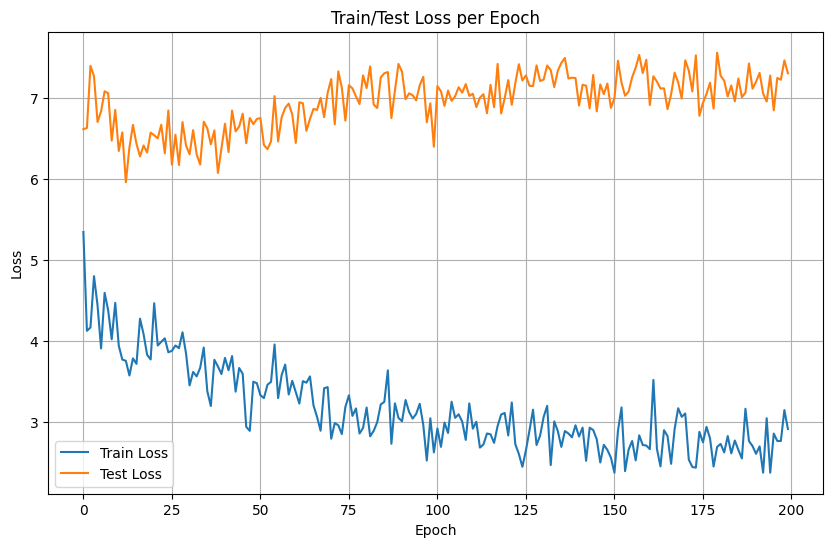

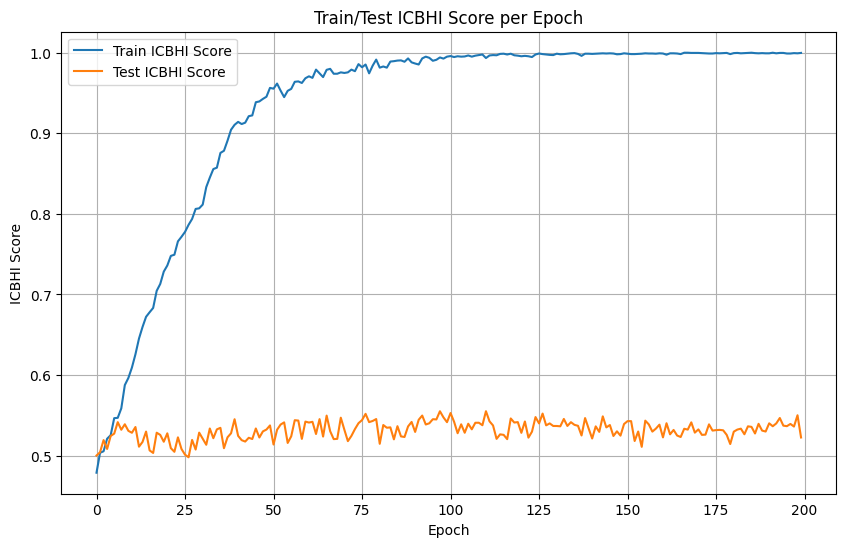


=== [최고 Test ICBHI Score 시점 정보] ===
Best Test ICBHI Score: 0.5550 (Epoch 110)
Test Loss at Best: 7.0533
Confusion Matrix at Best ICBHI Score:
[[1184  199  181   15]
 [ 330  292   20    7]
 [ 195   53  113   24]
 [  68   29   27   19]]
Sensitivity: 0.3602, Specificity: 0.7498, ICBHI Score: 0.5550
Best Epoch: 110


In [44]:
# --- 훈련 종료 후 그래프 ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train/Test Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(epochs, train_icbhi_scores, label='Train ICBHI Score')
plt.plot(epochs, test_icbhi_scores, label='Test ICBHI Score')
plt.xlabel('Epoch')
plt.ylabel('ICBHI Score')
plt.title('Train/Test ICBHI Score per Epoch')
plt.legend()
plt.grid(True)
plt.show()

best_epoch_idx = np.argmax(test_icbhi_scores)
best_epoch = epochs[best_epoch_idx]
best_icbhi_score = test_icbhi_scores[best_epoch_idx]
best_test_loss = test_losses[best_epoch_idx]

# 최고점 epoch에서의 labels, preds
best_test_labels = test_labels_all[best_epoch_idx]
best_test_preds = test_preds_all[best_epoch_idx]

best_cm, best_sens, best_spec, best_y_true_cls, best_y_pred_cls = evaluate_multiclass_confusion(
    best_test_labels, best_test_preds)

print("\n=== [최고 Test ICBHI Score 시점 정보] ===")
print(f"Best Test ICBHI Score: {best_icbhi_score:.4f} (Epoch {best_epoch})")
print(f"Test Loss at Best: {best_test_loss:.4f}")
print("Confusion Matrix at Best ICBHI Score:")
print(best_cm)
print(f"Sensitivity: {best_sens:.4f}, Specificity: {best_spec:.4f}, ICBHI Score: {(best_sens+best_spec)/2:.4f}")
print(f"Best Epoch: {best_epoch}")


### Validate

In [45]:
# # 1. 모델 구조 정의
# model = MixMLATT(backbone=backbone_cnn6,
#                  num_classes=2,
#                  lambda_attn=0.5,
#                  attention_heads=[1, float('inf')]).cuda()


# ## 2. 훈련된 weight 로드 (best checkpoint or last epoch)
# checkpoint = torch.load("/home/ressera3/BOAZ-Chungzins/notebook/0721note_ckp/0723_sbw_basefalse_0.3alpha_MultilabelAtt_T_128bs_2507230158_best.pth.tar")  # 예: "checkpoints/pretrain_best.pth.tar"

# model.load_state_dict(checkpoint['model'])
# classifier.load_state_dict(checkpoint['classifier'])
# projector_0.load_state_dict(checkpoint['projector_0'])
# projector_1.load_state_dict(checkpoint['projector_1'])

# model.eval()

# ## 3. 손실 함수 및 device 설정
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# criterion = [
#     nn.BCEWithLogitsLoss().to(device),
#     GroupMixConLoss(temperature=0.07).to(device)
# ]

# ## 4. 평가 실행 (validate 함수 호출)
# test_loss, test_labels, test_preds = validate(
#     model=model,
#     classifier=classifier,
#     projector_0=projector_0,
#     projector_1=projector_1,
#     val_loader=test_loader,   # test_loader는 미리 정의되어 있어야 함
#     criterion=criterion,
#     device=device,
#     args=args            # args는 이전 학습 설정값들 포함
# )

# ## 5. 평가 결과 출력
# from sklearn.metrics import precision_score, recall_score, f1_score

# precision = precision_score(test_labels, test_preds, average='macro')
# recall = recall_score(test_labels, test_preds, average='macro')
# f1 = f1_score(test_labels, test_preds, average='macro')

# print(f"[Final Test] Loss: {test_loss:.4f}")
# print(f"[Final Test] Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

# ## 6. Confusion Matrix 및 ICBHI Score 평가
# def evaluate_multiclass_confusion(y_true, y_pred, class_names=["Normal", "Wheeze", "Crackle", "Both"]):
#     y_true_cls = multilabel_to_multiclass(y_true)
#     y_pred_cls = multilabel_to_multiclass(y_pred)

#     cm = confusion_matrix(y_true_cls, y_pred_cls, labels=[0, 1, 2, 3])

#     # N_n: 정상 → 정상
#     N_n = cm[0, 0]
#     N_total = cm[0].sum()

#     # 이상 클래스 정답 수: W, C, B
#     W_total = cm[1].sum()
#     C_total = cm[2].sum()
#     B_total = cm[3].sum()

#     # 각각의 정답 → 정확한 예측만 고려
#     W_w = cm[1, 1]
#     C_c = cm[2, 2]
#     B_b = cm[3, 3]

#     SP = N_n / (N_total + 1e-6) #spec
#     SE = (W_w + C_c + B_b) / (W_total + C_total + B_total + 1e-6) #sense

#     AS = (SP + SE) / 2
#     HS = 2 * SP * SE / (SP + SE + 1e-6)

#     return cm, SE, SP, y_true_cls, y_pred_cls

# def multilabel_to_multiclass(y):
#     # Crackle → 1, Wheeze → 2, Both → 3, None → 0
#     y = np.array(y)
#     return y[:, 0] + y[:, 1]*2
# cm, sens, spec, y_true_cls, y_pred_cls = evaluate_multiclass_confusion(test_labels, test_preds)
# print(f"[Final Test] Confusion Matrix:\n{cm}")
# print(f"[Final Test] Sensitivity: {sens:.4f}, Specificity: {spec:.4f}, ICBHI Score: {(sens+spec)/2:.4f}")


